In [14]:
#All import statements
import pandas as pd
from numpy import log2 as log
import numpy as np
eps = np.finfo(float).eps
import matplotlib.pyplot as plt

In [66]:
# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
    left, right = list(), list()
    class_values = list(set(row[-1] for row in dataset))

    for row in dataset:
        if float(row[index]) >= float(value):
            left.append(row)
        else:
            right.append(row)
    return left,right

def calculate_info_gain (groups, classes) :   
    n_instances = float(sum([len(group) for group in groups]))
    
    # sum weighted Gini index for each group
    joined_list = list()
    for group in groups:
        joined_list = joined_list + group
    entropy = 0.0
    for class_val in classes:
        p = [row[-1] for row in joined_list].count(int(class_val)) / n_instances
        if p ==0:
            continue
        entropy += - p * log(p)
    #print ("entropy " + str(entropy)) 
        
    MI =0.0
    for group in groups:
        size = float(len(group))
        
        # avoid log(0)
        if size == 0:
            continue
        score = 0.0
        # score the group based on the score for each class
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val)/size
            #print("p="+str(p))
            if p ==0:
                continue
            score += - p * log(p)
        # weight the group score by its relative size
        MI +=  (score) * (size / n_instances)
    #print ("entropy-MI " + str(entropy-MI))
    
    return entropy-MI


# Select the best split point for a dataset
def get_split(dataset):
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, -999, None
    x1=[]
    x2=[]
    for index in range(len(dataset[0])-1):
        for row in dataset:
            if index==0 and row[index] in x1: continue
            elif index==1 and row[index] in x2: continue
            else:
                if (index==0): x1.append(row[index])
                else: x2.append(row[index])
                groups = test_split(index, row[index], dataset)
                IG = calculate_info_gain(groups, class_values)
                print('X%d >= %.6f Information Gain=%.5f' % ((index+1), row[index], IG))
                if IG > b_score:
                    b_index, b_value, b_score, b_groups = index, row[index], IG, groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups, 'IG':IG}

In [16]:
outcomes= [1.0, 0.0, 0.0, 1.0]
key=outcomes.count
print( max(set(outcomes), key=outcomes.count))
set(outcomes)
outcomes.count(1.0)


0.0


2

In [67]:
# Create a terminal node value
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    #print(outcomes)
    if outcomes.count(1.0) == outcomes.count(0.0):
        return 1.0
    #print (max(set(outcomes), key=outcomes.count))
    else:
        return max(set(outcomes), key=outcomes.count)
 
# Create child splits for a node or make terminal
def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    #print("left  "+str(left))
    #print("right  "+str(right))
    del(node['groups'])
    # check for a no split
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    #return if there is no IG
    if not node['IG']:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    
#     #return if both classes have same count  [row[-1] for row in left].count(int(1.0))
#     if [row[-1] for row in left].count(int(1.0)) == [row[-1] for row in left].count(int(0.0)):
#         node['left']  = node['right'] = to_terminal(left + right)
#         return

#     #return if both classes have same count  [row[-1] for row in left].count(int(1.0))
#     if [row[-1] for row in right].count(int(1.0)) == [row[-1] for row in right].count(int(0.0)):
#         node['left']  = node['right'] = to_terminal(left + right)
#         return
    
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
    if len(left) <= min_size or len(list(set(row[-1] for row in left)))==1:
        node['left'] = to_terminal(left)
    else:                                                                                                                                                                                                                                                                                                                                                                 
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth+1)
    # process right child
    if len(right) <= min_size or len(list(set(row[-1] for row in right)))==1:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth+1)

In [18]:
# Build a decision tree
def build_tree(train, max_depth, min_size):
    root = get_split(train)
    split(root, max_depth, min_size, 1)
    return root

In [71]:
# Print a decision tree
def print_tree(node, depth=0):
    if isinstance(node, dict):
        print('%s[X%d >= %.6f]' % ((depth*'   ', (node['index']+1), node['value'])))
        print_tree(node['left'], depth+1)
        print_tree(node['right'], depth+1)
    else:
        print('%s[label = %s]' % ((depth*'   ', node)))

In [20]:
# Make a prediction with a decision tree
def predict(node, row):
    if row[node['index']] >= node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

In [32]:
def test_accuracy1(tree, test_dataset):
    fail_count = 0
    pass_count = 0
    for row in test_dataset:
        prediction = predict(tree, row)
       #print('Expected=%d, Got=%d' % (row[-1], prediction))
        if row[-1] == prediction:
            pass_count = pass_count +1
        else:
            fail_count = fail_count +1
    print("prediction error")
    print(fail_count)

In [75]:
#q2.2
dataset = [[-1,-1,1],
    [-1,1,0],
    [1,-1,0],
    [1,1,1]]
tree = build_tree(dataset, 1000, 1)
print_tree(tree)

X1 >= -1.000000 Information Gain=0.00000
X1 >= 1.000000 Information Gain=0.00000
X2 >= -1.000000 Information Gain=0.00000
X2 >= 1.000000 Information Gain=0.00000
[X1 >= -1.000000]
   [label = 1.0]
   [label = 1.0]


Text(0.5,1,'Question 2.2')

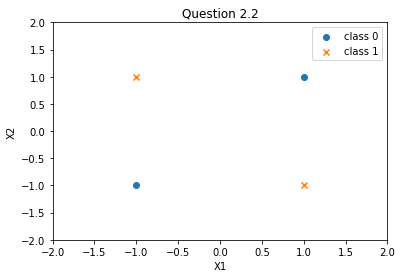

In [10]:
plt.scatter([-1, 1],[-1,1], marker='o', label="class 0")
plt.scatter([-1, 1],[1,-1], marker='x', label="class 1")
plt.legend(numpoints=1)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Question 2.2")

In [48]:
#q2.3

druns_df = pd.read_csv("Druns.txt", delim_whitespace=True, names=['x1', 'x2', 'y'])
numpy_matrix = druns_df.as_matrix()
tree = build_tree(numpy_matrix, 1000, 1)
print_tree(tree)

X1 >= 0.10000 Information Gain=0.04418
X1 >= 0.00000 Information Gain=0.00000
X2 >= -2.00000 Information Gain=0.00000
X2 >= -1.00000 Information Gain=0.04418
X2 >= 0.00000 Information Gain=0.03827
X2 >= 1.00000 Information Gain=0.00489
X2 >= 2.00000 Information Gain=0.00108
X2 >= 3.00000 Information Gain=0.01631
X2 >= 4.00000 Information Gain=0.04945
X2 >= 5.00000 Information Gain=0.10520
X2 >= 6.00000 Information Gain=0.19959
X2 >= 7.00000 Information Gain=0.03827
X2 >= 8.00000 Information Gain=0.18905
X1 >= 0.00000 Information Gain=0.00000
X2 >= 6.00000 Information Gain=0.00000
X2 >= 7.00000 Information Gain=0.25163
X2 >= 8.00000 Information Gain=0.25163
X1 >= 0.00000 Information Gain=0.00000
X2 >= 7.00000 Information Gain=0.00000
X2 >= 8.00000 Information Gain=1.00000
X1 >= 0.10000 Information Gain=0.02585
X1 >= 0.00000 Information Gain=0.00000
X2 >= -2.00000 Information Gain=0.00000
X2 >= -1.00000 Information Gain=0.02585
X2 >= 0.00000 Information Gain=0.29356
X2 >= 1.00000 Informa

/u/a/b/abhayk/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


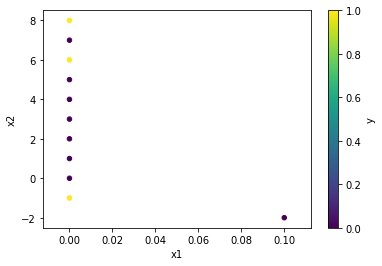

In [15]:
ax2 = druns_df.plot.scatter(x='x1',y='x2',c='y',colormap='viridis')

In [49]:
#q2.4
d3_df = pd.read_csv("D3leaves.txt", delim_whitespace=True, names=['x1', 'x2', 'y'])
numpy_matrix = d3_df.as_matrix()
tree = build_tree(numpy_matrix, 1000, 1)
print_tree(tree)

X1 >= 10.00000 Information Gain=0.32193
X1 >= 1.00000 Information Gain=0.00000
X2 >= 1.00000 Information Gain=0.00000
X2 >= 2.00000 Information Gain=0.32193
X2 >= 3.00000 Information Gain=0.17095
X1 >= 1.00000 Information Gain=0.00000
X2 >= 1.00000 Information Gain=0.00000
X2 >= 3.00000 Information Gain=1.00000
[X1 >= 10.00000]
  [label = 1]
  [X2 >= 3.00000]
    [label = 1]
    [label = 0]


/u/a/b/abhayk/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


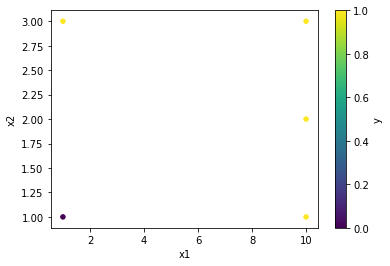

In [19]:
ax2 = d3_df.plot.scatter(x='x1',y='x2',c='y',colormap='viridis')

In [22]:
#q2.5 part1

In [70]:
d1_df = pd.read_csv("D1.txt", delim_whitespace=True, names=['x1', 'x2', 'y'])
numpy_matrix = d1_df.as_matrix()
tree = build_tree(numpy_matrix, 100, 1)
print_tree(tree)

b:\tenflow\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


X1 >= 0.264185 Information Gain=0.00032
X1 >= 0.409499 Information Gain=0.00044
X1 >= 0.926224 Information Gain=0.00102
X1 >= 0.573685 Information Gain=0.00011
X1 >= 0.953159 Information Gain=0.00085
X1 >= 0.422326 Information Gain=0.00043
X1 >= 0.733995 Information Gain=0.00142
X1 >= 0.528926 Information Gain=0.00013
X1 >= 0.844507 Information Gain=0.00001
X1 >= 0.516632 Information Gain=0.00013
X1 >= 0.613356 Information Gain=0.00025
X1 >= 0.051930 Information Gain=0.00068
X1 >= 0.693076 Information Gain=0.00015
X1 >= 0.218459 Information Gain=0.00000
X1 >= 0.462623 Information Gain=0.00001
X1 >= 0.565444 Information Gain=0.00015
X1 >= 0.709766 Information Gain=0.00043
X1 >= 0.476188 Information Gain=0.00000
X1 >= 0.428589 Information Gain=0.00077
X1 >= 0.916433 Information Gain=0.00020
X1 >= 0.846905 Information Gain=0.00002
X1 >= 0.586053 Information Gain=0.00029
X1 >= 0.483662 Information Gain=0.00001
X1 >= 0.318465 Information Gain=0.00005
X1 >= 0.679985 Information Gain=0.00020


X1 >= 0.263197 Information Gain=0.00036
X1 >= 0.074342 Information Gain=0.00246
X1 >= 0.661972 Information Gain=0.00035
X1 >= 0.341296 Information Gain=0.00001
X1 >= 0.506886 Information Gain=0.00018
X1 >= 0.215711 Information Gain=0.00003
X1 >= 0.434672 Information Gain=0.00051
X1 >= 0.604046 Information Gain=0.00023
X1 >= 0.935954 Information Gain=0.00038
X1 >= 0.748955 Information Gain=0.00128
X1 >= 0.885649 Information Gain=0.00001
X1 >= 0.344197 Information Gain=0.00001
X1 >= 0.690667 Information Gain=0.00019
X1 >= 0.922622 Information Gain=0.00035
X1 >= 0.765794 Information Gain=0.00025
X1 >= 0.614103 Information Gain=0.00028
X1 >= 0.203363 Information Gain=0.00005
X1 >= 0.198487 Information Gain=0.00025
X1 >= 0.793291 Information Gain=0.00041
X1 >= 0.851074 Information Gain=0.00017
X1 >= 0.580294 Information Gain=0.00026
X1 >= 0.171856 Information Gain=0.00038
X1 >= 0.743085 Information Gain=0.00091
X1 >= 0.156570 Information Gain=0.00034
X1 >= 0.974266 Information Gain=0.00087


X1 >= 0.317377 Information Gain=0.00007
X1 >= 0.230276 Information Gain=0.00022
X1 >= 0.831402 Information Gain=0.00002
X1 >= 0.208086 Information Gain=0.00019
X1 >= 0.959119 Information Gain=0.00108
X1 >= 0.770059 Information Gain=0.00037
X1 >= 0.276100 Information Gain=0.00028
X1 >= 0.691637 Information Gain=0.00021
X1 >= 0.802215 Information Gain=0.00029
X1 >= 0.597040 Information Gain=0.00022
X1 >= 0.701317 Information Gain=0.00023
X1 >= 0.567378 Information Gain=0.00012
X1 >= 0.210573 Information Gain=0.00004
X1 >= 0.254088 Information Gain=0.00067
X1 >= 0.991322 Information Gain=0.00061
X1 >= 0.092508 Information Gain=0.00224
X1 >= 0.721172 Information Gain=0.00087
X1 >= 0.012280 Information Gain=0.00149
X1 >= 0.804468 Information Gain=0.00009
X1 >= 0.504611 Information Gain=0.00016
X1 >= 0.708463 Information Gain=0.00036
X1 >= 0.891131 Information Gain=0.00000
X1 >= 0.444162 Information Gain=0.00019
X1 >= 0.262488 Information Gain=0.00043
X1 >= 0.135470 Information Gain=0.00001


X1 >= 0.991029 Information Gain=0.00077
X1 >= 0.533555 Information Gain=0.00028
X1 >= 0.677921 Information Gain=0.00017
X1 >= 0.734932 Information Gain=0.00133
X1 >= 0.022080 Information Gain=0.00022
X1 >= 0.833004 Information Gain=0.00001
X1 >= 0.036572 Information Gain=0.00096
X1 >= 0.446173 Information Gain=0.00026
X1 >= 0.091038 Information Gain=0.00212
X1 >= 0.416150 Information Gain=0.00039
X1 >= 0.760454 Information Gain=0.00080
X1 >= 0.667307 Information Gain=0.00033
X1 >= 0.377151 Information Gain=0.00029
X1 >= 0.889175 Information Gain=0.00000
X1 >= 0.416586 Information Gain=0.00025
X1 >= 0.447060 Information Gain=0.00015
X1 >= 0.972613 Information Gain=0.00113
X1 >= 0.926174 Information Gain=0.00111
X1 >= 0.785857 Information Gain=0.00083
X1 >= 0.270437 Information Gain=0.00041
X1 >= 0.994890 Information Gain=0.00223
X1 >= 0.334149 Information Gain=0.00000
X1 >= 0.031119 Information Gain=0.00074
X1 >= 0.686432 Information Gain=0.00023
X1 >= 0.378505 Information Gain=0.00032


X2 >= 0.439608 Information Gain=0.25209
X2 >= 0.250040 Information Gain=0.48240
X2 >= 0.048617 Information Gain=0.16816
X2 >= 0.111780 Information Gain=0.34863
X2 >= 0.058067 Information Gain=0.19287
X2 >= 0.773956 Information Gain=0.07252
X2 >= 0.769138 Information Gain=0.07438
X2 >= 0.643354 Information Gain=0.12874
X2 >= 0.557693 Information Gain=0.17381
X2 >= 0.857247 Information Gain=0.04155
X2 >= 0.907805 Information Gain=0.02477
X2 >= 0.633621 Information Gain=0.13341
X2 >= 0.035284 Information Gain=0.09813
X2 >= 0.406464 Information Gain=0.27772
X2 >= 0.861303 Information Gain=0.04057
X2 >= 0.541398 Information Gain=0.18227
X2 >= 0.529803 Information Gain=0.18808
X2 >= 0.827395 Information Gain=0.05708
X2 >= 0.641347 Information Gain=0.13013
X2 >= 0.170162 Information Gain=0.50630
X2 >= 0.547640 Information Gain=0.17660
X2 >= 0.492789 Information Gain=0.21869
X2 >= 0.686625 Information Gain=0.10615
X2 >= 0.690596 Information Gain=0.10362
X2 >= 0.824086 Information Gain=0.05918


X2 >= 0.585135 Information Gain=0.15821
X2 >= 0.442841 Information Gain=0.24981
X2 >= 0.644772 Information Gain=0.12735
X2 >= 0.870614 Information Gain=0.03572
X2 >= 0.903730 Information Gain=0.02754
X2 >= 0.034653 Information Gain=0.09533
X2 >= 0.380614 Information Gain=0.30730
X2 >= 0.573848 Information Gain=0.16401
X2 >= 0.187523 Information Gain=0.57227
X2 >= 0.275043 Information Gain=0.43851
X2 >= 0.062027 Information Gain=0.19916
X2 >= 0.342661 Information Gain=0.34318
X2 >= 0.646301 Information Gain=0.12689
X2 >= 0.837043 Information Gain=0.05293
X2 >= 0.517165 Information Gain=0.19951
X2 >= 0.920589 Information Gain=0.02022
X2 >= 0.639504 Information Gain=0.13153
X2 >= 0.147579 Information Gain=0.44422
X2 >= 0.520602 Information Gain=0.19706
X2 >= 0.439171 Information Gain=0.25285
X2 >= 0.736779 Information Gain=0.08544
X2 >= 0.670936 Information Gain=0.11521
X2 >= 0.231523 Information Gain=0.53511
X2 >= 0.432976 Information Gain=0.25747
X2 >= 0.158323 Information Gain=0.46254


X2 >= 0.770631 Information Gain=0.07400
X2 >= 0.724968 Information Gain=0.09095
X2 >= 0.580072 Information Gain=0.16083
X2 >= 0.486125 Information Gain=0.22271
X2 >= 0.659943 Information Gain=0.11963
X2 >= 0.632912 Information Gain=0.13389
X2 >= 0.469397 Information Gain=0.23306
X2 >= 0.545239 Information Gain=0.17942
X2 >= 0.367457 Information Gain=0.31407
X2 >= 0.644431 Information Gain=0.12781
X2 >= 0.914724 Information Gain=0.02173
X2 >= 0.164467 Information Gain=0.48637
X2 >= 0.125487 Information Gain=0.39666
X2 >= 0.330834 Information Gain=0.35219
X2 >= 0.382838 Information Gain=0.30446
X2 >= 0.080798 Information Gain=0.25816
X2 >= 0.561473 Information Gain=0.17215
X2 >= 0.872603 Information Gain=0.03413
X2 >= 0.762436 Information Gain=0.07776
X2 >= 0.501499 Information Gain=0.21213
X2 >= 0.524117 Information Gain=0.19283
X2 >= 0.046161 Information Gain=0.15309
X2 >= 0.189092 Information Gain=0.58452
X2 >= 0.847863 Information Gain=0.04651
X2 >= 0.723167 Information Gain=0.09255


X2 >= 0.817231 Information Gain=0.06165
X2 >= 0.754522 Information Gain=0.08004
X2 >= 0.419827 Information Gain=0.27106
X2 >= 0.527166 Information Gain=0.18926
X2 >= 0.176784 Information Gain=0.51141
X2 >= 0.872056 Information Gain=0.03477
X2 >= 0.214397 Information Gain=0.59331
X2 >= 0.868784 Information Gain=0.03669
X2 >= 0.694087 Information Gain=0.10112
X2 >= 0.038435 Information Gain=0.12084
X2 >= 0.953603 Information Gain=0.01106
X2 >= 0.011202 Information Gain=0.01521
X2 >= 0.467779 Information Gain=0.23376
X2 >= 0.219306 Information Gain=0.57599
X2 >= 0.243556 Information Gain=0.50146
X2 >= 0.840455 Information Gain=0.05191
X2 >= 0.852799 Information Gain=0.04319
X2 >= 0.010919 Information Gain=0.01011
X2 >= 0.212010 Information Gain=0.60473
X2 >= 0.779883 Information Gain=0.07141
X2 >= 0.621361 Information Gain=0.14060
X2 >= 0.544427 Information Gain=0.18056
X2 >= 0.973887 Information Gain=0.00732
X2 >= 0.968062 Information Gain=0.00875
X2 >= 0.498216 Information Gain=0.21408


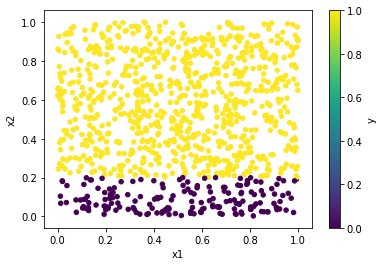

In [25]:
ax2 = d1_df.plot.scatter(x='x1',y='x2',c='y',colormap='viridis')

In [26]:
#q2.5 part2  D2

In [74]:
#p5
d2_df = pd.read_csv("D2.txt", delim_whitespace=True, names=['x1', 'x2', 'y'])
numpy_matrix = d2_df.as_matrix()
tree = build_tree(numpy_matrix, 1000, 1)
print_tree(tree)

b:\tenflow\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


X1 >= 0.315561 Information Gain=0.14923
X1 >= 0.344972 Information Gain=0.16071
X1 >= 0.398419 Information Gain=0.18448
X1 >= 0.347109 Information Gain=0.16064
X1 >= 0.985903 Information Gain=0.01657
X1 >= 0.708728 Information Gain=0.18207
X1 >= 0.829610 Information Gain=0.12662
X1 >= 0.978967 Information Gain=0.01988
X1 >= 0.921975 Information Gain=0.06928
X1 >= 0.518431 Information Gain=0.21326
X1 >= 0.401686 Information Gain=0.18673
X1 >= 0.307729 Information Gain=0.14282
X1 >= 0.300959 Information Gain=0.13578
X1 >= 0.412298 Information Gain=0.18474
X1 >= 0.141637 Information Gain=0.08041
X1 >= 0.710494 Information Gain=0.18381
X1 >= 0.285540 Information Gain=0.13689
X1 >= 0.468695 Information Gain=0.19857
X1 >= 0.262335 Information Gain=0.12419
X1 >= 0.851026 Information Gain=0.11013
X1 >= 0.099204 Information Gain=0.06551
X1 >= 0.361849 Information Gain=0.17230
X1 >= 0.401017 Information Gain=0.18395
X1 >= 0.035681 Information Gain=0.02996
X1 >= 0.137305 Information Gain=0.07735


X1 >= 0.683761 Information Gain=0.17522
X1 >= 0.944630 Information Gain=0.05976
X1 >= 0.050327 Information Gain=0.02962
X1 >= 0.644333 Information Gain=0.20240
X1 >= 0.440464 Information Gain=0.20489
X1 >= 0.474216 Information Gain=0.19635
X1 >= 0.176701 Information Gain=0.09243
X1 >= 0.235978 Information Gain=0.11274
X1 >= 0.983256 Information Gain=0.01592
X1 >= 0.404007 Information Gain=0.18710
X1 >= 0.256952 Information Gain=0.12196
X1 >= 0.084123 Information Gain=0.05132
X1 >= 0.898032 Information Gain=0.08567
X1 >= 0.276274 Information Gain=0.13133
X1 >= 0.991564 Information Gain=0.00720
X1 >= 0.029978 Information Gain=0.02083
X1 >= 0.696763 Information Gain=0.17454
X1 >= 0.862192 Information Gain=0.10501
X1 >= 0.226702 Information Gain=0.11048
X1 >= 0.090999 Information Gain=0.05835
X1 >= 0.660985 Information Gain=0.19421
X1 >= 0.786499 Information Gain=0.15123
X1 >= 0.619206 Information Gain=0.19575
X1 >= 0.337672 Information Gain=0.15513
X1 >= 0.597351 Information Gain=0.19897


X1 >= 0.120891 Information Gain=0.07020
X1 >= 0.839018 Information Gain=0.12539
X1 >= 0.277864 Information Gain=0.13709
X1 >= 0.489728 Information Gain=0.20137
X1 >= 0.191915 Information Gain=0.10365
X1 >= 0.343437 Information Gain=0.15819
X1 >= 0.076825 Information Gain=0.04346
X1 >= 0.435451 Information Gain=0.20259
X1 >= 0.227775 Information Gain=0.11157
X1 >= 0.003742 Information Gain=0.00196
X1 >= 0.064606 Information Gain=0.03595
X1 >= 0.484345 Information Gain=0.20189
X1 >= 0.306089 Information Gain=0.13928
X1 >= 0.234523 Information Gain=0.11166
X1 >= 0.188139 Information Gain=0.10093
X1 >= 0.872775 Information Gain=0.10192
X1 >= 0.240404 Information Gain=0.11600
X1 >= 0.846789 Information Gain=0.11710
X1 >= 0.671935 Information Gain=0.17758
X1 >= 0.646007 Information Gain=0.20290
X1 >= 0.964542 Information Gain=0.03736
X1 >= 0.585174 Information Gain=0.20131
X1 >= 0.813496 Information Gain=0.13535
X1 >= 0.779557 Information Gain=0.15487
X1 >= 0.700198 Information Gain=0.17808


X1 >= 0.133282 Information Gain=0.07190
X1 >= 0.361285 Information Gain=0.17099
X1 >= 0.349353 Information Gain=0.16962
X1 >= 0.438390 Information Gain=0.20373
X1 >= 0.407403 Information Gain=0.18473
X1 >= 0.998890 Information Gain=0.00205
X1 >= 0.308147 Information Gain=0.14400
X1 >= 0.965660 Information Gain=0.03526
X1 >= 0.375840 Information Gain=0.17449
X1 >= 0.977951 Information Gain=0.02089
X1 >= 0.320432 Information Gain=0.14818
X1 >= 0.230493 Information Gain=0.11373
X1 >= 0.649824 Information Gain=0.19698
X1 >= 0.454587 Information Gain=0.20849
X1 >= 0.746221 Information Gain=0.17848
X1 >= 0.061317 Information Gain=0.03309
X1 >= 0.029386 Information Gain=0.01983
X1 >= 0.004763 Information Gain=0.00294
X1 >= 0.464517 Information Gain=0.20395
X1 >= 0.939611 Information Gain=0.06121
X1 >= 0.500708 Information Gain=0.20905
X1 >= 0.227529 Information Gain=0.11049
X1 >= 0.167782 Information Gain=0.08867
X1 >= 0.393227 Information Gain=0.19088
X1 >= 0.065420 Information Gain=0.03692


X2 >= 0.605519 Information Gain=0.16204
X2 >= 0.090137 Information Gain=0.05232
X2 >= 0.566471 Information Gain=0.16313
X2 >= 0.679243 Information Gain=0.15357
X2 >= 0.840747 Information Gain=0.10681
X2 >= 0.327330 Information Gain=0.13106
X2 >= 0.670148 Information Gain=0.15931
X2 >= 0.688614 Information Gain=0.15640
X2 >= 0.587253 Information Gain=0.16685
X2 >= 0.660778 Information Gain=0.16190
X2 >= 0.539898 Information Gain=0.16695
X2 >= 0.810460 Information Gain=0.10717
X2 >= 0.135286 Information Gain=0.07528
X2 >= 0.100103 Information Gain=0.06034
X2 >= 0.210729 Information Gain=0.10523
X2 >= 0.592718 Information Gain=0.17071
X2 >= 0.166664 Information Gain=0.09416
X2 >= 0.169053 Information Gain=0.09358
X2 >= 0.831078 Information Gain=0.10718
X2 >= 0.841168 Information Gain=0.10728
X2 >= 0.360445 Information Gain=0.14800
X2 >= 0.604435 Information Gain=0.16164
X2 >= 0.091881 Information Gain=0.05258
X2 >= 0.631885 Information Gain=0.16401
X2 >= 0.016248 Information Gain=0.01183


X2 >= 0.292949 Information Gain=0.12603
X2 >= 0.334914 Information Gain=0.13627
X2 >= 0.221983 Information Gain=0.11048
X2 >= 0.491873 Information Gain=0.18236
X2 >= 0.042702 Information Gain=0.02750
X2 >= 0.862155 Information Gain=0.09851
X2 >= 0.048155 Information Gain=0.03845
X2 >= 0.638209 Information Gain=0.16751
X2 >= 0.498718 Information Gain=0.17764
X2 >= 0.438009 Information Gain=0.16832
X2 >= 0.530964 Information Gain=0.17101
X2 >= 0.477384 Information Gain=0.17222
X2 >= 0.545170 Information Gain=0.17056
X2 >= 0.658608 Information Gain=0.16452
X2 >= 0.666059 Information Gain=0.16453
X2 >= 0.913274 Information Gain=0.07409
X2 >= 0.074285 Information Gain=0.05033
X2 >= 0.501454 Information Gain=0.18075
X2 >= 0.065904 Information Gain=0.04671
X2 >= 0.888777 Information Gain=0.10050
X2 >= 0.864408 Information Gain=0.09513
X2 >= 0.938352 Information Gain=0.06090
X2 >= 0.367753 Information Gain=0.15143
X2 >= 0.218636 Information Gain=0.10514
X2 >= 0.717094 Information Gain=0.13786


X2 >= 0.265486 Information Gain=0.11598
X2 >= 0.230273 Information Gain=0.11174
X2 >= 0.465526 Information Gain=0.17019
X2 >= 0.313324 Information Gain=0.12828
X2 >= 0.883818 Information Gain=0.10097
X2 >= 0.528416 Information Gain=0.17236
X2 >= 0.748423 Information Gain=0.12475
X2 >= 0.289788 Information Gain=0.12268
X2 >= 0.527878 Information Gain=0.17382
X2 >= 0.430388 Information Gain=0.17266
X2 >= 0.377011 Information Gain=0.15711
X2 >= 0.227201 Information Gain=0.11482
X2 >= 0.100131 Information Gain=0.06133
X2 >= 0.139499 Information Gain=0.07685
X2 >= 0.203125 Information Gain=0.10214
X2 >= 0.482563 Information Gain=0.17507
X2 >= 0.782804 Information Gain=0.10966
X2 >= 0.826626 Information Gain=0.10307
X2 >= 0.860277 Information Gain=0.10115
X2 >= 0.838691 Information Gain=0.10909
X2 >= 0.921149 Information Gain=0.07670
X2 >= 0.257736 Information Gain=0.11503
X2 >= 0.875600 Information Gain=0.10039
X2 >= 0.756060 Information Gain=0.11559
X2 >= 0.834728 Information Gain=0.10867


X2 >= 0.415267 Information Gain=0.16434
X2 >= 0.764149 Information Gain=0.11084
X2 >= 0.938840 Information Gain=0.05978
X2 >= 0.639018 Information Gain=0.17002
X2 >= 0.975298 Information Gain=0.02712
X2 >= 0.228123 Information Gain=0.11377
X2 >= 0.969149 Information Gain=0.03676
X2 >= 0.109772 Information Gain=0.06064
X2 >= 0.126057 Information Gain=0.07030
X2 >= 0.919236 Information Gain=0.08014
X2 >= 0.641405 Information Gain=0.16794
X2 >= 0.061150 Information Gain=0.04738
X2 >= 0.998563 Information Gain=0.00102
X2 >= 0.212709 Information Gain=0.10305
X2 >= 0.834799 Information Gain=0.10753
X2 >= 0.921835 Information Gain=0.07556
X2 >= 0.046459 Information Gain=0.03543
X2 >= 0.469512 Information Gain=0.17278
X2 >= 0.562010 Information Gain=0.16792
X2 >= 0.425556 Information Gain=0.16990
X2 >= 0.485894 Information Gain=0.17492
X2 >= 0.742051 Information Gain=0.12651
X2 >= 0.510732 Information Gain=0.18243
X2 >= 0.758009 Information Gain=0.11222
X2 >= 0.905423 Information Gain=0.08197


X2 >= 0.470577 Information Gain=0.30263
X2 >= 0.762936 Information Gain=0.09411
X2 >= 0.852248 Information Gain=0.05716
X2 >= 0.710760 Information Gain=0.12319
X2 >= 0.718440 Information Gain=0.11540
X2 >= 0.875557 Information Gain=0.04542
X2 >= 0.228825 Information Gain=0.31571
X2 >= 0.747414 Information Gain=0.10246
X2 >= 0.126390 Information Gain=0.19609
X2 >= 0.070730 Information Gain=0.11953
X2 >= 0.257297 Information Gain=0.28828
X2 >= 0.947971 Information Gain=0.01579
X2 >= 0.788712 Information Gain=0.08099
X2 >= 0.361499 Information Gain=0.34372
X2 >= 0.343144 Information Gain=0.33664
X2 >= 0.341928 Information Gain=0.33942
X2 >= 0.421367 Information Gain=0.33367
X2 >= 0.310553 Information Gain=0.32203
X2 >= 0.649242 Information Gain=0.15765
X2 >= 0.916135 Information Gain=0.02816
X2 >= 0.175042 Information Gain=0.27377
X2 >= 0.313280 Information Gain=0.33726
X2 >= 0.797968 Information Gain=0.07706
X2 >= 0.059456 Information Gain=0.10825
X2 >= 0.403494 Information Gain=0.33845


X1 >= 0.842874 Information Gain=0.00394
X1 >= 0.637257 Information Gain=0.01569
X1 >= 0.860367 Information Gain=0.00341
X1 >= 0.721679 Information Gain=0.00910
X1 >= 0.930856 Information Gain=0.00173
X1 >= 0.810996 Information Gain=0.00492
X1 >= 0.950405 Information Gain=0.00116
X1 >= 0.891063 Information Gain=0.00251
X1 >= 0.793003 Information Gain=0.00537
X1 >= 0.638998 Information Gain=0.01536
X1 >= 0.681399 Information Gain=0.01115
X1 >= 0.729537 Information Gain=0.00893
X1 >= 0.836983 Information Gain=0.00409
X1 >= 0.754559 Information Gain=0.00727
X1 >= 0.874763 Information Gain=0.00290
X1 >= 0.954373 Information Gain=0.00108
X1 >= 0.700857 Information Gain=0.01026
X1 >= 0.791271 Information Gain=0.00555
X1 >= 0.884483 Information Gain=0.00260
X1 >= 0.581996 Information Gain=0.02165
X1 >= 0.676959 Information Gain=0.01146
X1 >= 0.912374 Information Gain=0.00213
X1 >= 0.873914 Information Gain=0.00295
X1 >= 0.867487 Information Gain=0.00317
X1 >= 0.747269 Information Gain=0.00799


X1 >= 0.641366 Information Gain=0.18976
X1 >= 0.617803 Information Gain=0.12825
X1 >= 0.709427 Information Gain=0.24589
X1 >= 0.828409 Information Gain=0.24980
X1 >= 0.892864 Information Gain=0.23532
X1 >= 0.812280 Information Gain=0.27391
X1 >= 0.560407 Information Gain=0.03067
X1 >= 0.986453 Information Gain=0.04863
X1 >= 0.934827 Information Gain=0.16456
X1 >= 0.721324 Information Gain=0.26622
X1 >= 0.801451 Information Gain=0.28007
X1 >= 0.793260 Information Gain=0.29580
X1 >= 0.678179 Information Gain=0.17637
X1 >= 0.949160 Information Gain=0.13561
X1 >= 0.642246 Information Gain=0.19568
X1 >= 0.927522 Information Gain=0.17441
X1 >= 0.874330 Information Gain=0.22529
X1 >= 0.857659 Information Gain=0.24011
X1 >= 0.592121 Information Gain=0.07744
X1 >= 0.757102 Information Gain=0.30112
X1 >= 0.960783 Information Gain=0.08265
X1 >= 0.977728 Information Gain=0.04815
X1 >= 0.611437 Information Gain=0.11254
X1 >= 0.957943 Information Gain=0.09725
X1 >= 0.730842 Information Gain=0.27402


X2 >= 0.145473 Information Gain=0.21536
X2 >= 0.365537 Information Gain=0.01485
X2 >= 0.341365 Information Gain=0.05185
X2 >= 0.076499 Information Gain=0.22100
X2 >= 0.367848 Information Gain=0.00983
X2 >= 0.061886 Information Gain=0.14670
X2 >= 0.198296 Information Gain=0.34397
X2 >= 0.244365 Information Gain=0.19820
X2 >= 0.084265 Information Gain=0.23426
X2 >= 0.065904 Information Gain=0.12543
X2 >= 0.142179 Information Gain=0.19910
X2 >= 0.091239 Information Gain=0.20086
X2 >= 0.014066 Information Gain=0.06104
X2 >= 0.312399 Information Gain=0.07468
X2 >= 0.265066 Information Gain=0.13842
X2 >= 0.248934 Information Gain=0.17469
X2 >= 0.210079 Information Gain=0.32099
X2 >= 0.266377 Information Gain=0.12481
X2 >= 0.139975 Information Gain=0.17317
X2 >= 0.246661 Information Gain=0.19020
X2 >= 0.068729 Information Gain=0.16933
X2 >= 0.078360 Information Gain=0.20109
X2 >= 0.026257 Information Gain=0.12656
X2 >= 0.242906 Information Gain=0.21472
X2 >= 0.327415 Information Gain=0.05744


X1 >= 0.093622 Information Gain=0.03203
X1 >= 0.371670 Information Gain=0.02848
X1 >= 0.137062 Information Gain=0.03005
X1 >= 0.317725 Information Gain=0.02575
X1 >= 0.280252 Information Gain=0.03162
X1 >= 0.433837 Information Gain=0.02403
X1 >= 0.093713 Information Gain=0.03274
X1 >= 0.104094 Information Gain=0.03391
X1 >= 0.284200 Information Gain=0.02923
X1 >= 0.431913 Information Gain=0.02080
X1 >= 0.305234 Information Gain=0.02376
X1 >= 0.243784 Information Gain=0.02846
X1 >= 0.232250 Information Gain=0.02811
X1 >= 0.140423 Information Gain=0.03134
X1 >= 0.163813 Information Gain=0.03369
X1 >= 0.205622 Information Gain=0.03505
X1 >= 0.420299 Information Gain=0.02354
X1 >= 0.068651 Information Gain=0.01616
X1 >= 0.131728 Information Gain=0.02814
X1 >= 0.207325 Information Gain=0.03063
X1 >= 0.280945 Information Gain=0.02741
X1 >= 0.327010 Information Gain=0.02620
X1 >= 0.106316 Information Gain=0.03463
X1 >= 0.387288 Information Gain=0.03186
X1 >= 0.271330 Information Gain=0.02849


X1 >= 0.253985 Information Gain=0.02830
X1 >= 0.037288 Information Gain=0.02426
X1 >= 0.088781 Information Gain=0.02920
X1 >= 0.314752 Information Gain=0.02781
X1 >= 0.468983 Information Gain=0.00828
X1 >= 0.143448 Information Gain=0.03397
X1 >= 0.380770 Information Gain=0.02733
X1 >= 0.101859 Information Gain=0.03787
X1 >= 0.133282 Information Gain=0.02877
X1 >= 0.361285 Information Gain=0.02628
X1 >= 0.349353 Information Gain=0.02943
X1 >= 0.438390 Information Gain=0.02249
X1 >= 0.407403 Information Gain=0.02202
X1 >= 0.308147 Information Gain=0.02670
X1 >= 0.375840 Information Gain=0.02523
X1 >= 0.320432 Information Gain=0.02506
X1 >= 0.230493 Information Gain=0.02976
X1 >= 0.454587 Information Gain=0.02126
X1 >= 0.061317 Information Gain=0.01560
X1 >= 0.029386 Information Gain=0.01495
X1 >= 0.004763 Information Gain=0.00220
X1 >= 0.464517 Information Gain=0.01411
X1 >= 0.500708 Information Gain=0.00438
X1 >= 0.227529 Information Gain=0.02797
X1 >= 0.167782 Information Gain=0.03200


X2 >= 0.696856 Information Gain=0.31050
X2 >= 0.223707 Information Gain=0.08540
X2 >= 0.879386 Information Gain=0.23185
X2 >= 0.883103 Information Gain=0.24536
X2 >= 0.577948 Information Gain=0.33184
X2 >= 0.564982 Information Gain=0.32153
X2 >= 0.975983 Information Gain=0.04590
X2 >= 0.335222 Information Gain=0.15230
X2 >= 0.061105 Information Gain=0.02112
X2 >= 0.488717 Information Gain=0.29357
X2 >= 0.822610 Information Gain=0.22897
X2 >= 0.964767 Information Gain=0.09875
X2 >= 0.262942 Information Gain=0.11097
X2 >= 0.742624 Information Gain=0.28841
X2 >= 0.735901 Information Gain=0.28849
X2 >= 0.491867 Information Gain=0.30080
X2 >= 0.549772 Information Gain=0.33538
X2 >= 0.240615 Information Gain=0.09794
X2 >= 0.819166 Information Gain=0.22511
X2 >= 0.161942 Information Gain=0.05731
X2 >= 0.451997 Information Gain=0.25646
X2 >= 0.613597 Information Gain=0.33788
X2 >= 0.616638 Information Gain=0.34049
X2 >= 0.967629 Information Gain=0.09422
X2 >= 0.304010 Information Gain=0.13316


X2 >= 0.299414 Information Gain=0.13207
X2 >= 0.827781 Information Gain=0.22620
X2 >= 0.324958 Information Gain=0.14203
X2 >= 0.328890 Information Gain=0.14769
X2 >= 0.490517 Information Gain=0.29717
X2 >= 0.532684 Information Gain=0.33757
X2 >= 0.315500 Information Gain=0.13868
X2 >= 0.297134 Information Gain=0.12990
X2 >= 0.366208 Information Gain=0.17633
X2 >= 0.269232 Information Gain=0.11405
X2 >= 0.251131 Information Gain=0.10389
X2 >= 0.345991 Information Gain=0.16170
X2 >= 0.830799 Information Gain=0.22497
X2 >= 0.236877 Information Gain=0.09403
X2 >= 0.377611 Information Gain=0.19295
X2 >= 0.255889 Information Gain=0.10791
X2 >= 0.433309 Information Gain=0.23788
X2 >= 0.723586 Information Gain=0.32247
X2 >= 0.373074 Information Gain=0.18775
X2 >= 0.185684 Information Gain=0.06611
X2 >= 0.396847 Information Gain=0.20771
X2 >= 0.901984 Information Gain=0.17989
X2 >= 0.146855 Information Gain=0.05043
X2 >= 0.147677 Information Gain=0.05128
X2 >= 0.249993 Information Gain=0.10189


X1 >= 0.200362 Information Gain=0.04574
X1 >= 0.517341 Information Gain=0.00700
X1 >= 0.489264 Information Gain=0.02916
X1 >= 0.439246 Information Gain=0.07075
X1 >= 0.394714 Information Gain=0.11645
X1 >= 0.270046 Information Gain=0.09447
X1 >= 0.407403 Information Gain=0.09590
X1 >= 0.230493 Information Gain=0.09119
X1 >= 0.464517 Information Gain=0.05333
X1 >= 0.227529 Information Gain=0.07531
X1 >= 0.167782 Information Gain=0.01191
X1 >= 0.393227 Information Gain=0.12736
X1 >= 0.296790 Information Gain=0.09520
X1 >= 0.289904 Information Gain=0.08808
X1 >= 0.514109 Information Gain=0.01177
X1 >= 0.298512 Information Gain=0.09139
X2 >= 0.956006 Information Gain=0.06190
X2 >= 0.693422 Information Gain=0.08379
X2 >= 0.974354 Information Gain=0.02660
X2 >= 0.661476 Information Gain=0.03095
X2 >= 0.945498 Information Gain=0.07075
X2 >= 0.722322 Information Gain=0.09640
X2 >= 0.674585 Information Gain=0.04569
X2 >= 0.745406 Information Gain=0.09326
X2 >= 0.724383 Information Gain=0.10692


X1 >= 0.351265 Information Gain=0.04530
X1 >= 0.127011 Information Gain=0.00875
X1 >= 0.082625 Information Gain=0.00590
X1 >= 0.445175 Information Gain=0.04377
X1 >= 0.409972 Information Gain=0.06027
X1 >= 0.354007 Information Gain=0.04602
X1 >= 0.521854 Information Gain=0.00085
X1 >= 0.169865 Information Gain=0.01361
X1 >= 0.000997 Information Gain=0.00000
X1 >= 0.481243 Information Gain=0.00661
X1 >= 0.414121 Information Gain=0.04401
X1 >= 0.135536 Information Gain=0.00965
X1 >= 0.489728 Information Gain=0.00781
X1 >= 0.343437 Information Gain=0.04088
X1 >= 0.076825 Information Gain=0.00549
X1 >= 0.227775 Information Gain=0.02066
X1 >= 0.003742 Information Gain=0.00024
X1 >= 0.484345 Information Gain=0.00689
X1 >= 0.306089 Information Gain=0.03299
X1 >= 0.240404 Information Gain=0.02207
X1 >= 0.478863 Information Gain=0.00583
X1 >= 0.169797 Information Gain=0.01344
X1 >= 0.493660 Information Gain=0.00925
X1 >= 0.354976 Information Gain=0.04676
X1 >= 0.151020 Information Gain=0.01166


X2 >= 0.608110 Information Gain=0.01385
X2 >= 0.057107 Information Gain=0.00310
X2 >= 0.635533 Information Gain=0.00060
X2 >= 0.100089 Information Gain=0.00535
X2 >= 0.638232 Information Gain=0.00012
X2 >= 0.032038 Information Gain=0.00097
X2 >= 0.544747 Information Gain=0.05859
X2 >= 0.266168 Information Gain=0.01969
X2 >= 0.214353 Information Gain=0.01311
X2 >= 0.434467 Information Gain=0.04639
X2 >= 0.137576 Information Gain=0.00773
X2 >= 0.288624 Information Gain=0.02186
X2 >= 0.119764 Information Gain=0.00631
X2 >= 0.035819 Information Gain=0.00109
X2 >= 0.219011 Information Gain=0.01378
X2 >= 0.062940 Information Gain=0.00375
X2 >= 0.354819 Information Gain=0.03016
X2 >= 0.133520 Information Gain=0.00730
X2 >= 0.477188 Information Gain=0.05681
X2 >= 0.460015 Information Gain=0.05189
X2 >= 0.399035 Information Gain=0.03961
X2 >= 0.223707 Information Gain=0.01462
X2 >= 0.577948 Information Gain=0.02530
X2 >= 0.564982 Information Gain=0.02937
X2 >= 0.335222 Information Gain=0.02728


In [72]:
print_tree(tree)

[X2 >= 0.201829]
   [label = 1.0]
   [label = 0.0]


In [ ]:
# Make a prediction with a decision tree
def predict(node, row):
    if row[node['index']] >= node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

In [ ]:
# Print a decision tree
def print_tree(node, depth=0):
    if isinstance(node, dict):
        print('%s[X%d >= %.5f]' % ((depth*'  ', (node['index']+1), node['value'])))
        print_tree(node['left'], depth+1)
        print_tree(node['right'], depth+1)
    else:
        print('%s[label = %s]' % ((depth*'  ', node)))

In [59]:
# Print a decision tree
def visualize(node, xl,xh,xl2,xh2, depth=0):
   
    if isinstance(node, dict):
        #print('%s[X%d >= %.5f]' % ((depth*'  ', (node['index']+1), node['value'])))
        visualize(node['left'], depth+1)
        visualize(node['right'], depth+1)
    else:
        print('%s[label = %s]' % ((depth*'  ', node)))

In [69]:
d2_df = pd.read_csv("D2.txt", delim_whitespace=True, names=['x1', 'x2', 'y'])
numpy_matrix = d2_df.as_matrix()



/u/a/b/abhayk/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [83]:
x1_l = min(numpy_matrix.min(axis=0))
x2_l = min(numpy_matrix.min(axis=1))
x1_h = max(numpy_matrix.max(axis=0))
x2_h = max(numpy_matrix.max(axis=1))
numpy_matrix[:, 0].max()

0.99954

In [60]:
visualize(tree, x1_l,x2_l,x1_h,x2_h,  depth=0)

0.31556100000000004 [0.99954  0.998563 1.      ] [0.315561 0.344972 0.398419 0.       0.564388 0.708728 0.604565 0.49721
 0.224236 0.518431 0.       0.       0.       0.412298 0.       0.710494
 0.       0.       0.       0.840812 0.       0.       0.       0.
 0.       0.301105 0.       0.551028 0.372334 0.234851 0.984849 0.
 0.       0.485713 0.       0.446889 0.597914 0.       0.       0.279292
 0.       0.       0.       0.       0.       0.       0.735124 0.221062
 0.502947 0.75669  0.577437 0.       0.607614 0.       0.500395 0.82933
 0.353308 0.       0.       0.       0.721383 0.873461 0.       0.607143
 0.669635 0.263957 0.       0.243049 0.       0.       0.       0.36855
 0.       0.285902 0.       0.410302 0.       0.118056 0.       0.456444
 0.       0.       0.903273 0.585753 0.270655 0.658644 0.       0.
 0.       0.653177 0.375331 0.56568  0.191206 0.       0.       0.
 0.       0.135573 0.       0.438162 0.682569 0.       0.645326 0.
 0.541674 0.30617  0.       0.32995

TypeError: 'int' object is not subscriptable

In [26]:
def test_accuracy(tree, xx, yy):
    arr=[]
    for x1,x2 in zip (xx,yy):
        row = [x1,x2]
        prediction = predict(tree, row)
        arr.append([prediction])
       #print('Expected=%d, Got=%d' % (row[-1], prediction))
    return arr

In [60]:
d2_df = pd.read_csv("D2.txt", delim_whitespace=True, names=['x1', 'x2', 'y'])
numpy_matrix = d2_df.as_matrix()
tree = build_tree(numpy_matrix, 1000, 1)

b:\tenflow\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


X1 >= 0.31556 Information Gain=0.14923
X1 >= 0.34497 Information Gain=0.16071
X1 >= 0.39842 Information Gain=0.18448
X1 >= 0.34711 Information Gain=0.16064
X1 >= 0.98590 Information Gain=0.01657
X1 >= 0.70873 Information Gain=0.18207
X1 >= 0.82961 Information Gain=0.12662
X1 >= 0.97897 Information Gain=0.01988
X1 >= 0.92197 Information Gain=0.06928
X1 >= 0.51843 Information Gain=0.21326
X1 >= 0.40169 Information Gain=0.18673
X1 >= 0.30773 Information Gain=0.14282
X1 >= 0.30096 Information Gain=0.13578
X1 >= 0.41230 Information Gain=0.18474
X1 >= 0.14164 Information Gain=0.08041
X1 >= 0.71049 Information Gain=0.18381
X1 >= 0.28554 Information Gain=0.13689
X1 >= 0.46869 Information Gain=0.19857
X1 >= 0.26233 Information Gain=0.12419
X1 >= 0.85103 Information Gain=0.11013
X1 >= 0.09920 Information Gain=0.06551
X1 >= 0.36185 Information Gain=0.17230
X1 >= 0.40102 Information Gain=0.18395
X1 >= 0.03568 Information Gain=0.02996
X1 >= 0.13730 Information Gain=0.07735
X1 >= 0.71815 Information

X1 >= 0.09029 Information Gain=0.05734
X1 >= 0.86447 Information Gain=0.10686
X1 >= 0.07895 Information Gain=0.04737
X1 >= 0.47103 Information Gain=0.19810
X1 >= 0.19713 Information Gain=0.10545
X1 >= 0.27874 Information Gain=0.13614
X1 >= 0.18215 Information Gain=0.09281
X1 >= 0.19345 Information Gain=0.10120
X1 >= 0.83039 Information Gain=0.12424
X1 >= 0.81861 Information Gain=0.13052
X1 >= 0.76142 Information Gain=0.16751
X1 >= 0.25389 Information Gain=0.11960
X1 >= 0.82769 Information Gain=0.12734
X1 >= 0.00285 Information Gain=0.00098
X1 >= 0.41081 Information Gain=0.18379
X1 >= 0.14792 Information Gain=0.07931
X1 >= 0.59857 Information Gain=0.19772
X1 >= 0.92558 Information Gain=0.06946
X1 >= 0.92449 Information Gain=0.07055
X1 >= 0.80833 Information Gain=0.13831
X1 >= 0.72353 Information Gain=0.17800
X1 >= 0.76060 Information Gain=0.16625
X1 >= 0.62040 Information Gain=0.19799
X1 >= 0.74388 Information Gain=0.17982
X1 >= 0.17144 Information Gain=0.09035
X1 >= 0.32159 Information

X1 >= 0.69933 Information Gain=0.17733
X1 >= 0.43682 Information Gain=0.20222
X1 >= 0.58200 Information Gain=0.20264
X1 >= 0.34912 Information Gain=0.16702
X1 >= 0.98377 Information Gain=0.01972
X1 >= 0.67696 Information Gain=0.17407
X1 >= 0.91237 Information Gain=0.08020
X1 >= 0.87391 Information Gain=0.09851
X1 >= 0.86749 Information Gain=0.10115
X1 >= 0.74727 Information Gain=0.17967
X1 >= 0.14769 Information Gain=0.07830
X1 >= 0.91402 Information Gain=0.07689
X1 >= 0.64717 Information Gain=0.20141
X1 >= 0.78231 Information Gain=0.15756
X1 >= 0.14478 Information Gain=0.08085
X1 >= 0.69858 Information Gain=0.17869
X1 >= 0.83669 Information Gain=0.12899
X1 >= 0.08421 Information Gain=0.05232
X1 >= 0.86158 Information Gain=0.10327
X1 >= 0.75527 Information Gain=0.16513
X1 >= 0.35126 Information Gain=0.17092
X1 >= 0.12701 Information Gain=0.06956
X1 >= 0.08263 Information Gain=0.04934
X1 >= 0.44517 Information Gain=0.20607
X1 >= 0.94887 Information Gain=0.05221
X1 >= 0.68148 Information

X1 >= 0.65556 Information Gain=0.19712
X1 >= 0.86508 Information Gain=0.10571
X1 >= 0.41291 Information Gain=0.18430
X1 >= 0.76024 Information Gain=0.16755
X1 >= 0.30883 Information Gain=0.14520
X1 >= 0.76064 Information Gain=0.16882
X1 >= 0.52782 Information Gain=0.21662
X1 >= 0.21421 Information Gain=0.10730
X1 >= 0.66337 Information Gain=0.19045
X1 >= 0.93037 Information Gain=0.07211
X1 >= 0.31442 Information Gain=0.14682
X1 >= 0.94184 Information Gain=0.06412
X1 >= 0.13584 Information Gain=0.07229
X1 >= 0.70624 Information Gain=0.18398
X1 >= 0.94152 Information Gain=0.06013
X1 >= 0.37161 Information Gain=0.17896
X1 >= 0.46032 Information Gain=0.20788
X1 >= 0.91278 Information Gain=0.07799
X1 >= 0.75067 Information Gain=0.17566
X1 >= 0.51038 Information Gain=0.21531
X1 >= 0.34608 Information Gain=0.16130
X1 >= 0.59906 Information Gain=0.19800
X1 >= 0.07204 Information Gain=0.04057
X1 >= 0.40931 Information Gain=0.18286
X1 >= 0.92175 Information Gain=0.07036
X1 >= 0.51348 Information

X2 >= 0.66148 Information Gain=0.16386
X2 >= 0.94550 Information Gain=0.05645
X2 >= 0.32762 Information Gain=0.13048
X2 >= 0.94432 Information Gain=0.05756
X2 >= 0.26508 Information Gain=0.11490
X2 >= 0.32806 Information Gain=0.13163
X2 >= 0.28529 Information Gain=0.11937
X2 >= 0.84081 Information Gain=0.10567
X2 >= 0.83774 Information Gain=0.10640
X2 >= 0.27455 Information Gain=0.11313
X2 >= 0.08227 Information Gain=0.05117
X2 >= 0.14000 Information Gain=0.07886
X2 >= 0.55214 Information Gain=0.16666
X2 >= 0.30111 Information Gain=0.13400
X2 >= 0.61715 Information Gain=0.16651
X2 >= 0.88101 Information Gain=0.10057
X2 >= 0.37233 Information Gain=0.15549
X2 >= 0.23485 Information Gain=0.10876
X2 >= 0.99770 Information Gain=0.00205
X2 >= 0.49952 Information Gain=0.18073
X2 >= 0.72232 Information Gain=0.13705
X2 >= 0.67458 Information Gain=0.15869
X2 >= 0.13029 Information Gain=0.07376
X2 >= 0.58156 Information Gain=0.16717
X2 >= 0.59791 Information Gain=0.16837
X2 >= 0.25170 Information

X2 >= 0.56110 Information Gain=0.16769
X2 >= 0.55760 Information Gain=0.17007
X2 >= 0.01646 Information Gain=0.01282
X2 >= 0.54508 Information Gain=0.16896
X2 >= 0.49202 Information Gain=0.18390
X2 >= 0.76416 Information Gain=0.11282
X2 >= 0.16298 Information Gain=0.09104
X2 >= 0.86100 Information Gain=0.10192
X2 >= 0.46830 Information Gain=0.16991
X2 >= 0.39780 Information Gain=0.16625
X2 >= 0.11351 Information Gain=0.06358
X2 >= 0.36670 Information Gain=0.15019
X2 >= 0.22244 Information Gain=0.11155
X2 >= 0.01343 Information Gain=0.00786
X2 >= 0.84105 Information Gain=0.10454
X2 >= 0.79492 Information Gain=0.11272
X2 >= 0.48215 Information Gain=0.17359
X2 >= 0.86197 Information Gain=0.09965
X2 >= 0.53439 Information Gain=0.17113
X2 >= 0.78394 Information Gain=0.11502
X2 >= 0.95854 Information Gain=0.04763
X2 >= 0.37282 Information Gain=0.15376
X2 >= 0.63728 Information Gain=0.16375
X2 >= 0.22923 Information Gain=0.11383
X2 >= 0.91985 Information Gain=0.07784
X2 >= 0.60552 Information

X2 >= 0.58195 Information Gain=0.16444
X2 >= 0.17503 Information Gain=0.09438
X2 >= 0.04578 Information Gain=0.03443
X2 >= 0.78384 Information Gain=0.11281
X2 >= 0.91520 Information Gain=0.07560
X2 >= 0.17123 Information Gain=0.09231
X2 >= 0.26507 Information Gain=0.11673
X2 >= 0.91381 Information Gain=0.07673
X2 >= 0.08855 Information Gain=0.04943
X2 >= 0.69147 Information Gain=0.15920
X2 >= 0.44951 Information Gain=0.16701
X2 >= 0.96456 Information Gain=0.04217
X2 >= 0.24893 Information Gain=0.11099
X2 >= 0.89477 Information Gain=0.09239
X2 >= 0.11118 Information Gain=0.06260
X2 >= 0.82725 Information Gain=0.10550
X2 >= 0.57213 Information Gain=0.16757
X2 >= 0.41780 Information Gain=0.16402
X2 >= 0.82530 Information Gain=0.10418
X2 >= 0.36834 Information Gain=0.15095
X2 >= 0.08850 Information Gain=0.04848
X2 >= 0.85459 Information Gain=0.10213
X2 >= 0.03750 Information Gain=0.02792
X2 >= 0.21544 Information Gain=0.10517
X2 >= 0.65433 Information Gain=0.16195
X2 >= 0.78140 Information

X2 >= 0.35730 Information Gain=0.14906
X2 >= 0.12151 Information Gain=0.06790
X2 >= 0.16434 Information Gain=0.09208
X2 >= 0.09041 Information Gain=0.05425
X2 >= 0.43844 Information Gain=0.16510
X2 >= 0.89623 Information Gain=0.09010
X2 >= 0.00928 Information Gain=0.00589
X2 >= 0.88926 Information Gain=0.09701
X2 >= 0.62364 Information Gain=0.16750
X2 >= 0.71610 Information Gain=0.14150
X2 >= 0.45284 Information Gain=0.17103
X2 >= 0.67972 Information Gain=0.15553
X2 >= 0.25202 Information Gain=0.11366
X2 >= 0.71358 Information Gain=0.14395
X2 >= 0.28463 Information Gain=0.11719
X2 >= 0.12417 Information Gain=0.06831
X2 >= 0.24774 Information Gain=0.11289
X2 >= 0.53498 Information Gain=0.16968
X2 >= 0.73584 Information Gain=0.12719
X2 >= 0.02976 Information Gain=0.02083
X2 >= 0.16809 Information Gain=0.09047
X2 >= 0.38021 Information Gain=0.16051
X2 >= 0.37873 Information Gain=0.16096
X2 >= 0.72319 Information Gain=0.13909
X2 >= 0.48852 Information Gain=0.17485
X2 >= 0.40530 Information

X1 >= 0.59845 Information Gain=0.00979
X1 >= 0.99615 Information Gain=0.00388
X1 >= 0.76927 Information Gain=0.06969
X1 >= 0.69307 Information Gain=0.03073
X1 >= 0.73003 Information Gain=0.06773
X1 >= 0.61775 Information Gain=0.01052
X1 >= 0.97636 Information Gain=0.01357
X1 >= 0.53642 Information Gain=0.00388
X1 >= 0.60490 Information Gain=0.01199
X1 >= 0.60386 Information Gain=0.01410
X1 >= 0.98398 Information Gain=0.01418
X1 >= 0.82728 Information Gain=0.05576
X1 >= 0.77699 Information Gain=0.06574
X1 >= 0.84914 Information Gain=0.05098
X1 >= 0.62993 Information Gain=0.02106
X1 >= 0.67076 Information Gain=0.02520
X1 >= 0.87608 Information Gain=0.04766
X1 >= 0.73879 Information Gain=0.07002
X1 >= 0.77513 Information Gain=0.06484
X1 >= 0.81648 Information Gain=0.05615
X1 >= 0.76256 Information Gain=0.06344
X1 >= 0.90444 Information Gain=0.04754
X1 >= 0.54176 Information Gain=0.00020
X1 >= 0.59864 Information Gain=0.00856
X1 >= 0.53338 Information Gain=0.00077
X1 >= 0.95650 Information

X1 >= 0.58460 Information Gain=0.00772
X1 >= 0.70884 Information Gain=0.04692
X1 >= 0.59218 Information Gain=0.00842
X1 >= 0.66746 Information Gain=0.02826
X1 >= 0.60816 Information Gain=0.01011
X1 >= 0.94371 Information Gain=0.03795
X1 >= 0.98754 Information Gain=0.01097
X1 >= 0.54831 Information Gain=0.00000
X1 >= 0.94970 Information Gain=0.03530
X1 >= 0.99120 Information Gain=0.00623
X1 >= 0.67609 Information Gain=0.02575
X1 >= 0.86529 Information Gain=0.04865
X1 >= 0.84849 Information Gain=0.05263
X1 >= 0.95177 Information Gain=0.03039
X1 >= 0.60274 Information Gain=0.01055
X1 >= 0.99954 Information Gain=0.00077
X1 >= 0.66172 Information Gain=0.03449
X1 >= 0.53698 Information Gain=0.00466
X1 >= 0.66771 Information Gain=0.02747
X1 >= 0.80713 Information Gain=0.05805
X1 >= 0.92201 Information Gain=0.03410
X1 >= 0.85265 Information Gain=0.04773
X1 >= 0.64974 Information Gain=0.03121
X1 >= 0.60072 Information Gain=0.00954
X1 >= 0.80488 Information Gain=0.05893
X1 >= 0.87563 Information

X2 >= 0.36150 Information Gain=0.34372
X2 >= 0.34314 Information Gain=0.33664
X2 >= 0.34193 Information Gain=0.33942
X2 >= 0.42137 Information Gain=0.33367
X2 >= 0.31055 Information Gain=0.32203
X2 >= 0.64924 Information Gain=0.15765
X2 >= 0.91614 Information Gain=0.02816
X2 >= 0.17504 Information Gain=0.27377
X2 >= 0.31328 Information Gain=0.33726
X2 >= 0.79797 Information Gain=0.07706
X2 >= 0.05946 Information Gain=0.10825
X2 >= 0.40349 Information Gain=0.33845
X2 >= 0.14967 Information Gain=0.23559
X2 >= 0.16298 Information Gain=0.25539
X2 >= 0.11351 Information Gain=0.17896
X2 >= 0.79492 Information Gain=0.07902
X2 >= 0.53439 Information Gain=0.23849
X2 >= 0.95854 Information Gain=0.01418
X2 >= 0.37282 Information Gain=0.33904
X2 >= 0.22923 Information Gain=0.31189
X2 >= 0.09014 Information Gain=0.14765
X2 >= 0.56647 Information Gain=0.20629
X2 >= 0.84075 Information Gain=0.06272
X2 >= 0.67015 Information Gain=0.14535
X2 >= 0.68861 Information Gain=0.13583
X2 >= 0.58725 Information

X2 >= 0.24774 Information Gain=0.29082
X2 >= 0.02976 Information Gain=0.05978
X2 >= 0.16809 Information Gain=0.25898
X2 >= 0.38021 Information Gain=0.33396
X2 >= 0.37873 Information Gain=0.33649
X2 >= 0.72319 Information Gain=0.11211
X2 >= 0.40530 Information Gain=0.33133
X2 >= 0.74816 Information Gain=0.10140
X2 >= 0.81707 Information Gain=0.07124
X2 >= 0.13069 Information Gain=0.21360
X2 >= 0.58453 Information Gain=0.19342
X2 >= 0.47497 Information Gain=0.29676
X2 >= 0.51319 Information Gain=0.25675
X2 >= 0.44873 Information Gain=0.32513
X2 >= 0.73620 Information Gain=0.10564
X2 >= 0.88961 Information Gain=0.04015
X2 >= 0.51351 Information Gain=0.25505
X2 >= 0.69582 Information Gain=0.13466
X2 >= 0.60935 Information Gain=0.17703
X2 >= 0.14486 Information Gain=0.22831
X2 >= 0.89020 Information Gain=0.03928
X2 >= 0.86065 Information Gain=0.05169
X2 >= 0.63962 Information Gain=0.16270
X2 >= 0.03771 Information Gain=0.07898
X2 >= 0.14337 Information Gain=0.22247
X2 >= 0.03515 Information

X1 >= 0.72051 Information Gain=0.00927
X1 >= 0.75044 Information Gain=0.00784
X1 >= 0.84287 Information Gain=0.00394
X1 >= 0.63726 Information Gain=0.01569
X1 >= 0.86037 Information Gain=0.00341
X1 >= 0.72168 Information Gain=0.00910
X1 >= 0.93086 Information Gain=0.00173
X1 >= 0.81100 Information Gain=0.00492
X1 >= 0.95040 Information Gain=0.00116
X1 >= 0.89106 Information Gain=0.00251
X1 >= 0.79300 Information Gain=0.00537
X1 >= 0.63900 Information Gain=0.01536
X1 >= 0.68140 Information Gain=0.01115
X1 >= 0.72954 Information Gain=0.00893
X1 >= 0.83698 Information Gain=0.00409
X1 >= 0.75456 Information Gain=0.00727
X1 >= 0.87476 Information Gain=0.00290
X1 >= 0.95437 Information Gain=0.00108
X1 >= 0.70086 Information Gain=0.01026
X1 >= 0.79127 Information Gain=0.00555
X1 >= 0.88448 Information Gain=0.00260
X1 >= 0.58200 Information Gain=0.02165
X1 >= 0.67696 Information Gain=0.01146
X1 >= 0.91237 Information Gain=0.00213
X1 >= 0.87391 Information Gain=0.00295
X1 >= 0.86749 Information

X1 >= 0.67447 Information Gain=0.21831
X1 >= 0.98932 Information Gain=0.03442
X1 >= 0.64137 Information Gain=0.18976
X1 >= 0.61780 Information Gain=0.12825
X1 >= 0.70943 Information Gain=0.24589
X1 >= 0.82841 Information Gain=0.24980
X1 >= 0.89286 Information Gain=0.23532
X1 >= 0.81228 Information Gain=0.27391
X1 >= 0.56041 Information Gain=0.03067
X1 >= 0.98645 Information Gain=0.04863
X1 >= 0.93483 Information Gain=0.16456
X1 >= 0.72132 Information Gain=0.26622
X1 >= 0.80145 Information Gain=0.28007
X1 >= 0.79326 Information Gain=0.29580
X1 >= 0.67818 Information Gain=0.17637
X1 >= 0.94916 Information Gain=0.13561
X1 >= 0.64225 Information Gain=0.19568
X1 >= 0.92752 Information Gain=0.17441
X1 >= 0.87433 Information Gain=0.22529
X1 >= 0.85766 Information Gain=0.24011
X1 >= 0.59212 Information Gain=0.07744
X1 >= 0.75710 Information Gain=0.30112
X1 >= 0.96078 Information Gain=0.08265
X1 >= 0.97773 Information Gain=0.04815
X1 >= 0.61144 Information Gain=0.11254
X1 >= 0.95794 Information

X2 >= 0.00438 Information Gain=0.00000
X2 >= 0.07248 Information Gain=0.19591
X2 >= 0.14547 Information Gain=0.21536
X2 >= 0.36554 Information Gain=0.01485
X2 >= 0.34137 Information Gain=0.05185
X2 >= 0.07650 Information Gain=0.22100
X2 >= 0.36785 Information Gain=0.00983
X2 >= 0.06189 Information Gain=0.14670
X2 >= 0.19830 Information Gain=0.34397
X2 >= 0.24436 Information Gain=0.19820
X2 >= 0.08426 Information Gain=0.23426
X2 >= 0.06590 Information Gain=0.12543
X2 >= 0.14218 Information Gain=0.19910
X2 >= 0.09124 Information Gain=0.20086
X2 >= 0.01407 Information Gain=0.06104
X2 >= 0.31240 Information Gain=0.07468
X2 >= 0.26507 Information Gain=0.13842
X2 >= 0.24893 Information Gain=0.17469
X2 >= 0.21008 Information Gain=0.32099
X2 >= 0.26638 Information Gain=0.12481
X2 >= 0.13997 Information Gain=0.17317
X2 >= 0.24666 Information Gain=0.19020
X2 >= 0.06873 Information Gain=0.16933
X2 >= 0.07836 Information Gain=0.20109
X2 >= 0.02626 Information Gain=0.12656
X2 >= 0.24291 Information

X1 >= 0.46266 Information Gain=0.01593
X1 >= 0.30062 Information Gain=0.02448
X1 >= 0.50834 Information Gain=0.00450
X1 >= 0.17707 Information Gain=0.03078
X1 >= 0.52178 Information Gain=0.00008
X1 >= 0.52506 Information Gain=0.00048
X1 >= 0.25405 Information Gain=0.02889
X1 >= 0.35662 Information Gain=0.02958
X1 >= 0.01858 Information Gain=0.00814
X1 >= 0.27902 Information Gain=0.03320
X1 >= 0.05033 Information Gain=0.01533
X1 >= 0.44046 Information Gain=0.02216
X1 >= 0.47422 Information Gain=0.00608
X1 >= 0.17670 Information Gain=0.03295
X1 >= 0.23598 Information Gain=0.02711
X1 >= 0.40401 Information Gain=0.02512
X1 >= 0.25695 Information Gain=0.02795
X1 >= 0.08412 Information Gain=0.02577
X1 >= 0.27627 Information Gain=0.03095
X1 >= 0.02998 Information Gain=0.01572
X1 >= 0.22670 Information Gain=0.02904
X1 >= 0.09100 Information Gain=0.03061
X1 >= 0.33767 Information Gain=0.02482
X1 >= 0.52790 Information Gain=0.00004
X1 >= 0.19116 Information Gain=0.03530
X1 >= 0.46877 Information

X1 >= 0.27670 Information Gain=0.03221
X1 >= 0.20036 Information Gain=0.03312
X1 >= 0.29091 Information Gain=0.02617
X1 >= 0.49946 Information Gain=0.00385
X1 >= 0.51734 Information Gain=0.00015
X1 >= 0.27757 Information Gain=0.03286
X1 >= 0.48926 Information Gain=0.00465
X1 >= 0.43925 Information Gain=0.02423
X1 >= 0.37697 Information Gain=0.02662
X1 >= 0.41723 Information Gain=0.01844
X1 >= 0.15800 Information Gain=0.03111
X1 >= 0.39471 Information Gain=0.02790
X1 >= 0.37658 Information Gain=0.02592
X1 >= 0.06145 Information Gain=0.01622
X1 >= 0.43135 Information Gain=0.02005
X1 >= 0.07399 Information Gain=0.01924
X1 >= 0.10826 Information Gain=0.03680
X1 >= 0.38257 Information Gain=0.02805
X1 >= 0.53217 Information Gain=0.00147
X1 >= 0.03124 Information Gain=0.01802
X1 >= 0.51282 Information Gain=0.00164
X1 >= 0.04207 Information Gain=0.01781
X1 >= 0.22676 Information Gain=0.02681
X1 >= 0.03504 Information Gain=0.02190
X1 >= 0.31423 Information Gain=0.02658
X1 >= 0.27572 Information

X2 >= 0.99176 Information Gain=0.01229
X2 >= 0.37478 Information Gain=0.18904
X2 >= 0.13505 Information Gain=0.04536
X2 >= 0.18055 Information Gain=0.06433
X2 >= 0.23217 Information Gain=0.08921
X2 >= 0.25068 Information Gain=0.10289
X2 >= 0.31206 Information Gain=0.13646
X2 >= 0.13359 Information Gain=0.04452
X2 >= 0.11700 Information Gain=0.03545
X2 >= 0.46680 Information Gain=0.26617
X2 >= 0.98110 Information Gain=0.02894
X2 >= 0.04909 Information Gain=0.01648
X2 >= 0.80484 Information Gain=0.22840
X2 >= 0.59773 Information Gain=0.32940
X2 >= 0.29941 Information Gain=0.13207
X2 >= 0.82778 Information Gain=0.22620
X2 >= 0.32496 Information Gain=0.14203
X2 >= 0.32889 Information Gain=0.14769
X2 >= 0.49052 Information Gain=0.29717
X2 >= 0.53268 Information Gain=0.33757
X2 >= 0.31550 Information Gain=0.13868
X2 >= 0.29713 Information Gain=0.12990
X2 >= 0.36621 Information Gain=0.17633
X2 >= 0.26923 Information Gain=0.11405
X2 >= 0.25113 Information Gain=0.10389
X2 >= 0.34599 Information

X1 >= 0.13065 Information Gain=0.01177
X1 >= 0.52380 Information Gain=0.00464
X1 >= 0.20036 Information Gain=0.04574
X1 >= 0.51734 Information Gain=0.00700
X1 >= 0.48926 Information Gain=0.02916
X1 >= 0.43925 Information Gain=0.07075
X1 >= 0.39471 Information Gain=0.11645
X1 >= 0.27005 Information Gain=0.09447
X1 >= 0.40740 Information Gain=0.09590
X1 >= 0.23049 Information Gain=0.09119
X1 >= 0.46452 Information Gain=0.05333
X1 >= 0.22753 Information Gain=0.07531
X1 >= 0.16778 Information Gain=0.01191
X1 >= 0.39323 Information Gain=0.12736
X1 >= 0.29679 Information Gain=0.09520
X1 >= 0.28990 Information Gain=0.08808
X1 >= 0.51411 Information Gain=0.01177
X1 >= 0.29851 Information Gain=0.09139
X2 >= 0.95601 Information Gain=0.06190
X2 >= 0.69342 Information Gain=0.08379
X2 >= 0.97435 Information Gain=0.02660
X2 >= 0.66148 Information Gain=0.03095
X2 >= 0.94550 Information Gain=0.07075
X2 >= 0.72232 Information Gain=0.09640
X2 >= 0.67458 Information Gain=0.04569
X2 >= 0.74541 Information

X2 >= 0.91722 Information Gain=0.44606
X2 >= 0.76419 Information Gain=0.05605
X2 >= 0.67317 Information Gain=0.00488
X2 >= 0.98110 Information Gain=0.16503
X2 >= 0.80484 Information Gain=0.08449
X2 >= 0.83080 Information Gain=0.12784
X2 >= 0.97530 Information Gain=0.26294
X2 >= 0.64141 Information Gain=0.00000
X1 >= 0.34711 Information Gain=0.04252
X1 >= 0.51843 Information Gain=0.00244
X1 >= 0.40169 Information Gain=0.05728
X1 >= 0.30773 Information Gain=0.03379
X1 >= 0.14164 Information Gain=0.01103
X1 >= 0.28554 Information Gain=0.02991
X1 >= 0.46869 Information Gain=0.01731
X1 >= 0.26233 Information Gain=0.02503
X1 >= 0.36185 Information Gain=0.04789
X1 >= 0.40102 Information Gain=0.05634
X1 >= 0.03568 Information Gain=0.00284
X1 >= 0.13730 Information Gain=0.01057
X1 >= 0.18921 Information Gain=0.01636
X1 >= 0.41915 Information Gain=0.04751
X1 >= 0.44689 Information Gain=0.04439
X1 >= 0.32351 Information Gain=0.03778
X1 >= 0.33485 Information Gain=0.03930
X1 >= 0.25916 Information

X2 >= 0.55580 Information Gain=0.04845
X2 >= 0.20032 Information Gain=0.01198
X2 >= 0.54443 Information Gain=0.05787
X2 >= 0.60886 Information Gain=0.00626
X2 >= 0.10746 Information Gain=0.00549
X2 >= 0.49915 Information Gain=0.06698
X2 >= 0.54996 Information Gain=0.06082
X2 >= 0.33159 Information Gain=0.02659
X2 >= 0.01920 Information Gain=0.00072
X2 >= 0.23739 Information Gain=0.01636
X2 >= 0.02490 Information Gain=0.00085
X2 >= 0.63736 Information Gain=0.00036
X2 >= 0.23845 Information Gain=0.01672
X2 >= 0.24231 Information Gain=0.01708
X2 >= 0.38870 Information Gain=0.03778
X2 >= 0.48585 Information Gain=0.05925
X2 >= 0.59225 Information Gain=0.01929
X2 >= 0.35721 Information Gain=0.03041
X2 >= 0.57007 Information Gain=0.03271
X2 >= 0.45198 Information Gain=0.05024
X2 >= 0.25114 Information Gain=0.01817
X2 >= 0.56201 Information Gain=0.02817
X2 >= 0.40538 Information Gain=0.04024
X2 >= 0.39564 Information Gain=0.03868
X2 >= 0.11969 Information Gain=0.00618
X2 >= 0.06797 Information

X1 >= 0.08412 Information Gain=0.02786
X1 >= 0.02998 Information Gain=0.00000
X1 >= 0.42607 Information Gain=0.53167
X1 >= 0.34542 Information Gain=0.28554
X1 >= 0.51248 Information Gain=0.13952
X1 >= 0.03269 Information Gain=0.00893
X1 >= 0.24889 Information Gain=0.13088
X1 >= 0.31623 Information Gain=0.23349
X1 >= 0.11840 Information Gain=0.04311
X1 >= 0.40126 Information Gain=0.48116
X1 >= 0.18509 Information Gain=0.07687
X1 >= 0.20962 Information Gain=0.10917
X1 >= 0.11261 Information Gain=0.03792
X1 >= 0.28774 Information Gain=0.21122
X1 >= 0.14769 Information Gain=0.05384
X1 >= 0.40997 Information Gain=0.56945
X1 >= 0.34344 Information Gain=0.27141
X1 >= 0.16980 Information Gain=0.06508
X1 >= 0.40939 Information Gain=0.52002
X1 >= 0.47435 Information Gain=0.19153
X1 >= 0.15270 Information Gain=0.05939
X1 >= 0.36318 Information Gain=0.33399
X1 >= 0.22712 Information Gain=0.11619
X1 >= 0.19005 Information Gain=0.09572
X1 >= 0.05916 Information Gain=0.02299
X1 >= 0.25311 Information

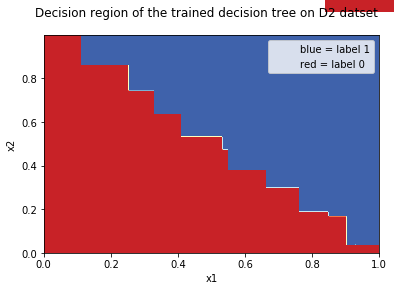

In [61]:
plot_step = 0.002
x_min, x_max = numpy_matrix[:, 0].min() , numpy_matrix[:, 0].max() 
y_min, y_max = numpy_matrix[:, 1].min() , numpy_matrix[:, 1].max() 
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
positions = np.vstack([xx.ravel(), yy.ravel()])
Z = test_accuracy(tree, xx.ravel(), yy.ravel())
Z = np.asarray(Z)
Z = Z.reshape(xx.shape)

plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)


cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

plt.xlabel('x1')
plt.ylabel('x2')

# # Plot the training points
# for i, color in zip(range(n_classes), plot_colors):
#     idx = np.where(y == i)
#     plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],
#                 cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision region of the trained decision tree on D2 datset")
#plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")

labels = ['blue = label 1', 'red = label 0']

#plt.legend(loc='upper right', labels)
plt.legend(labels)
plt.savefig('f2_6_d2.png')
plt.show()


In [207]:
d1_df = pd.read_csv("D1.txt", delim_whitespace=True, names=['x1', 'x2', 'y'])
numpy_matrix = d1_df.as_matrix()
tree = build_tree(numpy_matrix, 100, 1)




/u/a/b/abhayk/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


X1 >= 0.26419 Information Gain=0.00032
X1 >= 0.40950 Information Gain=0.00044
X1 >= 0.92622 Information Gain=0.00102
X1 >= 0.57369 Information Gain=0.00011
X1 >= 0.95316 Information Gain=0.00085
X1 >= 0.42233 Information Gain=0.00043
X1 >= 0.73399 Information Gain=0.00142
X1 >= 0.52893 Information Gain=0.00013
X1 >= 0.84451 Information Gain=0.00001
X1 >= 0.51663 Information Gain=0.00013
X1 >= 0.61336 Information Gain=0.00025
X1 >= 0.05193 Information Gain=0.00068
X1 >= 0.69308 Information Gain=0.00015
X1 >= 0.21846 Information Gain=0.00000
X1 >= 0.46262 Information Gain=0.00001
X1 >= 0.56544 Information Gain=0.00015
X1 >= 0.70977 Information Gain=0.00043
X1 >= 0.47619 Information Gain=0.00000
X1 >= 0.42859 Information Gain=0.00077
X1 >= 0.91643 Information Gain=0.00020
X1 >= 0.84690 Information Gain=0.00002
X1 >= 0.58605 Information Gain=0.00029
X1 >= 0.48366 Information Gain=0.00001
X1 >= 0.31846 Information Gain=0.00005
X1 >= 0.67999 Information Gain=0.00020
X1 >= 0.54618 Information

X1 >= 0.65683 Information Gain=0.00017
X1 >= 0.85007 Information Gain=0.00020
X1 >= 0.07401 Information Gain=0.00232
X1 >= 0.32309 Information Gain=0.00019
X1 >= 0.16492 Information Gain=0.00043
X1 >= 0.02764 Information Gain=0.00045
X1 >= 0.47745 Information Gain=0.00000
X1 >= 0.00581 Information Gain=0.00139
X1 >= 0.40768 Information Gain=0.00038
X1 >= 0.35827 Information Gain=0.00007
X1 >= 0.37566 Information Gain=0.00041
X1 >= 0.37405 Information Gain=0.00037
X1 >= 0.76440 Information Gain=0.00030
X1 >= 0.25570 Information Gain=0.00062
X1 >= 0.91417 Information Gain=0.00024
X1 >= 0.03054 Information Gain=0.00064
X1 >= 0.80449 Information Gain=0.00011
X1 >= 0.25772 Information Gain=0.00045
X1 >= 0.89922 Information Gain=0.00001
X1 >= 0.66007 Information Gain=0.00026
X1 >= 0.20439 Information Gain=0.00006
X1 >= 0.79837 Information Gain=0.00054
X1 >= 0.21097 Information Gain=0.00005
X1 >= 0.95870 Information Gain=0.00048
X1 >= 0.56460 Information Gain=0.00013
X1 >= 0.52691 Information

X1 >= 0.20937 Information Gain=0.00012
X1 >= 0.88706 Information Gain=0.00000
X1 >= 0.86469 Information Gain=0.00013
X1 >= 0.32407 Information Gain=0.00014
X1 >= 0.30742 Information Gain=0.00006
X1 >= 0.60763 Information Gain=0.00037
X1 >= 0.32256 Information Gain=0.00021
X1 >= 0.94954 Information Gain=0.00051
X1 >= 0.82401 Information Gain=0.00000
X1 >= 0.01752 Information Gain=0.00079
X1 >= 0.34264 Information Gain=0.00000
X1 >= 0.74979 Information Gain=0.00100
X1 >= 0.66058 Information Gain=0.00029
X1 >= 0.48130 Information Gain=0.00000
X1 >= 0.15407 Information Gain=0.00017
X1 >= 0.11600 Information Gain=0.00042
X1 >= 0.35977 Information Gain=0.00009
X1 >= 0.49693 Information Gain=0.00009
X1 >= 0.34694 Information Gain=0.00002
X1 >= 0.13069 Information Gain=0.00008
X1 >= 0.14358 Information Gain=0.00000
X1 >= 0.27707 Information Gain=0.00022
X1 >= 0.27131 Information Gain=0.00038
X1 >= 0.57027 Information Gain=0.00008
X1 >= 0.79120 Information Gain=0.00033
X1 >= 0.84045 Information

X2 >= 0.86147 Information Gain=0.04024
X2 >= 0.83710 Information Gain=0.05259
X2 >= 0.67705 Information Gain=0.11259
X2 >= 0.19855 Information Gain=0.63248
X2 >= 0.31358 Information Gain=0.37759
X2 >= 0.62142 Information Gain=0.14011
X2 >= 0.15232 Information Gain=0.45790
X2 >= 0.59760 Information Gain=0.15000
X2 >= 0.81844 Information Gain=0.06059
X2 >= 0.82716 Information Gain=0.05743
X2 >= 0.22210 Information Gain=0.56954
X2 >= 0.97424 Information Gain=0.00704
X2 >= 0.42369 Information Gain=0.26698
X2 >= 0.68645 Information Gain=0.10700
X2 >= 0.42680 Information Gain=0.26377
X2 >= 0.87882 Information Gain=0.03255
X2 >= 0.22653 Information Gain=0.54589
X2 >= 0.80432 Information Gain=0.06594
X2 >= 0.19463 Information Gain=0.60391
X2 >= 0.40771 Information Gain=0.27688
X2 >= 0.18344 Information Gain=0.56046
X2 >= 0.81020 Information Gain=0.06450
X2 >= 0.04920 Information Gain=0.17427
X2 >= 0.70690 Information Gain=0.09823
X2 >= 0.75435 Information Gain=0.08042
X2 >= 0.83505 Information

X2 >= 0.22623 Information Gain=0.55152
X2 >= 0.68447 Information Gain=0.10743
X2 >= 0.04293 Information Gain=0.13535
X2 >= 0.84546 Information Gain=0.04718
X2 >= 0.85433 Information Gain=0.04286
X2 >= 0.89472 Information Gain=0.02878
X2 >= 0.57113 Information Gain=0.16562
X2 >= 0.98661 Information Gain=0.00420
X2 >= 0.88645 Information Gain=0.03160
X2 >= 0.70103 Information Gain=0.09947
X2 >= 0.59120 Information Gain=0.15254
X2 >= 0.45086 Information Gain=0.24459
X2 >= 0.19195 Information Gain=0.59730
X2 >= 0.84235 Information Gain=0.05123
X2 >= 0.81478 Information Gain=0.06236
X2 >= 0.20873 Information Gain=0.64137
X2 >= 0.45454 Information Gain=0.24093
X2 >= 0.92922 Information Gain=0.01663
X2 >= 0.10340 Information Gain=0.32959
X2 >= 0.14683 Information Gain=0.43528
X2 >= 0.01781 Information Gain=0.04114
X2 >= 0.86633 Information Gain=0.03733
X2 >= 0.94358 Information Gain=0.01252
X2 >= 0.26937 Information Gain=0.44696
X2 >= 0.23011 Information Gain=0.53775
X2 >= 0.89075 Information

X2 >= 0.67801 Information Gain=0.11129
X2 >= 0.67272 Information Gain=0.11433
X2 >= 0.38644 Information Gain=0.29704
X2 >= 0.65786 Information Gain=0.12098
X2 >= 0.99525 Information Gain=0.00167
X2 >= 0.91132 Information Gain=0.02324
X2 >= 0.73598 Information Gain=0.08622
X2 >= 0.46621 Information Gain=0.23589
X2 >= 0.08498 Information Gain=0.27190
X2 >= 0.56047 Information Gain=0.17270
X2 >= 0.64419 Information Gain=0.12827
X2 >= 0.86783 Information Gain=0.03701
X2 >= 0.16500 Information Gain=0.49128
X2 >= 0.26667 Information Gain=0.45044
X2 >= 0.44191 Information Gain=0.25133
X2 >= 0.54997 Information Gain=0.17548
X2 >= 0.57287 Information Gain=0.16455
X2 >= 0.86250 Information Gain=0.03927
X2 >= 0.09740 Information Gain=0.31473
X2 >= 0.46084 Information Gain=0.23804
X2 >= 0.84244 Information Gain=0.05089
X2 >= 0.03766 Information Gain=0.11226
X2 >= 0.50113 Information Gain=0.21278
X2 >= 0.35931 Information Gain=0.32102
X2 >= 0.30149 Information Gain=0.39072
X2 >= 0.32813 Information

X2 >= 0.83607 Information Gain=0.05328
X2 >= 0.09186 Information Gain=0.29658
X2 >= 0.04532 Information Gain=0.14417
X2 >= 0.83502 Information Gain=0.05396
X2 >= 0.42293 Information Gain=0.26779
X2 >= 0.41741 Information Gain=0.27188
X2 >= 0.84825 Information Gain=0.04617
X2 >= 0.01221 Information Gain=0.02034
X2 >= 0.31967 Information Gain=0.36882
X2 >= 0.50949 Information Gain=0.20511
X2 >= 0.63942 Information Gain=0.13200
X2 >= 0.02515 Information Gain=0.07326
X2 >= 0.18015 Information Gain=0.53249
X2 >= 0.87784 Information Gain=0.03349
X2 >= 0.14750 Information Gain=0.43973
X2 >= 0.19956 Information Gain=0.64875
X2 >= 0.00921 Information Gain=0.00504
X2 >= 0.85109 Information Gain=0.04484
X2 >= 0.42420 Information Gain=0.26618
X2 >= 0.67758 Information Gain=0.11215
X2 >= 0.34585 Information Gain=0.33989
X2 >= 0.20257 Information Gain=0.66012
X2 >= 0.31439 Information Gain=0.37506
X2 >= 0.03670 Information Gain=0.10375
X2 >= 0.91019 Information Gain=0.02416
X2 >= 0.91081 Information

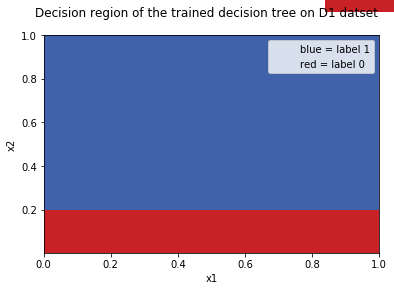

In [209]:

plot_step = 0.002
x_min, x_max = numpy_matrix[:, 0].min() , numpy_matrix[:, 0].max() 
y_min, y_max = numpy_matrix[:, 1].min() , numpy_matrix[:, 1].max() 
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
positions = np.vstack([xx.ravel(), yy.ravel()])
Z = test_accuracy(tree, xx.ravel(), yy.ravel())
Z = np.asarray(Z)
Z = Z.reshape(xx.shape)

plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)


cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

plt.xlabel('x1')
plt.ylabel('x2')


plt.suptitle("Decision region of the trained decision tree on D1 datset")
#plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")

labels = ['blue = label 1', 'red = label 0']

plt.legend(labels)
plt.savefig('f2_6_d1.png')
plt.show()


In [149]:
int(np.sqrt(x1.shape[0]))

1

/u/a/b/abhayk/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
No handles with labels found to put in legend.


31
(31, 31)
(31, 31)


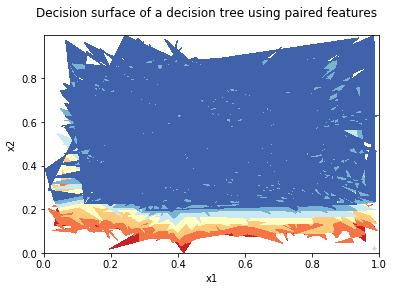

In [201]:
d2_df = pd.read_csv("D2.txt", delim_whitespace=True, names=['x1', 'x2', 'y'])
numpy_matrix = d2_df.as_matrix()


plot_step = 0.002
size = int(np.sqrt(numpy_matrix.shape[0]))

print (size)
x1 = numpy_matrix[:size*size, 0].reshape (size,size)
print(x1.shape)

x2 = numpy_matrix[:size*size, 1].reshape (size,size)
print(x2.shape)

Z = test_accuracy(tree, numpy_matrix[:size*size, 0], numpy_matrix[:size*size, 1])

Z = np.asarray(Z)
Z = Z.reshape(x1.shape)

plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)


cs = plt.contourf(x1, x2, Z, cmap=plt.cm.RdYlBu)

plt.xlabel('x1')
plt.ylabel('x2')

# # Plot the training points
# for i, color in zip(range(n_classes), plot_colors):
#     idx = np.where(y == i)
#     plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],
#                 cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")

plt.figure()
plt.show()

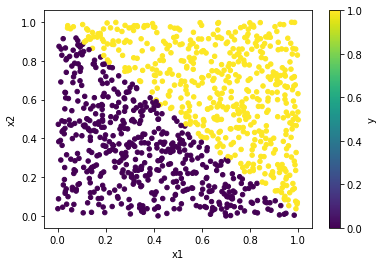

In [28]:
ax2 = d2_df.plot.scatter(x='x1',y='x2',c='y',colormap='viridis')

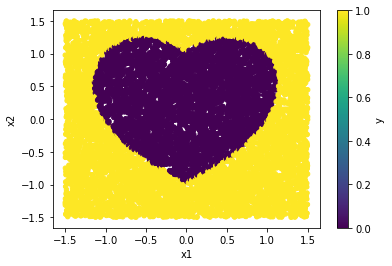

In [11]:
#q2.7
dbig_df = pd.read_csv("Dbig.txt", delim_whitespace=True, names=['x1', 'x2', 'y'])
ax2 = dbig_df.plot.scatter(x='x1',y='x2',c='y',colormap='viridis')

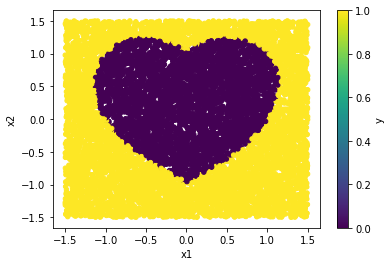

In [12]:
df_perm = dbig_df.sample(frac=1)
df_perm.to_csv('Dbig_perm.csv', index=False)
ax2 = df_perm.plot.scatter(x='x1',y='x2',c='y',colormap='viridis')

In [13]:
#perm = np.random.permutation(10000)
#perm[0:32]
numpy_matrix = df_perm.as_matrix()
d32 = numpy_matrix[ 0:32]
d128 = numpy_matrix[ 0:128]
d512 = numpy_matrix[ 0:512]
d2048 = numpy_matrix[ 0:2048]
d8192 = numpy_matrix[ 0:8192]
dtest = numpy_matrix[ 8192:]

b:\tenflow\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [34]:
dtest.shape

(1808, 3)

In [35]:
d32

array([[-0.984086, -0.977469,  1.      ],
       [-0.70348 , -0.107561,  0.      ],
       [ 0.376408, -0.514436,  0.      ],
       [ 0.400492,  1.18704 ,  0.      ],
       [ 0.535238, -0.088082,  0.      ],
       [-1.329203, -0.047892,  1.      ],
       [ 1.262899, -0.273608,  1.      ],
       [-1.089261, -1.460134,  1.      ],
       [ 0.15644 ,  1.329709,  1.      ],
       [-0.561759, -0.873386,  1.      ],
       [-0.26281 , -1.494543,  1.      ],
       [ 0.350553, -0.94135 ,  1.      ],
       [-0.283934,  0.511803,  0.      ],
       [-0.923198, -0.785011,  1.      ],
       [-0.454007,  1.226116,  0.      ],
       [-0.809032, -0.700238,  1.      ],
       [-0.513107, -1.434058,  1.      ],
       [-0.840853,  0.143983,  0.      ],
       [ 1.206852,  0.248296,  1.      ],
       [ 0.729006,  1.154976,  0.      ],
       [ 0.497511, -1.307278,  1.      ],
       [ 0.42656 , -0.189369,  0.      ],
       [-0.740684,  0.295134,  0.      ],
       [-1.180166, -0.193333,  1. 

In [23]:
tree32 = build_tree(d32, 10000, 1)
print_tree(tree32)

X1 >= 0.85063 Information Gain=0.01257
X1 >= -0.11878 Information Gain=0.05239
X1 >= -0.26110 Information Gain=0.08906
X1 >= -0.45934 Information Gain=0.06139
X1 >= 0.54005 Information Gain=0.00631
X1 >= -1.15454 Information Gain=0.02400
X1 >= 0.09207 Information Gain=0.02647
X1 >= -0.83666 Information Gain=0.04358
X1 >= 0.79252 Information Gain=0.02543
X1 >= 0.18151 Information Gain=0.02045
X1 >= -0.44620 Information Gain=0.08418
X1 >= 1.12763 Information Gain=0.01101
X1 >= 0.27852 Information Gain=0.01569
X1 >= 1.20753 Information Gain=0.07525
X1 >= 1.30131 Information Gain=0.02400
X1 >= -0.75426 Information Gain=0.06471
X1 >= -0.88302 Information Gain=0.13157
X1 >= 0.22481 Information Gain=0.00019
X1 >= 1.23308 Information Gain=0.04905
X1 >= 1.11670 Information Gain=0.00002
X1 >= -0.33179 Information Gain=0.11025
X1 >= 0.27166 Information Gain=0.00286
X1 >= -1.44886 Information Gain=0.00000
X1 >= -0.55056 Information Gain=0.04179
X1 >= -0.98469 Information Gain=0.07525
X1 >= -0.2926

In [34]:
test_accuracy1(tree32 ,dtest)

prediction error
247


In [47]:
#nodes = 13 // 9

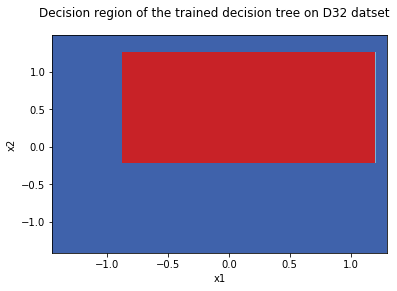

In [38]:
plot_step = 0.002
x_min, x_max = numpy_matrix[0:32, 0].min() , numpy_matrix[0:32, 0].max() 
y_min, y_max = numpy_matrix[0:32, 1].min() , numpy_matrix[0:32, 1].max() 
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
positions = np.vstack([xx.ravel(), yy.ravel()])
Z = test_accuracy(tree32, xx.ravel(), yy.ravel())
Z = np.asarray(Z)
Z = Z.reshape(xx.shape)

plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)


cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

plt.xlabel('x1')
plt.ylabel('x2')

plt.suptitle("Decision region of the trained decision tree on D32 datset")
#plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")

#labels = ['blue = label 1', 'red = label 0']

#plt.legend(loc='upper right', labels)
#plt.legend(labels)
plt.savefig('f3_d32.png')
plt.show()


In [35]:
tree128 = build_tree(d128, 10000, 1)
print_tree(tree128)

X1 >= 0.85063 Information Gain=0.08437
X1 >= -0.11878 Information Gain=0.00019
X1 >= -0.26110 Information Gain=0.00218
X1 >= -0.45934 Information Gain=0.01707
X1 >= 0.54005 Information Gain=0.04772
X1 >= -1.15454 Information Gain=0.06683
X1 >= 0.09207 Information Gain=0.00001
X1 >= -0.83666 Information Gain=0.07621
X1 >= 0.79252 Information Gain=0.09685
X1 >= 0.18151 Information Gain=0.00466
X1 >= -0.44620 Information Gain=0.01799
X1 >= 1.12763 Information Gain=0.07850
X1 >= 0.27852 Information Gain=0.01449
X1 >= 1.20753 Information Gain=0.06683
X1 >= 1.30131 Information Gain=0.04160
X1 >= -0.75426 Information Gain=0.05413
X1 >= -0.88302 Information Gain=0.08816
X1 >= 0.22481 Information Gain=0.00824
X1 >= 1.23308 Information Gain=0.05407
X1 >= 1.11670 Information Gain=0.05822
X1 >= -0.33179 Information Gain=0.01063
X1 >= 0.27166 Information Gain=0.01063
X1 >= -1.44886 Information Gain=0.00000
X1 >= -0.55056 Information Gain=0.01623
X1 >= -0.98469 Information Gain=0.12100
X1 >= -0.2926

X2 >= 0.77569 Information Gain=0.10028
X2 >= -0.23141 Information Gain=0.03692
X2 >= 1.13432 Information Gain=0.14654
X2 >= 0.56841 Information Gain=0.01951
X2 >= 0.32139 Information Gain=0.00027
X2 >= 0.07220 Information Gain=0.00749
X2 >= 1.47655 Information Gain=0.01896
X2 >= 0.68898 Information Gain=0.06041
X1 >= 0.85063 Information Gain=0.01333
X1 >= 0.79252 Information Gain=0.00000
X1 >= 1.12763 Information Gain=0.03926
X1 >= 1.20753 Information Gain=0.07891
X1 >= 1.30131 Information Gain=0.04324
X1 >= 1.23308 Information Gain=0.06022
X1 >= 1.11670 Information Gain=0.00282
X1 >= 0.99361 Information Gain=0.02918
X1 >= 1.18023 Information Gain=0.09971
X1 >= 1.35689 Information Gain=0.02036
X1 >= 1.17265 Information Gain=0.11105
X1 >= 1.39116 Information Gain=0.01333
X1 >= 1.22728 Information Gain=0.06933
X1 >= 1.10522 Information Gain=0.00562
X1 >= 0.94108 Information Gain=0.00206
X1 >= 1.04499 Information Gain=0.02101
X1 >= 0.93932 Information Gain=0.00561
X1 >= 1.15876 Informatio

In [33]:
test_accuracy1(tree128 ,dtest)

prediction error
171


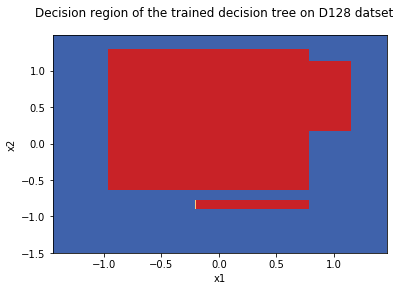

In [39]:
plot_step = 0.002
x_min, x_max = numpy_matrix[0:128, 0].min() , numpy_matrix[0:128, 0].max() 
y_min, y_max = numpy_matrix[0:128, 1].min() , numpy_matrix[0:128, 1].max() 
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
positions = np.vstack([xx.ravel(), yy.ravel()])
Z = test_accuracy(tree128, xx.ravel(), yy.ravel())
Z = np.asarray(Z)
Z = Z.reshape(xx.shape)

plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)


cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

plt.xlabel('x1')
plt.ylabel('x2')

plt.suptitle("Decision region of the trained decision tree on D128 datset")
#plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")

#labels = ['blue = label 1', 'red = label 0']

#plt.legend(loc='upper right', labels)
#plt.legend(labels)
plt.savefig('f3_d128.png')
plt.show()


In [ ]:
#nodes = 17  // 21

In [40]:
tree512 = build_tree(d512, 10000, 1)
print_tree(tree512)

X1 >= 0.85063 Information Gain=0.05840
X1 >= -0.11878 Information Gain=0.00219
X1 >= -0.26110 Information Gain=0.00387
X1 >= -0.45934 Information Gain=0.01749
X1 >= 0.54005 Information Gain=0.02614
X1 >= -1.15454 Information Gain=0.08520
X1 >= 0.09207 Information Gain=0.00012
X1 >= -0.83666 Information Gain=0.04668
X1 >= 0.79252 Information Gain=0.05251
X1 >= 0.18151 Information Gain=0.00476
X1 >= -0.44620 Information Gain=0.01621
X1 >= 1.12763 Information Gain=0.09428
X1 >= 0.27852 Information Gain=0.00792
X1 >= 1.20753 Information Gain=0.07993
X1 >= 1.30131 Information Gain=0.05764
X1 >= -0.75426 Information Gain=0.04133
X1 >= -0.88302 Information Gain=0.05145
X1 >= 0.22481 Information Gain=0.00645
X1 >= 1.23308 Information Gain=0.07298
X1 >= 1.11670 Information Gain=0.07851
X1 >= -0.33179 Information Gain=0.00933
X1 >= 0.27166 Information Gain=0.00723
X1 >= -1.44886 Information Gain=0.01077
X1 >= -0.55056 Information Gain=0.02352
X1 >= -0.98469 Information Gain=0.07092
X1 >= -0.2926

X1 >= 0.99567 Information Gain=0.07096
X1 >= -0.58854 Information Gain=0.02066
X1 >= 0.21647 Information Gain=0.00508
X1 >= 1.33536 Information Gain=0.04269
X1 >= 1.41401 Information Gain=0.01702
X1 >= -0.68431 Information Gain=0.02836
X1 >= -1.27023 Information Gain=0.06101
X1 >= 0.75214 Information Gain=0.04097
X1 >= 0.34411 Information Gain=0.00730
X1 >= 0.60034 Information Gain=0.03796
X1 >= 1.04724 Information Gain=0.06313
X1 >= 0.34270 Information Gain=0.00663
X1 >= 0.70359 Information Gain=0.04182
X1 >= -0.10412 Information Gain=0.00183
X1 >= -0.45537 Information Gain=0.01826
X1 >= 1.28982 Information Gain=0.06271
X1 >= 1.09235 Information Gain=0.07391
X1 >= -0.22350 Information Gain=0.00279
X1 >= 0.77218 Information Gain=0.05000
X1 >= -0.00734 Information Gain=0.00032
X1 >= 0.16298 Information Gain=0.00283
X1 >= 1.18134 Information Gain=0.09051
X1 >= -1.13431 Information Gain=0.09051
X1 >= 0.04052 Information Gain=0.00008
X1 >= 1.31513 Information Gain=0.05261
X1 >= -0.55923 In

X2 >= -0.41867 Information Gain=0.13101
X2 >= -0.20707 Information Gain=0.09255
X2 >= 1.12362 Information Gain=0.06014
X2 >= 0.91250 Information Gain=0.02492
X2 >= -0.15287 Information Gain=0.08678
X2 >= -1.01444 Information Gain=0.13487
X2 >= 0.65992 Information Gain=0.00041
X2 >= -1.37476 Information Gain=0.03293
X2 >= 0.87485 Information Gain=0.01807
X2 >= -0.87719 Information Gain=0.15667
X2 >= -0.25777 Information Gain=0.09261
X2 >= -1.48784 Information Gain=0.00613
X2 >= -0.35382 Information Gain=0.11621
X2 >= 1.32226 Information Gain=0.06101
X2 >= 1.12625 Information Gain=0.05862
X2 >= -1.15789 Information Gain=0.09408
X2 >= 1.10575 Information Gain=0.05858
X2 >= -0.82567 Information Gain=0.17297
X2 >= -0.85907 Information Gain=0.16476
X2 >= 0.63413 Information Gain=0.00179
X2 >= -0.08950 Information Gain=0.07578
X2 >= 0.89121 Information Gain=0.01965
X2 >= -0.27813 Information Gain=0.09212
X2 >= -1.34574 Information Gain=0.04269
X2 >= -0.86971 Information Gain=0.16070
X2 >= 1.3

X2 >= 0.29313 Information Gain=0.02130
X2 >= -1.03856 Information Gain=0.12346
X2 >= 1.48541 Information Gain=0.00768
X2 >= 1.06607 Information Gain=0.05611
X2 >= -0.26748 Information Gain=0.08933
X2 >= 0.85965 Information Gain=0.01740
X2 >= -0.28556 Information Gain=0.09049
X2 >= -0.00903 Information Gain=0.05984
X2 >= -0.31149 Information Gain=0.10357
X2 >= 0.45744 Information Gain=0.01349
X2 >= 0.62608 Information Gain=0.00256
X2 >= 0.95527 Information Gain=0.03584
X2 >= -0.12941 Information Gain=0.08077
X2 >= 1.16111 Information Gain=0.06208
X2 >= 0.65341 Information Gain=0.00088
X2 >= 0.46411 Information Gain=0.01239
X2 >= -0.63562 Information Gain=0.18663
X2 >= 1.19779 Information Gain=0.06214
X2 >= -0.31539 Information Gain=0.10672
X2 >= -0.00686 Information Gain=0.05921
X2 >= 0.74898 Information Gain=0.00273
X2 >= 1.07074 Information Gain=0.06023
X2 >= 0.57490 Information Gain=0.00579
X2 >= 0.81048 Information Gain=0.00870
X2 >= 0.29082 Information Gain=0.02274
X2 >= -1.46484 I

X1 >= -1.16393 Information Gain=0.13626
X1 >= 1.08416 Information Gain=0.13031
X1 >= -1.32608 Information Gain=0.08091
X1 >= 1.47499 Information Gain=0.00320
X1 >= -0.72665 Information Gain=0.06194
X1 >= -0.63548 Information Gain=0.04136
X2 >= -0.22777 Information Gain=0.00007
X2 >= 0.93918 Information Gain=0.12289
X2 >= 0.77279 Information Gain=0.07020
X2 >= 0.45913 Information Gain=0.01134
X2 >= 0.59004 Information Gain=0.01655
X2 >= -0.48839 Information Gain=0.00015
X2 >= 0.07143 Information Gain=0.00145
X2 >= 1.48278 Information Gain=0.01943
X2 >= 0.67021 Information Gain=0.03332
X2 >= 1.43072 Information Gain=0.07383
X2 >= 0.29136 Information Gain=0.00949
X2 >= 0.52006 Information Gain=0.01279
X2 >= 0.36340 Information Gain=0.00953
X2 >= 0.06392 Information Gain=0.00086
X2 >= 0.50153 Information Gain=0.01124
X2 >= 0.34454 Information Gain=0.00900
X2 >= 0.90543 Information Gain=0.11030
X2 >= 1.26682 Information Gain=0.15960
X2 >= 1.39602 Information Gain=0.09166
X2 >= 0.57913 Infor

X1 >= -1.44671 Information Gain=0.03409
X1 >= -0.66046 Information Gain=0.12031
X1 >= 0.95484 Information Gain=0.00763
X1 >= 0.15745 Information Gain=0.01664
X1 >= 0.86275 Information Gain=0.00655
X1 >= -0.32847 Information Gain=0.06270
X1 >= 0.53289 Information Gain=0.00037
X1 >= 0.76724 Information Gain=0.00341
X1 >= 0.87580 Information Gain=0.00896
X1 >= 1.01168 Information Gain=0.00731
X1 >= -0.17433 Information Gain=0.04307
X1 >= -0.92853 Information Gain=0.19292
X1 >= -0.89616 Information Gain=0.17342
X1 >= -0.62720 Information Gain=0.12169
X1 >= -1.01547 Information Gain=0.23876
X1 >= 0.03474 Information Gain=0.02686
X1 >= 0.65561 Information Gain=0.00153
X1 >= -1.48809 Information Gain=0.00479
X1 >= 0.98109 Information Gain=0.00572
X1 >= 0.06035 Information Gain=0.02805
X1 >= 0.82914 Information Gain=0.00657
X1 >= 0.48320 Information Gain=0.00208
X1 >= -1.36807 Information Gain=0.10667
X1 >= -0.41747 Information Gain=0.08339
X1 >= 0.17365 Information Gain=0.01202
X1 >= -1.21630

X1 >= 1.04218 Information Gain=0.00057
X1 >= -1.16306 Information Gain=0.22275
X1 >= -1.11829 Information Gain=0.25456
X1 >= 0.08457 Information Gain=0.02803
X1 >= -0.09748 Information Gain=0.03968
X1 >= -0.84047 Information Gain=0.16766
X1 >= -1.38270 Information Gain=0.09059
X1 >= -0.69616 Information Gain=0.12631
X1 >= -0.88390 Information Gain=0.16179
X1 >= 0.45135 Information Gain=0.00339
X1 >= -0.62206 Information Gain=0.11967
X1 >= 0.00907 Information Gain=0.02954
X1 >= -0.37096 Information Gain=0.07142
X1 >= 0.54275 Information Gain=0.00010
X1 >= 1.04876 Information Gain=0.00083
X1 >= -0.89183 Information Gain=0.16748
X1 >= -1.01420 Information Gain=0.24525
X1 >= -0.94434 Information Gain=0.20007
X1 >= -0.82430 Information Gain=0.15229
X1 >= -0.36116 Information Gain=0.06917
X1 >= -0.70678 Information Gain=0.12893
X1 >= -0.77660 Information Gain=0.14899
X1 >= 0.59242 Information Gain=0.00009
X1 >= 0.46282 Information Gain=0.00248
X1 >= 0.77063 Information Gain=0.00487
X1 >= 0.5

X2 >= 0.14583 Information Gain=0.00074
X2 >= 0.67329 Information Gain=0.04509
X2 >= 1.23982 Information Gain=0.18617
X2 >= 0.96680 Information Gain=0.15105
X2 >= 1.48571 Information Gain=0.01931
X2 >= 0.69998 Information Gain=0.05341
X2 >= 1.37916 Information Gain=0.10128
X2 >= 0.60498 Information Gain=0.02717
X2 >= 1.02390 Information Gain=0.19292
X2 >= -0.09861 Information Gain=0.00025
X2 >= 1.32921 Information Gain=0.14547
X2 >= 1.04862 Information Gain=0.19402
X2 >= -0.46812 Information Gain=0.00399
X2 >= 1.44837 Information Gain=0.06960
X2 >= 0.41249 Information Gain=0.01397
X2 >= -0.29643 Information Gain=0.00054
X2 >= 0.81441 Information Gain=0.09382
X2 >= 0.34953 Information Gain=0.00977
X2 >= 1.33366 Information Gain=0.13981
X2 >= 1.33708 Information Gain=0.12862
X2 >= 0.18243 Information Gain=0.00304
X2 >= -0.20182 Information Gain=0.00108
X2 >= -0.30086 Information Gain=0.00116
X2 >= 0.82823 Information Gain=0.09699
X2 >= 1.28176 Information Gain=0.17433
X2 >= 1.30229 Inform

X1 >= 0.16887 Information Gain=0.00490
X1 >= -0.41726 Information Gain=0.00146
X1 >= 0.62081 Information Gain=0.02228
X1 >= 0.92081 Information Gain=0.03609
X1 >= -0.48524 Information Gain=0.00387
X1 >= -0.41136 Information Gain=0.00118
X1 >= 0.01440 Information Gain=0.00232
X1 >= -0.24785 Information Gain=0.00131
X1 >= -0.33386 Information Gain=0.00013
X1 >= 0.55499 Information Gain=0.01517
X1 >= 0.03669 Information Gain=0.00219
X1 >= 0.44462 Information Gain=0.00969
X1 >= 0.51126 Information Gain=0.01209
X1 >= -0.40372 Information Gain=0.00092
X1 >= 0.99567 Information Gain=0.02013
X1 >= 0.21647 Information Gain=0.00374
X1 >= -0.68431 Information Gain=0.00347
X1 >= 0.75214 Information Gain=0.02808
X1 >= 0.34411 Information Gain=0.00258
X1 >= 0.60034 Information Gain=0.02097
X1 >= 1.04724 Information Gain=0.00001
X1 >= 0.34270 Information Gain=0.00223
X1 >= 0.70359 Information Gain=0.02569
X1 >= -0.10412 Information Gain=0.00063
X1 >= -0.45537 Information Gain=0.00248
X1 >= 1.09235 In

X2 >= -0.35243 Information Gain=0.00210
X2 >= -0.11927 Information Gain=0.00336
X2 >= 0.74096 Information Gain=0.09370
X2 >= 0.67702 Information Gain=0.06456
X2 >= -0.61088 Information Gain=0.00002
X2 >= 0.65361 Information Gain=0.05185
X2 >= 0.61582 Information Gain=0.03941
X2 >= 0.07732 Information Gain=0.00083
X2 >= 0.48017 Information Gain=0.02024
X2 >= 0.98654 Information Gain=0.22081
X2 >= -0.17943 Information Gain=0.00503
X2 >= 0.15589 Information Gain=0.00001
X2 >= 0.75295 Information Gain=0.09895
X2 >= 1.14549 Information Gain=0.25877
X2 >= -0.52668 Information Gain=0.00271
X2 >= 0.29313 Information Gain=0.00445
X2 >= 1.48541 Information Gain=0.03967
X2 >= 1.06607 Information Gain=0.25355
X2 >= -0.26748 Information Gain=0.00094
X2 >= -0.31149 Information Gain=0.00354
X2 >= 0.45744 Information Gain=0.01478
X2 >= 0.62608 Information Gain=0.04233
X2 >= -0.12941 Information Gain=0.00441
X2 >= 1.16111 Information Gain=0.26011
X2 >= 0.65341 Information Gain=0.05018
X2 >= 0.46411 Inf

X1 >= -0.86138 Information Gain=0.01325
X1 >= 0.00083 Information Gain=0.00353
X1 >= 0.74223 Information Gain=0.08053
X1 >= 0.30799 Information Gain=0.02757
X1 >= 1.04218 Information Gain=0.01818
X1 >= 0.08457 Information Gain=0.00762
X1 >= -0.09748 Information Gain=0.00181
X1 >= -0.84047 Information Gain=0.01745
X1 >= -0.69616 Information Gain=0.01164
X1 >= -0.88390 Information Gain=0.00515
X1 >= 0.45135 Information Gain=0.04574
X1 >= -0.62206 Information Gain=0.00708
X1 >= 0.00907 Information Gain=0.00387
X1 >= -0.37096 Information Gain=0.00081
X1 >= 0.54275 Information Gain=0.06006
X1 >= 1.04876 Information Gain=0.00225
X1 >= -0.89183 Information Gain=0.00601
X1 >= -1.01420 Information Gain=0.01398
X1 >= -0.94434 Information Gain=0.01217
X1 >= -0.82430 Information Gain=0.01350
X1 >= -0.36116 Information Gain=0.00064
X1 >= -0.70678 Information Gain=0.01353
X1 >= -0.77660 Information Gain=0.01509
X1 >= 0.59242 Information Gain=0.07101
X1 >= 0.46282 Information Gain=0.04845
X1 >= 0.770

X1 >= 0.93874 Information Gain=0.02976
X1 >= 0.98960 Information Gain=0.00114
X1 >= 1.12328 Information Gain=0.02704
X1 >= 1.03017 Information Gain=0.00189
X1 >= 0.90164 Information Gain=0.04762
X1 >= 0.87898 Information Gain=0.03556
X1 >= 1.07899 Information Gain=0.08771
X1 >= 0.79849 Information Gain=0.00000
X1 >= 1.04876 Information Gain=0.01573
X1 >= 1.08416 Information Gain=0.07160
X2 >= 0.67021 Information Gain=0.05377
X2 >= 0.34454 Information Gain=0.00267
X2 >= 0.16454 Information Gain=0.02406
X2 >= -0.08689 Information Gain=0.00162
X2 >= 1.14132 Information Gain=0.18747
X2 >= 1.17514 Information Gain=0.05822
X2 >= 1.13432 Information Gain=0.26022
X2 >= 0.32139 Information Gain=0.00044
X2 >= 0.53122 Information Gain=0.01998
X2 >= -0.14320 Information Gain=0.02704
X2 >= 0.51465 Information Gain=0.01247
X2 >= 0.38442 Information Gain=0.00670
X2 >= 1.12362 Information Gain=0.34009
X2 >= 0.91250 Information Gain=0.16450
X2 >= 0.65992 Information Gain=0.04049
X2 >= 0.89121 Informati

X2 >= -0.24086 Information Gain=0.02513
X2 >= -0.13610 Information Gain=0.01963
X2 >= 0.58521 Information Gain=0.00068
X1 >= -0.11878 Information Gain=0.00006
X1 >= -0.26110 Information Gain=0.00001
X1 >= 0.54005 Information Gain=0.00225
X1 >= 0.09207 Information Gain=0.00122
X1 >= 0.18151 Information Gain=0.00354
X1 >= -0.75426 Information Gain=0.00000
X1 >= 0.22481 Information Gain=0.00448
X1 >= 0.27166 Information Gain=0.00512
X1 >= -0.29260 Information Gain=0.00025
X1 >= 0.22303 Information Gain=0.00428
X1 >= 0.15681 Information Gain=0.00243
X1 >= 0.78560 Information Gain=0.00017
X1 >= 0.41378 Information Gain=0.00857
X1 >= -0.59219 Information Gain=0.00299
X1 >= 0.30012 Information Gain=0.00534
X1 >= -0.70775 Information Gain=0.00085
X1 >= -0.45356 Information Gain=0.00205
X1 >= 0.44496 Information Gain=0.00993
X1 >= -0.27016 Information Gain=0.00004
X1 >= 0.53514 Information Gain=0.00205
X1 >= 0.37641 Information Gain=0.00766
X1 >= 0.13337 Information Gain=0.00177
X1 >= -0.62222 

X2 >= -0.03286 Information Gain=0.00000
X2 >= 0.33570 Information Gain=0.07043
X2 >= 0.37278 Information Gain=0.09572
X2 >= 0.28702 Information Gain=0.03736
X2 >= 0.72792 Information Gain=0.21992
X2 >= 0.54068 Information Gain=0.12443
X2 >= 0.62759 Information Gain=0.17643
X2 >= 0.65602 Information Gain=0.19706
X2 >= 0.45450 Information Gain=0.10959
X2 >= 0.77460 Information Gain=0.30889
X2 >= 0.14308 Information Gain=0.01786
X2 >= 0.85320 Information Gain=0.40112
X2 >= 0.29126 Information Gain=0.05882
X2 >= 0.12566 Information Gain=0.00874
X2 >= 0.14583 Information Gain=0.02739
X2 >= 1.02390 Information Gain=0.47150
X2 >= 0.75295 Information Gain=0.27483
X2 >= 1.14549 Information Gain=0.38307
X2 >= 0.62608 Information Gain=0.15764
X2 >= 1.16111 Information Gain=0.23280
X2 >= 0.74898 Information Gain=0.24558
X2 >= 0.57490 Information Gain=0.14039
X2 >= 0.81048 Information Gain=0.34976
X2 >= 0.29082 Information Gain=0.04782
X2 >= 1.20052 Information Gain=0.10835
X1 >= -1.01547 Informati

[X2 >= -0.64815]
  [X1 >= 1.13579]
    [label = 1.0]
    [X1 >= -1.10845]
      [X2 >= 1.21220]
        [label = 1.0]
        [X1 >= 0.79252]
          [X2 >= -0.19177]
            [X2 >= 1.04862]
              [label = 1.0]
              [X2 >= 0.05696]
                [label = 0.0]
                [X1 >= 1.01168]
                  [label = 1.0]
                  [label = 0.0]
            [label = 1.0]
          [X1 >= -0.75426]
            [X2 >= -0.51444]
              [label = 0.0]
              [X1 >= -0.33840]
                [X1 >= 0.48506]
                  [X1 >= 0.65561]
                    [label = 1.0]
                    [X1 >= 0.49289]
                      [label = 0.0]
                      [label = 1.0]
                  [label = 0.0]
                [label = 1.0]
            [X2 >= -0.03286]
              [X2 >= 1.07539]
                [label = 1.0]
                [label = 0.0]
              [X1 >= -0.82465]
                [X1 >= -0.79490]
                  [label 

In [42]:
test_accuracy1(tree512 ,dtest)

prediction error
65


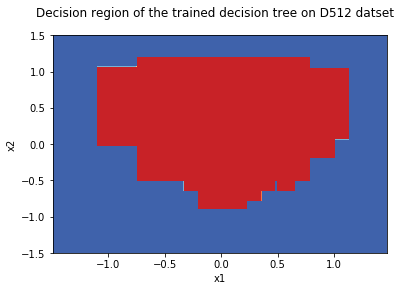

In [49]:
plot_step = 0.002
x_min, x_max = numpy_matrix[0:512, 0].min() , numpy_matrix[0:512, 0].max() 
y_min, y_max = numpy_matrix[0:512, 1].min() , numpy_matrix[0:512, 1].max() 
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
positions = np.vstack([xx.ravel(), yy.ravel()])
Z = test_accuracy(tree512, xx.ravel(), yy.ravel())
Z = np.asarray(Z)
Z = Z.reshape(xx.shape)

plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)


cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

plt.xlabel('x1')
plt.ylabel('x2')

plt.suptitle("Decision region of the trained decision tree on D512 datset")
#plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")

#labels = ['blue = label 1', 'red = label 0']

#plt.legend(loc='upper right', labels)
#plt.legend(labels)
plt.savefig('f3_d512.png')
plt.show()


In [ ]:
#nodes = 43 // 49

In [52]:
tree2048 = build_tree(d2048, 10000, 1)
print_tree(tree2048)

X1 >= 0.85063 Information Gain=0.06274
X1 >= -0.11878 Information Gain=0.00283
X1 >= -0.26110 Information Gain=0.00744
X1 >= -0.45934 Information Gain=0.02031
X1 >= 0.54005 Information Gain=0.02374
X1 >= -1.15454 Information Gain=0.09769
X1 >= 0.09207 Information Gain=0.00024
X1 >= -0.83666 Information Gain=0.05979
X1 >= 0.79252 Information Gain=0.05583
X1 >= 0.18151 Information Gain=0.00271
X1 >= -0.44620 Information Gain=0.01854
X1 >= 1.12763 Information Gain=0.09233
X1 >= 0.27852 Information Gain=0.00507
X1 >= 1.20753 Information Gain=0.07652
X1 >= 1.30131 Information Gain=0.05325
X1 >= -0.75426 Information Gain=0.04887
X1 >= -0.88302 Information Gain=0.06631
X1 >= 0.22481 Information Gain=0.00323
X1 >= 1.23308 Information Gain=0.06852
X1 >= 1.11670 Information Gain=0.08572
X1 >= -0.33179 Information Gain=0.01148
X1 >= 0.27166 Information Gain=0.00493
X1 >= -1.44886 Information Gain=0.01390
X1 >= -0.55056 Information Gain=0.02618
X1 >= -0.98469 Information Gain=0.08523
X1 >= -0.2926

X1 >= -0.31209 Information Gain=0.00962
X1 >= -1.12206 Information Gain=0.10157
X1 >= -1.10845 Information Gain=0.10692
X1 >= 1.14690 Information Gain=0.09330
X1 >= 1.32854 Information Gain=0.04597
X1 >= 1.24828 Information Gain=0.06560
X1 >= -0.98840 Information Gain=0.08624
X1 >= 1.43336 Information Gain=0.01428
X1 >= -1.43030 Information Gain=0.01887
X1 >= -0.83503 Information Gain=0.06014
X1 >= 0.40504 Information Gain=0.01139
X1 >= 0.83101 Information Gain=0.05870
X1 >= -0.68058 Information Gain=0.03909
X1 >= 0.07360 Information Gain=0.00005
X1 >= 0.42854 Information Gain=0.01369
X1 >= 0.82416 Information Gain=0.05672
X1 >= 0.57540 Information Gain=0.03002
X1 >= 0.86835 Information Gain=0.06364
X1 >= 0.43071 Information Gain=0.01394
X1 >= 1.34520 Information Gain=0.04116
X1 >= 1.38872 Information Gain=0.02932
X1 >= -0.09858 Information Gain=0.00216
X1 >= -1.09825 Information Gain=0.10275
X1 >= 0.76104 Information Gain=0.04878
X1 >= 0.34906 Information Gain=0.00756
X1 >= 0.49311 In

X1 >= 1.34721 Information Gain=0.04076
X1 >= -1.01420 Information Gain=0.09119
X1 >= -0.94434 Information Gain=0.07011
X1 >= -0.82430 Information Gain=0.05858
X1 >= 0.87443 Information Gain=0.06379
X1 >= -0.36116 Information Gain=0.01231
X1 >= -0.70678 Information Gain=0.04322
X1 >= -0.77660 Information Gain=0.05005
X1 >= 0.59242 Information Gain=0.03155
X1 >= 0.46282 Information Gain=0.01662
X1 >= 0.77063 Information Gain=0.05246
X1 >= 1.33004 Information Gain=0.04516
X1 >= 0.05918 Information Gain=0.00000
X1 >= -0.91690 Information Gain=0.06869
X1 >= 0.51601 Information Gain=0.02040
X1 >= 0.63049 Information Gain=0.03992
X1 >= 1.39492 Information Gain=0.02621
X1 >= 0.98737 Information Gain=0.08096
X1 >= 0.21824 Information Gain=0.00308
X1 >= 0.66138 Information Gain=0.04348
X1 >= 0.02091 Information Gain=0.00003
X1 >= 0.03440 Information Gain=0.00000
X1 >= 0.53486 Information Gain=0.02138
X1 >= 0.03968 Information Gain=0.00001
X1 >= 0.55858 Information Gain=0.02863
X1 >= 0.34709 Info

X1 >= 0.00790 Information Gain=0.00009
X1 >= 0.77513 Information Gain=0.05319
X1 >= -1.06391 Information Gain=0.09952
X1 >= 1.17385 Information Gain=0.08636
X1 >= -1.09452 Information Gain=0.10151
X1 >= 0.40548 Information Gain=0.01162
X1 >= -0.17544 Information Gain=0.00458
X1 >= 0.51741 Information Gain=0.02072
X1 >= 1.12372 Information Gain=0.09006
X1 >= 0.91380 Information Gain=0.06711
X1 >= 0.46231 Information Gain=0.01634
X1 >= -0.21914 Information Gain=0.00560
X1 >= -0.59981 Information Gain=0.02898
X1 >= 1.34888 Information Gain=0.04037
X1 >= 1.19171 Information Gain=0.08078
X1 >= 0.16514 Information Gain=0.00225
X1 >= -0.33478 Information Gain=0.01164
X1 >= 0.54134 Information Gain=0.02447
X1 >= 0.35530 Information Gain=0.00793
X1 >= -1.03603 Information Gain=0.09571
X1 >= -0.37898 Information Gain=0.01332
X1 >= 0.99916 Information Gain=0.08583
X1 >= -0.33708 Information Gain=0.01173
X1 >= 1.40756 Information Gain=0.02311
X1 >= 1.20105 Information Gain=0.07822
X1 >= 0.45397 In

X1 >= 1.36638 Information Gain=0.03561
X1 >= 0.54387 Information Gain=0.02558
X1 >= 1.27914 Information Gain=0.05816
X1 >= -0.96175 Information Gain=0.07641
X1 >= -1.09797 Information Gain=0.10319
X1 >= -1.35871 Information Gain=0.04156
X1 >= -0.61497 Information Gain=0.03272
X1 >= -0.61768 Information Gain=0.03267
X1 >= -1.26484 Information Gain=0.06477
X1 >= -0.23678 Information Gain=0.00623
X1 >= 1.21844 Information Gain=0.07314
X1 >= -0.63505 Information Gain=0.03417
X1 >= -0.70946 Information Gain=0.04410
X1 >= -0.24993 Information Gain=0.00691
X1 >= 0.68537 Information Gain=0.04305
X1 >= -0.75117 Information Gain=0.04757
X1 >= -1.41636 Information Gain=0.02427
X1 >= 0.78804 Information Gain=0.05504
X1 >= -1.10534 Information Gain=0.10466
X1 >= 0.64526 Information Gain=0.04166
X1 >= 0.49813 Information Gain=0.01840
X1 >= -0.04974 Information Gain=0.00068
X1 >= 0.16667 Information Gain=0.00245
X1 >= -0.42362 Information Gain=0.01729
X1 >= 0.75055 Information Gain=0.04684
X1 >= -0.9

X1 >= -1.22644 Information Gain=0.07398
X1 >= 1.35495 Information Gain=0.03877
X1 >= 0.84351 Information Gain=0.06029
X1 >= 0.89894 Information Gain=0.06408
X1 >= 0.69875 Information Gain=0.04246
X1 >= 1.19310 Information Gain=0.07992
X1 >= -0.08228 Information Gain=0.00138
X1 >= 1.30727 Information Gain=0.05203
X1 >= -1.43019 Information Gain=0.01964
X1 >= -1.06465 Information Gain=0.09908
X1 >= 1.41163 Information Gain=0.02156
X1 >= -0.47815 Information Gain=0.01850
X1 >= 1.24442 Information Gain=0.06643
X1 >= 0.54857 Information Gain=0.02650
X1 >= 0.74258 Information Gain=0.04590
X1 >= 0.03174 Information Gain=0.00000
X1 >= -1.25066 Information Gain=0.06894
X1 >= -1.31585 Information Gain=0.05284
X1 >= 0.04395 Information Gain=0.00002
X1 >= -0.77826 Information Gain=0.04942
X1 >= 0.13504 Information Gain=0.00074
X1 >= 1.21942 Information Gain=0.07230
X1 >= -0.66492 Information Gain=0.03654
X1 >= 1.31475 Information Gain=0.05122
X1 >= -1.18878 Information Gain=0.08464
X1 >= 0.20716 I

X1 >= -1.15325 Information Gain=0.09945
X1 >= -0.94778 Information Gain=0.07042
X1 >= 0.46980 Information Gain=0.01705
X1 >= 0.08495 Information Gain=0.00011
X1 >= -1.44222 Information Gain=0.01619
X1 >= -1.42445 Information Gain=0.02118
X1 >= 0.37682 Information Gain=0.00930
X1 >= 1.08953 Information Gain=0.08460
X1 >= 1.14126 Information Gain=0.09637
X1 >= -1.00048 Information Gain=0.08888
X1 >= 0.71788 Information Gain=0.04211
X1 >= -0.52101 Information Gain=0.02264
X1 >= -1.38116 Information Gain=0.03324
X1 >= -0.02786 Information Gain=0.00048
X1 >= -0.58738 Information Gain=0.02638
X1 >= -1.15773 Information Gain=0.09725
X1 >= -1.34234 Information Gain=0.04637
X1 >= -1.30974 Information Gain=0.05529
X1 >= 0.38178 Information Gain=0.00957
X1 >= -1.36081 Information Gain=0.04116
X1 >= -0.72526 Information Gain=0.04622
X1 >= -0.11819 Information Gain=0.00261
X1 >= 0.73765 Information Gain=0.04380
X1 >= 0.49590 Information Gain=0.01810
X1 >= -1.07842 Information Gain=0.10328
X1 >= 0.6

X1 >= -1.00338 Information Gain=0.08962
X1 >= -0.30717 Information Gain=0.00961
X1 >= -0.52896 Information Gain=0.02365
X1 >= 0.07311 Information Gain=0.00004
X1 >= 1.14297 Information Gain=0.09549
X1 >= 0.94531 Information Gain=0.07245
X1 >= -0.41277 Information Gain=0.01616
X1 >= -0.31248 Information Gain=0.00983
X1 >= 1.27627 Information Gain=0.05857
X1 >= -0.15684 Information Gain=0.00418
X1 >= -0.48267 Information Gain=0.01862
X1 >= 1.06665 Information Gain=0.08033
X1 >= 0.68080 Information Gain=0.04307
X1 >= 0.81661 Information Gain=0.05807
X1 >= -1.24527 Information Gain=0.07062
X1 >= -0.83385 Information Gain=0.06083
X1 >= 0.40049 Information Gain=0.01109
X1 >= -0.59056 Information Gain=0.02656
X1 >= 0.45456 Information Gain=0.01524
X1 >= 1.33852 Information Gain=0.04276
X1 >= 0.97182 Information Gain=0.07838
X1 >= 1.42860 Information Gain=0.01581
X1 >= -0.42252 Information Gain=0.01736
X1 >= 0.41924 Information Gain=0.01324
X1 >= 1.31844 Information Gain=0.05000
X1 >= 0.99245 

X1 >= -0.15054 Information Gain=0.00414
X1 >= -1.37542 Information Gain=0.03561
X1 >= -1.23906 Information Gain=0.07146
X1 >= 0.39157 Information Gain=0.01035
X1 >= 0.14738 Information Gain=0.00130
X1 >= 1.10926 Information Gain=0.08657
X1 >= -1.48515 Information Gain=0.00522
X1 >= 0.23653 Information Gain=0.00345
X1 >= 0.30107 Information Gain=0.00561
X1 >= -0.05693 Information Gain=0.00091
X1 >= 0.37313 Information Gain=0.00883
X1 >= -0.06761 Information Gain=0.00114
X1 >= -0.22139 Information Gain=0.00565
X1 >= 0.39602 Information Gain=0.01079
X1 >= -0.53321 Information Gain=0.02396
X1 >= 0.90889 Information Gain=0.06725
X1 >= -0.78519 Information Gain=0.05020
X1 >= 0.06874 Information Gain=0.00002
X1 >= 0.20410 Information Gain=0.00287
X1 >= -0.08239 Information Gain=0.00146
X1 >= 1.37251 Information Gain=0.03403
X1 >= -0.41939 Information Gain=0.01724
X1 >= 0.26985 Information Gain=0.00503
X1 >= -0.02173 Information Gain=0.00044
X1 >= 0.09745 Information Gain=0.00033
X1 >= 1.40402

X2 >= 1.47470 Information Gain=0.00898
X2 >= -0.78572 Information Gain=0.17011
X2 >= -1.05995 Information Gain=0.12242
X2 >= 0.24443 Information Gain=0.03110
X2 >= -0.64815 Information Gain=0.17843
X2 >= -0.56226 Information Gain=0.16131
X2 >= 1.30620 Information Gain=0.05693
X2 >= 0.42405 Information Gain=0.01382
X2 >= -0.54930 Information Gain=0.15998
X2 >= -0.41267 Information Gain=0.13608
X2 >= -0.26132 Information Gain=0.10387
X2 >= -1.49775 Information Gain=0.00037
X2 >= 1.30303 Information Gain=0.05775
X2 >= 1.46265 Information Gain=0.01238
X2 >= 1.39798 Information Gain=0.03128
X2 >= -0.03286 Information Gain=0.06536
X2 >= 0.83803 Information Gain=0.00885
X2 >= -0.56319 Information Gain=0.16030
X2 >= 0.33570 Information Gain=0.02094
X2 >= 0.37193 Information Gain=0.01776
X2 >= 0.37278 Information Gain=0.01796
X2 >= 0.68705 Information Gain=0.00007
X2 >= 1.20551 Information Gain=0.07145
X2 >= -0.32472 Information Gain=0.11440
X2 >= 0.79025 Information Gain=0.00483
X2 >= -1.49118

X2 >= 0.41256 Information Gain=0.01447
X2 >= 1.15598 Information Gain=0.05695
X2 >= 0.66879 Information Gain=0.00000
X2 >= 1.00650 Information Gain=0.03399
X2 >= -0.74639 Information Gain=0.17630
X2 >= 0.85320 Information Gain=0.01005
X2 >= -0.87127 Information Gain=0.17040
X2 >= 0.29126 Information Gain=0.02548
X2 >= -0.68501 Information Gain=0.17722
X2 >= -0.71578 Information Gain=0.18468
X2 >= -0.41329 Information Gain=0.13708
X2 >= 1.48616 Information Gain=0.00447
X2 >= 1.04021 Information Gain=0.03447
X2 >= -0.01539 Information Gain=0.06500
X2 >= 0.73327 Information Gain=0.00107
X2 >= 1.46261 Information Gain=0.01276
X2 >= -0.58170 Information Gain=0.16524
X2 >= -0.12455 Information Gain=0.08091
X2 >= -0.59770 Information Gain=0.16720
X2 >= 1.48049 Information Gain=0.00747
X2 >= -1.36552 Information Gain=0.03324
X2 >= -0.40604 Information Gain=0.13408
X2 >= 0.12566 Information Gain=0.04519
X2 >= 0.34614 Information Gain=0.02080
X2 >= 0.18502 Information Gain=0.03516
X2 >= 0.06498 

X2 >= -0.45032 Information Gain=0.13913
X2 >= 1.45504 Information Gain=0.01543
X2 >= 1.31839 Information Gain=0.05488
X2 >= -1.21847 Information Gain=0.07020
X2 >= -0.37768 Information Gain=0.12460
X2 >= 0.80429 Information Gain=0.00544
X2 >= -1.28454 Information Gain=0.05775
X2 >= 0.83777 Information Gain=0.00860
X2 >= 0.41339 Information Gain=0.01483
X2 >= 1.06132 Information Gain=0.03896
X2 >= -0.52540 Information Gain=0.15782
X2 >= 1.08704 Information Gain=0.04370
X2 >= 0.44985 Information Gain=0.01151
X2 >= -1.20142 Information Gain=0.07567
X2 >= 0.06808 Information Gain=0.05235
X2 >= -1.37007 Information Gain=0.03206
X2 >= -0.44460 Information Gain=0.13953
X2 >= 0.95188 Information Gain=0.02331
X2 >= 0.64338 Information Gain=0.00017
X2 >= 0.92239 Information Gain=0.01790
X2 >= 0.05785 Information Gain=0.05387
X2 >= 0.79340 Information Gain=0.00519
X2 >= -0.54747 Information Gain=0.16023
X2 >= 0.41012 Information Gain=0.01454
X2 >= -1.03609 Information Gain=0.13028
X2 >= -0.43357 

X2 >= -0.97772 Information Gain=0.14587
X2 >= 0.67572 Information Gain=0.00004
X2 >= 0.46649 Information Gain=0.00949
X2 >= 0.16747 Information Gain=0.03671
X2 >= -0.27287 Information Gain=0.10325
X2 >= 0.14404 Information Gain=0.03853
X2 >= 0.21861 Information Gain=0.03362
X2 >= -0.64663 Information Gain=0.17684
X2 >= 0.35662 Information Gain=0.01932
X2 >= -1.29520 Information Gain=0.05203
X2 >= -0.58278 Information Gain=0.16472
X2 >= 0.06744 Information Gain=0.05171
X2 >= 1.39209 Information Gain=0.03364
X2 >= -0.83536 Information Gain=0.16165
X2 >= -0.04215 Information Gain=0.06825
X2 >= -0.87596 Information Gain=0.16940
X2 >= 1.24839 Information Gain=0.06894
X2 >= -1.42705 Information Gain=0.01734
X2 >= -1.09715 Information Gain=0.10656
X2 >= 1.27838 Information Gain=0.06477
X2 >= 0.74384 Information Gain=0.00181
X2 >= -0.85129 Information Gain=0.16354
X2 >= 0.15682 Information Gain=0.03731
X2 >= -0.78523 Information Gain=0.16574
X2 >= 1.41047 Information Gain=0.02776
X2 >= 1.07733

X2 >= -0.07640 Information Gain=0.07335
X2 >= -0.61386 Information Gain=0.17081
X2 >= -0.99908 Information Gain=0.13873
X2 >= -0.25537 Information Gain=0.10527
X2 >= -1.08738 Information Gain=0.11014
X2 >= 1.39167 Information Gain=0.03403
X2 >= 0.72992 Information Gain=0.00083
X2 >= -0.80901 Information Gain=0.16783
X2 >= -0.23240 Information Gain=0.10120
X2 >= -0.63530 Information Gain=0.17630
X2 >= -0.94933 Information Gain=0.15455
X2 >= 0.61757 Information Gain=0.00102
X2 >= 0.57700 Information Gain=0.00219
X2 >= 0.34874 Information Gain=0.02101
X2 >= 0.11880 Information Gain=0.04660
X2 >= 0.29692 Information Gain=0.02399
X2 >= 1.36178 Information Gain=0.04316
X2 >= -1.08655 Information Gain=0.11104
X2 >= 0.04409 Information Gain=0.05657
X2 >= -0.16664 Information Gain=0.08594
X2 >= 1.07044 Information Gain=0.04105
X2 >= 0.70299 Information Gain=0.00035
X2 >= -1.08434 Information Gain=0.11285
X2 >= -1.17745 Information Gain=0.08206
X2 >= 1.04656 Information Gain=0.03707
X2 >= -1.398

X2 >= -0.80579 Information Gain=0.16884
X2 >= -0.80522 Information Gain=0.16935
X2 >= 0.19970 Information Gain=0.03385
X2 >= -1.33682 Information Gain=0.03997
X2 >= -0.44746 Information Gain=0.13905
X2 >= -0.19067 Information Gain=0.08947
X2 >= 1.34927 Information Gain=0.04677
X2 >= -0.49149 Information Gain=0.15331
X2 >= -1.18418 Information Gain=0.08078
X2 >= 0.84787 Information Gain=0.00956
X2 >= 0.62517 Information Gain=0.00075
X2 >= 0.35304 Information Gain=0.02016
X2 >= 1.12764 Information Gain=0.04786
X2 >= -1.02771 Information Gain=0.13168
X2 >= 0.04941 Information Gain=0.05578
X2 >= 1.04821 Information Gain=0.03677
X2 >= -1.19064 Information Gain=0.07822
X2 >= 1.17212 Information Gain=0.06326
X2 >= 1.09047 Information Gain=0.04610
X2 >= -1.33457 Information Gain=0.04037
X2 >= 1.06230 Information Gain=0.03943
X2 >= -0.26489 Information Gain=0.10344
X2 >= -1.24872 Information Gain=0.06270
X2 >= 0.71368 Information Gain=0.00058
X2 >= -0.98977 Information Gain=0.14205
X2 >= -1.414

X2 >= 0.48566 Information Gain=0.00830
X2 >= 0.64301 Information Gain=0.00020
X2 >= -1.11519 Information Gain=0.10255
X2 >= 0.92318 Information Gain=0.01830
X2 >= 1.04854 Information Gain=0.03750
X2 >= -0.67649 Information Gain=0.17429
X2 >= 1.45842 Information Gain=0.01390
X2 >= 1.22790 Information Gain=0.07398
X2 >= -0.10376 Information Gain=0.07759
X2 >= -0.63267 Information Gain=0.17683
X2 >= -0.22765 Information Gain=0.09870
X2 >= 0.98923 Information Gain=0.03116
X2 >= 0.43570 Information Gain=0.01272
X2 >= -0.22120 Information Gain=0.09853
X2 >= -1.42227 Information Gain=0.01925
X2 >= 0.76947 Information Gain=0.00330
X2 >= 0.25933 Information Gain=0.03124
X2 >= 0.19240 Information Gain=0.03506
X2 >= 0.06522 Information Gain=0.05217
X2 >= -0.95780 Information Gain=0.15213
X2 >= 0.53114 Information Gain=0.00449
X2 >= 1.12959 Information Gain=0.04892
X2 >= 0.38097 Information Gain=0.01665
X2 >= -0.66725 Information Gain=0.17342
X2 >= -1.39093 Information Gain=0.02621
X2 >= 0.36091 I

X2 >= 0.60098 Information Gain=0.00165
X2 >= -0.61389 Information Gain=0.17229
X2 >= -0.89035 Information Gain=0.16242
X2 >= 0.56299 Information Gain=0.00248
X2 >= -0.41041 Information Gain=0.13506
X2 >= -0.50786 Information Gain=0.15415
X2 >= -0.60652 Information Gain=0.17140
X2 >= 0.55359 Information Gain=0.00283
X2 >= -1.12463 Information Gain=0.10078
X2 >= -1.47983 Information Gain=0.00485
X2 >= 0.21682 Information Gain=0.03372
X2 >= -0.26090 Information Gain=0.10430
X2 >= 0.36807 Information Gain=0.01857
X2 >= 0.92215 Information Gain=0.01751
X2 >= 0.96115 Information Gain=0.02478
X2 >= -0.77571 Information Gain=0.16461
X2 >= 0.61900 Information Gain=0.00095
X2 >= 0.42199 Information Gain=0.01388
X2 >= 1.45178 Information Gain=0.01695
X2 >= -1.15034 Information Gain=0.09330
X2 >= -0.24174 Information Gain=0.10396
X2 >= 0.99265 Information Gain=0.03088
X2 >= 0.29148 Information Gain=0.02540
X2 >= 1.07916 Information Gain=0.04261
X2 >= 1.45715 Information Gain=0.01466
X2 >= -1.09028

X1 >= 0.53289 Information Gain=0.03277
X1 >= 0.76724 Information Gain=0.08129
X1 >= 0.87580 Information Gain=0.10345
X1 >= 1.01168 Information Gain=0.13172
X1 >= -0.17433 Information Gain=0.00528
X1 >= 1.42598 Information Gain=0.02636
X1 >= -0.92853 Information Gain=0.11321
X1 >= -0.89616 Information Gain=0.10774
X1 >= 1.22532 Information Gain=0.10734
X1 >= -0.62720 Information Gain=0.05462
X1 >= -1.01547 Information Gain=0.14514
X1 >= 0.03474 Information Gain=0.00003
X1 >= 1.38436 Information Gain=0.04657
X1 >= 0.65561 Information Gain=0.06611
X1 >= -1.48809 Information Gain=0.00445
X1 >= 0.98109 Information Gain=0.12498
X1 >= 0.06035 Information Gain=0.00001
X1 >= 0.82914 Information Gain=0.09435
X1 >= 0.48320 Information Gain=0.02715
X1 >= -1.36807 Information Gain=0.05929
X1 >= -0.41747 Information Gain=0.02634
X1 >= 0.17365 Information Gain=0.00244
X1 >= -1.21630 Information Gain=0.12466
X1 >= -1.20630 Information Gain=0.12818
X1 >= -0.95489 Information Gain=0.11862
X1 >= 0.98290 

X1 >= 1.40756 Information Gain=0.03640
X1 >= 0.45397 Information Gain=0.02256
X1 >= 0.33203 Information Gain=0.00747
X1 >= 1.13540 Information Gain=0.14963
X1 >= -0.13113 Information Gain=0.00388
X1 >= 0.29502 Information Gain=0.00603
X1 >= 1.44091 Information Gain=0.01722
X1 >= -1.10755 Information Gain=0.16377
X1 >= -1.18876 Information Gain=0.13526
X1 >= 1.14475 Information Gain=0.14061
X1 >= 0.98197 Information Gain=0.12415
X1 >= -0.71784 Information Gain=0.07156
X1 >= 0.15723 Information Gain=0.00162
X1 >= -0.21976 Information Gain=0.00683
X1 >= -0.22187 Information Gain=0.00701
X1 >= -0.65016 Information Gain=0.05682
X1 >= 0.78898 Information Gain=0.09080
X1 >= 1.02314 Information Gain=0.13222
X1 >= 0.07824 Information Gain=0.00001
X1 >= -0.48339 Information Gain=0.03189
X1 >= 0.08114 Information Gain=0.00000
X1 >= -0.96272 Information Gain=0.12496
X1 >= 0.72138 Information Gain=0.06965
X1 >= -0.23555 Information Gain=0.00730
X1 >= 1.29461 Information Gain=0.08541
X1 >= 0.67817 I

X1 >= 1.34317 Information Gain=0.06331
X1 >= -0.89920 Information Gain=0.11091
X1 >= 0.53621 Information Gain=0.03364
X1 >= -0.67648 Information Gain=0.06182
X1 >= 1.37599 Information Gain=0.05132
X1 >= 1.00290 Information Gain=0.13412
X1 >= -0.53653 Information Gain=0.03974
X1 >= 0.78390 Information Gain=0.08862
X1 >= 0.24777 Information Gain=0.00472
X1 >= 0.32130 Information Gain=0.00732
X1 >= -0.50280 Information Gain=0.03543
X1 >= 0.65106 Information Gain=0.06400
X1 >= -0.67543 Information Gain=0.06242
X1 >= 0.13753 Information Gain=0.00066
X1 >= 0.38879 Information Gain=0.01402
X1 >= -1.49555 Information Gain=0.00148
X1 >= -0.78470 Information Gain=0.07957
X1 >= -1.37143 Information Gain=0.05689
X1 >= -0.94010 Information Gain=0.11221
X1 >= -1.16138 Information Gain=0.15145
X1 >= -1.44328 Information Gain=0.02407
X1 >= -0.84688 Information Gain=0.10398
X1 >= 0.62254 Information Gain=0.05716
X1 >= -0.96941 Information Gain=0.12664
X1 >= 0.82230 Information Gain=0.09374
X1 >= -0.006

X1 >= -1.00048 Information Gain=0.14039
X1 >= 0.71788 Information Gain=0.06801
X1 >= -1.38116 Information Gain=0.05211
X1 >= -0.02786 Information Gain=0.00073
X1 >= -0.58738 Information Gain=0.04297
X1 >= -1.15773 Information Gain=0.15327
X1 >= -1.34234 Information Gain=0.07387
X1 >= -1.30974 Information Gain=0.08624
X1 >= 0.38178 Information Gain=0.01326
X1 >= -1.36081 Information Gain=0.06412
X1 >= -0.72526 Information Gain=0.07252
X1 >= -0.11819 Information Gain=0.00327
X1 >= 0.73765 Information Gain=0.07290
X1 >= 0.49590 Information Gain=0.02750
X1 >= 0.64411 Information Gain=0.06195
X1 >= 0.41774 Information Gain=0.01846
X1 >= -0.09671 Information Gain=0.00242
X1 >= 0.72309 Information Gain=0.07119
X1 >= -0.62884 Information Gain=0.05405
X1 >= -0.91375 Information Gain=0.10988
X1 >= -0.40088 Information Gain=0.02272
X1 >= 1.00549 Information Gain=0.13606
X1 >= -0.28743 Information Gain=0.01163
X1 >= -0.29365 Information Gain=0.01335
X1 >= 1.08051 Information Gain=0.13230
X1 >= -1.

X1 >= 0.40838 Information Gain=0.01585
X1 >= 1.42660 Information Gain=0.02483
X1 >= 1.02772 Information Gain=0.13049
X1 >= -0.45474 Information Gain=0.03107
X1 >= 0.58843 Information Gain=0.04813
X1 >= -0.81957 Information Gain=0.09132
X1 >= 0.26695 Information Gain=0.00514
X1 >= 0.88255 Information Gain=0.10544
X1 >= 0.30387 Information Gain=0.00666
X1 >= -0.88723 Information Gain=0.10548
X1 >= -0.96054 Information Gain=0.12335
X1 >= -0.81599 Information Gain=0.09204
X1 >= 0.68902 Information Gain=0.06744
X1 >= 0.60952 Information Gain=0.05344
X1 >= -0.28699 Information Gain=0.01140
X1 >= -1.14554 Information Gain=0.15968
X1 >= 1.16704 Information Gain=0.13082
X1 >= 1.04994 Information Gain=0.13154
X1 >= 0.09040 Information Gain=0.00010
X1 >= 0.48144 Information Gain=0.02641
X1 >= 0.33486 Information Gain=0.00745
X1 >= 0.72309 Information Gain=0.07041
X1 >= -1.45389 Information Gain=0.01949
X1 >= -0.35924 Information Gain=0.01790
X1 >= 1.22834 Information Gain=0.10563
X1 >= 0.53497 In

X2 >= 0.29136 Information Gain=0.00158
X2 >= 0.52006 Information Gain=0.01252
X2 >= 0.36340 Information Gain=0.00322
X2 >= 0.06392 Information Gain=0.00007
X2 >= 0.50153 Information Gain=0.00993
X2 >= 0.34454 Information Gain=0.00242
X2 >= 0.90543 Information Gain=0.07730
X2 >= 1.26682 Information Gain=0.13615
X2 >= 1.39602 Information Gain=0.06574
X2 >= 0.57913 Information Gain=0.01753
X2 >= 0.17762 Information Gain=0.00039
X2 >= 0.65635 Information Gain=0.02811
X2 >= -0.70474 Information Gain=0.00002
X2 >= -0.55548 Information Gain=0.00774
X2 >= 1.07539 Information Gain=0.12198
X2 >= 0.67655 Information Gain=0.03276
X2 >= -0.29131 Information Gain=0.00339
X2 >= -0.05270 Information Gain=0.00104
X2 >= -0.25713 Information Gain=0.00419
X2 >= 0.27734 Information Gain=0.00082
X2 >= 0.68226 Information Gain=0.03185
X2 >= 1.33615 Information Gain=0.10392
X2 >= -0.37261 Information Gain=0.00587
X2 >= -0.12021 Information Gain=0.00193
X2 >= 1.47078 Information Gain=0.02025
X2 >= -0.66897 Inf

X2 >= 0.41256 Information Gain=0.00483
X2 >= 1.15598 Information Gain=0.13630
X2 >= 0.66879 Information Gain=0.02958
X2 >= 1.00650 Information Gain=0.11515
X2 >= 0.85320 Information Gain=0.06948
X2 >= 0.29126 Information Gain=0.00150
X2 >= -0.68501 Information Gain=0.00075
X2 >= -0.41329 Information Gain=0.00871
X2 >= 1.48616 Information Gain=0.00893
X2 >= 1.04021 Information Gain=0.11293
X2 >= -0.01539 Information Gain=0.00078
X2 >= 0.73327 Information Gain=0.04061
X2 >= 1.46261 Information Gain=0.02560
X2 >= -0.58170 Information Gain=0.00760
X2 >= -0.12455 Information Gain=0.00213
X2 >= -0.59770 Information Gain=0.00685
X2 >= 1.48049 Information Gain=0.01495
X2 >= -0.40604 Information Gain=0.00806
X2 >= 0.12566 Information Gain=0.00000
X2 >= 0.34614 Information Gain=0.00252
X2 >= 0.18502 Information Gain=0.00042
X2 >= 0.06498 Information Gain=0.00007
X2 >= 0.27517 Information Gain=0.00079
X2 >= 1.10173 Information Gain=0.12921
X2 >= 1.23689 Information Gain=0.14963
X2 >= -0.57994 Inf

X2 >= 0.97982 Information Gain=0.10312
X2 >= 0.12024 Information Gain=0.00001
X2 >= 0.27603 Information Gain=0.00083
X2 >= 1.29207 Information Gain=0.12642
X2 >= 0.69261 Information Gain=0.03349
X2 >= -0.70890 Information Gain=0.00025
X2 >= -0.68785 Information Gain=0.00110
X2 >= 0.08062 Information Gain=0.00000
X2 >= -0.28213 Information Gain=0.00411
X2 >= 0.67509 Information Gain=0.03154
X2 >= 0.66558 Information Gain=0.02919
X2 >= 1.32959 Information Gain=0.10648
X2 >= 0.36904 Information Gain=0.00344
X2 >= 0.27549 Information Gain=0.00072
X2 >= -0.00612 Information Gain=0.00052
X2 >= 1.22086 Information Gain=0.15784
X2 >= 0.21840 Information Gain=0.00040
X2 >= -0.67053 Information Gain=0.00117
X2 >= 0.69381 Information Gain=0.03434
X2 >= 0.81620 Information Gain=0.06333
X2 >= -0.17393 Information Gain=0.00230
X2 >= -0.69425 Information Gain=0.00005
X2 >= 0.24249 Information Gain=0.00066
X2 >= 1.48298 Information Gain=0.01269
X2 >= 1.28073 Information Gain=0.13259
X2 >= 1.37197 Info

X2 >= 0.19970 Information Gain=0.00054
X2 >= -0.44746 Information Gain=0.00715
X2 >= -0.19067 Information Gain=0.00261
X2 >= 1.34927 Information Gain=0.09545
X2 >= -0.49149 Information Gain=0.01026
X2 >= 0.84787 Information Gain=0.06859
X2 >= 0.62517 Information Gain=0.02187
X2 >= 0.35304 Information Gain=0.00271
X2 >= 1.12764 Information Gain=0.12666
X2 >= 0.04941 Information Gain=0.00022
X2 >= 1.04821 Information Gain=0.11606
X2 >= 1.17212 Information Gain=0.14376
X2 >= 1.09047 Information Gain=0.12778
X2 >= 1.06230 Information Gain=0.11922
X2 >= -0.26489 Information Gain=0.00382
X2 >= 0.71368 Information Gain=0.03783
X2 >= -0.42616 Information Gain=0.00912
X2 >= 1.15448 Information Gain=0.13806
X2 >= -0.42623 Information Gain=0.00882
X2 >= -0.58763 Information Gain=0.00627
X2 >= 1.16060 Information Gain=0.14305
X2 >= 0.07622 Information Gain=0.00007
X2 >= 0.96861 Information Gain=0.09864
X2 >= -0.69650 Information Gain=0.00036
X2 >= -0.13421 Information Gain=0.00234
X2 >= -0.01117 I

X2 >= 0.50406 Information Gain=0.00989
X2 >= 0.27571 Information Gain=0.00077
X2 >= 0.74901 Information Gain=0.04561
X2 >= 1.29815 Information Gain=0.12204
X2 >= 0.17338 Information Gain=0.00041
X2 >= 1.14625 Information Gain=0.13222
X2 >= -0.45904 Information Gain=0.00815
X2 >= 0.39046 Information Gain=0.00481
X2 >= 1.37606 Information Gain=0.07715
X2 >= 0.91339 Information Gain=0.08254
X2 >= -0.14380 Information Gain=0.00217
X2 >= -0.04936 Information Gain=0.00089
X2 >= -0.64575 Information Gain=0.00705
X2 >= 0.89246 Information Gain=0.07769
X2 >= -0.46486 Information Gain=0.00855
X2 >= 1.35441 Information Gain=0.09209
X2 >= 0.93945 Information Gain=0.09202
X2 >= 1.17640 Information Gain=0.14108
X2 >= 1.09452 Information Gain=0.13265
X2 >= -0.38214 Information Gain=0.00716
X2 >= 0.77307 Information Gain=0.05329
X2 >= -0.69181 Information Gain=0.00016
X2 >= 0.13828 Information Gain=0.00010
X2 >= -0.58841 Information Gain=0.00593
X2 >= 1.05672 Information Gain=0.11893
X2 >= 0.93585 Inf

X2 >= -0.70212 Information Gain=0.00003
X2 >= 1.18440 Information Gain=0.13930
X2 >= 0.59197 Information Gain=0.01774
X2 >= -0.65687 Information Gain=0.00502
X2 >= 0.99746 Information Gain=0.11278
X2 >= 0.62963 Information Gain=0.02352
X2 >= -0.51083 Information Gain=0.00939
X2 >= 0.48331 Information Gain=0.00839
X2 >= -0.21250 Information Gain=0.00269
X2 >= 0.02715 Information Gain=0.00025
X2 >= 0.69605 Information Gain=0.03476
X2 >= 0.61582 Information Gain=0.02069
X1 >= 0.85063 Information Gain=0.19613
X1 >= -0.11878 Information Gain=0.01908
X1 >= -0.26110 Information Gain=0.01205
X1 >= 0.54005 Information Gain=0.11198
X1 >= 0.09207 Information Gain=0.03615
X1 >= -0.83666 Information Gain=0.00126
X1 >= 0.79252 Information Gain=0.18718
X1 >= 0.18151 Information Gain=0.04971
X1 >= -0.44620 Information Gain=0.00247
X1 >= 1.12763 Information Gain=0.21785
X1 >= 0.27852 Information Gain=0.05811
X1 >= 1.20753 Information Gain=0.17366
X1 >= -0.75426 Information Gain=0.00054
X1 >= -0.88302 I

X1 >= -0.82465 Information Gain=0.00147
X1 >= 0.13828 Information Gain=0.04112
X1 >= -0.27868 Information Gain=0.01029
X1 >= -0.80402 Information Gain=0.00085
X1 >= 0.50326 Information Gain=0.10102
X1 >= -0.79490 Information Gain=0.00071
X1 >= -0.24078 Information Gain=0.01395
X1 >= 0.90164 Information Gain=0.20427
X1 >= -0.45062 Information Gain=0.00204
X1 >= -0.54707 Information Gain=0.00043
X1 >= 0.87898 Information Gain=0.19975
X1 >= -0.73792 Information Gain=0.00042
X1 >= 1.43095 Information Gain=0.03102
X1 >= 1.28592 Information Gain=0.13175
X1 >= 0.14741 Information Gain=0.04356
X1 >= 0.16103 Information Gain=0.04735
X1 >= 0.01328 Information Gain=0.02987
X1 >= -0.31880 Information Gain=0.00780
X1 >= -0.48277 Information Gain=0.00206
X1 >= 0.77056 Information Gain=0.17669
X1 >= 0.13077 Information Gain=0.03908
X1 >= 0.09981 Information Gain=0.03658
X1 >= -0.07459 Information Gain=0.02414
X1 >= 1.07899 Information Gain=0.21038
X1 >= -0.55289 Information Gain=0.00057
X1 >= 0.37326

X1 >= 0.52859 Information Gain=0.10840
X1 >= -0.26076 Information Gain=0.01228
X1 >= 0.41429 Information Gain=0.08382
X1 >= -0.58376 Information Gain=0.00068
X1 >= 1.10146 Information Gain=0.21054
X1 >= -0.45599 Information Gain=0.00164
X1 >= 0.47426 Information Gain=0.09823
X1 >= 0.42688 Information Gain=0.08820
X1 >= 1.09517 Information Gain=0.21280
X1 >= -0.30142 Information Gain=0.00805
X1 >= -0.65907 Information Gain=0.00001
X1 >= -0.86932 Information Gain=0.00249
X1 >= -0.04522 Information Gain=0.02669
X1 >= -0.19436 Information Gain=0.01627
X1 >= 0.08387 Information Gain=0.03352
X1 >= -0.89928 Information Gain=0.00166
X1 >= 0.74621 Information Gain=0.16967
X1 >= 1.17129 Information Gain=0.19685
X1 >= 0.01483 Information Gain=0.03090
X1 >= -0.93242 Information Gain=0.00182
X1 >= -1.00291 Information Gain=0.00195
X1 >= 1.39245 Information Gain=0.06207
X1 >= 1.31895 Information Gain=0.11533
X1 >= 0.54387 Information Gain=0.11592
X1 >= 1.27914 Information Gain=0.13431
X1 >= -0.61497

X1 >= -0.82073 Information Gain=0.00095
X1 >= -0.64033 Information Gain=0.00003
X1 >= 0.13822 Information Gain=0.04072
X1 >= -0.31702 Information Gain=0.00818
X1 >= -0.91112 Information Gain=0.00159
X1 >= 1.23260 Information Gain=0.15637
X1 >= -0.94662 Information Gain=0.00099
X1 >= 0.52500 Information Gain=0.10690
X1 >= -0.66383 Information Gain=0.00001
X1 >= 0.21772 Information Gain=0.04951
X1 >= 0.14142 Information Gain=0.04233
X1 >= 0.72356 Information Gain=0.16179
X1 >= 0.13615 Information Gain=0.03993
X1 >= 0.97757 Information Gain=0.21828
X1 >= 0.98989 Information Gain=0.22118
X1 >= -0.74339 Information Gain=0.00034
X1 >= -1.03273 Information Gain=0.00411
X1 >= -0.92066 Information Gain=0.00111
X1 >= 0.91070 Information Gain=0.20341
X1 >= -0.50099 Information Gain=0.00155
X1 >= 1.00994 Information Gain=0.22361
X1 >= 0.20472 Information Gain=0.04965
X1 >= 0.38027 Information Gain=0.07449
X1 >= 0.07248 Information Gain=0.03372
X1 >= 0.67271 Information Gain=0.15694
X1 >= 0.12577 I

X1 >= 1.46384 Information Gain=0.01537
X1 >= -0.78580 Information Gain=0.00036
X1 >= -0.08363 Information Gain=0.02262
X1 >= -1.05277 Information Gain=0.00241
X1 >= 1.13040 Information Gain=0.22283
X1 >= 1.31982 Information Gain=0.11283
X1 >= -0.54657 Information Gain=0.00048
X1 >= -0.26609 Information Gain=0.01182
X1 >= 0.13274 Information Gain=0.03876
X1 >= -0.88892 Information Gain=0.00137
X1 >= 0.53729 Information Gain=0.11000
X1 >= 0.94647 Information Gain=0.20846
X1 >= 0.64786 Information Gain=0.15345
X1 >= 0.07652 Information Gain=0.03347
X1 >= -0.74918 Information Gain=0.00041
X1 >= 0.87300 Information Gain=0.19803
X1 >= 0.31857 Information Gain=0.06093
X1 >= 0.29145 Information Gain=0.05873
X1 >= -0.28858 Information Gain=0.00985
X1 >= 1.21902 Information Gain=0.16430
X1 >= -0.59339 Information Gain=0.00048
X1 >= -0.58596 Information Gain=0.00080
X1 >= 1.21544 Information Gain=0.16696
X1 >= -0.39307 Information Gain=0.00466
X1 >= 0.29364 Information Gain=0.05789
X1 >= 1.11329 

X2 >= 0.25219 Information Gain=0.00177
X2 >= 0.95199 Information Gain=0.13249
X2 >= 0.03634 Information Gain=0.00068
X2 >= 0.41256 Information Gain=0.00891
X2 >= 0.66879 Information Gain=0.04482
X2 >= 1.00650 Information Gain=0.15784
X2 >= 0.85320 Information Gain=0.09832
X2 >= 0.29126 Information Gain=0.00308
X2 >= -0.68501 Information Gain=0.00241
X2 >= -0.41329 Information Gain=0.01327
X2 >= 1.48616 Information Gain=0.01095
X2 >= -0.01539 Information Gain=0.00133
X2 >= 0.73327 Information Gain=0.06267
X2 >= 1.46261 Information Gain=0.03328
X2 >= -0.58170 Information Gain=0.01180
X2 >= -0.12455 Information Gain=0.00372
X2 >= -0.59770 Information Gain=0.01105
X2 >= 1.48049 Information Gain=0.01981
X2 >= -0.40604 Information Gain=0.01180
X2 >= 0.12566 Information Gain=0.00004
X2 >= 0.34614 Information Gain=0.00489
X2 >= 0.06498 Information Gain=0.00022
X2 >= 0.27517 Information Gain=0.00202
X2 >= 1.10173 Information Gain=0.17662
X2 >= -0.57994 Information Gain=0.01126
X2 >= 0.14583 Inf

X2 >= 1.06667 Information Gain=0.16902
X2 >= 0.81479 Information Gain=0.08891
X2 >= -0.10518 Information Gain=0.00299
X2 >= 1.37574 Information Gain=0.10292
X2 >= 1.14412 Information Gain=0.17982
X2 >= -0.41691 Information Gain=0.01279
X2 >= 1.16058 Information Gain=0.19357
X2 >= 1.38735 Information Gain=0.09312
X2 >= 0.03254 Information Gain=0.00059
X2 >= 1.09791 Information Gain=0.18063
X2 >= 0.00440 Information Gain=0.00107
X2 >= -0.38116 Information Gain=0.01119
X2 >= 0.03774 Information Gain=0.00063
X2 >= -0.07897 Information Gain=0.00232
X2 >= 0.35489 Information Gain=0.00522
X2 >= 1.46517 Information Gain=0.03102
X2 >= 1.45283 Information Gain=0.04468
X2 >= 1.33933 Information Gain=0.13431
X2 >= -0.19658 Information Gain=0.00533
X2 >= 0.71709 Information Gain=0.05891
X2 >= 1.37108 Information Gain=0.10786
X2 >= 0.29528 Information Gain=0.00346
X2 >= -0.37739 Information Gain=0.00960
X2 >= 1.22606 Information Gain=0.20519
X2 >= 0.20128 Information Gain=0.00125
X2 >= 1.20426 Infor

X2 >= -0.12054 Information Gain=0.00344
X2 >= 1.06298 Information Gain=0.16832
X2 >= -0.36928 Information Gain=0.00843
X2 >= 0.51636 Information Gain=0.01971
X2 >= 0.43333 Information Gain=0.00953
X2 >= 0.52587 Information Gain=0.02147
X2 >= 1.32428 Information Gain=0.14203
X2 >= -0.33630 Information Gain=0.00835
X2 >= 0.14338 Information Gain=0.00050
X2 >= 0.24738 Information Gain=0.00198
X2 >= -0.58396 Information Gain=0.01064
X2 >= 0.16751 Information Gain=0.00057
X2 >= -0.32703 Information Gain=0.00932
X2 >= 0.53677 Information Gain=0.02311
X2 >= 0.54825 Information Gain=0.02536
X2 >= 1.40177 Information Gain=0.08104
X2 >= 1.49655 Information Gain=0.00218
X2 >= -0.24123 Information Gain=0.00737
X2 >= -0.64845 Information Gain=0.01182
X2 >= -0.48742 Information Gain=0.01534
X2 >= 1.29538 Information Gain=0.16563
X2 >= 0.60206 Information Gain=0.03073
X2 >= -0.40290 Information Gain=0.01144
X2 >= 1.06508 Information Gain=0.16702
X2 >= -0.38115 Information Gain=0.01086
X2 >= 1.38986 I

X2 >= 1.13043 Information Gain=0.17529
X2 >= 1.04465 Information Gain=0.15918
X2 >= 1.22921 Information Gain=0.20101
X2 >= -0.21434 Information Gain=0.00514
X2 >= 1.14793 Information Gain=0.18430
X2 >= 1.19293 Information Gain=0.19957
X2 >= 0.66521 Information Gain=0.04389
X2 >= -0.70212 Information Gain=0.00030
X2 >= 1.18440 Information Gain=0.18585
X2 >= 0.59197 Information Gain=0.02891
X2 >= -0.65687 Information Gain=0.00979
X2 >= 0.99746 Information Gain=0.15507
X2 >= 0.62963 Information Gain=0.03694
X2 >= -0.51083 Information Gain=0.01536
X2 >= 0.48331 Information Gain=0.01540
X2 >= -0.21250 Information Gain=0.00506
X2 >= 0.69605 Information Gain=0.05322
X1 >= 0.85063 Information Gain=0.04225
X1 >= -0.11878 Information Gain=0.00007
X1 >= -0.26110 Information Gain=0.00011
X1 >= 0.54005 Information Gain=0.01889
X1 >= 0.09207 Information Gain=0.00159
X1 >= -0.83666 Information Gain=0.01043
X1 >= 0.79252 Information Gain=0.04222
X1 >= 0.18151 Information Gain=0.00421
X1 >= -0.44620 In

X1 >= 0.69094 Information Gain=0.03273
X1 >= -0.99790 Information Gain=0.00896
X1 >= 0.44736 Information Gain=0.01407
X1 >= -0.11010 Information Gain=0.00022
X1 >= 0.99392 Information Gain=0.03277
X1 >= -1.10016 Information Gain=0.00061
X1 >= 0.91530 Information Gain=0.03749
X1 >= 0.42807 Information Gain=0.01405
X1 >= 0.11764 Information Gain=0.00171
X1 >= 0.57129 Information Gain=0.02404
X1 >= -0.08552 Information Gain=0.00022
X1 >= 0.33687 Information Gain=0.00583
X1 >= 0.54962 Information Gain=0.02177
X1 >= 0.05472 Information Gain=0.00152
X1 >= 0.01390 Information Gain=0.00116
X1 >= -0.78864 Information Gain=0.00938
X1 >= -0.32293 Information Gain=0.00082
X1 >= -1.06277 Information Gain=0.00802
X1 >= -0.75865 Information Gain=0.01013
X1 >= 0.03877 Information Gain=0.00136
X1 >= 0.72846 Information Gain=0.03387
X1 >= 0.30381 Information Gain=0.00598
X1 >= -0.48348 Information Gain=0.00384
X1 >= -0.56875 Information Gain=0.00518
X1 >= 0.48699 Information Gain=0.01586
X1 >= 0.13943 I

X1 >= -0.15684 Information Gain=0.00000
X1 >= -0.48267 Information Gain=0.00344
X1 >= 1.06665 Information Gain=0.00946
X1 >= 0.81661 Information Gain=0.04124
X1 >= -0.83385 Information Gain=0.01116
X1 >= 0.40049 Information Gain=0.01113
X1 >= -0.59056 Information Gain=0.00492
X1 >= 0.45456 Information Gain=0.01434
X1 >= 0.97182 Information Gain=0.03725
X1 >= -0.42252 Information Gain=0.00320
X1 >= 0.41924 Information Gain=0.01288
X1 >= 0.99245 Information Gain=0.03667
X1 >= 0.78717 Information Gain=0.04028
X1 >= -0.17475 Information Gain=0.00000
X1 >= -0.68168 Information Gain=0.00758
X1 >= -0.82528 Information Gain=0.01186
X1 >= 0.76314 Information Gain=0.03641
X1 >= 0.17327 Information Gain=0.00417
X1 >= -0.33604 Information Gain=0.00135
X1 >= -0.11606 Information Gain=0.00013
X1 >= 0.56491 Information Gain=0.02263
X1 >= 0.45089 Information Gain=0.01396
X1 >= -0.36249 Information Gain=0.00122
X1 >= -0.59404 Information Gain=0.00561
X1 >= 0.61270 Information Gain=0.02973
X1 >= 0.19749

X2 >= 0.59004 Information Gain=0.03934
X2 >= -0.66381 Information Gain=0.01218
X2 >= -0.48839 Information Gain=0.02445
X2 >= 0.07143 Information Gain=0.00132
X2 >= 1.48278 Information Gain=0.02380
X2 >= 0.67021 Information Gain=0.06154
X2 >= 1.43072 Information Gain=0.06972
X2 >= 0.52006 Information Gain=0.02690
X2 >= 0.36340 Information Gain=0.00731
X2 >= 0.06392 Information Gain=0.00154
X2 >= 0.34454 Information Gain=0.00569
X2 >= 0.90543 Information Gain=0.14759
X2 >= 1.39602 Information Gain=0.10861
X2 >= 0.57913 Information Gain=0.03857
X2 >= 0.17762 Information Gain=0.00021
X2 >= -0.70474 Information Gain=0.00092
X2 >= -0.55548 Information Gain=0.01861
X2 >= 1.07539 Information Gain=0.22856
X2 >= -0.05270 Information Gain=0.00517
X2 >= 0.27734 Information Gain=0.00205
X2 >= 0.68226 Information Gain=0.06517
X2 >= 1.33615 Information Gain=0.17958
X2 >= -0.37261 Information Gain=0.01685
X2 >= -0.66897 Information Gain=0.00704
X2 >= 0.16454 Information Gain=0.00008
X2 >= -0.08689 Inf

X2 >= 1.16026 Information Gain=0.26893
X2 >= 1.43171 Information Gain=0.06791
X2 >= 0.91742 Information Gain=0.15829
X2 >= 0.40931 Information Gain=0.01096
X2 >= 0.67793 Information Gain=0.06464
X2 >= -0.36857 Information Gain=0.01539
X2 >= -0.03508 Information Gain=0.00439
X2 >= 0.24800 Information Gain=0.00117
X2 >= 0.91119 Information Gain=0.15178
X2 >= 0.92995 Information Gain=0.16280
X2 >= 1.48585 Information Gain=0.01523
X2 >= 1.06667 Information Gain=0.22726
X2 >= 0.81479 Information Gain=0.11460
X2 >= -0.10518 Information Gain=0.00689
X2 >= 1.37574 Information Gain=0.13357
X2 >= 1.14412 Information Gain=0.24663
X2 >= -0.41691 Information Gain=0.02149
X2 >= 1.16058 Information Gain=0.26660
X2 >= 1.38735 Information Gain=0.11813
X2 >= 0.03254 Information Gain=0.00245
X2 >= 1.09791 Information Gain=0.24036
X2 >= 0.00440 Information Gain=0.00365
X2 >= -0.38116 Information Gain=0.01921
X2 >= 0.03774 Information Gain=0.00260
X2 >= -0.07897 Information Gain=0.00652
X2 >= 0.35489 Infor

X2 >= -0.45681 Information Gain=0.02244
X2 >= -0.46155 Information Gain=0.02402
X2 >= 0.59734 Information Gain=0.04050
X2 >= 0.23457 Information Gain=0.00062
X2 >= 1.21776 Information Gain=0.27013
X2 >= 0.93273 Information Gain=0.16510
X2 >= 0.38182 Information Gain=0.00896
X2 >= 0.36158 Information Gain=0.00715
X2 >= 1.41643 Information Gain=0.08249
X2 >= 0.16758 Information Gain=0.00012
X2 >= -0.55494 Information Gain=0.01959
X2 >= 0.10424 Information Gain=0.00058
X2 >= 0.02209 Information Gain=0.00307
X2 >= -0.11396 Information Gain=0.00744
X2 >= 0.07585 Information Gain=0.00118
X2 >= 0.65761 Information Gain=0.05659
X2 >= 0.66943 Information Gain=0.06002
X2 >= 1.45023 Information Gain=0.05891
X2 >= 0.47612 Information Gain=0.01901
X2 >= 0.37556 Information Gain=0.00811
X2 >= 1.09878 Information Gain=0.23586
X2 >= 0.97920 Information Gain=0.19164
X2 >= -0.49015 Information Gain=0.02405
X2 >= 0.83206 Information Gain=0.11958
X2 >= 0.69779 Information Gain=0.07061
X2 >= -0.42634 Infor

X1 >= -0.82430 Information Gain=0.02694
X1 >= -0.36116 Information Gain=0.00809
X1 >= -0.70678 Information Gain=0.02430
X1 >= -0.77660 Information Gain=0.02493
X1 >= 0.59242 Information Gain=0.04490
X1 >= 0.46282 Information Gain=0.02510
X1 >= 0.77063 Information Gain=0.06649
X1 >= 0.51601 Information Gain=0.03030
X1 >= 0.63049 Information Gain=0.05300
X1 >= 0.98737 Information Gain=0.06085
X1 >= 0.21824 Information Gain=0.00539
X1 >= 0.02091 Information Gain=0.00002
X1 >= 0.03440 Information Gain=0.00011
X1 >= 0.53486 Information Gain=0.03227
X1 >= 0.55858 Information Gain=0.03874
X1 >= 0.34709 Information Gain=0.01298
X1 >= 1.02847 Information Gain=0.03948
X1 >= -0.70791 Information Gain=0.02507
X1 >= 1.08416 Information Gain=0.00982
X1 >= -0.72665 Information Gain=0.02609
X1 >= 0.34051 Information Gain=0.01208
X1 >= -0.95530 Information Gain=0.01714
X1 >= -0.38883 Information Gain=0.00972
X1 >= 0.28259 Information Gain=0.00837
X1 >= -0.52816 Information Gain=0.01943
X1 >= 0.30822 In

X1 >= 0.19051 Information Gain=0.00421
X1 >= -0.78924 Information Gain=0.02561
X1 >= -0.22830 Information Gain=0.00189
X1 >= 0.51001 Information Gain=0.02841
X1 >= 0.74440 Information Gain=0.05932
X1 >= -0.53061 Information Gain=0.01885
X1 >= 0.51008 Information Gain=0.02872
X1 >= 0.70960 Information Gain=0.05365
X1 >= 0.32898 Information Gain=0.01087
X1 >= -0.07887 Information Gain=0.00006
X1 >= 0.50452 Information Gain=0.02942
X1 >= -0.23548 Information Gain=0.00196
X1 >= -0.52515 Information Gain=0.02029
X1 >= -0.74209 Information Gain=0.02634
X1 >= 0.01558 Information Gain=0.00014
X1 >= 0.54447 Information Gain=0.03573
X1 >= 0.57117 Information Gain=0.04072
X1 >= 0.07412 Information Gain=0.00035
X1 >= 0.96729 Information Gain=0.05851
X1 >= 0.33517 Information Gain=0.01138
X1 >= -0.97560 Information Gain=0.01736
X1 >= 0.50150 Information Gain=0.02850
X1 >= 0.76782 Information Gain=0.06442
X1 >= 0.19869 Information Gain=0.00462
X1 >= -0.86419 Information Gain=0.02936
X1 >= 1.01612 In

X2 >= 0.27335 Information Gain=0.03627
X2 >= -0.41130 Information Gain=0.07579
X2 >= 0.75974 Information Gain=0.00080
X2 >= 0.70714 Information Gain=0.00000
X2 >= -0.07501 Information Gain=0.07185
X2 >= 0.65258 Information Gain=0.00105
X2 >= 0.71376 Information Gain=0.00001
X2 >= 0.63519 Information Gain=0.00127
X2 >= -0.29332 Information Gain=0.07126
X2 >= 1.01260 Information Gain=0.02340
X2 >= 0.28558 Information Gain=0.03319
X2 >= 0.25219 Information Gain=0.03773
X2 >= 0.95199 Information Gain=0.01628
X2 >= 0.03634 Information Gain=0.06775
X2 >= 0.66879 Information Gain=0.00054
X2 >= 0.85320 Information Gain=0.00558
X2 >= 0.29126 Information Gain=0.03156
X2 >= -0.68501 Information Gain=0.01350
X2 >= -0.41329 Information Gain=0.07656
X2 >= -0.01539 Information Gain=0.06853
X2 >= 0.73327 Information Gain=0.00014
X2 >= -0.58170 Information Gain=0.05096
X2 >= -0.12455 Information Gain=0.07457
X2 >= -0.59770 Information Gain=0.04441
X2 >= -0.40604 Information Gain=0.07353
X2 >= 0.12566 I

X2 >= 0.29152 Information Gain=0.03103
X2 >= 1.07477 Information Gain=0.02288
X2 >= 0.08649 Information Gain=0.05919
X2 >= 0.08017 Information Gain=0.05837
X2 >= -0.50567 Information Gain=0.07128
X2 >= 0.51410 Information Gain=0.00858
X2 >= -0.00724 Information Gain=0.06633
X2 >= -0.49116 Information Gain=0.07212
X2 >= 0.79906 Information Gain=0.00209
X2 >= 0.46006 Information Gain=0.01332
X2 >= -0.53780 Information Gain=0.07063
X2 >= -0.66710 Information Gain=0.02202
X2 >= 0.21059 Information Gain=0.04059
X2 >= -0.54779 Information Gain=0.05626
X2 >= 1.04862 Information Gain=0.02405
X2 >= 0.57445 Information Gain=0.00428
X2 >= -0.69871 Information Gain=0.00716
X2 >= -0.68551 Information Gain=0.01259
X2 >= 0.12648 Information Gain=0.05399
X2 >= -0.14716 Information Gain=0.07328
X2 >= 0.67572 Information Gain=0.00027
X2 >= 0.14404 Information Gain=0.04835
X2 >= 0.21861 Information Gain=0.04166
X2 >= -0.64663 Information Gain=0.04044
X2 >= 0.35662 Information Gain=0.02432
X2 >= -0.58278 

X2 >= -0.38214 Information Gain=0.07134
X2 >= 0.77307 Information Gain=0.00129
X2 >= -0.69181 Information Gain=0.00798
X2 >= -0.58841 Information Gain=0.04359
X2 >= 1.05672 Information Gain=0.02519
X2 >= 0.36024 Information Gain=0.02408
X2 >= 0.26274 Information Gain=0.03714
X2 >= -0.07121 Information Gain=0.07045
X2 >= 1.16828 Information Gain=0.01259
X2 >= -0.42127 Information Gain=0.07749
X2 >= 1.20395 Information Gain=0.00633
X2 >= -0.54619 Information Gain=0.06271
X2 >= 0.80870 Information Gain=0.00247
X2 >= 0.09556 Information Gain=0.05963
X2 >= 0.36866 Information Gain=0.02294
X2 >= 1.13313 Information Gain=0.01806
X2 >= 0.90761 Information Gain=0.00926
X2 >= 0.73405 Information Gain=0.00016
X2 >= 0.13604 Information Gain=0.05183
X2 >= 0.37611 Information Gain=0.02204
X2 >= 0.31707 Information Gain=0.02794
X2 >= -0.13299 Information Gain=0.07446
X2 >= -0.30140 Information Gain=0.07219
X2 >= -0.35287 Information Gain=0.06816
X2 >= -0.66299 Information Gain=0.02904
X2 >= 0.63014 I

X1 >= 0.90059 Information Gain=0.07124
X1 >= 0.66825 Information Gain=0.04112
X1 >= 0.37312 Information Gain=0.00996
X1 >= 0.84550 Information Gain=0.06725
X1 >= 0.16887 Information Gain=0.00310
X1 >= 0.62081 Information Gain=0.03566
X1 >= 0.92081 Information Gain=0.06849
X1 >= -0.48524 Information Gain=0.00169
X1 >= -0.41136 Information Gain=0.00054
X1 >= 0.01440 Information Gain=0.00133
X1 >= -0.24785 Information Gain=0.00029
X1 >= -0.33386 Information Gain=0.00001
X1 >= 0.55499 Information Gain=0.02571
X1 >= 0.03669 Information Gain=0.00043
X1 >= 0.51126 Information Gain=0.01982
X1 >= -0.40372 Information Gain=0.00037
X1 >= 0.99567 Information Gain=0.06256
X1 >= -0.68431 Information Gain=0.00942
X1 >= 0.75214 Information Gain=0.05286
X1 >= 0.34411 Information Gain=0.00810
X1 >= 0.60034 Information Gain=0.03183
X1 >= 1.04724 Information Gain=0.03300
X1 >= 0.34270 Information Gain=0.00797
X1 >= -0.45537 Information Gain=0.00137
X1 >= 1.09235 Information Gain=0.01147
X1 >= 0.77218 Info

X1 >= 0.89894 Information Gain=0.06954
X1 >= -0.08228 Information Gain=0.00118
X1 >= -1.06465 Information Gain=0.01354
X1 >= 0.54857 Information Gain=0.02488
X1 >= 0.04395 Information Gain=0.00056
X1 >= 0.13504 Information Gain=0.00184
X1 >= -0.66492 Information Gain=0.00846
X1 >= -0.63492 Information Gain=0.00691
X1 >= -1.06633 Information Gain=0.01123
X1 >= -0.58281 Information Gain=0.00382
X1 >= -0.58059 Information Gain=0.00360
X1 >= 0.11531 Information Gain=0.00123
X1 >= -0.50619 Information Gain=0.00213
X1 >= 0.87344 Information Gain=0.07183
X1 >= 1.04509 Information Gain=0.03184
X1 >= -0.50711 Information Gain=0.00221
X1 >= -0.02004 Information Gain=0.00091
X1 >= -0.41455 Information Gain=0.00058
X1 >= 0.39156 Information Gain=0.01089
X1 >= 0.15708 Information Gain=0.00250
X1 >= 0.96357 Information Gain=0.06101
X1 >= 0.60694 Information Gain=0.03284
X1 >= -0.42835 Information Gain=0.00074
X1 >= -0.97860 Information Gain=0.01828
X1 >= -0.11856 Information Gain=0.00056
X1 >= 1.072

X1 >= -0.02651 Information Gain=0.00082
X1 >= 0.34571 Information Gain=0.00824
X1 >= -0.79319 Information Gain=0.01746
X1 >= -0.90833 Information Gain=0.02079
X1 >= 0.47348 Information Gain=0.01737
X1 >= 0.61238 Information Gain=0.03423
X1 >= -0.82660 Information Gain=0.01993
X1 >= 1.01989 Information Gain=0.04610
X1 >= -0.42879 Information Gain=0.00078
X1 >= -0.80824 Information Gain=0.01886
X1 >= -0.64981 Information Gain=0.00757
X1 >= -0.80247 Information Gain=0.01850
X1 >= -0.24889 Information Gain=0.00027
X1 >= 0.55102 Information Gain=0.02543
X1 >= -0.52399 Information Gain=0.00237
X1 >= -1.05277 Information Gain=0.01712
X1 >= 1.13040 Information Gain=0.00018
X1 >= -0.54657 Information Gain=0.00309
X1 >= 0.13274 Information Gain=0.00172
X1 >= 0.94647 Information Gain=0.06303
X1 >= 0.07652 Information Gain=0.00082
X1 >= -0.74918 Information Gain=0.01464
X1 >= 0.31857 Information Gain=0.00682
X1 >= -0.59339 Information Gain=0.00439
X1 >= -0.39307 Information Gain=0.00026
X1 >= 0.29

X2 >= 0.51636 Information Gain=0.00523
X2 >= 0.43333 Information Gain=0.00141
X2 >= 0.52587 Information Gain=0.00587
X2 >= 0.14338 Information Gain=0.00260
X2 >= 0.16751 Information Gain=0.00183
X2 >= 0.53677 Information Gain=0.00666
X2 >= 0.54825 Information Gain=0.00750
X2 >= 0.60206 Information Gain=0.01096
X2 >= 1.06508 Information Gain=0.07865
X2 >= 0.50809 Information Gain=0.00454
X2 >= -0.10140 Information Gain=0.00278
X2 >= 0.94823 Information Gain=0.07235
X2 >= 0.28091 Information Gain=0.00024
X2 >= 1.09828 Information Gain=0.06123
X2 >= 0.80465 Information Gain=0.03948
X2 >= 0.45040 Information Gain=0.00200
X2 >= 1.08779 Information Gain=0.06805
X2 >= -0.15659 Information Gain=0.00125
X2 >= 1.13317 Information Gain=0.04538
X2 >= 0.88087 Information Gain=0.05348
X2 >= -0.04975 Information Gain=0.00549
X2 >= 0.68820 Information Gain=0.02111
X2 >= 0.43177 Information Gain=0.00136
X2 >= 0.16393 Information Gain=0.00197
X2 >= 0.27807 Information Gain=0.00031
X2 >= 0.04220 Informat

X1 >= 0.48184 Information Gain=0.00009
X1 >= 0.47344 Information Gain=0.00001
X1 >= 0.53621 Information Gain=0.00246
X1 >= -0.53653 Information Gain=0.00330
X1 >= 0.32130 Information Gain=0.01634
X1 >= -0.77261 Information Gain=0.04758
X1 >= -0.76443 Information Gain=0.03895
X1 >= 0.39156 Information Gain=0.00714
X1 >= 0.60694 Information Gain=0.01660
X1 >= 0.28000 Information Gain=0.02223
X1 >= 0.24115 Information Gain=0.02898
X1 >= 0.44854 Information Gain=0.00075
X1 >= -0.59165 Information Gain=0.01268
X1 >= -0.58041 Information Gain=0.00707
X1 >= -0.61262 Information Gain=0.01632
X1 >= 0.65272 Information Gain=0.02839
X1 >= -0.36328 Information Gain=0.00143
X1 >= 0.88999 Information Gain=0.02906
X1 >= 0.88443 Information Gain=0.01705
X1 >= -0.92820 Information Gain=0.00000
X1 >= -0.58738 Information Gain=0.00962
X1 >= 0.91630 Information Gain=0.00416
X1 >= -0.81228 Information Gain=0.04724
X1 >= -0.37932 Information Gain=0.00023
X1 >= 0.59361 Information Gain=0.01237
X1 >= -0.75547

X1 >= 1.06450 Information Gain=0.01061
X1 >= 0.52393 Information Gain=0.01838
X1 >= 0.61973 Information Gain=0.02685
X1 >= -0.77141 Information Gain=0.00645
X1 >= -0.38936 Information Gain=0.00005
X1 >= -0.06101 Information Gain=0.00165
X1 >= -0.94956 Information Gain=0.00956
X1 >= -0.97401 Information Gain=0.01340
X1 >= 0.09255 Information Gain=0.00422
X1 >= -1.05503 Information Gain=0.01336
X1 >= 0.35625 Information Gain=0.01107
X1 >= 0.79760 Information Gain=0.04294
X1 >= 0.69094 Information Gain=0.03150
X1 >= -1.10016 Information Gain=0.00322
X1 >= 0.57129 Information Gain=0.02308
X1 >= 0.54962 Information Gain=0.02109
X1 >= 0.01390 Information Gain=0.00257
X1 >= -0.78864 Information Gain=0.00753
X1 >= -0.32293 Information Gain=0.00001
X1 >= -1.06277 Information Gain=0.01526
X1 >= 0.03877 Information Gain=0.00319
X1 >= -0.48348 Information Gain=0.00057
X1 >= 0.13943 Information Gain=0.00540
X1 >= 0.02280 Information Gain=0.00279
X1 >= 0.12540 Information Gain=0.00479
X1 >= -0.26076

X1 >= 0.95371 Information Gain=0.05265
X1 >= -0.17507 Information Gain=0.00055
X1 >= 0.99178 Information Gain=0.06368
X1 >= 1.03324 Information Gain=0.02735
X1 >= -0.63788 Information Gain=0.00272
X1 >= 0.67818 Information Gain=0.03094
X1 >= -0.40413 Information Gain=0.00011
X1 >= 0.16538 Information Gain=0.00638
X1 >= -0.12342 Information Gain=0.00083
X1 >= 0.62552 Information Gain=0.02757
X1 >= -0.50265 Information Gain=0.00080
X1 >= -0.85765 Information Gain=0.01237
X1 >= 0.75328 Information Gain=0.03771
X1 >= 0.17080 Information Gain=0.00665
X1 >= -0.44832 Information Gain=0.00040
X1 >= 0.03200 Information Gain=0.00302
X1 >= -0.19950 Information Gain=0.00043
X1 >= 0.80344 Information Gain=0.04418
X1 >= -0.95289 Information Gain=0.00985
X1 >= 0.93488 Information Gain=0.05557
X1 >= 0.37004 Information Gain=0.01143
X1 >= 0.35099 Information Gain=0.01084
X1 >= 0.26881 Information Gain=0.00834
X1 >= 0.50264 Information Gain=0.01705
X1 >= -0.14216 Information Gain=0.00077
X1 >= -0.82073 

X2 >= 0.99567 Information Gain=0.00036
X2 >= 0.05696 Information Gain=0.05513
X2 >= 0.83259 Information Gain=0.00748
X2 >= 0.98649 Information Gain=0.00072
X2 >= 0.44828 Information Gain=0.03648
X2 >= 0.91452 Information Gain=0.00381
X2 >= 0.29722 Information Gain=0.04892
X2 >= 0.85463 Information Gain=0.00636
X2 >= 0.46680 Information Gain=0.03430
X2 >= 0.47205 Information Gain=0.03397
X2 >= -0.11927 Information Gain=0.02121
X2 >= 0.74096 Information Gain=0.01263
X2 >= 0.67702 Information Gain=0.01695
X2 >= 0.65361 Information Gain=0.01906
X2 >= 0.61582 Information Gain=0.02243
X2 >= 0.07732 Information Gain=0.05155
X2 >= 0.48017 Information Gain=0.03315
X2 >= 0.98654 Information Gain=0.00063
X2 >= -0.17943 Information Gain=0.00612
X2 >= 0.15589 Information Gain=0.05356
X2 >= 0.75295 Information Gain=0.01185
X2 >= 0.29313 Information Gain=0.05000
X2 >= 0.45744 Information Gain=0.03529
X2 >= 0.62608 Information Gain=0.02111
X2 >= -0.12941 Information Gain=0.01873
X2 >= 0.65341 Informat

X2 >= 0.70299 Information Gain=0.01516
X2 >= 0.35521 Information Gain=0.04479
X2 >= -0.03763 Information Gain=0.03234
X2 >= 0.85215 Information Gain=0.00657
X2 >= 0.24329 Information Gain=0.05671
X2 >= 0.54645 Information Gain=0.02688
X2 >= 0.73040 Information Gain=0.01365
X2 >= -0.04876 Information Gain=0.03430
X2 >= 0.47682 Information Gain=0.03348
X2 >= -0.03093 Information Gain=0.03636
X2 >= 0.88084 Information Gain=0.00576
X2 >= 0.73950 Information Gain=0.01275
X2 >= 0.63100 Information Gain=0.02046
X2 >= -0.08857 Information Gain=0.03012
X2 >= 0.69832 Information Gain=0.01540
X2 >= 0.57010 Information Gain=0.02503
X2 >= 0.73656 Information Gain=0.01308
X2 >= 0.84334 Information Gain=0.00697
X2 >= 0.83956 Information Gain=0.00707
X2 >= -0.21585 Information Gain=0.00343
X2 >= 0.95864 Information Gain=0.00183
X2 >= 0.44385 Information Gain=0.03717
X2 >= -0.18053 Information Gain=0.00657
X2 >= 0.11073 Information Gain=0.06194
X2 >= 0.66956 Information Gain=0.01781
X2 >= 0.24144 Infor

X1 >= 0.01483 Information Gain=0.00229
X1 >= -0.93242 Information Gain=0.00814
X1 >= -0.61497 Information Gain=0.00484
X1 >= -0.61768 Information Gain=0.00487
X1 >= -0.23678 Information Gain=0.00311
X1 >= -0.63505 Information Gain=0.00507
X1 >= -1.10534 Information Gain=0.00001
X1 >= -0.04974 Information Gain=0.00246
X1 >= 0.75055 Information Gain=0.00058
X1 >= -0.99899 Information Gain=0.01052
X1 >= -0.95586 Information Gain=0.00886
X1 >= -0.79626 Information Gain=0.00636
X1 >= -0.40865 Information Gain=0.00387
X1 >= -0.54854 Information Gain=0.00445
X1 >= 0.06245 Information Gain=0.00214
X1 >= -0.11018 Information Gain=0.00272
X1 >= 0.55989 Information Gain=0.00093
X1 >= 0.19486 Information Gain=0.00176
X1 >= -0.76796 Information Gain=0.00588
X1 >= -0.97235 Information Gain=0.00937
X1 >= -0.89464 Information Gain=0.00755
X1 >= 0.11093 Information Gain=0.00206
X1 >= -0.44023 Information Gain=0.00408
X1 >= 1.12486 Information Gain=0.00002
X1 >= 0.95386 Information Gain=0.00024
X1 >= -0

X2 >= 0.61159 Information Gain=0.00184
X2 >= 0.97394 Information Gain=0.00011
X2 >= 0.99891 Information Gain=0.00001
X2 >= 0.94544 Information Gain=0.00019
X2 >= 0.88937 Information Gain=0.00039
X2 >= 0.40831 Information Gain=0.00358
X2 >= 0.54245 Information Gain=0.00223
X2 >= 0.67530 Information Gain=0.00135
X2 >= 0.68482 Information Gain=0.00130
X2 >= 0.72992 Information Gain=0.00106
X2 >= 0.61757 Information Gain=0.00176
X2 >= 0.34874 Information Gain=0.00426
X2 >= 0.11880 Information Gain=0.00008
X2 >= 0.29692 Information Gain=0.00471
X2 >= 0.70299 Information Gain=0.00118
X2 >= 0.35521 Information Gain=0.00413
X2 >= 0.85215 Information Gain=0.00049
X2 >= 0.24329 Information Gain=0.00593
X2 >= 0.54645 Information Gain=0.00220
X2 >= 0.73040 Information Gain=0.00106
X2 >= 0.47682 Information Gain=0.00285
X2 >= 0.88084 Information Gain=0.00043
X2 >= 0.73950 Information Gain=0.00098
X2 >= 0.63100 Information Gain=0.00163
X2 >= 0.69832 Information Gain=0.00120
X2 >= 0.57010 Information

X2 >= -0.18816 Information Gain=0.00002
X2 >= -0.07640 Information Gain=0.00410
X2 >= -0.23240 Information Gain=0.00060
X2 >= -0.16664 Information Gain=0.00015
X2 >= -0.03763 Information Gain=0.00048
X2 >= -0.04876 Information Gain=0.00212
X2 >= -0.03093 Information Gain=0.00129
X2 >= -0.08857 Information Gain=0.00347
X2 >= -0.21585 Information Gain=0.00037
X2 >= -0.18053 Information Gain=0.00020
X2 >= -0.01429 Information Gain=0.00216
X2 >= -0.21625 Information Gain=0.00019
X2 >= -0.07595 Information Gain=0.00362
X2 >= -0.05579 Information Gain=0.00335
X2 >= -0.09453 Information Gain=0.00066
X2 >= -0.07251 Information Gain=0.00273
X2 >= -0.23779 Information Gain=0.00000
X2 >= -0.16328 Information Gain=0.00023
X2 >= -0.09158 Information Gain=0.00178
X2 >= -0.07211 Information Gain=0.00234
X2 >= -0.19067 Information Gain=0.00000
X2 >= 0.04941 Information Gain=0.00334
X2 >= 0.07622 Information Gain=0.00071
X2 >= -0.01117 Information Gain=0.00146
X2 >= -0.16234 Information Gain=0.00012
X2

X1 >= 0.64411 Information Gain=0.01247
X1 >= -0.91375 Information Gain=0.00153
X1 >= -0.38809 Information Gain=0.00228
X1 >= -0.68996 Information Gain=0.01389
X1 >= 0.85256 Information Gain=0.02824
X1 >= -0.71516 Information Gain=0.02056
X1 >= 0.97419 Information Gain=0.00050
X1 >= 0.83367 Information Gain=0.02637
X1 >= 0.60829 Information Gain=0.00951
X1 >= 0.07412 Information Gain=0.00001
X1 >= -0.41023 Information Gain=0.00336
X1 >= 0.99178 Information Gain=0.00025
X1 >= -0.63788 Information Gain=0.01060
X1 >= -0.40413 Information Gain=0.00312
X1 >= 0.16538 Information Gain=0.00044
X1 >= -0.50265 Information Gain=0.00568
X1 >= 0.75328 Information Gain=0.01731
X1 >= 0.17080 Information Gain=0.00052
X1 >= 0.03200 Information Gain=0.00002
X1 >= 0.80344 Information Gain=0.02471
X1 >= 0.37004 Information Gain=0.00290
X1 >= 0.35099 Information Gain=0.00228
X1 >= 0.50264 Information Gain=0.00502
X1 >= 0.13822 Information Gain=0.00019
X1 >= -0.66383 Information Gain=0.01181
X1 >= 0.38027 In

X1 >= 0.29840 Information Gain=0.03506
X1 >= -0.97540 Information Gain=0.05116
X1 >= 0.01149 Information Gain=0.00101
X1 >= 0.08495 Information Gain=0.00068
X1 >= 0.38199 Information Gain=0.06060
X1 >= -0.77505 Information Gain=0.13448
X1 >= -0.67026 Information Gain=0.13111
X1 >= 0.51558 Information Gain=0.11699
X1 >= -0.98566 Information Gain=0.04532
X1 >= -1.09300 Information Gain=0.00000
X1 >= 0.59593 Information Gain=0.16132
X1 >= 0.45051 Information Gain=0.09128
X1 >= 0.42406 Information Gain=0.08739
X1 >= -1.08861 Information Gain=0.00553
X1 >= -0.28974 Information Gain=0.05899
X1 >= 1.06214 Information Gain=0.03374
X1 >= 0.38281 Information Gain=0.06401
X1 >= -0.57293 Information Gain=0.12542
X1 >= -0.74232 Information Gain=0.11915
X1 >= -0.30949 Information Gain=0.07364
X1 >= 0.45453 Information Gain=0.10082
X1 >= -0.30894 Information Gain=0.06976
X1 >= 0.88178 Information Gain=0.17136
X1 >= -0.75156 Information Gain=0.14754
X1 >= 0.14942 Information Gain=0.00709
X1 >= -0.8949

X1 >= -0.74209 Information Gain=0.22085
X1 >= 0.54447 Information Gain=0.00907
X1 >= -0.86419 Information Gain=0.18666
X1 >= -0.63150 Information Gain=0.24815
X1 >= -0.03348 Information Gain=0.07964
X1 >= -0.94662 Information Gain=0.10713
X1 >= 0.13615 Information Gain=0.02402
X1 >= -0.74339 Information Gain=0.22605
X1 >= 0.20472 Information Gain=0.01014
X1 >= 0.07248 Information Gain=0.04325
X1 >= -0.31248 Information Gain=0.22142
X1 >= -0.48267 Information Gain=0.28274
X1 >= -0.42252 Information Gain=0.27118
X1 >= -0.68168 Information Gain=0.23761
X1 >= 0.76314 Information Gain=0.00605
X1 >= 0.17327 Information Gain=0.01640
X1 >= -0.11339 Information Gain=0.10611
X1 >= 0.19008 Information Gain=0.01373
X1 >= 0.63084 Information Gain=0.01332
X1 >= 0.06151 Information Gain=0.04547
X1 >= 0.53900 Information Gain=0.00864
X1 >= -0.10039 Information Gain=0.10255
X1 >= 0.22835 Information Gain=0.00705
X1 >= 0.69250 Information Gain=0.00922
X1 >= 0.65669 Information Gain=0.01958
X1 >= 0.26695

X2 >= -0.31308 Information Gain=0.01923
X2 >= -0.66604 Information Gain=0.01103
X2 >= -0.41771 Information Gain=0.06837
X2 >= -0.55008 Information Gain=0.07149
X2 >= -0.49149 Information Gain=0.11967
X2 >= -0.42616 Information Gain=0.07553
X2 >= -0.69650 Information Gain=0.00865
X2 >= -0.29686 Information Gain=0.01052
X2 >= -0.32476 Information Gain=0.02575
X2 >= -0.48994 Information Gain=0.11255
X2 >= -0.58905 Information Gain=0.04659
X2 >= -0.62357 Information Gain=0.05648
X2 >= -0.36928 Information Gain=0.04262
X2 >= -0.33630 Information Gain=0.03256
X2 >= -0.32703 Information Gain=0.02980
X2 >= -0.64845 Information Gain=0.04097
X2 >= -0.48742 Information Gain=0.11024
X2 >= -0.38115 Information Gain=0.05023
X2 >= -0.63267 Information Gain=0.05945
X2 >= -0.30384 Information Gain=0.01669
X2 >= -0.28142 Information Gain=0.00576
X2 >= -0.58725 Information Gain=0.05727
X2 >= -0.45176 Information Gain=0.08693
X2 >= -0.53470 Information Gain=0.08546
X2 >= -0.64222 Information Gain=0.06588


X2 >= 0.85824 Information Gain=0.00223
X2 >= 1.05845 Information Gain=0.00137
X2 >= 0.42963 Information Gain=0.00518
X2 >= 1.39167 Information Gain=0.00037
X2 >= -0.63530 Information Gain=0.00013
X2 >= 0.04409 Information Gain=0.00260
X2 >= 1.04656 Information Gain=0.00146
X2 >= -0.07101 Information Gain=0.00232
X2 >= 0.04587 Information Gain=0.00265
X2 >= -0.18308 Information Gain=0.00158
X2 >= -0.08611 Information Gain=0.00218
X2 >= 0.36057 Information Gain=0.00478
X2 >= 0.67714 Information Gain=0.00294
X2 >= 1.24821 Information Gain=0.00069
X2 >= 0.24966 Information Gain=0.00421
X2 >= 0.82041 Information Gain=0.00241
X2 >= 1.41546 Information Gain=0.00020
X2 >= 1.33762 Information Gain=0.00051
X2 >= 0.86269 Information Gain=0.00209
X2 >= 1.19175 Information Gain=0.00091
X2 >= 0.21609 Information Gain=0.00386
X2 >= -0.10550 Information Gain=0.00205
X2 >= 0.57449 Information Gain=0.00336
X2 >= 0.63452 Information Gain=0.00310
X2 >= 0.19934 Information Gain=0.00374
X2 >= -0.07936 Infor

X1 >= -1.01222 Information Gain=0.00671
X1 >= -0.59825 Information Gain=0.01453
X1 >= -0.77731 Information Gain=0.01114
X1 >= 0.19035 Information Gain=0.01225
X1 >= 1.01641 Information Gain=0.00691
X1 >= 0.19040 Information Gain=0.01213
X1 >= -0.28182 Information Gain=0.02192
X1 >= -0.50607 Information Gain=0.01620
X1 >= -1.06811 Information Gain=0.00622
X1 >= 0.16139 Information Gain=0.00844
X1 >= 1.23196 Information Gain=0.00396
X1 >= -0.78504 Information Gain=0.01093
X1 >= 0.87515 Information Gain=0.00986
X1 >= 0.88431 Information Gain=0.00955
X1 >= 1.23052 Information Gain=0.00405
X1 >= 1.03342 Information Gain=0.00661
X1 >= 0.77494 Information Gain=0.01158
X1 >= -1.22267 Information Gain=0.00377
X1 >= -1.22380 Information Gain=0.00359
X1 >= 0.24186 Information Gain=0.01065
X1 >= 1.48808 Information Gain=0.00008
X1 >= 0.98410 Information Gain=0.00801
X1 >= 0.17907 Information Gain=0.01260
X1 >= 0.85225 Information Gain=0.01039
X1 >= 0.56680 Information Gain=0.01719
X1 >= -0.86776 I

X2 >= -0.90662 Information Gain=0.04664
X2 >= -1.03891 Information Gain=0.03944
X2 >= -0.78418 Information Gain=0.00327
X2 >= -1.28568 Information Gain=0.01441
X2 >= -1.35818 Information Gain=0.00831
X2 >= -1.47218 Information Gain=0.00163
X2 >= -0.80579 Information Gain=0.01229
X2 >= -0.80522 Information Gain=0.01252
X2 >= -1.33682 Information Gain=0.00976
X2 >= -1.18418 Information Gain=0.02164
X2 >= -1.02771 Information Gain=0.04113
X2 >= -1.19064 Information Gain=0.02082
X2 >= -1.33457 Information Gain=0.00986
X2 >= -1.24872 Information Gain=0.01608
X2 >= -0.98977 Information Gain=0.04615
X2 >= -1.41436 Information Gain=0.00517
X2 >= -0.79122 Information Gain=0.00882
X2 >= -0.86086 Information Gain=0.03874
X2 >= -1.08174 Information Gain=0.03363
X2 >= -0.84073 Information Gain=0.01220
X2 >= -1.19013 Information Gain=0.02096
X2 >= -1.15381 Information Gain=0.02538
X2 >= -1.12047 Information Gain=0.02882
X2 >= -0.92325 Information Gain=0.04429
X2 >= -1.10007 Information Gain=0.03014


X1 >= -0.31209 Information Gain=0.42734
X1 >= -1.09825 Information Gain=0.06776
X1 >= -0.58854 Information Gain=0.22739
X1 >= -0.55923 Information Gain=0.23645
X1 >= -1.00177 Information Gain=0.08347
X1 >= -0.67552 Information Gain=0.20181
X1 >= -0.38020 Information Gain=0.36223
X1 >= -0.91690 Information Gain=0.13014
X1 >= -1.27190 Information Gain=0.03414
X1 >= -1.11674 Information Gain=0.06271
X1 >= -0.65754 Information Gain=0.21860
X1 >= -0.77281 Information Gain=0.15669
X1 >= -1.22331 Information Gain=0.04807
X1 >= -0.09090 Information Gain=0.31558
X1 >= 0.12857 Information Gain=0.02669
X1 >= -0.75859 Information Gain=0.16373
X1 >= 0.16514 Information Gain=0.03755
X1 >= -0.03421 Information Gain=0.19372
X1 >= -0.92615 Information Gain=0.11774
X1 >= -0.41213 Information Gain=0.32193
X1 >= -0.27295 Information Gain=0.51407
X1 >= -0.92822 Information Gain=0.10586
X1 >= -0.01073 Information Gain=0.15928
X1 >= -1.46483 Information Gain=0.00405
X1 >= -1.47955 Information Gain=0.00000
X1

In [53]:
test_accuracy1(tree2048 ,dtest)

prediction error
64


In [ ]:
#nodes = 93 // 103

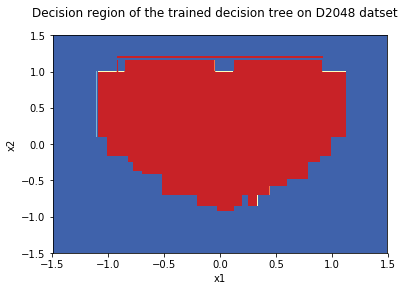

In [48]:
plot_step = 0.002
x_min, x_max = numpy_matrix[0:2048, 0].min() , numpy_matrix[0:2048, 0].max() 
y_min, y_max = numpy_matrix[0:2048, 1].min() , numpy_matrix[0:2048, 1].max() 
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
positions = np.vstack([xx.ravel(), yy.ravel()])
Z = test_accuracy(tree2048, xx.ravel(), yy.ravel())
Z = np.asarray(Z)
Z = Z.reshape(xx.shape)

plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)


cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

plt.xlabel('x1')
plt.ylabel('x2')

plt.suptitle("Decision region of the trained decision tree on D2048 datset")
#plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")

#labels = ['blue = label 1', 'red = label 0']

#plt.legend(loc='upper right', labels)
#plt.legend(labels)
plt.savefig('f3_d2048.png')
plt.show()

In [47]:
tree8192 = build_tree(d8192, 10000, 1)
print_tree(tree8192)

X1 >= 0.85063 Information Gain=0.06618
X1 >= -0.11878 Information Gain=0.00130
X1 >= -0.26110 Information Gain=0.00564
X1 >= -0.45934 Information Gain=0.01644
X1 >= 0.54005 Information Gain=0.02836
X1 >= -1.15454 Information Gain=0.09125
X1 >= 0.09207 Information Gain=0.00101
X1 >= -0.83666 Information Gain=0.05724
X1 >= 0.79252 Information Gain=0.05927
X1 >= 0.18151 Information Gain=0.00368
X1 >= -0.44620 Information Gain=0.01563
X1 >= 1.12763 Information Gain=0.09247
X1 >= 0.27852 Information Gain=0.00790
X1 >= 1.20753 Information Gain=0.07631
X1 >= 1.30131 Information Gain=0.05122
X1 >= -0.75426 Information Gain=0.04698
X1 >= -0.88302 Information Gain=0.06398
X1 >= 0.22481 Information Gain=0.00535
X1 >= 1.23308 Information Gain=0.06782
X1 >= 1.11670 Information Gain=0.09184
X1 >= -0.33179 Information Gain=0.00876
X1 >= 0.27166 Information Gain=0.00763
X1 >= -1.44886 Information Gain=0.01238
X1 >= -0.55056 Information Gain=0.02375
X1 >= -0.98469 Information Gain=0.08104
X1 >= -0.2926

X1 >= 0.38367 Information Gain=0.01462
X1 >= 0.23175 Information Gain=0.00564
X1 >= 0.30571 Information Gain=0.00935
X1 >= 1.35285 Information Gain=0.03855
X1 >= 0.85685 Information Gain=0.06745
X1 >= -0.27557 Information Gain=0.00587
X1 >= 0.08390 Information Gain=0.00084
X1 >= 0.07557 Information Gain=0.00068
X1 >= 0.16817 Information Gain=0.00326
X1 >= 0.38028 Information Gain=0.01429
X1 >= -0.94758 Information Gain=0.07111
X1 >= 1.42976 Information Gain=0.01746
X1 >= 0.91805 Information Gain=0.07623
X1 >= -1.22679 Information Gain=0.06986
X1 >= 0.70931 Information Gain=0.04777
X1 >= -1.27599 Information Gain=0.05706
X1 >= 0.86432 Information Gain=0.06823
X1 >= -0.47349 Information Gain=0.01710
X1 >= 0.09561 Information Gain=0.00108
X1 >= -1.36177 Information Gain=0.03394
X1 >= -0.31209 Information Gain=0.00753
X1 >= -1.12206 Information Gain=0.09359
X1 >= -1.10845 Information Gain=0.09615
X1 >= 1.14690 Information Gain=0.09242
X1 >= 1.32854 Information Gain=0.04456
X1 >= 1.24828 In

X1 >= 0.37326 Information Gain=0.01367
X1 >= -1.41978 Information Gain=0.01997
X1 >= 1.45848 Information Gain=0.01035
X1 >= 0.75241 Information Gain=0.05238
X1 >= -0.99364 Information Gain=0.08224
X1 >= 0.23527 Information Gain=0.00568
X1 >= 0.42382 Information Gain=0.01803
X1 >= 0.45796 Information Gain=0.02091
X1 >= -0.29185 Information Gain=0.00649
X1 >= 0.79849 Information Gain=0.05916
X1 >= -0.71133 Information Gain=0.04088
X1 >= 0.79404 Information Gain=0.05910
X1 >= -0.99283 Information Gain=0.08254
X1 >= -0.86138 Information Gain=0.06156
X1 >= -1.19256 Information Gain=0.07890
X1 >= 0.68469 Information Gain=0.04677
X1 >= -1.29655 Information Gain=0.05092
X1 >= 0.00083 Information Gain=0.00001
X1 >= 1.40535 Information Gain=0.02522
X1 >= 0.74223 Information Gain=0.05110
X1 >= -1.02994 Information Gain=0.08640
X1 >= 0.05626 Information Gain=0.00047
X1 >= 0.30799 Information Gain=0.00946
X1 >= 1.04218 Information Gain=0.09259
X1 >= -1.16306 Information Gain=0.08882
X1 >= 1.32779 I

X1 >= -0.73466 Information Gain=0.04321
X1 >= -0.71642 Information Gain=0.04161
X1 >= -1.22852 Information Gain=0.06965
X1 >= 0.34769 Information Gain=0.01258
X1 >= -0.70239 Information Gain=0.04002
X1 >= -0.32609 Information Gain=0.00858
X1 >= -1.49706 Information Gain=0.00081
X1 >= 0.66078 Information Gain=0.04405
X1 >= 0.33839 Information Gain=0.01191
X1 >= 1.13926 Information Gain=0.09518
X1 >= 0.93233 Information Gain=0.07837
X1 >= -0.12623 Information Gain=0.00142
X1 >= 0.93912 Information Gain=0.08016
X1 >= 0.60839 Information Gain=0.03651
X1 >= 0.57788 Information Gain=0.03287
X1 >= -0.05019 Information Gain=0.00019
X1 >= 1.46247 Information Gain=0.00935
X1 >= 0.19465 Information Gain=0.00402
X1 >= 0.33246 Information Gain=0.01152
X1 >= -1.15389 Information Gain=0.09157
X1 >= -0.60866 Information Gain=0.02944
X1 >= -0.89329 Information Gain=0.06422
X1 >= 0.55810 Information Gain=0.03063
X1 >= 0.63991 Information Gain=0.04282
X1 >= -0.97301 Information Gain=0.07864
X1 >= -1.2808

X1 >= 0.12540 Information Gain=0.00182
X1 >= 0.52859 Information Gain=0.02658
X1 >= 1.00668 Information Gain=0.09051
X1 >= -0.26076 Information Gain=0.00554
X1 >= 0.41429 Information Gain=0.01677
X1 >= 0.18139 Information Gain=0.00370
X1 >= -0.40473 Information Gain=0.01290
X1 >= -0.58376 Information Gain=0.02534
X1 >= 1.10146 Information Gain=0.09245
X1 >= 0.55892 Information Gain=0.03085
X1 >= -0.45599 Information Gain=0.01632
X1 >= -1.39436 Information Gain=0.02616
X1 >= 0.47426 Information Gain=0.02258
X1 >= 0.42688 Information Gain=0.01823
X1 >= 1.09517 Information Gain=0.09257
X1 >= -0.30142 Information Gain=0.00695
X1 >= -1.17571 Information Gain=0.08410
X1 >= -0.65907 Information Gain=0.03382
X1 >= -0.86932 Information Gain=0.06392
X1 >= -0.04522 Information Gain=0.00013
X1 >= 0.09542 Information Gain=0.00109
X1 >= -0.19436 Information Gain=0.00317
X1 >= -0.09117 Information Gain=0.00086
X1 >= 0.08387 Information Gain=0.00083
X1 >= -0.89928 Information Gain=0.06588
X1 >= 0.1248

X1 >= -1.03039 Information Gain=0.08620
X1 >= -0.51575 Information Gain=0.01968
X1 >= 0.67617 Information Gain=0.04557
X1 >= -1.34615 Information Gain=0.03836
X1 >= 0.72924 Information Gain=0.04916
X1 >= -0.33901 Information Gain=0.00902
X1 >= -0.39874 Information Gain=0.01247
X1 >= -1.27376 Information Gain=0.05776
X1 >= 0.29385 Information Gain=0.00856
X1 >= 0.26361 Information Gain=0.00711
X1 >= 1.42327 Information Gain=0.01969
X1 >= 1.03501 Information Gain=0.09186
X1 >= 0.74223 Information Gain=0.05093
X1 >= -0.08390 Information Gain=0.00069
X1 >= 0.75363 Information Gain=0.05257
X1 >= 0.71544 Information Gain=0.04780
X1 >= -1.35577 Information Gain=0.03586
X1 >= 1.01124 Information Gain=0.09121
X1 >= -0.76443 Information Gain=0.04769
X1 >= -0.67321 Information Gain=0.03558
X1 >= 1.17608 Information Gain=0.08452
X1 >= -0.61078 Information Gain=0.02965
X1 >= -1.31494 Information Gain=0.04700
X1 >= 1.05416 Information Gain=0.09406
X1 >= -1.17063 Information Gain=0.08619
X1 >= 0.2984

X1 >= -0.74232 Information Gain=0.04487
X1 >= -0.44710 Information Gain=0.01569
X1 >= 0.46768 Information Gain=0.02175
X1 >= 0.98827 Information Gain=0.08734
X1 >= -0.08311 Information Gain=0.00064
X1 >= 0.36542 Information Gain=0.01329
X1 >= -0.30949 Information Gain=0.00754
X1 >= -1.36545 Information Gain=0.03280
X1 >= 0.45453 Information Gain=0.02073
X1 >= 0.77661 Information Gain=0.05750
X1 >= -0.25892 Information Gain=0.00548
X1 >= 0.09864 Information Gain=0.00117
X1 >= -0.59793 Information Gain=0.02736
X1 >= -0.30029 Information Gain=0.00693
X1 >= 0.12511 Information Gain=0.00184
X1 >= -0.30894 Information Gain=0.00745
X1 >= 0.35444 Information Gain=0.01311
X1 >= 0.88158 Information Gain=0.07218
X1 >= -0.47600 Information Gain=0.01728
X1 >= 0.60581 Information Gain=0.03622
X1 >= 0.88178 Information Gain=0.07209
X1 >= -1.09574 Information Gain=0.09365
X1 >= 0.67015 Information Gain=0.04455
X1 >= 0.41328 Information Gain=0.01676
X1 >= -0.75156 Information Gain=0.04610
X1 >= 1.21757

X1 >= 0.32898 Information Gain=0.01138
X1 >= -1.22380 Information Gain=0.07088
X1 >= -0.07887 Information Gain=0.00052
X1 >= 0.05515 Information Gain=0.00049
X1 >= 0.70835 Information Gain=0.04784
X1 >= -1.19163 Information Gain=0.07910
X1 >= 1.16186 Information Gain=0.08829
X1 >= 0.24186 Information Gain=0.00629
X1 >= 0.50452 Information Gain=0.02420
X1 >= -0.23548 Information Gain=0.00460
X1 >= -0.76412 Information Gain=0.04760
X1 >= -0.52515 Information Gain=0.02072
X1 >= -0.74209 Information Gain=0.04501
X1 >= 0.01558 Information Gain=0.00010
X1 >= 1.48808 Information Gain=0.00253
X1 >= 0.54447 Information Gain=0.02908
X1 >= -1.07047 Information Gain=0.09169
X1 >= 0.95503 Information Gain=0.08271
X1 >= 0.98410 Information Gain=0.08769
X1 >= 0.57117 Information Gain=0.03189
X1 >= 0.17907 Information Gain=0.00366
X1 >= 0.07412 Information Gain=0.00065
X1 >= 0.85225 Information Gain=0.06645
X1 >= 0.56680 Information Gain=0.03138
X1 >= 0.96729 Information Gain=0.08357
X1 >= -1.17831 In

X1 >= 0.25058 Information Gain=0.00641
X1 >= 0.06151 Information Gain=0.00051
X1 >= -0.15357 Information Gain=0.00202
X1 >= 0.80016 Information Gain=0.05921
X1 >= 0.00398 Information Gain=0.00002
X1 >= -0.82333 Information Gain=0.05455
X1 >= 1.33639 Information Gain=0.04271
X1 >= 0.71067 Information Gain=0.04785
X1 >= 0.40346 Information Gain=0.01605
X1 >= 0.53900 Information Gain=0.02822
X1 >= -0.69879 Information Gain=0.03967
X1 >= 1.14383 Information Gain=0.09358
X1 >= -0.10039 Information Gain=0.00098
X1 >= 0.11280 Information Gain=0.00139
X1 >= 0.61868 Information Gain=0.03808
X1 >= -0.74585 Information Gain=0.04512
X1 >= 0.98464 Information Gain=0.08795
X1 >= -0.03772 Information Gain=0.00008
X1 >= 0.73635 Information Gain=0.05015
X1 >= 1.18685 Information Gain=0.08139
X1 >= -0.26281 Information Gain=0.00561
X1 >= -0.46829 Information Gain=0.01684
X1 >= 0.31208 Information Gain=0.00982
X1 >= 0.22835 Information Gain=0.00552
X1 >= -0.08389 Information Gain=0.00068
X1 >= -1.45161 I

X1 >= 0.96769 Information Gain=0.08390
X1 >= -0.46430 Information Gain=0.01653
X1 >= 0.72888 Information Gain=0.04931
X1 >= -0.80247 Information Gain=0.05187
X1 >= -1.16690 Information Gain=0.08735
X1 >= -1.13242 Information Gain=0.09580
X1 >= -0.24889 Information Gain=0.00503
X1 >= 1.24820 Information Gain=0.06489
X1 >= -0.72968 Information Gain=0.04261
X1 >= -0.47236 Information Gain=0.01711
X1 >= 0.21793 Information Gain=0.00514
X1 >= 1.37844 Information Gain=0.03184
X1 >= 0.23422 Information Gain=0.00569
X1 >= -0.45199 Information Gain=0.01600
X1 >= 0.55102 Information Gain=0.02982
X1 >= -0.86424 Information Gain=0.06175
X1 >= 1.40686 Information Gain=0.02503
X1 >= 0.07182 Information Gain=0.00062
X1 >= -1.48228 Information Gain=0.00515
X1 >= -0.53970 Information Gain=0.02238
X1 >= -0.24603 Information Gain=0.00480
X1 >= -0.03853 Information Gain=0.00009
X1 >= 1.42688 Information Gain=0.01829
X1 >= -0.52399 Information Gain=0.02025
X1 >= 1.06511 Information Gain=0.09358
X1 >= 1.463

X1 >= -1.46462 Information Gain=0.00871
X1 >= -0.33169 Information Gain=0.00879
X1 >= -1.13427 Information Gain=0.09516
X1 >= -0.32637 Information Gain=0.00865
X1 >= -0.53747 Information Gain=0.02166
X1 >= 0.61179 Information Gain=0.03705
X1 >= 0.67858 Information Gain=0.04579
X1 >= 1.04421 Information Gain=0.09370
X1 >= -0.37632 Information Gain=0.01131
X1 >= -0.34137 Information Gain=0.00905
X1 >= 0.17572 Information Gain=0.00352
X1 >= -0.99343 Information Gain=0.08234
X1 >= -0.60273 Information Gain=0.02827
X1 >= 1.24941 Information Gain=0.06438
X1 >= -0.58414 Information Gain=0.02538
X1 >= -0.58149 Information Gain=0.02496
X1 >= -0.35411 Information Gain=0.00992
X1 >= -0.09324 Information Gain=0.00087
X1 >= 0.35669 Information Gain=0.01320
X1 >= -1.03015 Information Gain=0.08630
X1 >= -0.14474 Information Gain=0.00174
X1 >= 1.35492 Information Gain=0.03787
X1 >= -1.43279 Information Gain=0.01653
X1 >= -1.18041 Information Gain=0.08212
X1 >= 0.73853 Information Gain=0.05033
X1 >= 0.

X1 >= 0.71202 Information Gain=0.04763
X1 >= -0.03657 Information Gain=0.00008
X1 >= -0.17742 Information Gain=0.00272
X1 >= -0.54010 Information Gain=0.02265
X1 >= 1.10272 Information Gain=0.09289
X1 >= 0.67729 Information Gain=0.04543
X1 >= 1.07930 Information Gain=0.09452
X1 >= 0.33902 Information Gain=0.01203
X1 >= -0.86870 Information Gain=0.06347
X1 >= 0.55477 Information Gain=0.03018
X1 >= 0.09925 Information Gain=0.00116
X1 >= 0.89290 Information Gain=0.07318
X1 >= 0.03409 Information Gain=0.00025
X1 >= -1.20136 Information Gain=0.07652
X1 >= -1.37762 Information Gain=0.02956
X1 >= -1.13489 Information Gain=0.09495
X1 >= 1.02836 Information Gain=0.09215
X1 >= 0.77951 Information Gain=0.05763
X1 >= 0.41231 Information Gain=0.01661
X1 >= -0.11768 Information Gain=0.00123
X1 >= 1.37837 Information Gain=0.03194
X1 >= 1.25905 Information Gain=0.06086
X1 >= -0.83380 Information Gain=0.05685
X1 >= -0.15587 Information Gain=0.00212
X1 >= 0.98801 Information Gain=0.08755
X1 >= 1.26117 I

X1 >= -0.52438 Information Gain=0.02055
X1 >= -0.54569 Information Gain=0.02298
X1 >= 0.59172 Information Gain=0.03452
X1 >= 1.47270 Information Gain=0.00634
X1 >= -0.38132 Information Gain=0.01137
X1 >= -1.15901 Information Gain=0.09030
X1 >= 0.39550 Information Gain=0.01593
X1 >= 0.11180 Information Gain=0.00133
X1 >= -0.67804 Information Gain=0.03634
X1 >= 0.67190 Information Gain=0.04506
X1 >= -0.15005 Information Gain=0.00187
X1 >= 1.00266 Information Gain=0.08917
X1 >= 0.46765 Information Gain=0.02180
X1 >= 0.63277 Information Gain=0.04134
X1 >= 0.95262 Information Gain=0.08213
X1 >= 0.40287 Information Gain=0.01598
X1 >= -0.79115 Information Gain=0.05104
X1 >= 0.65010 Information Gain=0.04399
X1 >= -0.82676 Information Gain=0.05569
X1 >= 1.02191 Information Gain=0.09177
X1 >= -0.67066 Information Gain=0.03471
X1 >= -1.04078 Information Gain=0.08705
X1 >= 1.11862 Information Gain=0.09222
X1 >= -0.55866 Information Gain=0.02398
X1 >= 1.29662 Information Gain=0.05230
X1 >= -0.51329

X1 >= 1.47290 Information Gain=0.00606
X1 >= 0.59516 Information Gain=0.03525
X1 >= -0.05162 Information Gain=0.00020
X1 >= 0.01652 Information Gain=0.00010
X1 >= 0.59445 Information Gain=0.03496
X1 >= 0.72434 Information Gain=0.04935
X1 >= -0.58470 Information Gain=0.02548
X1 >= 1.39863 Information Gain=0.02691
X1 >= 1.37205 Information Gain=0.03394
X1 >= 0.01003 Information Gain=0.00005
X1 >= -0.69312 Information Gain=0.03925
X1 >= 0.03624 Information Gain=0.00027
X1 >= -0.42251 Information Gain=0.01424
X1 >= -0.11004 Information Gain=0.00107
X1 >= 0.87621 Information Gain=0.07058
X1 >= -0.64414 Information Gain=0.03270
X1 >= 0.90174 Information Gain=0.07543
X1 >= 1.44764 Information Gain=0.01320
X1 >= 0.82165 Information Gain=0.05960
X1 >= 0.64078 Information Gain=0.04282
X1 >= 1.20991 Information Gain=0.07559
X1 >= -0.74885 Information Gain=0.04506
X1 >= -0.06444 Information Gain=0.00033
X1 >= -0.43652 Information Gain=0.01506
X1 >= 1.26908 Information Gain=0.05856
X1 >= 0.05266 In

X1 >= -0.16190 Information Gain=0.00219
X1 >= 0.50260 Information Gain=0.02380
X1 >= 1.25885 Information Gain=0.06106
X1 >= -0.21997 Information Gain=0.00404
X1 >= 0.04517 Information Gain=0.00039
X1 >= -1.43112 Information Gain=0.01727
X1 >= 0.64103 Information Gain=0.04289
X1 >= 0.81212 Information Gain=0.05954
X1 >= 0.27431 Information Gain=0.00772
X1 >= 1.07081 Information Gain=0.09513
X1 >= 0.72789 Information Gain=0.04930
X1 >= 0.08645 Information Gain=0.00093
X1 >= 1.08305 Information Gain=0.09373
X1 >= -0.86409 Information Gain=0.06192
X1 >= -0.50336 Information Gain=0.01919
X1 >= 1.43432 Information Gain=0.01625
X1 >= -0.02728 Information Gain=0.00004
X1 >= 0.83948 Information Gain=0.06317
X1 >= 1.43097 Information Gain=0.01699
X1 >= 0.33103 Information Gain=0.01148
X1 >= -0.78807 Information Gain=0.05047
X1 >= -1.29352 Information Gain=0.05151
X1 >= 0.78459 Information Gain=0.05791
X1 >= 1.15689 Information Gain=0.08998
X1 >= 0.54327 Information Gain=0.02905
X1 >= -0.97713 In

X1 >= 0.61181 Information Gain=0.03698
X1 >= 1.18514 Information Gain=0.08201
X1 >= -0.94012 Information Gain=0.07057
X1 >= 0.93425 Information Gain=0.07857
X1 >= 1.06904 Information Gain=0.09500
X1 >= -0.47096 Information Gain=0.01693
X1 >= -0.38165 Information Gain=0.01130
X1 >= 0.46197 Information Gain=0.02113
X1 >= 0.16350 Information Gain=0.00321
X1 >= -0.41980 Information Gain=0.01435
X1 >= 0.16101 Information Gain=0.00313
X1 >= -1.38840 Information Gain=0.02710
X1 >= 0.66195 Information Gain=0.04420
X1 >= -0.01733 Information Gain=0.00001
X1 >= 0.89773 Information Gain=0.07381
X1 >= -0.97451 Information Gain=0.07903
X1 >= -1.33958 Information Gain=0.04019
X1 >= -1.23904 Information Gain=0.06661
X1 >= -0.27361 Information Gain=0.00582
X1 >= -0.22367 Information Gain=0.00413
X1 >= 0.45296 Information Gain=0.02029
X1 >= -1.36078 Information Gain=0.03432
X1 >= 1.48879 Information Gain=0.00198
X1 >= -0.89734 Information Gain=0.06478
X1 >= 0.08962 Information Gain=0.00091
X1 >= -0.060

X1 >= -0.05387 Information Gain=0.00022
X1 >= 1.15524 Information Gain=0.09051
X1 >= -0.45187 Information Gain=0.01608
X1 >= 0.91336 Information Gain=0.07498
X1 >= 0.52866 Information Gain=0.02671
X1 >= -0.82355 Information Gain=0.05466
X1 >= -0.44684 Information Gain=0.01562
X1 >= -0.30619 Information Gain=0.00733
X1 >= 0.74670 Information Gain=0.05174
X1 >= 1.21815 Information Gain=0.07241
X1 >= 0.50469 Information Gain=0.02415
X1 >= -0.64489 Information Gain=0.03294
X1 >= -0.28702 Information Gain=0.00623
X1 >= -0.22789 Information Gain=0.00446
X1 >= 0.84809 Information Gain=0.06569
X1 >= -0.07888 Information Gain=0.00053
X1 >= -0.15423 Information Gain=0.00205
X1 >= 0.10553 Information Gain=0.00126
X1 >= 1.33262 Information Gain=0.04329
X1 >= -0.61671 Information Gain=0.03064
X1 >= -0.39291 Information Gain=0.01207
X1 >= 0.35837 Information Gain=0.01329
X1 >= -0.17130 Information Gain=0.00236
X1 >= 0.02584 Information Gain=0.00018
X1 >= 0.19890 Information Gain=0.00436
X1 >= 0.9686

X1 >= 1.05846 Information Gain=0.09362
X1 >= -0.81905 Information Gain=0.05356
X1 >= -0.56929 Information Gain=0.02407
X1 >= 0.30047 Information Gain=0.00891
X1 >= -1.06126 Information Gain=0.08953
X1 >= -0.10891 Information Gain=0.00105
X1 >= 1.47641 Information Gain=0.00506
X1 >= -0.41274 Information Gain=0.01363
X1 >= -0.82641 Information Gain=0.05530
X1 >= 0.81546 Information Gain=0.05952
X1 >= -0.84527 Information Gain=0.05878
X1 >= 1.10994 Information Gain=0.09242
X1 >= -0.87788 Information Gain=0.06358
X1 >= 0.19555 Information Gain=0.00405
X1 >= -1.09543 Information Gain=0.09246
X1 >= -0.09062 Information Gain=0.00081
X1 >= -1.16986 Information Gain=0.08630
X1 >= 0.76483 Information Gain=0.05348
X1 >= -0.81425 Information Gain=0.05221
X1 >= 0.09162 Information Gain=0.00099
X1 >= -0.35755 Information Gain=0.01014
X1 >= -0.67374 Information Gain=0.03609
X1 >= -1.45172 Information Gain=0.01155
X1 >= -1.35697 Information Gain=0.03547
X1 >= -0.91646 Information Gain=0.06875
X1 >= -0

X1 >= 0.21508 Information Gain=0.00492
X1 >= -0.40379 Information Gain=0.01281
X1 >= 0.44083 Information Gain=0.01889
X1 >= 1.47053 Information Gain=0.00725
X1 >= 0.57070 Information Gain=0.03208
X1 >= -0.39195 Information Gain=0.01201
X1 >= 1.21801 Information Gain=0.07262
X1 >= -1.25098 Information Gain=0.06368
X1 >= -0.03327 Information Gain=0.00007
X1 >= -0.57823 Information Gain=0.02449
X1 >= 0.30023 Information Gain=0.00886
X1 >= -0.54446 Information Gain=0.02266
X1 >= 0.58315 Information Gain=0.03382
X1 >= 0.21280 Information Gain=0.00486
X1 >= 0.28006 Information Gain=0.00803
X1 >= -0.52720 Information Gain=0.02093
X1 >= 0.35234 Information Gain=0.01284
X1 >= 0.85154 Information Gain=0.06631
X1 >= -0.34692 Information Gain=0.00938
X1 >= 1.03418 Information Gain=0.09227
X1 >= 0.71014 Information Gain=0.04770
X1 >= 0.76051 Information Gain=0.05358
X1 >= -0.39813 Information Gain=0.01235
X1 >= 0.72565 Information Gain=0.04928
X1 >= 1.10536 Information Gain=0.09236
X1 >= 0.15311 In

X1 >= 1.03221 Information Gain=0.09279
X1 >= -0.93951 Information Gain=0.07058
X1 >= -1.12969 Information Gain=0.09612
X1 >= 0.38573 Information Gain=0.01483
X1 >= -0.04269 Information Gain=0.00011
X1 >= 0.04732 Information Gain=0.00042
X1 >= 1.01504 Information Gain=0.09152
X1 >= 0.01447 Information Gain=0.00008
X1 >= -0.21204 Information Gain=0.00376
X1 >= 1.48416 Information Gain=0.00325
X1 >= -0.60568 Information Gain=0.02880
X1 >= -0.51161 Information Gain=0.02000
X1 >= 0.48590 Information Gain=0.02305
X1 >= -0.27333 Information Gain=0.00578
X1 >= -1.24009 Information Gain=0.06620
X1 >= 0.38016 Information Gain=0.01416
X1 >= -0.41862 Information Gain=0.01419
X1 >= -0.84250 Information Gain=0.05878
X1 >= 0.77015 Information Gain=0.05611
X1 >= -0.52114 Information Gain=0.01997
X1 >= 0.93369 Information Gain=0.07866
X1 >= -0.48759 Information Gain=0.01818
X1 >= 0.38714 Information Gain=0.01481
X1 >= -0.73654 Information Gain=0.04375
X1 >= -0.05756 Information Gain=0.00025
X1 >= 0.650

X1 >= 0.03911 Information Gain=0.00033
X1 >= 0.74396 Information Gain=0.05128
X1 >= 1.34055 Information Gain=0.04164
X1 >= 0.34008 Information Gain=0.01220
X1 >= -1.02061 Information Gain=0.08325
X1 >= -0.06566 Information Gain=0.00034
X1 >= -0.96214 Information Gain=0.07604
X1 >= 0.51019 Information Gain=0.02480
X1 >= 1.24657 Information Gain=0.06509
X1 >= -1.24388 Information Gain=0.06529
X1 >= -1.29417 Information Gain=0.05142
X1 >= 0.96916 Information Gain=0.08394
X1 >= -0.53609 Information Gain=0.02140
X1 >= -0.77073 Information Gain=0.04826
X1 >= 1.31136 Information Gain=0.04886
X1 >= -0.54890 Information Gain=0.02385
X1 >= 1.47215 Information Gain=0.00679
X1 >= -0.40537 Information Gain=0.01296
X1 >= -0.42952 Information Gain=0.01485
X1 >= 0.21228 Information Gain=0.00481
X1 >= -0.29580 Information Gain=0.00682
X1 >= 0.94491 Information Gain=0.08062
X1 >= 0.10819 Information Gain=0.00132
X1 >= -0.66596 Information Gain=0.03374
X1 >= -1.26008 Information Gain=0.06086
X1 >= 1.0077

X1 >= -0.09610 Information Gain=0.00087
X1 >= 0.18197 Information Gain=0.00377
X1 >= -0.54519 Information Gain=0.02279
X1 >= -1.05030 Information Gain=0.08824
X1 >= 0.03387 Information Gain=0.00023
X1 >= 0.22657 Information Gain=0.00535
X1 >= -1.41900 Information Gain=0.02016
X1 >= 0.99326 Information Gain=0.08837
X1 >= -1.09901 Information Gain=0.09468
X1 >= -1.18583 Information Gain=0.08097
X1 >= 0.91947 Information Gain=0.07687
X1 >= -1.09442 Information Gain=0.09278
X1 >= -0.75672 Information Gain=0.04716
X1 >= -0.07501 Information Gain=0.00044
X1 >= -0.42234 Information Gain=0.01428
X1 >= 1.01659 Information Gain=0.09143
X1 >= -0.34599 Information Gain=0.00922
X1 >= 1.22927 Information Gain=0.06904
X1 >= -0.66687 Information Gain=0.03404
X1 >= 1.06720 Information Gain=0.09422
X1 >= -1.17129 Information Gain=0.08588
X1 >= 1.20900 Information Gain=0.07580
X1 >= 0.55163 Information Gain=0.03003
X1 >= 1.24307 Information Gain=0.06580
X1 >= 1.01334 Information Gain=0.09090
X1 >= 0.5964

X1 >= 0.65746 Information Gain=0.04377
X1 >= -0.32062 Information Gain=0.00805
X1 >= 0.76984 Information Gain=0.05574
X1 >= -1.14536 Information Gain=0.09411
X1 >= 0.66654 Information Gain=0.04398
X1 >= -1.23727 Information Gain=0.06711
X1 >= -0.55696 Information Gain=0.02399
X1 >= 0.67036 Information Gain=0.04484
X1 >= -0.53757 Information Gain=0.02175
X1 >= -0.61950 Information Gain=0.03097
X1 >= -1.44931 Information Gain=0.01219
X1 >= -0.28343 Information Gain=0.00597
X1 >= -0.31495 Information Gain=0.00775
X1 >= 0.16590 Information Gain=0.00329
X1 >= 0.70195 Information Gain=0.04743
X1 >= -0.84744 Information Gain=0.05983
X1 >= 0.03110 Information Gain=0.00021
X1 >= -0.96122 Information Gain=0.07630
X1 >= 0.86640 Information Gain=0.06828
X1 >= 0.55687 Information Gain=0.03049
X1 >= -0.24408 Information Gain=0.00486
X1 >= 0.98498 Information Gain=0.08785
X1 >= -0.41012 Information Gain=0.01321
X1 >= -0.52431 Information Gain=0.02046
X1 >= -0.16305 Information Gain=0.00217
X1 >= 0.07

X1 >= -1.44242 Information Gain=0.01422
X1 >= -1.11401 Information Gain=0.09529
X1 >= -0.00435 Information Gain=0.00000
X1 >= -1.44032 Information Gain=0.01496
X1 >= 1.03544 Information Gain=0.09276
X1 >= -1.45328 Information Gain=0.01118
X1 >= -0.42707 Information Gain=0.01424
X1 >= -0.37603 Information Gain=0.01119
X1 >= -0.55658 Information Gain=0.02390
X1 >= -0.99762 Information Gain=0.08276
X1 >= 0.07355 Information Gain=0.00066
X1 >= -0.67378 Information Gain=0.03603
X1 >= 0.63530 Information Gain=0.04147
X1 >= -0.20003 Information Gain=0.00350
X1 >= 0.65016 Information Gain=0.04392
X1 >= 1.19760 Information Gain=0.07890
X1 >= 0.01273 Information Gain=0.00006
X1 >= 0.09669 Information Gain=0.00110
X1 >= 0.77164 Information Gain=0.05684
X1 >= 0.12298 Information Gain=0.00173
X1 >= -0.02402 Information Gain=0.00002
X1 >= -0.26659 Information Gain=0.00568
X1 >= 0.85380 Information Gain=0.06659
X1 >= 0.96203 Information Gain=0.08334
X1 >= 1.07091 Information Gain=0.09503
X1 >= -0.168

X1 >= -0.82874 Information Gain=0.05615
X1 >= -0.18426 Information Gain=0.00282
X1 >= -1.12375 Information Gain=0.09338
X1 >= 1.02698 Information Gain=0.09192
X1 >= 0.04893 Information Gain=0.00043
X1 >= 0.29112 Information Gain=0.00857
X1 >= 0.56335 Information Gain=0.03091
X1 >= -0.77051 Information Gain=0.04834
X1 >= 0.01454 Information Gain=0.00009
X1 >= -0.56239 Information Gain=0.02364
X1 >= -1.12676 Information Gain=0.09385
X1 >= -0.51976 Information Gain=0.01994
X1 >= -0.25069 Information Gain=0.00529
X1 >= 0.63100 Information Gain=0.04062
X1 >= -0.18774 Information Gain=0.00295
X1 >= -0.81590 Information Gain=0.05287
X1 >= 0.76262 Information Gain=0.05362
X1 >= -0.38440 Information Gain=0.01143
X1 >= -0.08551 Information Gain=0.00072
X1 >= -0.11039 Information Gain=0.00106
X1 >= 0.68146 Information Gain=0.04609
X1 >= -0.76517 Information Gain=0.04754
X1 >= -0.87192 Information Gain=0.06423
X1 >= -0.71620 Information Gain=0.04153
X1 >= -0.69548 Information Gain=0.03925
X1 >= 0.

X1 >= 0.24653 Information Gain=0.00657
X1 >= -0.29116 Information Gain=0.00647
X1 >= -1.40509 Information Gain=0.02343
X1 >= -1.22507 Information Gain=0.07037
X1 >= 1.08022 Information Gain=0.09420
X1 >= -1.01198 Information Gain=0.08306
X1 >= -0.48692 Information Gain=0.01823
X1 >= 0.66701 Information Gain=0.04427
X1 >= 0.19991 Information Gain=0.00444
X1 >= -0.86457 Information Gain=0.06189
X1 >= -0.27323 Information Gain=0.00583
X1 >= -1.35202 Information Gain=0.03662
X1 >= -0.68648 Information Gain=0.03731
X1 >= -0.16464 Information Gain=0.00222
X1 >= 0.89055 Information Gain=0.07320
X1 >= -0.79246 Information Gain=0.05116
X1 >= 0.62109 Information Gain=0.03883
X1 >= -0.77440 Information Gain=0.04831
X1 >= 0.86669 Information Gain=0.06819
X1 >= 1.30960 Information Gain=0.04915
X1 >= 0.61941 Information Gain=0.03814
X1 >= 0.31673 Information Gain=0.01021
X1 >= 0.02138 Information Gain=0.00013
X1 >= 0.98811 Information Gain=0.08745
X1 >= -0.83304 Information Gain=0.05673
X1 >= 1.3059

X1 >= -0.67473 Information Gain=0.03628
X1 >= -0.71081 Information Gain=0.04088
X1 >= 0.57567 Information Gain=0.03231
X1 >= -0.81851 Information Gain=0.05300
X1 >= -0.41023 Information Gain=0.01334
X1 >= -1.36023 Information Gain=0.03471
X1 >= -1.29139 Information Gain=0.05221
X1 >= -1.07313 Information Gain=0.09148
X1 >= -1.17697 Information Gain=0.08358
X1 >= 0.09693 Information Gain=0.00114
X1 >= 0.09140 Information Gain=0.00097
X1 >= -1.48712 Information Gain=0.00325
X1 >= 0.60818 Information Gain=0.03633
X1 >= -0.21806 Information Gain=0.00401
X1 >= -1.40452 Information Gain=0.02362
X1 >= 0.89911 Information Gain=0.07422
X1 >= -0.21280 Information Gain=0.00377
X1 >= 0.44703 Information Gain=0.01958
X1 >= -1.48645 Information Gain=0.00343
X1 >= -1.32048 Information Gain=0.04534
X1 >= 0.17232 Information Gain=0.00354
X1 >= -1.33163 Information Gain=0.04251
X1 >= -0.30175 Information Gain=0.00704
X1 >= -0.08714 Information Gain=0.00080
X1 >= -1.00884 Information Gain=0.08319
X1 >= 1

X1 >= 0.55908 Information Gain=0.03079
X1 >= -1.35326 Information Gain=0.03653
X1 >= -1.30181 Information Gain=0.05004
X1 >= -1.44989 Information Gain=0.01201
X1 >= 1.01582 Information Gain=0.09132
X1 >= -0.67132 Information Gain=0.03508
X1 >= 0.67888 Information Gain=0.04594
X1 >= -0.34557 Information Gain=0.00920
X1 >= -0.94630 Information Gain=0.07167
X1 >= 0.86768 Information Gain=0.06842
X1 >= -1.00411 Information Gain=0.08205
X1 >= 1.37901 Information Gain=0.03175
X1 >= 1.09420 Information Gain=0.09321
X1 >= -1.47315 Information Gain=0.00679
X1 >= 1.25649 Information Gain=0.06207
X1 >= -0.25705 Information Gain=0.00537
X1 >= 0.08428 Information Gain=0.00086
X1 >= 0.75645 Information Gain=0.05327
X1 >= -0.24913 Information Gain=0.00507
X1 >= -0.74940 Information Gain=0.04546
X1 >= 0.80264 Information Gain=0.05899
X1 >= 0.88199 Information Gain=0.07215
X1 >= 0.38064 Information Gain=0.01428
X1 >= 0.37779 Information Gain=0.01396
X1 >= 0.65855 Information Gain=0.04384
X1 >= -0.79658

X1 >= 0.98199 Information Gain=0.08691
X1 >= 1.14095 Information Gain=0.09443
X1 >= 0.26026 Information Gain=0.00696
X1 >= -1.10032 Information Gain=0.09479
X1 >= 0.27077 Information Gain=0.00752
X1 >= -1.09575 Information Gain=0.09355
X1 >= 0.78543 Information Gain=0.05794
X1 >= 0.34057 Information Gain=0.01218
X1 >= 0.74712 Information Gain=0.05183
X1 >= 0.94435 Information Gain=0.08082
X1 >= -0.44206 Information Gain=0.01535
X1 >= 1.08205 Information Gain=0.09335
X1 >= 1.48142 Information Gain=0.00397
X1 >= -1.19139 Information Gain=0.07921
X1 >= -0.87124 Information Gain=0.06403
X1 >= 1.01782 Information Gain=0.09122
X1 >= 1.14968 Information Gain=0.09167
X1 >= 1.01121 Information Gain=0.09131
X1 >= -0.04929 Information Gain=0.00015
X1 >= 0.11913 Information Gain=0.00153
X1 >= -1.11121 Information Gain=0.09593
X1 >= 0.74565 Information Gain=0.05162
X1 >= 0.82666 Information Gain=0.06111
X1 >= 0.90517 Information Gain=0.07469
X1 >= -1.04095 Information Gain=0.08695
X1 >= 0.36070 Inf

X1 >= -0.80229 Information Gain=0.05169
X1 >= 1.10273 Information Gain=0.09278
X1 >= 0.85744 Information Gain=0.06736
X1 >= -0.46734 Information Gain=0.01689
X1 >= 0.22462 Information Gain=0.00531
X1 >= -0.22133 Information Gain=0.00406
X1 >= 1.35000 Information Gain=0.03932
X1 >= 1.10589 Information Gain=0.09225
X1 >= 0.45038 Information Gain=0.01985
X1 >= 1.38013 Information Gain=0.03156
X1 >= 1.29853 Information Gain=0.05191
X1 >= 0.61598 Information Gain=0.03778
X1 >= 0.63220 Information Gain=0.04142
X1 >= 1.41495 Information Gain=0.02249
X1 >= 1.11428 Information Gain=0.09178
X1 >= -0.83371 Information Gain=0.05665
X1 >= -0.95739 Information Gain=0.07529
X1 >= -0.71544 Information Gain=0.04160
X1 >= 0.92423 Information Gain=0.07704
X1 >= 0.91082 Information Gain=0.07537
X1 >= -0.46317 Information Gain=0.01639
X1 >= -0.75400 Information Gain=0.04658
X1 >= -0.83816 Information Gain=0.05748
X1 >= 1.37780 Information Gain=0.03222
X1 >= -0.98442 Information Gain=0.08114
X1 >= 0.81824 I

X1 >= 1.07439 Information Gain=0.09432
X1 >= -1.38157 Information Gain=0.02871
X1 >= -1.24179 Information Gain=0.06570
X1 >= 0.49754 Information Gain=0.02353
X1 >= 1.25495 Information Gain=0.06267
X1 >= 0.98269 Information Gain=0.08763
X1 >= 0.12321 Information Gain=0.00177
X1 >= -0.47719 Information Gain=0.01738
X1 >= 0.30312 Information Gain=0.00934
X1 >= -1.06367 Information Gain=0.09045
X1 >= -0.47691 Information Gain=0.01727
X1 >= 0.41204 Information Gain=0.01666
X1 >= -0.00452 Information Gain=0.00000
X1 >= -0.60011 Information Gain=0.02766
X1 >= 1.41542 Information Gain=0.02231
X1 >= -0.07706 Information Gain=0.00047
X1 >= -1.46111 Information Gain=0.00935
X1 >= 1.16013 Information Gain=0.08893
X1 >= -0.12913 Information Gain=0.00149
X1 >= -0.06901 Information Gain=0.00036
X1 >= 1.05637 Information Gain=0.09374
X1 >= -1.25295 Information Gain=0.06257
X1 >= -1.40911 Information Gain=0.02259
X1 >= 0.87859 Information Gain=0.07104
X1 >= 1.35012 Information Gain=0.03922
X1 >= 0.7221

X1 >= -1.22178 Information Gain=0.07169
X1 >= 0.13189 Information Gain=0.00205
X1 >= 1.11870 Information Gain=0.09295
X1 >= -0.19555 Information Gain=0.00326
X1 >= 1.06576 Information Gain=0.09400
X1 >= 1.24936 Information Gain=0.06448
X1 >= 1.19998 Information Gain=0.07807
X1 >= 0.82160 Information Gain=0.05968
X1 >= 0.53475 Information Gain=0.02701
X1 >= -1.07640 Information Gain=0.09181
X1 >= -0.20235 Information Gain=0.00352
X1 >= -0.31430 Information Gain=0.00771
X1 >= -0.15215 Information Gain=0.00193
X1 >= 1.25510 Information Gain=0.06257
X1 >= -0.90060 Information Gain=0.06661
X1 >= 1.38528 Information Gain=0.02994
X1 >= -0.64090 Information Gain=0.03296
X1 >= -0.00969 Information Gain=0.00000
X1 >= 0.68146 Information Gain=0.04602
X1 >= 0.23608 Information Gain=0.00572
X1 >= 1.00564 Information Gain=0.09032
X1 >= -0.78240 Information Gain=0.04904
X1 >= 1.10685 Information Gain=0.09326
X1 >= -0.59799 Information Gain=0.02746
X1 >= 0.18206 Information Gain=0.00375
X1 >= 0.27947 

X1 >= -0.79095 Information Gain=0.05094
X1 >= 1.16325 Information Gain=0.08766
X1 >= -0.14989 Information Gain=0.00188
X1 >= 0.76919 Information Gain=0.05502
X1 >= -1.35755 Information Gain=0.03519
X1 >= 0.04625 Information Gain=0.00041
X1 >= 0.28428 Information Gain=0.00822
X1 >= -0.68467 Information Gain=0.03737
X1 >= 0.82517 Information Gain=0.06064
X1 >= -0.86193 Information Gain=0.06183
X1 >= -0.85099 Information Gain=0.05983
X1 >= 0.96003 Information Gain=0.08341
X1 >= -1.16026 Information Gain=0.08956
X1 >= -0.31762 Information Gain=0.00788
X1 >= -1.03355 Information Gain=0.08776
X1 >= -0.40942 Information Gain=0.01329
X1 >= -1.13536 Information Gain=0.09484
X1 >= -0.36743 Information Gain=0.01044
X1 >= 1.36658 Information Gain=0.03528
X1 >= -0.87342 Information Gain=0.06393
X1 >= 1.05331 Information Gain=0.09427
X1 >= 0.94535 Information Gain=0.08043
X1 >= 0.51682 Information Gain=0.02554
X1 >= 0.62625 Information Gain=0.03978
X1 >= 0.97040 Information Gain=0.08421
X1 >= -0.839

X1 >= 0.50823 Information Gain=0.02444
X1 >= -0.77701 Information Gain=0.04861
X1 >= -0.25837 Information Gain=0.00544
X1 >= -1.37384 Information Gain=0.03042
X1 >= 1.46149 Information Gain=0.00981
X1 >= 0.27426 Information Gain=0.00778
X1 >= -0.87024 Information Gain=0.06398
X1 >= 1.22553 Information Gain=0.07037
X1 >= -0.37466 Information Gain=0.01106
X1 >= -1.15718 Information Gain=0.09072
X1 >= -1.36779 Information Gain=0.03194
X1 >= 0.40728 Information Gain=0.01619
X1 >= 1.15716 Information Gain=0.08988
X1 >= 1.06200 Information Gain=0.09359
X1 >= 1.38846 Information Gain=0.02928
X1 >= 1.30893 Information Gain=0.04945
X1 >= -0.32825 Information Gain=0.00864
X1 >= -1.33722 Information Gain=0.04077
X1 >= 0.43475 Information Gain=0.01869
X1 >= -1.18531 Information Gain=0.08118
X1 >= 0.76105 Information Gain=0.05368
X1 >= 1.26312 Information Gain=0.05976
X1 >= 0.23658 Information Gain=0.00584
X1 >= -0.45151 Information Gain=0.01610
X1 >= -0.25986 Information Gain=0.00545
X1 >= -1.3103

X1 >= 0.68671 Information Gain=0.04655
X1 >= -1.30747 Information Gain=0.04905
X1 >= -0.09398 Information Gain=0.00090
X1 >= -0.89458 Information Gain=0.06451
X1 >= 0.79839 Information Gain=0.05896
X1 >= 0.28166 Information Gain=0.00806
X1 >= -0.60323 Information Gain=0.02838
X1 >= -0.51433 Information Gain=0.01974
X1 >= 1.29871 Information Gain=0.05171
X1 >= -1.19829 Information Gain=0.07704
X1 >= -0.49772 Information Gain=0.01854
X1 >= -0.78271 Information Gain=0.04896
X1 >= -1.09614 Information Gain=0.09405
X1 >= -0.69094 Information Gain=0.03878
X1 >= -0.78673 Information Gain=0.04995
X1 >= 0.09033 Information Gain=0.00092
X1 >= 0.09410 Information Gain=0.00105
X1 >= 0.36849 Information Gain=0.01332
X1 >= 0.85958 Information Gain=0.06747
X1 >= 0.50168 Information Gain=0.02382
X1 >= -0.40806 Information Gain=0.01316
X1 >= 0.27455 Information Gain=0.00786
X1 >= -0.70457 Information Gain=0.04024
X1 >= -1.32621 Information Gain=0.04378
X1 >= -0.78295 Information Gain=0.04913
X1 >= -0.9

X1 >= 0.40868 Information Gain=0.01632
X1 >= -0.82786 Information Gain=0.05612
X1 >= 0.51628 Information Gain=0.02550
X1 >= 1.36395 Information Gain=0.03653
X1 >= 0.81815 Information Gain=0.05975
X1 >= 1.17873 Information Gain=0.08358
X1 >= 1.11759 Information Gain=0.09233
X1 >= 0.70500 Information Gain=0.04753
X1 >= -0.47097 Information Gain=0.01701
X1 >= -1.15606 Information Gain=0.09083
X1 >= -1.06361 Information Gain=0.09056
X1 >= 1.22727 Information Gain=0.06976
X1 >= 0.76498 Information Gain=0.05383
X1 >= 0.27432 Information Gain=0.00782
X1 >= -0.28418 Information Gain=0.00603
X1 >= 1.07288 Information Gain=0.09450
X1 >= 0.36220 Information Gain=0.01339
X1 >= 0.95875 Information Gain=0.08254
X1 >= -0.23335 Information Gain=0.00462
X1 >= -0.30634 Information Gain=0.00738
X1 >= -1.46497 Information Gain=0.00834
X1 >= -1.10599 Information Gain=0.09566
X1 >= 0.66150 Information Gain=0.04420
X1 >= 1.18771 Information Gain=0.08097
X1 >= -0.13135 Information Gain=0.00154
X1 >= 0.74212 I

X1 >= -1.41117 Information Gain=0.02203
X1 >= 0.70111 Information Gain=0.04735
X1 >= 0.07303 Information Gain=0.00062
X1 >= 0.79617 Information Gain=0.05896
X1 >= 1.17276 Information Gain=0.08567
X1 >= -0.66966 Information Gain=0.03491
X1 >= -1.49172 Information Gain=0.00189
X1 >= 0.92795 Information Gain=0.07846
X1 >= 1.05429 Information Gain=0.09385
X1 >= 0.67851 Information Gain=0.04587
X1 >= 0.67380 Information Gain=0.04549
X1 >= 0.48382 Information Gain=0.02294
X1 >= -1.07425 Information Gain=0.09180
X1 >= 0.26069 Information Gain=0.00697
X1 >= 0.05279 Information Gain=0.00048
X1 >= -1.34071 Information Gain=0.03980
X1 >= 1.09075 Information Gain=0.09284
X1 >= -0.88193 Information Gain=0.06375
X1 >= 0.83455 Information Gain=0.06284
X1 >= -1.05093 Information Gain=0.08814
X1 >= 0.97146 Information Gain=0.08479
X1 >= 1.16245 Information Gain=0.08808
X1 >= -0.37126 Information Gain=0.01063
X1 >= -0.23749 Information Gain=0.00472
X1 >= 0.28475 Information Gain=0.00837
X1 >= -1.36628 I

X1 >= 1.08023 Information Gain=0.09409
X1 >= -0.66879 Information Gain=0.03466
X1 >= 1.41732 Information Gain=0.02156
X1 >= -0.65074 Information Gain=0.03366
X1 >= 1.00017 Information Gain=0.08968
X1 >= 0.62586 Information Gain=0.03959
X1 >= -1.13293 Information Gain=0.09569
X1 >= -1.48247 Information Gain=0.00506
X1 >= -0.60133 Information Gain=0.02770
X1 >= 0.68400 Information Gain=0.04647
X1 >= 0.39971 Information Gain=0.01579
X1 >= -0.83568 Information Gain=0.05712
X1 >= -0.80046 Information Gain=0.05156
X1 >= -1.44901 Information Gain=0.01228
X1 >= 0.88114 Information Gain=0.07193
X1 >= 0.62887 Information Gain=0.03990
X1 >= 0.27402 Information Gain=0.00781
X1 >= 1.17504 Information Gain=0.08514
X1 >= 1.46217 Information Gain=0.00944
X1 >= 0.20662 Information Gain=0.00459
X1 >= 1.11646 Information Gain=0.09205
X1 >= -0.42410 Information Gain=0.01424
X1 >= 1.22474 Information Gain=0.07088
X1 >= -0.24506 Information Gain=0.00485
X1 >= -0.92461 Information Gain=0.06921
X1 >= 0.15192 

X1 >= -0.55262 Information Gain=0.02394
X1 >= 1.26101 Information Gain=0.06036
X1 >= 0.33610 Information Gain=0.01191
X1 >= -0.63464 Information Gain=0.03216
X1 >= 0.21141 Information Gain=0.00482
X1 >= -0.31388 Information Gain=0.00774
X1 >= -0.27856 Information Gain=0.00587
X1 >= 0.47232 Information Gain=0.02217
X1 >= -1.20300 Information Gain=0.07600
X1 >= 1.17737 Information Gain=0.08410
X1 >= 0.68126 Information Gain=0.04595
X1 >= -1.04167 Information Gain=0.08675
X1 >= 1.44334 Information Gain=0.01413
X1 >= 1.27326 Information Gain=0.05786
X1 >= -0.88562 Information Gain=0.06401
X1 >= -0.95438 Information Gain=0.07350
X1 >= -0.23125 Information Gain=0.00452
X1 >= 0.29553 Information Gain=0.00864
X1 >= -1.24968 Information Gain=0.06418
X1 >= -1.19380 Information Gain=0.07838
X1 >= -0.26505 Information Gain=0.00563
X1 >= 1.29620 Information Gain=0.05260
X1 >= 0.84442 Information Gain=0.06389
X1 >= -0.26731 Information Gain=0.00567
X1 >= 1.33243 Information Gain=0.04349
X1 >= -0.304

X2 >= 1.17514 Information Gain=0.05676
X2 >= -0.53834 Information Gain=0.16249
X2 >= -1.20885 Information Gain=0.07395
X2 >= 1.31763 Information Gain=0.04847
X2 >= 0.61610 Information Gain=0.00169
X2 >= 0.77569 Information Gain=0.00140
X2 >= -0.23141 Information Gain=0.11023
X2 >= -1.36813 Information Gain=0.03156
X2 >= -0.99613 Information Gain=0.14034
X2 >= 1.13432 Information Gain=0.04495
X2 >= 0.56841 Information Gain=0.00299
X2 >= 0.32139 Information Gain=0.02183
X2 >= -1.08887 Information Gain=0.11151
X2 >= -1.22004 Information Gain=0.07037
X2 >= 0.07220 Information Gain=0.05888
X2 >= 1.47655 Information Gain=0.00670
X2 >= 0.68898 Information Gain=0.00009
X2 >= -0.84996 Information Gain=0.16931
X2 >= -1.30816 Information Gain=0.04690
X2 >= 0.53122 Information Gain=0.00553
X2 >= -1.09533 Information Gain=0.10954
X2 >= -0.14320 Information Gain=0.09497
X2 >= -0.62323 Information Gain=0.17052
X2 >= 1.44755 Information Gain=0.01376
X2 >= 0.72792 Information Gain=0.00008
X2 >= 0.54068

X2 >= 0.28558 Information Gain=0.02724
X2 >= 1.48735 Information Gain=0.00325
X2 >= 0.25219 Information Gain=0.03149
X2 >= 0.95199 Information Gain=0.01418
X2 >= 0.03634 Information Gain=0.06339
X2 >= 0.41256 Information Gain=0.01380
X2 >= 1.15598 Information Gain=0.05216
X2 >= 0.66879 Information Gain=0.00032
X2 >= 1.00650 Information Gain=0.02224
X2 >= -0.74639 Information Gain=0.17610
X2 >= 0.85320 Information Gain=0.00529
X2 >= -0.87127 Information Gain=0.17029
X2 >= 0.29126 Information Gain=0.02549
X2 >= -0.68501 Information Gain=0.17964
X2 >= -0.71578 Information Gain=0.18061
X2 >= -0.41329 Information Gain=0.14193
X2 >= 1.48616 Information Gain=0.00361
X2 >= 1.04021 Information Gain=0.02770
X2 >= -0.01539 Information Gain=0.07212
X2 >= 0.73327 Information Gain=0.00013
X2 >= 1.46261 Information Gain=0.01008
X2 >= -0.58170 Information Gain=0.16547
X2 >= -0.12455 Information Gain=0.09311
X2 >= -0.59770 Information Gain=0.16740
X2 >= 1.48049 Information Gain=0.00534
X2 >= -1.36552 I

X2 >= 0.82259 Information Gain=0.00363
X2 >= -0.67574 Information Gain=0.17780
X2 >= -0.76231 Information Gain=0.17391
X2 >= 0.62816 Information Gain=0.00124
X2 >= -0.93010 Information Gain=0.16443
X2 >= -0.29092 Information Gain=0.11795
X2 >= 0.02246 Information Gain=0.06560
X2 >= -1.36885 Information Gain=0.03137
X2 >= 0.55175 Information Gain=0.00393
X2 >= -1.44069 Information Gain=0.01422
X2 >= -0.93961 Information Gain=0.16166
X2 >= -0.15013 Information Gain=0.09685
X2 >= -0.60320 Information Gain=0.16850
X2 >= 0.00122 Information Gain=0.06888
X2 >= -0.21708 Information Gain=0.10753
X2 >= -0.10708 Information Gain=0.09079
X2 >= -0.88269 Information Gain=0.16857
X2 >= 1.29474 Information Gain=0.05418
X2 >= -0.45962 Information Gain=0.14818
X2 >= -0.50003 Information Gain=0.15791
X2 >= 0.99690 Information Gain=0.02068
X2 >= 0.24378 Information Gain=0.03213
X2 >= -1.07378 Information Gain=0.11714
X2 >= 0.50104 Information Gain=0.00763
X2 >= 1.13255 Information Gain=0.04407
X2 >= -0.9

X2 >= -1.47625 Information Gain=0.00570
X2 >= 0.56885 Information Gain=0.00296
X2 >= -0.74869 Information Gain=0.17547
X2 >= 0.00439 Information Gain=0.06860
X2 >= 0.10159 Information Gain=0.05495
X2 >= 0.60373 Information Gain=0.00208
X2 >= 0.82638 Information Gain=0.00383
X2 >= 1.13497 Information Gain=0.04593
X2 >= -0.94084 Information Gain=0.16082
X2 >= -0.71162 Information Gain=0.18155
X2 >= 0.09141 Information Gain=0.05582
X2 >= -0.44871 Information Gain=0.14656
X2 >= -0.66429 Information Gain=0.17383
X2 >= -0.89672 Information Gain=0.16486
X2 >= -1.30034 Information Gain=0.04964
X2 >= -0.15585 Information Gain=0.09790
X2 >= 1.12673 Information Gain=0.04247
X2 >= -1.07834 Information Gain=0.11570
X2 >= -0.54881 Information Gain=0.16297
X2 >= -0.70481 Information Gain=0.18094
X2 >= 1.14585 Information Gain=0.04852
X2 >= 0.62577 Information Gain=0.00133
X2 >= -0.00527 Information Gain=0.06990
X2 >= -0.87023 Information Gain=0.16982
X2 >= 0.22045 Information Gain=0.03564
X2 >= -0.12

X2 >= 0.96419 Information Gain=0.01617
X2 >= 0.10619 Information Gain=0.05476
X2 >= 0.42451 Information Gain=0.01280
X2 >= -0.48931 Information Gain=0.15440
X2 >= -0.32405 Information Gain=0.12420
X2 >= 0.20313 Information Gain=0.03794
X2 >= -0.83428 Information Gain=0.17073
X2 >= 1.09485 Information Gain=0.03854
X2 >= 0.47289 Information Gain=0.01000
X2 >= -1.49680 Information Gain=0.00072
X2 >= -1.40013 Information Gain=0.02334
X2 >= -0.21449 Information Gain=0.10729
X2 >= 1.36199 Information Gain=0.03576
X2 >= 0.00452 Information Gain=0.06855
X2 >= 0.94786 Information Gain=0.01391
X2 >= -0.94550 Information Gain=0.15962
X2 >= -0.03458 Information Gain=0.07482
X2 >= 0.02741 Information Gain=0.06533
X2 >= -0.04440 Information Gain=0.07746
X2 >= 0.90820 Information Gain=0.00971
X2 >= 0.20509 Information Gain=0.03739
X2 >= -0.12908 Information Gain=0.09436
X2 >= 0.10416 Information Gain=0.05504
X2 >= 0.07105 Information Gain=0.05900
X2 >= -0.26505 Information Gain=0.11452
X2 >= -0.76869

X2 >= 1.41546 Information Gain=0.02128
X2 >= -0.94745 Information Gain=0.15855
X2 >= 1.04504 Information Gain=0.02858
X2 >= -0.03152 Information Gain=0.07380
X2 >= 1.28801 Information Gain=0.05587
X2 >= 1.33762 Information Gain=0.04242
X2 >= 0.53459 Information Gain=0.00537
X2 >= -0.43328 Information Gain=0.14336
X2 >= 0.86269 Information Gain=0.00591
X2 >= 0.31533 Information Gain=0.02267
X2 >= -0.37140 Information Gain=0.13463
X2 >= 1.29055 Information Gain=0.05488
X2 >= -0.85283 Information Gain=0.17157
X2 >= -0.64292 Information Gain=0.17175
X2 >= 1.19175 Information Gain=0.06304
X2 >= 0.85005 Information Gain=0.00519
X2 >= -0.57507 Information Gain=0.16382
X2 >= 0.30110 Information Gain=0.02392
X2 >= 0.44520 Information Gain=0.01204
X2 >= 0.83235 Information Gain=0.00405
X2 >= 0.21609 Information Gain=0.03639
X2 >= 0.38756 Information Gain=0.01677
X2 >= -0.27926 Information Gain=0.11811
X2 >= -0.14889 Information Gain=0.09695
X2 >= -0.47101 Information Gain=0.15172
X2 >= 0.69939 I

X2 >= 0.74167 Information Gain=0.00023
X2 >= 0.65324 Information Gain=0.00068
X2 >= -0.42820 Information Gain=0.14316
X2 >= -1.12047 Information Gain=0.10150
X2 >= -0.92325 Information Gain=0.16169
X2 >= -0.14012 Information Gain=0.09532
X2 >= 0.60446 Information Gain=0.00208
X2 >= 1.34999 Information Gain=0.03893
X2 >= 0.00695 Information Gain=0.06777
X2 >= 0.71978 Information Gain=0.00004
X2 >= -1.10007 Information Gain=0.10736
X2 >= 0.43886 Information Gain=0.01209
X2 >= -0.58905 Information Gain=0.16784
X2 >= 0.11426 Information Gain=0.05362
X2 >= -0.22570 Information Gain=0.10946
X2 >= -1.07602 Information Gain=0.11658
X2 >= -0.73635 Information Gain=0.17625
X2 >= 1.04484 Information Gain=0.02812
X2 >= 0.45982 Information Gain=0.01063
X2 >= 0.26174 Information Gain=0.03029
X2 >= -0.35011 Information Gain=0.12805
X2 >= -1.35217 Information Gain=0.03557
X2 >= 0.38472 Information Gain=0.01712
X2 >= -0.17494 Information Gain=0.10047
X2 >= 1.37410 Information Gain=0.03270
X2 >= 1.09293

X2 >= -0.89284 Information Gain=0.16595
X2 >= 0.77516 Information Gain=0.00131
X2 >= -0.36977 Information Gain=0.13379
X2 >= 0.97333 Information Gain=0.01740
X2 >= -1.33851 Information Gain=0.03903
X2 >= 0.29642 Information Gain=0.02450
X2 >= -0.94135 Information Gain=0.16058
X2 >= 1.31279 Information Gain=0.04974
X2 >= 0.70390 Information Gain=0.00000
X2 >= 0.91153 Information Gain=0.01006
X2 >= -0.20309 Information Gain=0.10561
X2 >= -0.28142 Information Gain=0.11872
X2 >= -1.41889 Information Gain=0.01876
X2 >= 0.02420 Information Gain=0.06502
X2 >= -0.58725 Information Gain=0.16752
X2 >= -1.37974 Information Gain=0.02871
X2 >= -1.16946 Information Gain=0.08672
X2 >= -1.31420 Information Gain=0.04553
X2 >= 1.39456 Information Gain=0.02691
X2 >= 0.98020 Information Gain=0.01837
X2 >= 0.54485 Information Gain=0.00456
X2 >= 0.32274 Information Gain=0.02187
X2 >= 1.25071 Information Gain=0.06590
X2 >= -1.29060 Information Gain=0.05211
X2 >= -0.11046 Information Gain=0.09108
X2 >= -0.239

X2 >= 0.45429 Information Gain=0.01112
X2 >= -0.97903 Information Gain=0.14720
X2 >= 0.66943 Information Gain=0.00032
X2 >= 1.45023 Information Gain=0.01330
X2 >= -1.29193 Information Gain=0.05181
X2 >= -1.39255 Information Gain=0.02569
X2 >= 0.47612 Information Gain=0.00983
X2 >= -0.53822 Information Gain=0.16230
X2 >= 0.37556 Information Gain=0.01765
X2 >= 0.27637 Information Gain=0.02834
X2 >= 0.14904 Information Gain=0.04686
X2 >= 1.09878 Information Gain=0.03899
X2 >= -1.26377 Information Gain=0.06006
X2 >= 0.97920 Information Gain=0.01821
X2 >= -0.49015 Information Gain=0.15502
X2 >= -1.48623 Information Gain=0.00334
X2 >= 0.83206 Information Gain=0.00401
X2 >= 0.69779 Information Gain=0.00002
X2 >= -0.42634 Information Gain=0.14298
X2 >= 0.46877 Information Gain=0.01024
X2 >= 0.71346 Information Gain=0.00001
X2 >= 1.14643 Information Gain=0.04903
X2 >= 0.60098 Information Gain=0.00220
X2 >= -0.61389 Information Gain=0.16829
X2 >= -0.89035 Information Gain=0.16680
X2 >= 0.56299 I

X2 >= 0.02715 Information Gain=0.06524
X2 >= 0.69605 Information Gain=0.00003
X2 >= 0.61582 Information Gain=0.00168
X2 >= -0.82911 Information Gain=0.17259
X2 >= -1.32368 Information Gain=0.04319
X2 >= -1.45725 Information Gain=0.01017
X2 >= -0.67738 Information Gain=0.17931
X2 >= -0.22318 Information Gain=0.10921
X2 >= -0.86824 Information Gain=0.17044
X2 >= 0.75765 Information Gain=0.00068
X2 >= -0.25016 Information Gain=0.11442
X2 >= 0.06534 Information Gain=0.05870
X2 >= -0.31590 Information Gain=0.12336
X2 >= 1.22135 Information Gain=0.07189
X2 >= -0.44363 Information Gain=0.14515
X2 >= 0.19850 Information Gain=0.03865
X2 >= 1.48592 Information Gain=0.00370
X2 >= -1.12572 Information Gain=0.09989
X2 >= -1.49996 Information Gain=0.00000
X2 >= -1.48560 Information Gain=0.00343
X2 >= -1.08183 Information Gain=0.11415
X2 >= -0.94259 Information Gain=0.16010
X2 >= 1.24645 Information Gain=0.06762
X2 >= -1.43600 Information Gain=0.01505
X2 >= 0.10576 Information Gain=0.05488
X2 >= 1.42

X2 >= -0.66073 Information Gain=0.17296
X2 >= 0.71997 Information Gain=0.00004
X2 >= -1.17427 Information Gain=0.08556
X2 >= -0.24530 Information Gain=0.11375
X2 >= -1.35415 Information Gain=0.03519
X2 >= -1.22045 Information Gain=0.07006
X2 >= -0.39740 Information Gain=0.13926
X2 >= 0.61576 Information Gain=0.00173
X2 >= 0.65751 Information Gain=0.00052
X2 >= -0.44234 Information Gain=0.14524
X2 >= -0.94112 Information Gain=0.16070
X2 >= -0.56844 Information Gain=0.16412
X2 >= 1.28831 Information Gain=0.05577
X2 >= -0.45967 Information Gain=0.14806
X2 >= 0.92520 Information Gain=0.01129
X2 >= -0.83369 Information Gain=0.17097
X2 >= -0.15602 Information Gain=0.09808
X2 >= -1.29881 Information Gain=0.05004
X2 >= 0.39217 Information Gain=0.01604
X2 >= 1.08379 Information Gain=0.03492
X2 >= -1.19736 Information Gain=0.07766
X2 >= 0.38899 Information Gain=0.01664
X2 >= 0.66518 Information Gain=0.00040
X2 >= -0.93185 Information Gain=0.16407
X2 >= -1.01316 Information Gain=0.13562
X2 >= -0.

X2 >= 1.01461 Information Gain=0.02311
X2 >= -0.15789 Information Gain=0.09858
X2 >= 1.40992 Information Gain=0.02315
X2 >= -0.98365 Information Gain=0.14522
X2 >= 0.75865 Information Gain=0.00071
X2 >= -0.82926 Information Gain=0.17246
X2 >= -0.10252 Information Gain=0.08922
X2 >= -1.26366 Information Gain=0.06016
X2 >= -1.11134 Information Gain=0.10388
X2 >= -0.92959 Information Gain=0.16467
X2 >= 1.06506 Information Gain=0.03213
X2 >= -1.12274 Information Gain=0.10075
X2 >= 1.29475 Information Gain=0.05408
X2 >= -1.14818 Information Gain=0.09369
X2 >= 1.12394 Information Gain=0.04167
X2 >= 1.07171 Information Gain=0.03277
X2 >= -1.09356 Information Gain=0.10998
X2 >= -0.83616 Information Gain=0.16961
X2 >= -1.11347 Information Gain=0.10312
X2 >= -0.03871 Information Gain=0.07679
X2 >= -0.68942 Information Gain=0.18045
X2 >= -1.41333 Information Gain=0.02025
X2 >= 0.15357 Information Gain=0.04596
X2 >= 1.30282 Information Gain=0.05240
X2 >= -1.49292 Information Gain=0.00171
X2 >= -0.

X2 >= 1.00380 Information Gain=0.02204
X2 >= 0.42587 Information Gain=0.01272
X2 >= 0.39117 Information Gain=0.01605
X2 >= 0.70619 Information Gain=0.00000
X2 >= 0.80295 Information Gain=0.00244
X2 >= 0.28232 Information Gain=0.02739
X2 >= -1.34863 Information Gain=0.03691
X2 >= -1.25474 Information Gain=0.06156
X2 >= -1.01571 Information Gain=0.13425
X2 >= 0.24751 Information Gain=0.03185
X2 >= -0.03890 Information Gain=0.07669
X2 >= 0.09269 Information Gain=0.05574
X2 >= -0.48290 Information Gain=0.15361
X2 >= 0.06938 Information Gain=0.05908
X2 >= 0.51364 Information Gain=0.00684
X2 >= 1.30393 Information Gain=0.05191
X2 >= 0.55753 Information Gain=0.00343
X2 >= -1.43771 Information Gain=0.01477
X2 >= 0.96210 Information Gain=0.01573
X2 >= 0.61557 Information Gain=0.00171
X2 >= -0.61282 Information Gain=0.16795
X2 >= -0.70024 Information Gain=0.18130
X2 >= -1.37705 Information Gain=0.02956
X2 >= -0.09925 Information Gain=0.08874
X2 >= -0.34526 Information Gain=0.12681
X2 >= 0.59156 

X2 >= 0.56060 Information Gain=0.00305
X2 >= 0.90080 Information Gain=0.00875
X2 >= -0.78227 Information Gain=0.17188
X2 >= -0.25356 Information Gain=0.11438
X2 >= -0.58250 Information Gain=0.16590
X2 >= -1.04770 Information Gain=0.12552
X2 >= -1.02127 Information Gain=0.13311
X2 >= -1.09299 Information Gain=0.11020
X2 >= -1.03065 Information Gain=0.13072
X2 >= -0.28138 Information Gain=0.11851
X2 >= -0.99270 Information Gain=0.14185
X2 >= 1.23625 Information Gain=0.07078
X2 >= -0.91459 Information Gain=0.16319
X2 >= -0.70843 Information Gain=0.18084
X2 >= -0.89797 Information Gain=0.16425
X2 >= -1.03943 Information Gain=0.12788
X2 >= -0.20965 Information Gain=0.10666
X2 >= -0.40229 Information Gain=0.13990
X2 >= -0.35472 Information Gain=0.12943
X2 >= -0.57700 Information Gain=0.16366
X2 >= 0.87131 Information Gain=0.00639
X2 >= -0.43471 Information Gain=0.14352
X2 >= 0.48960 Information Gain=0.00864
X2 >= 1.12435 Information Gain=0.04183
X2 >= 1.05774 Information Gain=0.03079
X2 >= -

X2 >= 0.49816 Information Gain=0.00801
X2 >= 1.17767 Information Gain=0.05725
X2 >= 0.70057 Information Gain=0.00001
X2 >= -0.75960 Information Gain=0.17342
X2 >= 0.58264 Information Gain=0.00270
X2 >= 0.80896 Information Gain=0.00285
X2 >= -0.14582 Information Gain=0.09584
X2 >= 1.27261 Information Gain=0.06066
X2 >= -0.61359 Information Gain=0.16818
X2 >= 0.81373 Information Gain=0.00315
X2 >= 1.31903 Information Gain=0.04798
X2 >= -0.48887 Information Gain=0.15452
X2 >= -0.77965 Information Gain=0.17043
X2 >= 1.08351 Information Gain=0.03499
X2 >= 0.04575 Information Gain=0.06261
X2 >= -1.31467 Information Gain=0.04524
X2 >= -0.37805 Information Gain=0.13634
X2 >= 0.69902 Information Gain=0.00001
X2 >= -0.19636 Information Gain=0.10479
X2 >= 0.24824 Information Gain=0.03173
X2 >= 0.47944 Information Gain=0.00943
X2 >= 1.03765 Information Gain=0.02706
X2 >= 0.47821 Information Gain=0.00953
X2 >= 0.09079 Information Gain=0.05606
X2 >= 0.50746 Information Gain=0.00725
X2 >= -0.88650 In

X2 >= 0.64628 Information Gain=0.00077
X2 >= 0.46466 Information Gain=0.01040
X2 >= -0.80603 Information Gain=0.17312
X2 >= 0.64124 Information Gain=0.00085
X2 >= 0.15925 Information Gain=0.04508
X2 >= 0.41134 Information Gain=0.01385
X2 >= 1.19956 Information Gain=0.06591
X2 >= -1.49544 Information Gain=0.00117
X2 >= 0.70178 Information Gain=0.00001
X2 >= -1.01675 Information Gain=0.13402
X2 >= -0.00578 Information Gain=0.06995
X2 >= 1.29392 Information Gain=0.05448
X2 >= 1.19711 Information Gain=0.06524
X2 >= 0.20783 Information Gain=0.03714
X2 >= -0.22784 Information Gain=0.11022
X2 >= 1.40121 Information Gain=0.02484
X2 >= -1.09651 Information Gain=0.10888
X2 >= 1.45855 Information Gain=0.01118
X2 >= -0.77784 Information Gain=0.17042
X2 >= -0.83429 Information Gain=0.17060
X2 >= -0.01688 Information Gain=0.07269
X2 >= 0.38262 Information Gain=0.01716
X2 >= -0.87923 Information Gain=0.16843
X2 >= 0.17137 Information Gain=0.04248
X2 >= 1.26334 Information Gain=0.06267
X2 >= 0.61487 I

X2 >= -0.85459 Information Gain=0.17150
X2 >= 0.69826 Information Gain=0.00002
X2 >= 1.17502 Information Gain=0.05685
X2 >= 1.27263 Information Gain=0.06056
X2 >= 1.14899 Information Gain=0.04984
X2 >= -0.02846 Information Gain=0.07365
X2 >= 0.91599 Information Gain=0.01053
X2 >= 0.43640 Information Gain=0.01216
X2 >= -0.49547 Information Gain=0.15735
X2 >= 0.74789 Information Gain=0.00037
X2 >= 0.24882 Information Gain=0.03181
X2 >= -1.02231 Information Gain=0.13299
X2 >= 1.05461 Information Gain=0.03047
X2 >= 0.18789 Information Gain=0.04054
X2 >= -0.13299 Information Gain=0.09508
X2 >= -0.25688 Information Gain=0.11454
X2 >= 0.80147 Information Gain=0.00236
X2 >= -0.21417 Information Gain=0.10682
X2 >= 0.30155 Information Gain=0.02390
X2 >= -0.22567 Information Gain=0.10957
X2 >= 1.16003 Information Gain=0.05502
X2 >= 1.34109 Information Gain=0.04096
X2 >= -1.12212 Information Gain=0.10107
X2 >= 0.62610 Information Gain=0.00129
X2 >= -0.39375 Information Gain=0.13850
X2 >= 1.19820 I

X2 >= -1.19934 Information Gain=0.07714
X2 >= 1.29855 Information Gain=0.05329
X2 >= 1.30671 Information Gain=0.05112
X2 >= 0.98781 Information Gain=0.02002
X2 >= 1.40031 Information Gain=0.02512
X2 >= 0.46795 Information Gain=0.01040
X2 >= -0.95529 Information Gain=0.15617
X2 >= -0.76865 Information Gain=0.17191
X2 >= -0.21217 Information Gain=0.10609
X2 >= 0.81606 Information Gain=0.00332
X2 >= 0.29747 Information Gain=0.02411
X2 >= 0.16745 Information Gain=0.04370
X2 >= -0.36748 Information Gain=0.13319
X2 >= -0.06029 Information Gain=0.08028
X2 >= 0.28988 Information Gain=0.02622
X2 >= 0.15875 Information Gain=0.04529
X2 >= -0.85079 Information Gain=0.16882
X2 >= 0.88152 Information Gain=0.00706
X2 >= 0.25708 Information Gain=0.03083
X2 >= 1.45697 Information Gain=0.01219
X2 >= -0.00260 Information Gain=0.06980
X2 >= -0.25157 Information Gain=0.11420
X2 >= -0.79480 Information Gain=0.17261
X2 >= 1.42321 Information Gain=0.01922
X2 >= 1.03312 Information Gain=0.02593
X2 >= 0.82482 I

X2 >= 0.81913 Information Gain=0.00349
X2 >= 1.45993 Information Gain=0.01072
X2 >= 1.18121 Information Gain=0.05757
X2 >= 0.06780 Information Gain=0.05913
X2 >= 0.77938 Information Gain=0.00152
X2 >= 0.86156 Information Gain=0.00579
X2 >= -0.07366 Information Gain=0.08274
X2 >= 0.56649 Information Gain=0.00300
X2 >= 0.90669 Information Gain=0.00940
X2 >= -1.39999 Information Gain=0.02343
X2 >= 0.81615 Information Gain=0.00335
X2 >= -1.08446 Information Gain=0.11294
X2 >= -0.68727 Information Gain=0.18007
X2 >= -1.08956 Information Gain=0.11140
X2 >= 0.22874 Information Gain=0.03414
X2 >= 1.03463 Information Gain=0.02609
X2 >= -0.93277 Information Gain=0.16395
X2 >= 0.54090 Information Gain=0.00494
X2 >= -0.54740 Information Gain=0.16360
X2 >= 0.87030 Information Gain=0.00617
X2 >= -0.38225 Information Gain=0.13795
X2 >= 0.72325 Information Gain=0.00006
X2 >= -1.30255 Information Gain=0.04876
X2 >= -1.35930 Information Gain=0.03356
X2 >= -0.97734 Information Gain=0.14790
X2 >= -0.34427

X2 >= 0.40741 Information Gain=0.01463
X2 >= 1.48940 Information Gain=0.00262
X2 >= -1.10397 Information Gain=0.10616
X2 >= -1.24167 Information Gain=0.06438
X2 >= -0.49290 Information Gain=0.15683
X2 >= 0.18942 Information Gain=0.04051
X2 >= 1.43333 Information Gain=0.01699
X2 >= -0.08682 Information Gain=0.08627
X2 >= -0.32602 Information Gain=0.12518
X2 >= -1.19089 Information Gain=0.07941
X2 >= 0.51026 Information Gain=0.00711
X2 >= 1.31428 Information Gain=0.04925
X2 >= 1.36003 Information Gain=0.03643
X2 >= -1.21388 Information Gain=0.07231
X2 >= -0.03975 Information Gain=0.07665
X2 >= -0.69793 Information Gain=0.18136
X2 >= 1.47181 Information Gain=0.00779
X2 >= -0.47421 Information Gain=0.15239
X2 >= 0.20071 Information Gain=0.03800
X2 >= -0.87229 Information Gain=0.17004
X2 >= -0.31327 Information Gain=0.12218
X2 >= -0.90352 Information Gain=0.16522
X2 >= -1.09227 Information Gain=0.11063
X2 >= -1.18113 Information Gain=0.08326
X2 >= 0.20026 Information Gain=0.03793
X2 >= -0.3

X2 >= 1.27891 Information Gain=0.05826
X2 >= -0.66377 Information Gain=0.17433
X2 >= -0.01527 Information Gain=0.07198
X2 >= 0.28210 Information Gain=0.02756
X2 >= 0.40139 Information Gain=0.01531
X2 >= 0.58257 Information Gain=0.00273
X2 >= 0.65273 Information Gain=0.00068
X2 >= 0.16836 Information Gain=0.04335
X2 >= -0.31134 Information Gain=0.12176
X2 >= -1.29785 Information Gain=0.05043
X2 >= -1.32728 Information Gain=0.04154
X2 >= 0.50343 Information Gain=0.00746
X2 >= -0.72612 Information Gain=0.17834
X2 >= 1.01850 Information Gain=0.02405
X2 >= -0.07884 Information Gain=0.08371
X2 >= -0.55037 Information Gain=0.16331
X2 >= -0.48451 Information Gain=0.15394
X2 >= -0.40221 Information Gain=0.14002
X2 >= -0.26729 Information Gain=0.11470
X2 >= -0.77814 Information Gain=0.17030
X2 >= -0.08457 Information Gain=0.08557
X2 >= -0.13589 Information Gain=0.09515
X2 >= -0.40172 Information Gain=0.14014
X2 >= -1.23190 Information Gain=0.06721
X2 >= 1.30134 Information Gain=0.05290
X2 >= -1.

X2 >= 1.26802 Information Gain=0.06166
X2 >= -1.28478 Information Gain=0.05379
X2 >= 1.41532 Information Gain=0.02137
X2 >= -0.43514 Information Gain=0.14340
X2 >= -0.00796 Information Gain=0.07060
X2 >= 0.31259 Information Gain=0.02298
X2 >= -0.09432 Information Gain=0.08798
X2 >= 1.19087 Information Gain=0.06257
X2 >= -1.03205 Information Gain=0.13026
X2 >= -0.83599 Information Gain=0.16986
X2 >= -0.10631 Information Gain=0.09030
X2 >= -0.75244 Information Gain=0.17421
X2 >= -1.24077 Information Gain=0.06479
X2 >= 0.26241 Information Gain=0.03047
X2 >= 1.32037 Information Gain=0.04778
X2 >= -0.37645 Information Gain=0.13561
X2 >= -1.03906 Information Gain=0.12800
X2 >= -0.85164 Information Gain=0.16959
X2 >= -0.01453 Information Gain=0.07207
X2 >= 0.06749 Information Gain=0.05904
X2 >= -0.07982 Information Gain=0.08393
X2 >= -1.09668 Information Gain=0.10867
X2 >= 1.44102 Information Gain=0.01486
X2 >= 0.02853 Information Gain=0.06528
X2 >= 0.16055 Information Gain=0.04515
X2 >= 1.25

X2 >= 0.64806 Information Gain=0.00074
X2 >= -0.62224 Information Gain=0.16918
X2 >= 1.29642 Information Gain=0.05359
X2 >= 0.65879 Information Gain=0.00051
X2 >= 0.45070 Information Gain=0.01130
X2 >= -1.00644 Information Gain=0.13769
X2 >= -0.23091 Information Gain=0.10984
X2 >= 0.22240 Information Gain=0.03513
X2 >= -0.23570 Information Gain=0.11224
X2 >= 0.79404 Information Gain=0.00211
X2 >= 1.23073 Information Gain=0.07169
X2 >= 1.26298 Information Gain=0.06277
X2 >= -0.78053 Information Gain=0.17057
X2 >= -0.33796 Information Gain=0.12547
X2 >= -0.21904 Information Gain=0.10858
X2 >= 1.05455 Information Gain=0.03054
X2 >= -0.05641 Information Gain=0.07960
X2 >= 0.88741 Information Gain=0.00743
X2 >= 0.64680 Information Gain=0.00078
X2 >= -0.98139 Information Gain=0.14673
X2 >= -0.50787 Information Gain=0.15779
X2 >= 0.20815 Information Gain=0.03704
X2 >= -1.35493 Information Gain=0.03490
X2 >= 1.37398 Information Gain=0.03289
X2 >= 0.09255 Information Gain=0.05586
X2 >= -0.05322

X2 >= 1.46092 Information Gain=0.01045
X2 >= -0.79097 Information Gain=0.17282
X2 >= 1.22397 Information Gain=0.07128
X2 >= -1.19373 Information Gain=0.07848
X2 >= -0.79038 Information Gain=0.17319
X2 >= -0.83175 Information Gain=0.17147
X2 >= -0.76841 Information Gain=0.17204
X2 >= -0.17714 Information Gain=0.10098
X2 >= 1.37013 Information Gain=0.03385
X2 >= 1.46677 Information Gain=0.00889
X2 >= -0.91384 Information Gain=0.16356
X2 >= 0.34810 Information Gain=0.01968
X2 >= 0.94270 Information Gain=0.01343
X2 >= 0.56912 Information Gain=0.00290
X2 >= -0.66567 Information Gain=0.17345
X2 >= -0.76503 Information Gain=0.17279
X2 >= 1.38035 Information Gain=0.03080
X2 >= 0.92127 Information Gain=0.01084
X2 >= 1.28071 Information Gain=0.05746
X2 >= 0.89018 Information Gain=0.00765
X2 >= -0.30363 Information Gain=0.12128
X2 >= -1.42189 Information Gain=0.01792
X2 >= -1.25053 Information Gain=0.06217
X2 >= 1.28001 Information Gain=0.05796
X2 >= -0.76216 Information Gain=0.17404
X2 >= 0.0410

X2 >= 1.23494 Information Gain=0.07108
X2 >= -0.48868 Information Gain=0.15423
X2 >= 0.57974 Information Gain=0.00277
X2 >= 0.51050 Information Gain=0.00707
X2 >= 0.69194 Information Gain=0.00007
X2 >= 1.04052 Information Gain=0.02764
X2 >= -0.13445 Information Gain=0.09529
X2 >= -0.51953 Information Gain=0.16004
X2 >= 0.27706 Information Gain=0.02823
X2 >= -1.27025 Information Gain=0.05866
X2 >= -1.19214 Information Gain=0.07890
X2 >= -1.02319 Information Gain=0.13276
X2 >= 1.11024 Information Gain=0.03895
X2 >= -0.16099 Information Gain=0.09922
X2 >= 1.31111 Information Gain=0.05033
X2 >= 1.40879 Information Gain=0.02324
X2 >= 0.60605 Information Gain=0.00192
X2 >= 0.66729 Information Gain=0.00036
X2 >= -0.84400 Information Gain=0.16920
X2 >= 0.17632 Information Gain=0.04208
X2 >= 0.00688 Information Gain=0.06791
X2 >= -0.90559 Information Gain=0.16546
X2 >= 0.97105 Information Gain=0.01704
X2 >= -1.41503 Information Gain=0.01997
X2 >= -0.54436 Information Gain=0.16321
X2 >= 0.01696 

X2 >= 0.23423 Information Gain=0.03368
X2 >= -1.00098 Information Gain=0.13872
X2 >= -1.11172 Information Gain=0.10377
X2 >= -0.95630 Information Gain=0.15605
X2 >= 0.29983 Information Gain=0.02402
X2 >= -0.73627 Information Gain=0.17638
X2 >= -0.09026 Information Gain=0.08735
X2 >= -1.11572 Information Gain=0.10269
X2 >= 1.43442 Information Gain=0.01662
X2 >= -0.05164 Information Gain=0.07838
X2 >= -0.47796 Information Gain=0.15247
X2 >= -0.43943 Information Gain=0.14440
X2 >= 0.60985 Information Gain=0.00184
X2 >= -0.23873 Information Gain=0.11307
X2 >= 1.11558 Information Gain=0.03998
X2 >= -0.46405 Information Gain=0.14855
X2 >= -0.98571 Information Gain=0.14428
X2 >= 0.87076 Information Gain=0.00634
X2 >= 0.00985 Information Gain=0.06722
X2 >= -1.33235 Information Gain=0.04000
X2 >= -0.15449 Information Gain=0.09758
X2 >= 0.15372 Information Gain=0.04585
X2 >= 1.13545 Information Gain=0.04585
X2 >= 0.52653 Information Gain=0.00565
X2 >= -1.37232 Information Gain=0.03089
X2 >= 0.41

X2 >= 1.28122 Information Gain=0.05716
X2 >= 0.34641 Information Gain=0.01974
X2 >= -0.81630 Information Gain=0.17314
X2 >= -1.30807 Information Gain=0.04700
X2 >= -1.47267 Information Gain=0.00634
X2 >= -0.67002 Information Gain=0.17571
X2 >= -0.70586 Information Gain=0.18030
X2 >= 0.32835 Information Gain=0.02144
X2 >= 0.50109 Information Gain=0.00758
X2 >= 0.68069 Information Gain=0.00016
X2 >= -1.48777 Information Gain=0.00298
X2 >= 0.63194 Information Gain=0.00106
X2 >= 0.05072 Information Gain=0.06080
X2 >= -0.20671 Information Gain=0.10596
X2 >= -1.17135 Information Gain=0.08619
X2 >= -1.01236 Information Gain=0.13608
X2 >= 1.44820 Information Gain=0.01348
X2 >= -1.23118 Information Gain=0.06762
X2 >= 0.80552 Information Gain=0.00269
X2 >= -0.54930 Information Gain=0.16317
X2 >= -0.03778 Information Gain=0.07624
X2 >= 0.99954 Information Gain=0.02141
X2 >= -1.35375 Information Gain=0.03538
X2 >= -0.45933 Information Gain=0.14803
X2 >= -1.22776 Information Gain=0.06813
X2 >= -0.3

X2 >= 1.28777 Information Gain=0.05607
X2 >= -0.55120 Information Gain=0.16314
X2 >= 1.07134 Information Gain=0.03284
X2 >= 0.21554 Information Gain=0.03661
X2 >= -0.76545 Information Gain=0.17241
X2 >= -0.72759 Information Gain=0.17783
X2 >= -0.56583 Information Gain=0.16433
X2 >= 0.77410 Information Gain=0.00122
X2 >= -1.36645 Information Gain=0.03184
X2 >= -1.05113 Information Gain=0.12473
X2 >= 1.05682 Information Gain=0.03083
X2 >= 0.87748 Information Gain=0.00688
X2 >= -0.66629 Information Gain=0.17360
X2 >= -0.45647 Information Gain=0.14688
X2 >= -0.18585 Information Gain=0.10249
X2 >= 0.24214 Information Gain=0.03259
X2 >= 1.22947 Information Gain=0.07070
X2 >= 1.42440 Information Gain=0.01895
X2 >= 0.78848 Information Gain=0.00192
X2 >= -1.06135 Information Gain=0.12125
X2 >= -0.58213 Information Gain=0.16615
X2 >= -0.34050 Information Gain=0.12568
X2 >= -1.16772 Information Gain=0.08724
X2 >= -0.11839 Information Gain=0.09237
X2 >= -0.88484 Information Gain=0.16823
X2 >= -0.6

X2 >= 0.28569 Information Gain=0.02715
X2 >= -0.29403 Information Gain=0.11836
X2 >= -1.31520 Information Gain=0.04504
X2 >= -0.63586 Information Gain=0.17123
X2 >= 1.01280 Information Gain=0.02278
X2 >= 1.14914 Information Gain=0.05006
X2 >= 0.47662 Information Gain=0.00978
X2 >= 1.00165 Information Gain=0.02160
X2 >= 0.26669 Information Gain=0.02975
X2 >= -0.92005 Information Gain=0.16150
X2 >= 1.18117 Information Gain=0.05727
X2 >= -0.55717 Information Gain=0.16431
X2 >= 0.13965 Information Gain=0.04885
X2 >= -1.01996 Information Gain=0.13368
X2 >= -1.12321 Information Gain=0.10064
X2 >= 0.64983 Information Gain=0.00074
X2 >= -0.12851 Information Gain=0.09447
X2 >= -0.59472 Information Gain=0.16708
X2 >= 0.31477 Information Gain=0.02275
X2 >= -1.07089 Information Gain=0.11791
X2 >= -0.41237 Information Gain=0.14190
X2 >= 0.84005 Information Gain=0.00455
X2 >= 0.46897 Information Gain=0.01014
X2 >= 0.56113 Information Gain=0.00302
X2 >= -0.29747 Information Gain=0.12004
X2 >= 1.16636

X2 >= -0.71239 Information Gain=0.18104
X2 >= -0.20078 Information Gain=0.10537
X2 >= -0.88948 Information Gain=0.16693
X2 >= 1.07199 Information Gain=0.03288
X2 >= 1.06970 Information Gain=0.03277
X2 >= 0.26110 Information Gain=0.03037
X2 >= -0.86312 Information Gain=0.17109
X2 >= -0.65015 Information Gain=0.17114
X2 >= -1.38316 Information Gain=0.02795
X2 >= -0.57990 Information Gain=0.16483
X2 >= -1.33251 Information Gain=0.03980
X2 >= -0.16155 Information Gain=0.09919
X2 >= -0.44175 Information Gain=0.14498
X2 >= -0.74416 Information Gain=0.17711
X2 >= 0.97152 Information Gain=0.01714
X2 >= -0.86020 Information Gain=0.17183
X2 >= -0.29240 Information Gain=0.11805
X2 >= -0.44538 Information Gain=0.14544
X2 >= -1.01080 Information Gain=0.13654
X2 >= 0.65229 Information Gain=0.00070
X2 >= 0.62864 Information Gain=0.00120
X2 >= -0.57160 Information Gain=0.16370
X2 >= 0.22296 Information Gain=0.03511
X2 >= -0.65064 Information Gain=0.17128
X2 >= 0.75796 Information Gain=0.00067
X2 >= -0

X2 >= 0.00937 Information Gain=0.06727
X2 >= 0.82375 Information Gain=0.00365
X2 >= 1.09806 Information Gain=0.03901
X2 >= 0.30635 Information Gain=0.02358
X2 >= -0.16489 Information Gain=0.09966
X2 >= 0.14989 Information Gain=0.04668
X2 >= 1.05063 Information Gain=0.02937
X2 >= 1.36759 Information Gain=0.03432
X2 >= 0.74578 Information Gain=0.00035
X2 >= 1.00877 Information Gain=0.02231
X2 >= -0.96509 Information Gain=0.15261
X2 >= -0.94964 Information Gain=0.15795
X2 >= 1.10923 Information Gain=0.03889
X2 >= -1.23665 Information Gain=0.06610
X2 >= 0.52105 Information Gain=0.00611
X2 >= 0.43963 Information Gain=0.01213
X2 >= -1.41442 Information Gain=0.02006
X2 >= 0.77902 Information Gain=0.00147
X2 >= -0.18982 Information Gain=0.10306
X2 >= 0.82458 Information Gain=0.00374
X2 >= 0.47103 Information Gain=0.01017
X2 >= -0.27743 Information Gain=0.11742
X2 >= 1.31266 Information Gain=0.04984
X2 >= 1.39910 Information Gain=0.02578
X2 >= -0.92812 Information Gain=0.16491
X2 >= 0.35794 Inf

X2 >= 0.53594 Information Gain=0.00534
X2 >= 0.76600 Information Gain=0.00091
X2 >= 0.53100 Information Gain=0.00548
X2 >= 1.45699 Information Gain=0.01210
X2 >= 1.24580 Information Gain=0.06793
X2 >= -0.27289 Information Gain=0.11588
X2 >= -0.56807 Information Gain=0.16416
X2 >= 0.21972 Information Gain=0.03583
X2 >= -1.34627 Information Gain=0.03711
X2 >= -0.85497 Information Gain=0.17218
X2 >= 0.54991 Information Gain=0.00417
X2 >= 0.91891 Information Gain=0.01081
X2 >= 0.17871 Information Gain=0.04165
X2 >= 0.24830 Information Gain=0.03171
X2 >= 1.30623 Information Gain=0.05122
X2 >= -0.80980 Information Gain=0.17394
X2 >= -1.28210 Information Gain=0.05508
X2 >= -0.03779 Information Gain=0.07614
X2 >= 1.25467 Information Gain=0.06458
X2 >= -1.23175 Information Gain=0.06732
X2 >= 0.60239 Information Gain=0.00209
X2 >= -0.26368 Information Gain=0.11476
X2 >= -0.59871 Information Gain=0.16833
X2 >= 0.73004 Information Gain=0.00009
X2 >= -0.27965 Information Gain=0.11820
X2 >= 1.31116 

X2 >= 0.70894 Information Gain=0.00000
X2 >= 1.00903 Information Gain=0.02244
X2 >= 0.14252 Information Gain=0.04817
X2 >= 0.23314 Information Gain=0.03386
X2 >= 0.63738 Information Gain=0.00093
X2 >= 1.06135 Information Gain=0.03155
X2 >= 0.78009 Information Gain=0.00157
X2 >= -1.39549 Information Gain=0.02475
X2 >= 0.65774 Information Gain=0.00049
X2 >= -0.56886 Information Gain=0.16399
X2 >= 0.78847 Information Gain=0.00189
X2 >= -0.47169 Information Gain=0.15191
X2 >= -1.39576 Information Gain=0.02465
X2 >= -0.51418 Information Gain=0.15902
X2 >= -0.21968 Information Gain=0.10866
X2 >= 0.03668 Information Gain=0.06326
X2 >= 1.23596 Information Gain=0.07088
X2 >= -1.43060 Information Gain=0.01616
X2 >= -0.44602 Information Gain=0.14558
X2 >= 0.66778 Information Gain=0.00035
X2 >= 1.38489 Information Gain=0.03013
X2 >= -0.67296 Information Gain=0.17607
X2 >= 0.84074 Information Gain=0.00453
X2 >= 0.35873 Information Gain=0.01848
X2 >= 0.12789 Information Gain=0.05115
X2 >= 0.80817 In

X2 >= 0.78583 Information Gain=0.00186
X2 >= -0.62476 Information Gain=0.17001
X2 >= 0.91876 Information Gain=0.01085
X2 >= 1.32888 Information Gain=0.04582
X2 >= 0.98235 Information Gain=0.01876
X2 >= 0.75844 Information Gain=0.00072
X2 >= -0.49028 Information Gain=0.15532
X2 >= 0.00789 Information Gain=0.06759
X2 >= -1.00496 Information Gain=0.13849
X2 >= 0.98868 Information Gain=0.02002
X2 >= -0.85933 Information Gain=0.17220
X2 >= 0.95358 Information Gain=0.01432
X2 >= -0.20929 Information Gain=0.10677
X2 >= -1.11374 Information Gain=0.10291
X2 >= 0.21100 Information Gain=0.03696
X2 >= -0.08639 Information Gain=0.08611
X2 >= 0.11558 Information Gain=0.05367
X2 >= -0.84423 Information Gain=0.16896
X2 >= -0.43969 Information Gain=0.14428
X2 >= 0.32835 Information Gain=0.02152
X2 >= 1.14838 Information Gain=0.04954
X2 >= 0.14398 Information Gain=0.04773
X2 >= -0.82698 Information Gain=0.17261
X2 >= -0.01276 Information Gain=0.07136
X2 >= -0.35634 Information Gain=0.13024
X2 >= 0.77200

X2 >= 0.88931 Information Gain=0.00748
X2 >= 1.28000 Information Gain=0.05806
X2 >= -0.49661 Information Gain=0.15769
X2 >= -0.51415 Information Gain=0.15915
X2 >= -0.59805 Information Gain=0.16763
X2 >= -0.41448 Information Gain=0.14157
X2 >= -0.80124 Information Gain=0.17228
X2 >= -0.74829 Information Gain=0.17572
X2 >= -1.06625 Information Gain=0.11936
X2 >= 0.96345 Information Gain=0.01608
X2 >= -0.58202 Information Gain=0.16581
X2 >= -0.82337 Information Gain=0.17268
X2 >= -0.42835 Information Gain=0.14330
X2 >= 0.77136 Information Gain=0.00111
X2 >= -0.65409 Information Gain=0.17235
X2 >= 0.03212 Information Gain=0.06405
X2 >= -0.31343 Information Gain=0.12240
X2 >= -1.20670 Information Gain=0.07508
X2 >= -0.00244 Information Gain=0.06966
X2 >= -1.19131 Information Gain=0.07921
X2 >= 1.19649 Information Gain=0.06432
X2 >= -1.38517 Information Gain=0.02767
X2 >= -1.48079 Information Gain=0.00434
X2 >= -1.27630 Information Gain=0.05766
X2 >= 0.57497 Information Gain=0.00287
X2 >= -

X2 >= -1.44770 Information Gain=0.01274
X2 >= -0.24808 Information Gain=0.11415
X2 >= 0.41390 Information Gain=0.01377
X2 >= 0.55892 Information Gain=0.00333
X2 >= -0.26409 Information Gain=0.11485
X2 >= -0.97762 Information Gain=0.14755
X2 >= 1.45899 Information Gain=0.01109
X2 >= -0.13490 Information Gain=0.09536
X2 >= -0.54257 Information Gain=0.16314
X2 >= 0.29951 Information Gain=0.02397
X2 >= 0.32212 Information Gain=0.02181
X2 >= 1.41867 Information Gain=0.02025
X2 >= 1.23952 Information Gain=0.06986
X2 >= 0.24516 Information Gain=0.03197
X2 >= -1.22895 Information Gain=0.06793
X2 >= 1.14600 Information Gain=0.04843
X2 >= 0.27197 Information Gain=0.02939
X2 >= 0.63587 Information Gain=0.00101
X2 >= -0.76434 Information Gain=0.17304
X2 >= 1.26750 Information Gain=0.06177
X2 >= -0.52414 Information Gain=0.15941
X2 >= 0.60358 Information Gain=0.00211
X2 >= -0.73667 Information Gain=0.17708
X2 >= 1.39581 Information Gain=0.02663
X2 >= 0.99958 Information Gain=0.02135
X2 >= -0.72140 

X2 >= 0.54275 Information Gain=0.00468
X2 >= 1.02874 Information Gain=0.02561
X2 >= -0.70967 Information Gain=0.18079
X2 >= 0.88627 Information Gain=0.00717
X2 >= 0.60381 Information Gain=0.00210
X2 >= 0.44207 Information Gain=0.01214
X2 >= 1.20051 Information Gain=0.06581
X2 >= -0.60638 Information Gain=0.16846
X2 >= -0.78549 Information Gain=0.17271
X2 >= 1.24953 Information Gain=0.06620
X2 >= -0.91361 Information Gain=0.16368
X2 >= -1.47655 Information Gain=0.00561
X2 >= -0.73289 Information Gain=0.17726
X2 >= 0.24453 Information Gain=0.03193
X2 >= -0.31105 Information Gain=0.12166
X2 >= -0.01246 Information Gain=0.07145
X2 >= -1.18414 Information Gain=0.08170
X2 >= -1.02428 Information Gain=0.13242
X2 >= 1.45939 Information Gain=0.01081
X2 >= 0.03808 Information Gain=0.06330
X2 >= -0.31623 Information Gain=0.12325
X2 >= -0.11138 Information Gain=0.09131
X2 >= -0.13603 Information Gain=0.09532
X2 >= -1.32547 Information Gain=0.04232
X2 >= 1.39956 Information Gain=0.02550
X2 >= 1.341

X2 >= -0.96759 Information Gain=0.15190
X2 >= 1.09670 Information Gain=0.03889
X2 >= -0.98221 Information Gain=0.14627
X2 >= 1.28386 Information Gain=0.05667
X2 >= 0.21894 Information Gain=0.03602
X2 >= 0.52271 Information Gain=0.00596
X2 >= -0.47579 Information Gain=0.15215
X2 >= 0.15781 Information Gain=0.04533
X2 >= -1.01462 Information Gain=0.13471
X2 >= -0.58556 Information Gain=0.16768
X2 >= 0.19671 Information Gain=0.03895
X2 >= -0.46931 Information Gain=0.15099
X2 >= 0.04833 Information Gain=0.06136
X2 >= -0.82878 Information Gain=0.17283
X2 >= 0.48576 Information Gain=0.00890
X2 >= -0.20833 Information Gain=0.10601
X2 >= 0.98238 Information Gain=0.01888
X2 >= -0.09136 Information Gain=0.08757
X2 >= -0.20984 Information Gain=0.10655
X2 >= -0.92642 Information Gain=0.16540
X2 >= -0.16282 Information Gain=0.09979
X2 >= 0.66326 Information Gain=0.00045
X2 >= -0.43081 Information Gain=0.14294
X2 >= -0.77296 Information Gain=0.17179
X2 >= -0.18766 Information Gain=0.10275
X2 >= 0.04

X1 >= -1.28492 Information Gain=0.08227
X1 >= -1.43132 Information Gain=0.02622
X1 >= -0.89858 Information Gain=0.10557
X1 >= 1.45549 Information Gain=0.01756
X1 >= -0.79278 Information Gain=0.08250
X1 >= -0.62317 Information Gain=0.04951
X1 >= -0.44240 Information Gain=0.02197
X1 >= 0.50534 Information Gain=0.03594
X1 >= -0.52969 Information Gain=0.03305
X1 >= -0.44493 Information Gain=0.02242
X1 >= -0.56203 Information Gain=0.03703
X1 >= -0.82345 Information Gain=0.08876
X1 >= 0.52715 Information Gain=0.04007
X1 >= -0.28393 Information Gain=0.00725
X1 >= 1.31927 Information Gain=0.07334
X1 >= 0.02597 Information Gain=0.00017
X1 >= 0.82589 Information Gain=0.09634
X1 >= 0.90804 Information Gain=0.11935
X1 >= 1.20120 Information Gain=0.12042
X1 >= 0.74565 Information Gain=0.08177
X1 >= -1.44671 Information Gain=0.01986
X1 >= -0.66046 Information Gain=0.05426
X1 >= 0.95484 Information Gain=0.13014
X1 >= 0.15745 Information Gain=0.00311
X1 >= 0.86275 Information Gain=0.10769
X1 >= -0.328

X1 >= 0.13828 Information Gain=0.00227
X1 >= -0.27868 Information Gain=0.00702
X1 >= -1.15434 Information Gain=0.13937
X1 >= -0.80402 Information Gain=0.08411
X1 >= 0.50326 Information Gain=0.03571
X1 >= -0.79490 Information Gain=0.08280
X1 >= -0.24078 Information Gain=0.00524
X1 >= 0.90164 Information Gain=0.11930
X1 >= -1.48407 Information Gain=0.00637
X1 >= -1.46505 Information Gain=0.01242
X1 >= -0.45062 Information Gain=0.02314
X1 >= -1.24009 Information Gain=0.09981
X1 >= -0.54707 Information Gain=0.03649
X1 >= 0.87898 Information Gain=0.11357
X1 >= -0.73792 Information Gain=0.07204
X1 >= 1.43095 Information Gain=0.02486
X1 >= 1.28592 Information Gain=0.08499
X1 >= 0.14741 Information Gain=0.00253
X1 >= 0.16103 Information Gain=0.00335
X1 >= -1.38340 Information Gain=0.04245
X1 >= -1.36941 Information Gain=0.04761
X1 >= 0.01328 Information Gain=0.00005
X1 >= -0.31880 Information Gain=0.01006
X1 >= -0.48277 Information Gain=0.02615
X1 >= 0.77056 Information Gain=0.08923
X1 >= 0.13

X1 >= -1.18876 Information Gain=0.12240
X1 >= 1.14475 Information Gain=0.14300
X1 >= 0.98197 Information Gain=0.13549
X1 >= -0.71784 Information Gain=0.06735
X1 >= 0.15723 Information Gain=0.00308
X1 >= -0.21976 Information Gain=0.00425
X1 >= -0.22187 Information Gain=0.00436
X1 >= -0.65016 Information Gain=0.05360
X1 >= 0.78898 Information Gain=0.09302
X1 >= 1.02314 Information Gain=0.14359
X1 >= 0.07824 Information Gain=0.00074
X1 >= -0.48339 Information Gain=0.02635
X1 >= 0.08114 Information Gain=0.00077
X1 >= -0.96272 Information Gain=0.12226
X1 >= 0.72138 Information Gain=0.07632
X1 >= -0.23555 Information Gain=0.00504
X1 >= 1.29461 Information Gain=0.08331
X1 >= 0.67817 Information Gain=0.07026
X1 >= 0.80946 Information Gain=0.09447
X1 >= -1.27273 Information Gain=0.08751
X1 >= -0.72118 Information Gain=0.06777
X1 >= 0.00645 Information Gain=0.00002
X1 >= 1.41866 Information Gain=0.03185
X1 >= -0.93442 Information Gain=0.11289
X1 >= -0.27073 Information Gain=0.00667
X1 >= -1.4842

X1 >= 0.78390 Information Gain=0.09139
X1 >= 0.24777 Information Gain=0.00804
X1 >= 0.32130 Information Gain=0.01377
X1 >= -0.50280 Information Gain=0.02910
X1 >= 0.65106 Information Gain=0.06734
X1 >= -0.67543 Information Gain=0.05846
X1 >= 0.13753 Information Gain=0.00222
X1 >= 0.38879 Information Gain=0.02078
X1 >= -1.49555 Information Gain=0.00112
X1 >= -0.78470 Information Gain=0.07971
X1 >= -1.37143 Information Gain=0.04701
X1 >= -0.94010 Information Gain=0.11339
X1 >= -1.16138 Information Gain=0.13577
X1 >= -1.44328 Information Gain=0.02140
X1 >= -0.84688 Information Gain=0.09629
X1 >= 0.62254 Information Gain=0.05963
X1 >= -0.96941 Information Gain=0.12418
X1 >= 0.82230 Information Gain=0.09473
X1 >= -0.00648 Information Gain=0.00000
X1 >= 0.54354 Information Gain=0.04346
X1 >= 1.49627 Information Gain=0.00149
X1 >= 0.99491 Information Gain=0.13741
X1 >= 1.41729 Information Gain=0.03321
X1 >= 0.19113 Information Gain=0.00460
X1 >= -1.33164 Information Gain=0.06412
X1 >= 0.95911

X1 >= 0.14942 Information Gain=0.00258
X1 >= -0.50084 Information Gain=0.02847
X1 >= 0.68345 Information Gain=0.07149
X1 >= -0.61262 Information Gain=0.04738
X1 >= 0.92796 Information Gain=0.12399
X1 >= 1.38394 Information Gain=0.04601
X1 >= 0.22524 Information Gain=0.00637
X1 >= -0.89499 Information Gain=0.10400
X1 >= 0.51456 Information Gain=0.03784
X1 >= -0.19133 Information Gain=0.00297
X1 >= 0.40485 Information Gain=0.02246
X1 >= -1.48806 Information Gain=0.00393
X1 >= -0.74022 Information Gain=0.07291
X1 >= -0.32533 Information Gain=0.01068
X1 >= 0.65272 Information Gain=0.06752
X1 >= 0.02382 Information Gain=0.00014
X1 >= -0.36328 Information Gain=0.01370
X1 >= 0.88999 Information Gain=0.11703
X1 >= 0.88443 Information Gain=0.11450
X1 >= -0.92820 Information Gain=0.11224
X1 >= -1.22036 Information Gain=0.10863
X1 >= -0.18616 Information Gain=0.00277
X1 >= 0.25990 Information Gain=0.00829
X1 >= 1.20529 Information Gain=0.11976
X1 >= 1.00555 Information Gain=0.14127
X1 >= -1.32745

X1 >= -0.92066 Information Gain=0.11089
X1 >= 0.91070 Information Gain=0.11967
X1 >= -0.50099 Information Gain=0.02858
X1 >= 1.00994 Information Gain=0.14213
X1 >= 0.20472 Information Gain=0.00518
X1 >= 0.38027 Information Gain=0.01940
X1 >= 0.07248 Information Gain=0.00061
X1 >= 0.67271 Information Gain=0.06953
X1 >= 0.12577 Information Gain=0.00180
X1 >= 0.17732 Information Gain=0.00387
X1 >= -1.00338 Information Gain=0.13056
X1 >= -0.30717 Information Gain=0.00920
X1 >= 0.07311 Information Gain=0.00063
X1 >= 1.14297 Information Gain=0.14436
X1 >= 0.94531 Information Gain=0.12740
X1 >= -0.31248 Information Gain=0.00962
X1 >= 1.27627 Information Gain=0.08940
X1 >= -0.15684 Information Gain=0.00199
X1 >= -0.48267 Information Gain=0.02605
X1 >= 1.06665 Information Gain=0.14653
X1 >= 0.81661 Information Gain=0.09495
X1 >= -1.24527 Information Gain=0.09767
X1 >= -0.83385 Information Gain=0.09183
X1 >= 0.40049 Information Gain=0.02221
X1 >= -0.59056 Information Gain=0.04187
X1 >= 0.45456 I

X1 >= -0.64981 Information Gain=0.05344
X1 >= -1.29347 Information Gain=0.07852
X1 >= -0.46430 Information Gain=0.02424
X1 >= -0.80247 Information Gain=0.08440
X1 >= -1.16690 Information Gain=0.13285
X1 >= -0.24889 Information Gain=0.00568
X1 >= 1.24820 Information Gain=0.10088
X1 >= -0.72968 Information Gain=0.06967
X1 >= 0.55102 Information Gain=0.04482
X1 >= -1.48228 Information Gain=0.00731
X1 >= -0.53970 Information Gain=0.03504
X1 >= -0.03853 Information Gain=0.00006
X1 >= 1.42688 Information Gain=0.02718
X1 >= -0.52399 Information Gain=0.03181
X1 >= 1.46384 Information Gain=0.01337
X1 >= -0.78580 Information Gain=0.08029
X1 >= -1.05277 Information Gain=0.13928
X1 >= 1.13040 Information Gain=0.14525
X1 >= 1.31982 Information Gain=0.07293
X1 >= -0.54657 Information Gain=0.03625
X1 >= -0.26609 Information Gain=0.00656
X1 >= 0.13274 Information Gain=0.00209
X1 >= -0.88892 Information Gain=0.10312
X1 >= 0.53729 Information Gain=0.04149
X1 >= -1.14560 Information Gain=0.14345
X1 >= -1

X1 >= 0.97930 Information Gain=0.13424
X1 >= 0.78181 Information Gain=0.09132
X1 >= 0.87455 Information Gain=0.11147
X1 >= -1.07912 Information Gain=0.14466
X1 >= 0.05741 Information Gain=0.00042
X1 >= -0.92867 Information Gain=0.11240
X1 >= 1.12660 Information Gain=0.14318
X1 >= -1.24933 Information Gain=0.09661
X1 >= 0.84959 Information Gain=0.10417
X1 >= -1.33280 Information Gain=0.06371
X1 >= -0.20525 Information Gain=0.00372
X1 >= 0.74076 Information Gain=0.08034
X1 >= -0.98416 Information Gain=0.12838
X1 >= 0.66912 Information Gain=0.06871
X1 >= 0.76520 Information Gain=0.08622
X1 >= -0.11612 Information Gain=0.00104
X1 >= -0.80320 Information Gain=0.08429
X1 >= -0.61374 Information Gain=0.04768
X1 >= -1.05181 Information Gain=0.13912
X1 >= -0.67128 Information Gain=0.05635
X1 >= 1.48199 Information Gain=0.00543
X1 >= -0.12698 Information Gain=0.00128
X1 >= -0.09632 Information Gain=0.00081
X1 >= -0.30877 Information Gain=0.00924
X1 >= -1.11422 Information Gain=0.14815
X1 >= 0.46

X1 >= 0.24497 Information Gain=0.00786
X1 >= -0.86713 Information Gain=0.10159
X1 >= 0.98010 Information Gain=0.13402
X1 >= 1.26768 Information Gain=0.09215
X1 >= 0.91858 Information Gain=0.12145
X1 >= 0.23494 Information Gain=0.00697
X1 >= -1.30031 Information Gain=0.07644
X1 >= 0.17120 Information Gain=0.00372
X1 >= -0.82502 Information Gain=0.08937
X1 >= 1.12124 Information Gain=0.14404
X1 >= -0.73169 Information Gain=0.07012
X1 >= -1.14870 Information Gain=0.14209
X1 >= -0.90812 Information Gain=0.10959
X1 >= 1.37058 Information Gain=0.05360
X1 >= 0.35569 Information Gain=0.01712
X1 >= -0.73596 Information Gain=0.07117
X1 >= 0.78114 Information Gain=0.09150
X1 >= 0.60166 Information Gain=0.05435
X1 >= -0.62131 Information Gain=0.04891
X1 >= -0.69046 Information Gain=0.06201
X1 >= 0.38524 Information Gain=0.02021
X1 >= 0.12391 Information Gain=0.00176
X1 >= -1.37095 Information Gain=0.04741
X1 >= 1.32451 Information Gain=0.07169
X1 >= 0.00939 Information Gain=0.00004
X1 >= -0.51934 

X1 >= 0.77790 Information Gain=0.09093
X1 >= -0.09995 Information Gain=0.00093
X1 >= -1.09904 Information Gain=0.14775
X1 >= 1.07890 Information Gain=0.14651
X1 >= 1.07953 Information Gain=0.14685
X1 >= 0.72725 Information Gain=0.07811
X1 >= -0.97254 Information Gain=0.12529
X1 >= 0.10087 Information Gain=0.00123
X1 >= 0.35492 Information Gain=0.01697
X1 >= 0.48186 Information Gain=0.03256
X1 >= 1.00556 Information Gain=0.14105
X1 >= 0.19565 Information Gain=0.00478
X1 >= 0.67449 Information Gain=0.07001
X1 >= 0.35813 Information Gain=0.01735
X1 >= 1.22989 Information Gain=0.10625
X1 >= -0.72424 Information Gain=0.06840
X1 >= 0.04474 Information Gain=0.00039
X1 >= -0.23203 Information Gain=0.00490
X1 >= -0.37255 Information Gain=0.01422
X1 >= -0.61043 Information Gain=0.04693
X1 >= -1.17474 Information Gain=0.12816
X1 >= 1.15087 Information Gain=0.13960
X1 >= -0.61884 Information Gain=0.04859
X1 >= -0.91769 Information Gain=0.11003
X1 >= 1.44623 Information Gain=0.02044
X1 >= 1.11661 I

X1 >= -1.19595 Information Gain=0.11800
X1 >= -1.19930 Information Gain=0.11669
X1 >= 1.34105 Information Gain=0.06432
X1 >= -1.05278 Information Gain=0.13906
X1 >= -0.04466 Information Gain=0.00010
X1 >= 1.16994 Information Gain=0.13240
X1 >= -0.03241 Information Gain=0.00004
X1 >= 0.83396 Information Gain=0.09893
X1 >= 0.96372 Information Gain=0.13150
X1 >= 0.79978 Information Gain=0.09332
X1 >= 0.12409 Information Gain=0.00176
X1 >= -0.47131 Information Gain=0.02509
X1 >= 1.22491 Information Gain=0.10972
X1 >= -0.38461 Information Gain=0.01548
X1 >= 1.42165 Information Gain=0.03048
X1 >= 1.39731 Information Gain=0.04146
X1 >= -1.07122 Information Gain=0.14396
X1 >= -0.81832 Information Gain=0.08650
X1 >= -0.15726 Information Gain=0.00201
X1 >= -0.75433 Information Gain=0.07638
X1 >= 1.36727 Information Gain=0.05421
X1 >= 0.05855 Information Gain=0.00042
X1 >= 0.62319 Information Gain=0.05997
X1 >= 0.82911 Information Gain=0.09707
X1 >= 1.23971 Information Gain=0.10345
X1 >= 0.15469 

X1 >= 0.88329 Information Gain=0.11457
X1 >= 1.31536 Information Gain=0.07437
X1 >= -1.03644 Information Gain=0.13751
X1 >= -1.26346 Information Gain=0.09130
X1 >= -0.28487 Information Gain=0.00735
X1 >= 0.01428 Information Gain=0.00007
X1 >= -1.27076 Information Gain=0.08814
X1 >= 0.63787 Information Gain=0.06462
X1 >= 1.36853 Information Gain=0.05401
X1 >= -0.12438 Information Gain=0.00123
X1 >= -0.73420 Information Gain=0.07036
X1 >= 0.70009 Information Gain=0.07323
X1 >= -1.49922 Information Gain=0.00000
X1 >= -0.13898 Information Gain=0.00147
X1 >= 1.44897 Information Gain=0.01910
X1 >= -0.09451 Information Gain=0.00081
X1 >= 0.91845 Information Gain=0.12071
X1 >= 1.32985 Information Gain=0.06923
X1 >= 1.41008 Information Gain=0.03615
X1 >= 0.86260 Information Gain=0.10738
X1 >= 1.33719 Information Gain=0.06575
X1 >= 0.27276 Information Gain=0.00941
X1 >= 0.56824 Information Gain=0.04750
X1 >= 1.03169 Information Gain=0.14313
X1 >= -0.78519 Information Gain=0.08041
X1 >= -0.07704 

X1 >= 0.93426 Information Gain=0.12448
X1 >= -1.40694 Information Gain=0.03536
X1 >= -1.14261 Information Gain=0.14573
X1 >= -1.46886 Information Gain=0.01147
X1 >= 0.17613 Information Gain=0.00384
X1 >= -0.39323 Information Gain=0.01634
X1 >= 0.25758 Information Gain=0.00811
X1 >= -1.04678 Information Gain=0.13932
X1 >= 0.80505 Information Gain=0.09352
X1 >= -1.03254 Information Gain=0.13725
X1 >= -0.69933 Information Gain=0.06430
X1 >= 1.20821 Information Gain=0.11800
X1 >= -1.48207 Information Gain=0.00769
X1 >= -0.57451 Information Gain=0.03831
X1 >= 0.46764 Information Gain=0.03106
X1 >= -0.48407 Information Gain=0.02655
X1 >= 1.35316 Information Gain=0.05945
X1 >= 1.02248 Information Gain=0.14345
X1 >= 0.31272 Information Gain=0.01242
X1 >= 1.14927 Information Gain=0.14073
X1 >= 0.68290 Information Gain=0.07130
X1 >= -0.23016 Information Gain=0.00486
X1 >= -0.90743 Information Gain=0.10924
X1 >= 0.70090 Information Gain=0.07363
X1 >= -0.17969 Information Gain=0.00272
X1 >= 0.2028

X1 >= 0.29712 Information Gain=0.01105
X1 >= 0.74241 Information Gain=0.08145
X1 >= -0.50810 Information Gain=0.02995
X1 >= -0.51909 Information Gain=0.03115
X1 >= 0.52604 Information Gain=0.04006
X1 >= 0.33541 Information Gain=0.01495
X1 >= 0.78551 Information Gain=0.09160
X1 >= -0.11262 Information Gain=0.00095
X1 >= 0.59100 Information Gain=0.05212
X1 >= 0.47382 Information Gain=0.03213
X1 >= -1.01730 Information Gain=0.13156
X1 >= 0.39434 Information Gain=0.02178
X1 >= -0.09802 Information Gain=0.00090
X1 >= -1.29769 Information Gain=0.07686
X1 >= 1.27688 Information Gain=0.08898
X1 >= 1.07462 Information Gain=0.14665
X1 >= -1.02845 Information Gain=0.13490
X1 >= -1.08611 Information Gain=0.14460
X1 >= 0.91754 Information Gain=0.12054
X1 >= 0.81558 Information Gain=0.09469
X1 >= -1.26998 Information Gain=0.08856
X1 >= -0.90207 Information Gain=0.10745
X1 >= 0.25145 Information Gain=0.00797
X1 >= 0.57286 Information Gain=0.04824
X1 >= -0.70203 Information Gain=0.06462
X1 >= -1.43071

X1 >= -0.41820 Information Gain=0.01953
X1 >= -0.04279 Information Gain=0.00010
X1 >= 0.72999 Information Gain=0.07803
X1 >= -0.06847 Information Gain=0.00030
X1 >= 0.15184 Information Gain=0.00269
X1 >= -0.24153 Information Gain=0.00528
X1 >= 0.50044 Information Gain=0.03525
X1 >= 1.42477 Information Gain=0.02893
X1 >= 0.49709 Information Gain=0.03479
X1 >= 0.94837 Information Gain=0.12801
X1 >= 0.56991 Information Gain=0.04793
X1 >= 0.79663 Information Gain=0.09383
X1 >= -1.29571 Information Gain=0.07769
X1 >= 0.27431 Information Gain=0.00957
X1 >= -0.56443 Information Gain=0.03740
X1 >= -0.50804 Information Gain=0.02984
X1 >= -0.94534 Information Gain=0.11479
X1 >= -0.75001 Information Gain=0.07417
X1 >= -0.19277 Information Gain=0.00309
X1 >= 0.41434 Information Gain=0.02368
X1 >= 0.05377 Information Gain=0.00046
X1 >= 0.00760 Information Gain=0.00002
X1 >= 0.75497 Information Gain=0.08355
X1 >= -1.20827 Information Gain=0.11319
X1 >= -0.08592 Information Gain=0.00070
X1 >= -0.9843

X1 >= 0.37386 Information Gain=0.01862
X1 >= -0.50699 Information Gain=0.02963
X1 >= -0.06135 Information Gain=0.00029
X1 >= -0.37312 Information Gain=0.01429
X1 >= 1.42203 Information Gain=0.03009
X1 >= -1.42917 Information Gain=0.02815
X1 >= -0.19881 Information Gain=0.00344
X1 >= -0.60862 Information Gain=0.04635
X1 >= 1.03712 Information Gain=0.14548
X1 >= 0.18823 Information Gain=0.00439
X1 >= 1.44688 Information Gain=0.02025
X1 >= 0.33566 Information Gain=0.01501
X1 >= -1.23939 Information Gain=0.10002
X1 >= -0.07650 Information Gain=0.00043
X1 >= 0.02443 Information Gain=0.00015
X1 >= -0.51623 Information Gain=0.03071
X1 >= 0.13110 Information Gain=0.00202
X1 >= 0.07024 Information Gain=0.00057
X1 >= -0.56758 Information Gain=0.03803
X1 >= -0.34620 Information Gain=0.01184
X1 >= -0.97170 Information Gain=0.12398
X1 >= -0.21679 Information Gain=0.00415
X1 >= -0.30364 Information Gain=0.00883
X1 >= 1.24568 Information Gain=0.10152
X1 >= -1.26655 Information Gain=0.09003
X1 >= -0.2

X1 >= 0.62750 Information Gain=0.06070
X1 >= 0.50134 Information Gain=0.03525
X1 >= 0.89321 Information Gain=0.11670
X1 >= -1.13186 Information Gain=0.14834
X1 >= -1.18579 Information Gain=0.12329
X1 >= -1.33705 Information Gain=0.06188
X1 >= -1.01706 Information Gain=0.13200
X1 >= 0.44341 Information Gain=0.02731
X1 >= -0.12566 Information Gain=0.00127
X1 >= 0.12869 Information Gain=0.00191
X1 >= 1.00477 Information Gain=0.14095
X1 >= -1.04922 Information Gain=0.13963
X1 >= -0.00865 Information Gain=0.00000
X1 >= -1.46671 Information Gain=0.01223
X1 >= 0.97666 Information Gain=0.13326
X1 >= 0.10116 Information Gain=0.00125
X1 >= -0.64890 Information Gain=0.05328
X1 >= -1.44636 Information Gain=0.02005
X1 >= 0.67443 Information Gain=0.07017
X1 >= 0.21747 Information Gain=0.00596
X1 >= 0.82913 Information Gain=0.09688
X1 >= 0.72022 Information Gain=0.07624
X1 >= 0.10749 Information Gain=0.00136
X1 >= 0.60362 Information Gain=0.05483
X1 >= 1.13660 Information Gain=0.14778
X1 >= 0.23650 I

X1 >= 0.24889 Information Gain=0.00788
X1 >= -1.09844 Information Gain=0.14844
X1 >= 0.59997 Information Gain=0.05402
X1 >= 0.64268 Information Gain=0.06574
X1 >= -0.15944 Information Gain=0.00196
X1 >= 0.95363 Information Gain=0.12949
X1 >= 1.08681 Information Gain=0.14459
X1 >= -0.07712 Information Gain=0.00046
X1 >= -0.09117 Information Gain=0.00074
X1 >= 1.13234 Information Gain=0.14582
X1 >= -0.02957 Information Gain=0.00004
X1 >= -1.44991 Information Gain=0.01833
X1 >= 0.32312 Information Gain=0.01389
X1 >= -1.25781 Information Gain=0.09321
X1 >= -1.36232 Information Gain=0.05080
X1 >= -1.24338 Information Gain=0.09810
X1 >= 0.58056 Information Gain=0.05028
X1 >= -1.35201 Information Gain=0.05582
X1 >= 0.40152 Information Gain=0.02229
X1 >= 1.11396 Information Gain=0.14295
X1 >= 0.87585 Information Gain=0.11192
X1 >= -0.49437 Information Gain=0.02796
X1 >= -0.60905 Information Gain=0.04664
X1 >= 0.05767 Information Gain=0.00045
X1 >= -0.31367 Information Gain=0.00973
X1 >= 0.6849

X1 >= 0.79806 Information Gain=0.09354
X1 >= 1.28459 Information Gain=0.08583
X1 >= 0.71655 Information Gain=0.07549
X1 >= 0.88720 Information Gain=0.11552
X1 >= 0.98145 Information Gain=0.13501
X1 >= 0.37501 Information Gain=0.01877
X1 >= 0.10339 Information Gain=0.00127
X1 >= -1.43619 Information Gain=0.02448
X1 >= -1.22849 Information Gain=0.10539
X1 >= 0.70149 Information Gain=0.07407
X1 >= -0.14778 Information Gain=0.00168
X1 >= -0.08560 Information Gain=0.00068
X1 >= 0.44612 Information Gain=0.02779
X1 >= -0.66834 Information Gain=0.05564
X1 >= 0.16997 Information Gain=0.00362
X1 >= 1.34035 Information Gain=0.06473
X1 >= -0.89874 Information Gain=0.10590
X1 >= -0.13577 Information Gain=0.00135
X1 >= -1.36473 Information Gain=0.05020
X1 >= -0.15098 Information Gain=0.00177
X1 >= 1.43735 Information Gain=0.02294
X1 >= 0.54112 Information Gain=0.04280
X1 >= 1.22520 Information Gain=0.10950
X1 >= -0.75135 Information Gain=0.07481
X1 >= 0.31088 Information Gain=0.01238
X1 >= 0.24669 I

X1 >= -1.08271 Information Gain=0.14376
X1 >= 0.64482 Information Gain=0.06566
X1 >= -0.65337 Information Gain=0.05362
X1 >= 0.31360 Information Gain=0.01261
X1 >= 0.06440 Information Gain=0.00051
X1 >= -0.99976 Information Gain=0.13066
X1 >= -1.44035 Information Gain=0.02255
X1 >= -1.36417 Information Gain=0.05040
X1 >= -0.41088 Information Gain=0.01832
X1 >= -0.50177 Information Gain=0.02868
X1 >= -0.30154 Information Gain=0.00868
X1 >= -1.31915 Information Gain=0.07005
X1 >= 0.16738 Information Gain=0.00347
X1 >= -1.40223 Information Gain=0.03752
X1 >= 0.28751 Information Gain=0.01044
X1 >= -0.32618 Information Gain=0.01085
X1 >= -0.52619 Information Gain=0.03271
X1 >= 1.09194 Information Gain=0.14405
X1 >= 0.87675 Information Gain=0.11225
X1 >= -0.51120 Information Gain=0.03049
X1 >= 0.52541 Information Gain=0.04019
X1 >= 1.27664 Information Gain=0.08919
X1 >= 1.39986 Information Gain=0.04008
X1 >= -0.81948 Information Gain=0.08734
X1 >= -0.80895 Information Gain=0.08421
X1 >= -0.8

X1 >= 0.48318 Information Gain=0.03289
X1 >= -0.41247 Information Gain=0.01856
X1 >= -0.64796 Information Gain=0.05296
X1 >= 1.09473 Information Gain=0.14375
X1 >= -0.76220 Information Gain=0.07697
X1 >= -0.02952 Information Gain=0.00003
X1 >= -1.19445 Information Gain=0.11866
X1 >= 0.76663 Information Gain=0.08676
X1 >= 1.38628 Information Gain=0.04463
X1 >= 1.34749 Information Gain=0.06188
X1 >= 0.30611 Information Gain=0.01184
X1 >= -0.35898 Information Gain=0.01324
X1 >= -0.85723 Information Gain=0.09989
X1 >= 1.26835 Information Gain=0.09151
X1 >= -0.41305 Information Gain=0.01880
X1 >= -1.06802 Information Gain=0.14368
X1 >= -0.87195 Information Gain=0.10352
X1 >= -1.19385 Information Gain=0.11910
X1 >= -0.69013 Information Gain=0.06180
X1 >= -0.72491 Information Gain=0.06880
X1 >= 1.45666 Information Gain=0.01680
X1 >= 1.25205 Information Gain=0.09853
X1 >= -0.64035 Information Gain=0.05167
X1 >= -0.72437 Information Gain=0.06860
X1 >= -0.21792 Information Gain=0.00419
X1 >= -1.

X1 >= 0.15108 Information Gain=0.00266
X1 >= -0.73694 Information Gain=0.07183
X1 >= 0.49884 Information Gain=0.03513
X1 >= 0.19029 Information Gain=0.00453
X1 >= 0.21816 Information Gain=0.00608
X1 >= -0.27720 Information Gain=0.00688
X1 >= -1.28570 Information Gain=0.08185
X1 >= 0.36172 Information Gain=0.01780
X1 >= 0.96068 Information Gain=0.13103
X1 >= 0.97387 Information Gain=0.13277
X1 >= -0.30480 Information Gain=0.00899
X1 >= -1.17466 Information Gain=0.12839
X1 >= 1.47257 Information Gain=0.01053
X1 >= -0.79095 Information Gain=0.08207
X1 >= 1.16325 Information Gain=0.13420
X1 >= 0.76919 Information Gain=0.08754
X1 >= -1.35755 Information Gain=0.05320
X1 >= 0.04625 Information Gain=0.00042
X1 >= -0.68467 Information Gain=0.06016
X1 >= 0.82517 Information Gain=0.09571
X1 >= -0.86193 Information Gain=0.10013
X1 >= -1.16026 Information Gain=0.13644
X1 >= -0.31762 Information Gain=0.00995
X1 >= -1.03355 Information Gain=0.13840
X1 >= -1.13536 Information Gain=0.14628
X1 >= 1.3665

X1 >= -0.67845 Information Gain=0.05868
X1 >= 1.24998 Information Gain=0.09981
X1 >= 0.20826 Information Gain=0.00548
X1 >= 0.30652 Information Gain=0.01196
X1 >= -0.90035 Information Gain=0.10630
X1 >= 0.91849 Information Gain=0.12108
X1 >= 0.61948 Information Gain=0.05845
X1 >= 1.03440 Information Gain=0.14383
X1 >= -0.84645 Information Gain=0.09572
X1 >= -0.78365 Information Gain=0.07988
X1 >= -0.84085 Information Gain=0.09375
X1 >= -1.32567 Information Gain=0.06677
X1 >= -0.67161 Information Gain=0.05654
X1 >= -0.44126 Information Gain=0.02171
X1 >= -1.32504 Information Gain=0.06698
X1 >= 0.64385 Information Gain=0.06528
X1 >= 0.32803 Information Gain=0.01428
X1 >= -0.62635 Information Gain=0.04940
X1 >= 0.61583 Information Gain=0.05758
X1 >= 0.92723 Information Gain=0.12322
X1 >= -0.04550 Information Gain=0.00011
X1 >= 1.03440 Information Gain=0.14406
X1 >= -1.15899 Information Gain=0.13757
X1 >= -0.96062 Information Gain=0.12101
X1 >= 0.25104 Information Gain=0.00792
X1 >= 0.3081

X1 >= -0.02100 Information Gain=0.00001
X1 >= 0.53128 Information Gain=0.04045
X1 >= 0.13250 Information Gain=0.00207
X1 >= -0.16076 Information Gain=0.00198
X1 >= -0.97121 Information Gain=0.12419
X1 >= 0.58171 Information Gain=0.05058
X1 >= -0.10807 Information Gain=0.00095
X1 >= -0.97328 Information Gain=0.12444
X1 >= -1.14558 Information Gain=0.14368
X1 >= -1.28927 Information Gain=0.08018
X1 >= -1.30665 Information Gain=0.07479
X1 >= -1.15983 Information Gain=0.13667
X1 >= -0.09281 Information Gain=0.00078
X1 >= -0.27004 Information Gain=0.00658
X1 >= -0.25061 Information Gain=0.00587
X1 >= -0.03399 Information Gain=0.00006
X1 >= -0.17877 Information Gain=0.00267
X1 >= -0.66995 Information Gain=0.05599
X1 >= -0.62763 Information Gain=0.04957
X1 >= -0.40637 Information Gain=0.01747
X1 >= -0.75385 Information Gain=0.07546
X1 >= -0.86595 Information Gain=0.10068
X1 >= -1.13817 Information Gain=0.14606
X1 >= 0.46722 Information Gain=0.03085
X1 >= -1.14825 Information Gain=0.14232
X1 >

X1 >= 1.38546 Information Gain=0.04482
X1 >= 1.36415 Information Gain=0.05602
X1 >= 0.71555 Information Gain=0.07508
X1 >= -1.19808 Information Gain=0.11713
X1 >= -1.26947 Information Gain=0.08877
X1 >= 1.02179 Information Gain=0.14332
X1 >= 0.19817 Information Gain=0.00500
X1 >= -0.70002 Information Gain=0.06418
X1 >= 1.04857 Information Gain=0.14752
X1 >= 1.22095 Information Gain=0.11080
X1 >= -0.49200 Information Gain=0.02735
X1 >= 0.57729 Information Gain=0.04926
X1 >= 0.61279 Information Gain=0.05693
X1 >= 0.51355 Information Gain=0.03760
X1 >= 0.59543 Information Gain=0.05381
X1 >= 0.03843 Information Gain=0.00029
X1 >= -0.91555 Information Gain=0.10952
X1 >= -0.37208 Information Gain=0.01415
X1 >= 0.81013 Information Gain=0.09428
X1 >= 0.34177 Information Gain=0.01569
X1 >= 1.25890 Information Gain=0.09512
X1 >= 1.13574 Information Gain=0.14652
X1 >= -0.99255 Information Gain=0.13045
X1 >= -0.35438 Information Gain=0.01291
X1 >= -0.23051 Information Gain=0.00490
X1 >= -0.74185 I

X1 >= -1.17460 Information Gain=0.12861
X1 >= 0.66679 Information Gain=0.06812
X1 >= -0.03157 Information Gain=0.00004
X1 >= -0.20627 Information Gain=0.00375
X1 >= -0.58701 Information Gain=0.04066
X1 >= 0.21641 Information Gain=0.00597
X1 >= -0.67355 Information Gain=0.05741
X1 >= 0.79416 Information Gain=0.09342
X1 >= 0.84805 Information Gain=0.10407
X1 >= 0.45722 Information Gain=0.02971
X1 >= -1.37346 Information Gain=0.04601
X1 >= 0.50741 Information Gain=0.03606
X1 >= 0.89725 Information Gain=0.11714
X1 >= -0.31175 Information Gain=0.00951
X1 >= -1.04503 Information Gain=0.13873
X1 >= 0.76649 Information Gain=0.08652
X1 >= -1.27234 Information Gain=0.08772
X1 >= 1.20723 Information Gain=0.11888
X1 >= -1.34597 Information Gain=0.05844
X1 >= 0.47051 Information Gain=0.03170
X1 >= -1.40783 Information Gain=0.03478
X1 >= 1.17739 Information Gain=0.12905
X1 >= -0.56799 Information Gain=0.03815
X1 >= -1.45878 Information Gain=0.01566
X1 >= -0.29610 Information Gain=0.00837
X1 >= -0.31

X2 >= 1.36193 Information Gain=0.07603
X2 >= 0.26909 Information Gain=0.00096
X2 >= 0.17096 Information Gain=0.00001
X2 >= 0.90205 Information Gain=0.06589
X2 >= 0.30772 Information Gain=0.00226
X2 >= 0.57922 Information Gain=0.01660
X2 >= -0.20060 Information Gain=0.00687
X2 >= 0.84402 Information Gain=0.05568
X2 >= 0.73281 Information Gain=0.03390
X2 >= -0.45585 Information Gain=0.01003
X2 >= -0.01673 Information Gain=0.00214
X2 >= 0.10116 Information Gain=0.00044
X2 >= -0.66536 Information Gain=0.00116
X2 >= 0.08715 Information Gain=0.00056
X2 >= 0.40850 Information Gain=0.00546
X2 >= 0.14308 Information Gain=0.00008
X2 >= -0.51136 Information Gain=0.01068
X2 >= 1.15465 Information Gain=0.13418
X2 >= 1.43631 Information Gain=0.03399
X2 >= 0.57264 Information Gain=0.01652
X2 >= -0.22719 Information Gain=0.00736
X2 >= 0.83846 Information Gain=0.05405
X2 >= -0.25609 Information Gain=0.00785
X2 >= 1.45595 Information Gain=0.02583
X2 >= 0.33153 Information Gain=0.00285
X2 >= 0.98312 Info

X2 >= -0.10708 Information Gain=0.00495
X2 >= 1.29474 Information Gain=0.11581
X2 >= -0.45962 Information Gain=0.01012
X2 >= -0.50003 Information Gain=0.01151
X2 >= 0.99690 Information Gain=0.08973
X2 >= 0.24378 Information Gain=0.00071
X2 >= 0.50104 Information Gain=0.01005
X2 >= 1.13255 Information Gain=0.12318
X2 >= 0.41614 Information Gain=0.00586
X2 >= 0.32359 Information Gain=0.00275
X2 >= 1.22924 Information Gain=0.15387
X2 >= 1.08560 Information Gain=0.11225
X2 >= 0.61337 Information Gain=0.01893
X2 >= 1.25367 Information Gain=0.13960
X2 >= 0.88662 Information Gain=0.06095
X2 >= 0.71299 Information Gain=0.03120
X2 >= -0.61099 Information Gain=0.00562
X2 >= 0.90623 Information Gain=0.06611
X2 >= -0.36845 Information Gain=0.00957
X2 >= -0.13805 Information Gain=0.00555
X2 >= 1.28834 Information Gain=0.11910
X2 >= 1.16229 Information Gain=0.13800
X2 >= 1.06947 Information Gain=0.10854
X2 >= 0.29907 Information Gain=0.00216
X2 >= -0.66374 Information Gain=0.00152
X2 >= -0.36156 Inf

X2 >= -0.69871 Information Gain=0.00000
X2 >= -0.68551 Information Gain=0.00076
X2 >= 0.12648 Information Gain=0.00024
X2 >= 1.41391 Information Gain=0.04621
X2 >= -0.14716 Information Gain=0.00572
X2 >= 0.67572 Information Gain=0.02582
X2 >= 0.46649 Information Gain=0.00772
X2 >= 0.16747 Information Gain=0.00000
X2 >= -0.27287 Information Gain=0.00754
X2 >= 0.14404 Information Gain=0.00005
X2 >= 0.21861 Information Gain=0.00025
X2 >= -0.64663 Information Gain=0.00264
X2 >= 0.35662 Information Gain=0.00373
X2 >= -0.58278 Information Gain=0.00715
X2 >= 0.06744 Information Gain=0.00066
X2 >= 1.39209 Information Gain=0.05884
X2 >= -0.04215 Information Gain=0.00273
X2 >= 1.24839 Information Gain=0.14322
X2 >= 1.27838 Information Gain=0.12572
X2 >= 0.74384 Information Gain=0.03594
X2 >= 0.15682 Information Gain=0.00001
X2 >= 1.41047 Information Gain=0.04781
X2 >= 1.07733 Information Gain=0.10933
X2 >= -0.59792 Information Gain=0.00683
X2 >= 0.63273 Information Gain=0.02139
X2 >= -0.06794 In

X2 >= -0.48191 Information Gain=0.01085
X2 >= 0.57010 Information Gain=0.01678
X2 >= -0.07149 Information Gain=0.00339
X2 >= 1.23853 Information Gain=0.15145
X2 >= 0.73656 Information Gain=0.03401
X2 >= 0.84334 Information Gain=0.05520
X2 >= -0.64455 Information Gain=0.00287
X2 >= 0.67714 Information Gain=0.02619
X2 >= 0.83956 Information Gain=0.05438
X2 >= -0.53688 Information Gain=0.01030
X2 >= -0.21585 Information Gain=0.00696
X2 >= 0.95864 Information Gain=0.07986
X2 >= 1.24821 Information Gain=0.14345
X2 >= 0.44385 Information Gain=0.00657
X2 >= -0.18053 Information Gain=0.00636
X2 >= 0.11073 Information Gain=0.00037
X2 >= 0.66956 Information Gain=0.02500
X2 >= 1.18984 Information Gain=0.14577
X2 >= 0.24144 Information Gain=0.00061
X2 >= 1.26936 Information Gain=0.13129
X2 >= 0.10149 Information Gain=0.00046
X2 >= 1.04561 Information Gain=0.10319
X2 >= -0.39248 Information Gain=0.01049
X2 >= 0.38099 Information Gain=0.00405
X2 >= 1.41603 Information Gain=0.04423
X2 >= 0.24966 Info

X2 >= 0.95598 Information Gain=0.07842
X2 >= 1.35506 Information Gain=0.07977
X2 >= 0.62087 Information Gain=0.01981
X2 >= 0.15390 Information Gain=0.00001
X2 >= 1.45429 Information Gain=0.02641
X2 >= 1.11787 Information Gain=0.11834
X2 >= 0.98050 Information Gain=0.08557
X2 >= -0.12054 Information Gain=0.00508
X2 >= 1.06298 Information Gain=0.10842
X2 >= -0.36928 Information Gain=0.00965
X2 >= 0.51636 Information Gain=0.01129
X2 >= 0.40614 Information Gain=0.00541
X2 >= 0.43333 Information Gain=0.00650
X2 >= 0.52587 Information Gain=0.01225
X2 >= -0.58584 Information Gain=0.00743
X2 >= 1.32428 Information Gain=0.09959
X2 >= -0.33630 Information Gain=0.00801
X2 >= 1.05422 Information Gain=0.10645
X2 >= 0.14338 Information Gain=0.00007
X2 >= 0.24738 Information Gain=0.00074
X2 >= -0.58396 Information Gain=0.00708
X2 >= 0.16751 Information Gain=0.00000
X2 >= -0.32703 Information Gain=0.00839
X2 >= 0.53677 Information Gain=0.01251
X2 >= 0.54825 Information Gain=0.01421
X2 >= 1.40177 Infor

X2 >= -0.07121 Information Gain=0.00339
X2 >= 1.16828 Information Gain=0.14008
X2 >= -0.42127 Information Gain=0.01065
X2 >= 1.20395 Information Gain=0.14915
X2 >= 1.46915 Information Gain=0.01718
X2 >= -0.54619 Information Gain=0.00983
X2 >= 0.80870 Information Gain=0.04930
X2 >= 0.09556 Information Gain=0.00047
X2 >= 1.36466 Information Gain=0.07396
X2 >= 0.36866 Information Gain=0.00393
X2 >= 1.37903 Information Gain=0.06616
X2 >= -0.24408 Information Gain=0.00791
X2 >= 0.58193 Information Gain=0.01673
X2 >= 1.13313 Information Gain=0.12340
X2 >= 0.90761 Information Gain=0.06693
X2 >= 1.31003 Information Gain=0.10777
X2 >= 0.73405 Information Gain=0.03401
X2 >= 0.13604 Information Gain=0.00015
X2 >= -0.16316 Information Gain=0.00619
X2 >= 0.37611 Information Gain=0.00400
X2 >= 0.67940 Information Gain=0.02647
X2 >= 0.31707 Information Gain=0.00252
X2 >= -0.13299 Information Gain=0.00567
X2 >= 0.70510 Information Gain=0.02997
X2 >= -0.41902 Information Gain=0.01062
X2 >= -0.30140 Inf

X2 >= 0.09408 Information Gain=0.00048
X2 >= 0.19054 Information Gain=0.00005
X2 >= -0.44771 Information Gain=0.01027
X2 >= -0.05469 Information Gain=0.00295
X2 >= 1.07624 Information Gain=0.10918
X2 >= -0.26574 Information Gain=0.00735
X2 >= 0.89470 Information Gain=0.06363
X2 >= -0.60691 Information Gain=0.00620
X2 >= 0.42899 Information Gain=0.00650
X2 >= 1.41643 Information Gain=0.04344
X2 >= -0.08175 Information Gain=0.00395
X2 >= 0.52718 Information Gain=0.01228
X2 >= 1.21413 Information Gain=0.15163
X2 >= 1.01020 Information Gain=0.09283
X2 >= 0.01462 Information Gain=0.00132
X2 >= -0.02102 Information Gain=0.00198
X2 >= 0.41716 Information Gain=0.00598
X2 >= -0.17346 Information Gain=0.00627
X2 >= 0.94644 Information Gain=0.07661
X2 >= 0.19891 Information Gain=0.00014
X2 >= 1.27361 Information Gain=0.12905
X2 >= 0.18282 Information Gain=0.00004
X2 >= 0.08261 Information Gain=0.00056
X2 >= -0.54192 Information Gain=0.00997
X2 >= 0.27321 Information Gain=0.00104
X2 >= 0.85544 Inf

X2 >= -0.35844 Information Gain=0.00943
X2 >= 0.38700 Information Gain=0.00427
X2 >= 0.97077 Information Gain=0.08236
X2 >= 0.15725 Information Gain=0.00001
X2 >= 0.63412 Information Gain=0.02146
X2 >= 1.09868 Information Gain=0.11764
X2 >= -0.65787 Information Gain=0.00173
X2 >= -0.61903 Information Gain=0.00455
X2 >= -0.31880 Information Gain=0.00843
X2 >= 1.20639 Information Gain=0.15165
X2 >= -0.11449 Information Gain=0.00496
X2 >= 0.72712 Information Gain=0.03313
X2 >= -0.61779 Information Gain=0.00506
X2 >= 0.81486 Information Gain=0.05141
X2 >= 0.83286 Information Gain=0.05347
X2 >= 1.24712 Information Gain=0.14436
X2 >= 1.36166 Information Gain=0.07665
X2 >= 0.90636 Information Gain=0.06595
X2 >= 1.41015 Information Gain=0.04840
X2 >= 0.20452 Information Gain=0.00017
X2 >= 1.01461 Information Gain=0.09396
X2 >= -0.15789 Information Gain=0.00605
X2 >= 1.40992 Information Gain=0.04860
X2 >= 0.75865 Information Gain=0.03940
X2 >= -0.10252 Information Gain=0.00461
X2 >= 1.06506 Inf

X2 >= 0.48483 Information Gain=0.00865
X2 >= 0.41225 Information Gain=0.00602
X2 >= 0.78612 Information Gain=0.04557
X2 >= 0.83909 Information Gain=0.05437
X2 >= 1.14143 Information Gain=0.12802
X2 >= 0.39236 Information Gain=0.00480
X2 >= -0.34113 Information Gain=0.00796
X2 >= -0.57136 Information Gain=0.00755
X2 >= 0.01041 Information Gain=0.00147
X2 >= 0.03619 Information Gain=0.00103
X2 >= 0.16866 Information Gain=0.00000
X2 >= -0.06168 Information Gain=0.00316
X2 >= -0.47614 Information Gain=0.01082
X2 >= 0.12136 Information Gain=0.00029
X2 >= 0.77227 Information Gain=0.04194
X2 >= -0.51520 Information Gain=0.01063
X2 >= 0.04512 Information Gain=0.00102
X2 >= 1.48237 Information Gain=0.00996
X2 >= -0.45698 Information Gain=0.00997
X2 >= 0.35003 Information Gain=0.00355
X2 >= -0.45200 Information Gain=0.01052
X2 >= 1.00080 Information Gain=0.09186
X2 >= -0.50163 Information Gain=0.01144
X2 >= 0.14640 Information Gain=0.00004
X2 >= -0.63397 Information Gain=0.00428
X2 >= 0.54986 In

X2 >= 1.27261 Information Gain=0.13017
X2 >= -0.61359 Information Gain=0.00515
X2 >= 0.81373 Information Gain=0.05065
X2 >= 1.31903 Information Gain=0.10216
X2 >= -0.48887 Information Gain=0.01081
X2 >= 1.08351 Information Gain=0.11159
X2 >= 0.04575 Information Gain=0.00102
X2 >= -0.37805 Information Gain=0.01030
X2 >= 0.69902 Information Gain=0.02906
X2 >= -0.19636 Information Gain=0.00682
X2 >= 0.24824 Information Gain=0.00074
X2 >= 0.47944 Information Gain=0.00839
X2 >= 1.03765 Information Gain=0.10086
X2 >= 0.47821 Information Gain=0.00829
X2 >= 0.09079 Information Gain=0.00049
X2 >= 0.50746 Information Gain=0.01032
X2 >= 0.86826 Information Gain=0.05843
X2 >= 0.91436 Information Gain=0.06899
X2 >= 0.81411 Information Gain=0.05081
X2 >= 0.32505 Information Gain=0.00276
X2 >= 0.36036 Information Gain=0.00384
X2 >= -0.46402 Information Gain=0.00991
X2 >= 1.32971 Information Gain=0.09618
X2 >= 1.18988 Information Gain=0.14649
X2 >= 0.42082 Information Gain=0.00620
X2 >= -0.54522 Infor

X2 >= 0.17858 Information Gain=0.00002
X2 >= -0.36757 Information Gain=0.00956
X2 >= 1.03758 Information Gain=0.10057
X2 >= 0.77578 Information Gain=0.04326
X2 >= 0.99052 Information Gain=0.08796
X2 >= 0.10080 Information Gain=0.00045
X2 >= 0.57225 Information Gain=0.01653
X2 >= -0.55652 Information Gain=0.00925
X2 >= 0.80314 Information Gain=0.04814
X2 >= 0.83079 Information Gain=0.05329
X2 >= 0.25951 Information Gain=0.00084
X2 >= 1.01848 Information Gain=0.09549
X2 >= -0.53015 Information Gain=0.00990
X2 >= 1.08103 Information Gain=0.11079
X2 >= 1.00367 Information Gain=0.09254
X2 >= 0.71096 Information Gain=0.03079
X2 >= -0.30321 Information Gain=0.00824
X2 >= 0.67803 Information Gain=0.02628
X2 >= 0.69826 Information Gain=0.02886
X2 >= 1.17502 Information Gain=0.13951
X2 >= 1.27263 Information Gain=0.12995
X2 >= 1.14899 Information Gain=0.13097
X2 >= -0.02846 Information Gain=0.00212
X2 >= 0.91599 Information Gain=0.06922
X2 >= 0.43640 Information Gain=0.00666
X2 >= -0.49547 Infor

X2 >= 0.25486 Information Gain=0.00081
X2 >= 1.06523 Information Gain=0.10815
X2 >= -0.48071 Information Gain=0.01083
X2 >= 1.03271 Information Gain=0.09864
X2 >= -0.56732 Information Gain=0.00804
X2 >= 0.80941 Information Gain=0.04960
X2 >= -0.25009 Information Gain=0.00797
X2 >= 0.28822 Information Gain=0.00151
X2 >= -0.03606 Information Gain=0.00251
X2 >= 0.76919 Information Gain=0.04130
X2 >= 0.67084 Information Gain=0.02536
X2 >= 0.29535 Information Gain=0.00189
X2 >= 0.81624 Information Gain=0.05145
X2 >= 1.30270 Information Gain=0.11232
X2 >= 0.80880 Information Gain=0.04944
X2 >= -0.37667 Information Gain=0.01020
X2 >= 0.98183 Information Gain=0.08619
X2 >= -0.07442 Information Gain=0.00359
X2 >= 1.39219 Information Gain=0.05864
X2 >= -0.29944 Information Gain=0.00803
X2 >= 1.33245 Information Gain=0.09384
X2 >= 1.20132 Information Gain=0.15007
X2 >= 1.32166 Information Gain=0.10109
X2 >= 1.06370 Information Gain=0.10796
X2 >= 0.00468 Information Gain=0.00157
X2 >= -0.57757 Inf

X2 >= 0.89858 Information Gain=0.06423
X2 >= -0.59484 Information Gain=0.00687
X2 >= 1.07931 Information Gain=0.11050
X2 >= 0.49812 Information Gain=0.00969
X2 >= 0.89364 Information Gain=0.06324
X2 >= 1.42214 Information Gain=0.04087
X2 >= -0.03869 Information Gain=0.00268
X2 >= 0.53956 Information Gain=0.01295
X2 >= 0.70276 Information Gain=0.02967
X2 >= -0.41904 Information Gain=0.01054
X2 >= 0.19035 Information Gain=0.00005
X2 >= 0.40781 Information Gain=0.00543
X2 >= -0.43125 Information Gain=0.01017
X2 >= 1.30363 Information Gain=0.11102
X2 >= 0.77188 Information Gain=0.04194
X2 >= 0.16844 Information Gain=0.00000
X2 >= 0.21303 Information Gain=0.00021
X2 >= -0.00378 Information Gain=0.00181
X2 >= -0.48798 Information Gain=0.01095
X2 >= 0.14297 Information Gain=0.00007
X2 >= 0.36450 Information Gain=0.00392
X2 >= 0.70735 Information Gain=0.03048
X2 >= 1.15816 Information Gain=0.13701
X2 >= 0.87880 Information Gain=0.06016
X2 >= 0.71466 Information Gain=0.03194
X2 >= 1.32486 Infor

X2 >= 1.19087 Information Gain=0.14699
X2 >= -0.10631 Information Gain=0.00482
X2 >= 0.26241 Information Gain=0.00083
X2 >= 1.32037 Information Gain=0.10174
X2 >= -0.37645 Information Gain=0.01011
X2 >= -0.01453 Information Gain=0.00207
X2 >= 0.06749 Information Gain=0.00070
X2 >= -0.07982 Information Gain=0.00369
X2 >= 1.44102 Information Gain=0.03107
X2 >= 0.02853 Information Gain=0.00130
X2 >= 0.16055 Information Gain=0.00001
X2 >= 1.25823 Information Gain=0.13779
X2 >= 1.43849 Information Gain=0.03302
X2 >= -0.11128 Information Gain=0.00488
X2 >= -0.19040 Information Gain=0.00656
X2 >= 1.39355 Information Gain=0.05743
X2 >= -0.10973 Information Gain=0.00493
X2 >= 0.22481 Information Gain=0.00036
X2 >= 1.12314 Information Gain=0.11913
X2 >= -0.67020 Information Gain=0.00122
X2 >= 1.15454 Information Gain=0.13365
X2 >= -0.17332 Information Gain=0.00622
X2 >= -0.15173 Information Gain=0.00572
X2 >= 0.77774 Information Gain=0.04327
X2 >= -0.57526 Information Gain=0.00728
X2 >= 0.50259 

X2 >= 0.41787 Information Gain=0.00606
X2 >= -0.24380 Information Gain=0.00791
X2 >= 0.70849 Information Gain=0.03037
X2 >= -0.45331 Information Gain=0.01001
X2 >= -0.65255 Information Gain=0.00236
X2 >= 0.07242 Information Gain=0.00071
X2 >= -0.05816 Information Gain=0.00311
X2 >= 0.79447 Information Gain=0.04683
X2 >= 0.20585 Information Gain=0.00019
X2 >= 0.59658 Information Gain=0.01749
X2 >= 0.71993 Information Gain=0.03216
X2 >= 0.36798 Information Gain=0.00387
X2 >= 0.44086 Information Gain=0.00659
X2 >= -0.61101 Information Gain=0.00565
X2 >= 0.55387 Information Gain=0.01527
X2 >= 1.44035 Information Gain=0.03165
X2 >= 0.37970 Information Gain=0.00413
X2 >= 0.85821 Information Gain=0.05767
X2 >= 1.25884 Information Gain=0.13667
X2 >= 1.10248 Information Gain=0.11655
X2 >= -0.22672 Information Gain=0.00742
X2 >= -0.41607 Information Gain=0.01041
X2 >= -0.06202 Information Gain=0.00323
X2 >= 1.33822 Information Gain=0.08961
X2 >= 0.75976 Information Gain=0.04015
X2 >= -0.62623 In

X2 >= 0.67278 Information Gain=0.02517
X2 >= 0.12731 Information Gain=0.00022
X2 >= -0.31818 Information Gain=0.00828
X2 >= 0.74579 Information Gain=0.03664
X2 >= 0.19253 Information Gain=0.00006
X2 >= 0.65072 Information Gain=0.02249
X2 >= -0.27250 Information Gain=0.00760
X2 >= 0.81677 Information Gain=0.05159
X2 >= 0.55551 Information Gain=0.01539
X2 >= -0.48809 Information Gain=0.01077
X2 >= -0.19333 Information Gain=0.00655
X2 >= 0.86537 Information Gain=0.05820
X2 >= 1.34731 Information Gain=0.08373
X2 >= -0.15758 Information Gain=0.00600
X2 >= 0.65746 Information Gain=0.02361
X2 >= -0.36897 Information Gain=0.00957
X2 >= -0.65710 Information Gain=0.00197
X2 >= -0.60002 Information Gain=0.00679
X2 >= 0.16771 Information Gain=0.00000
X2 >= -0.42153 Information Gain=0.01076
X2 >= 0.21761 Information Gain=0.00024
X2 >= 0.09758 Information Gain=0.00046
X2 >= 1.22055 Information Gain=0.15628
X2 >= -0.43740 Information Gain=0.01017
X2 >= 0.75707 Information Gain=0.03903
X2 >= 0.64751 I

X2 >= 1.37805 Information Gain=0.06698
X2 >= 1.06518 Information Gain=0.10834
X2 >= 0.09399 Information Gain=0.00049
X2 >= 0.80170 Information Gain=0.04784
X2 >= 0.02057 Information Gain=0.00134
X2 >= 1.29620 Information Gain=0.11494
X2 >= 0.83535 Information Gain=0.05351
X2 >= 0.62829 Information Gain=0.02057
X2 >= -0.36093 Information Gain=0.00929
X2 >= -0.45309 Information Gain=0.01009
X2 >= 0.11947 Information Gain=0.00031
X2 >= -0.01410 Information Gain=0.00199
X2 >= 0.08948 Information Gain=0.00051
X2 >= 0.81703 Information Gain=0.05132
X2 >= 0.78769 Information Gain=0.04544
X2 >= 0.04621 Information Gain=0.00098
X2 >= 1.38305 Information Gain=0.06412
X2 >= -0.62446 Information Gain=0.00468
X2 >= 0.48834 Information Gain=0.00899
X2 >= 0.51447 Information Gain=0.01101
X2 >= 0.19803 Information Gain=0.00011
X2 >= -0.34255 Information Gain=0.00810
X2 >= 0.61075 Information Gain=0.01870
X2 >= 0.54267 Information Gain=0.01338
X2 >= 1.02087 Information Gain=0.09603
X2 >= 0.51855 Inform

X2 >= 1.22947 Information Gain=0.15363
X2 >= 1.42440 Information Gain=0.03968
X2 >= 0.78848 Information Gain=0.04572
X2 >= -0.58213 Information Gain=0.00743
X2 >= -0.34050 Information Gain=0.00796
X2 >= -0.11839 Information Gain=0.00509
X2 >= -0.65898 Information Gain=0.00159
X2 >= -0.34538 Information Gain=0.00825
X2 >= 1.08187 Information Gain=0.11164
X2 >= 1.21861 Information Gain=0.15402
X2 >= 0.83775 Information Gain=0.05401
X2 >= -0.42264 Information Gain=0.01051
X2 >= 0.76612 Information Gain=0.04078
X2 >= -0.25176 Information Gain=0.00778
X2 >= 0.71568 Information Gain=0.03216
X2 >= 1.47691 Information Gain=0.01356
X2 >= 1.13166 Information Gain=0.12274
X2 >= -0.02429 Information Gain=0.00206
X2 >= 1.06197 Information Gain=0.10784
X2 >= -0.68338 Information Gain=0.00108
X2 >= 0.71454 Information Gain=0.03205
X2 >= 1.08730 Information Gain=0.11312
X2 >= -0.19365 Information Gain=0.00660
X2 >= 0.26316 Information Gain=0.00087
X2 >= -0.15605 Information Gain=0.00600
X2 >= 0.27906 

X2 >= -0.02939 Information Gain=0.00215
X2 >= 0.97725 Information Gain=0.08455
X2 >= 1.35887 Information Gain=0.07748
X2 >= 0.64530 Information Gain=0.02261
X2 >= -0.02318 Information Gain=0.00200
X2 >= 0.43621 Information Gain=0.00671
X2 >= 0.77257 Information Gain=0.04182
X2 >= -0.10068 Information Gain=0.00445
X2 >= 1.31314 Information Gain=0.10539
X2 >= 1.31404 Information Gain=0.10518
X2 >= 0.33784 Information Gain=0.00310
X2 >= 0.25880 Information Gain=0.00082
X2 >= 0.97983 Information Gain=0.08551
X2 >= 1.12015 Information Gain=0.11874
X2 >= 0.59085 Information Gain=0.01698
X2 >= 1.44245 Information Gain=0.03068
X2 >= 0.08553 Information Gain=0.00055
X2 >= 1.34003 Information Gain=0.08751
X2 >= 1.28840 Information Gain=0.11888
X2 >= 0.55946 Information Gain=0.01615
X2 >= 0.44641 Information Gain=0.00673
X2 >= 0.48406 Information Gain=0.00861
X2 >= 0.36896 Information Gain=0.00396
X2 >= 0.53595 Information Gain=0.01246
X2 >= -0.46954 Information Gain=0.01069
X2 >= 1.39948 Informa

X2 >= 1.24705 Information Gain=0.14459
X2 >= 0.83059 Information Gain=0.05343
X2 >= -0.46338 Information Gain=0.01008
X2 >= -0.19014 Information Gain=0.00656
X2 >= -0.00183 Information Gain=0.00174
X2 >= -0.16377 Information Gain=0.00618
X2 >= 0.10796 Information Gain=0.00046
X2 >= 0.36865 Information Gain=0.00390
X2 >= -0.49558 Information Gain=0.01143
X2 >= 0.92026 Information Gain=0.06951
X2 >= 0.84193 Information Gain=0.05473
X2 >= -0.25945 Information Gain=0.00778
X2 >= 1.13142 Information Gain=0.12252
X2 >= 0.00937 Information Gain=0.00144
X2 >= 0.82375 Information Gain=0.05212
X2 >= 1.09806 Information Gain=0.11767
X2 >= 0.30635 Information Gain=0.00221
X2 >= -0.16489 Information Gain=0.00613
X2 >= 0.14989 Information Gain=0.00003
X2 >= 1.05063 Information Gain=0.10447
X2 >= 1.36759 Information Gain=0.07252
X2 >= 0.74578 Information Gain=0.03652
X2 >= 1.00877 Information Gain=0.09267
X2 >= 1.10923 Information Gain=0.11604
X2 >= 0.52105 Information Gain=0.01161
X2 >= 0.43963 Info

X2 >= -0.19443 Information Gain=0.00666
X2 >= 0.87826 Information Gain=0.06014
X2 >= 0.30233 Information Gain=0.00212
X2 >= 0.26836 Information Gain=0.00094
X2 >= 0.42010 Information Gain=0.00626
X2 >= 0.18722 Information Gain=0.00004
X2 >= -0.63436 Information Gain=0.00409
X2 >= 1.25452 Information Gain=0.13915
X2 >= -0.03820 Information Gain=0.00262
X2 >= 1.08935 Information Gain=0.11355
X2 >= 0.95975 Information Gain=0.08031
X2 >= 0.52541 Information Gain=0.01218
X2 >= 1.11661 Information Gain=0.11836
X2 >= 1.19601 Information Gain=0.14808
X2 >= 0.19445 Information Gain=0.00008
X2 >= 0.76658 Information Gain=0.04091
X2 >= 0.95847 Information Gain=0.07964
X2 >= 0.50468 Information Gain=0.01024
X2 >= 1.10963 Information Gain=0.11563
X2 >= -0.58422 Information Gain=0.00732
X2 >= 0.16472 Information Gain=0.00000
X2 >= -0.23633 Information Gain=0.00772
X2 >= -0.46226 Information Gain=0.01006
X2 >= 0.76777 Information Gain=0.04117
X2 >= 1.13730 Information Gain=0.12713
X2 >= -0.63260 Info

X2 >= -0.12744 Information Gain=0.00534
X2 >= 0.28166 Information Gain=0.00129
X2 >= -0.34614 Information Gain=0.00840
X2 >= 1.07191 Information Gain=0.10869
X2 >= 0.26733 Information Gain=0.00093
X2 >= 1.33949 Information Gain=0.08793
X2 >= 0.20434 Information Gain=0.00016
X2 >= 1.15758 Information Gain=0.13645
X2 >= 1.32804 Information Gain=0.09810
X2 >= 1.21091 Information Gain=0.15140
X2 >= -0.23056 Information Gain=0.00724
X2 >= 1.40611 Information Gain=0.05000
X2 >= -0.51835 Information Gain=0.01062
X2 >= 0.03073 Information Gain=0.00124
X2 >= -0.55638 Information Gain=0.00922
X2 >= -0.08183 Information Gain=0.00399
X2 >= -0.16681 Information Gain=0.00607
X2 >= 0.44556 Information Gain=0.00670
X2 >= -0.00457 Information Gain=0.00179
X2 >= -0.49503 Information Gain=0.01141
X2 >= -0.37442 Information Gain=0.01017
X2 >= 0.97577 Information Gain=0.08448
X2 >= 0.81372 Information Gain=0.05050
X2 >= 0.90214 Information Gain=0.06592
X2 >= -0.17413 Information Gain=0.00611
X2 >= -0.11363

X2 >= 1.26213 Information Gain=0.13532
X2 >= 1.22411 Information Gain=0.15710
X2 >= 1.27004 Information Gain=0.13084
X2 >= 0.91300 Information Gain=0.06872
X2 >= 0.12662 Information Gain=0.00023
X2 >= 0.88756 Information Gain=0.06153
X2 >= 0.32667 Information Gain=0.00272
X2 >= 0.21197 Information Gain=0.00022
X2 >= 1.46591 Information Gain=0.01929
X2 >= -0.07736 Information Gain=0.00358
X2 >= -0.55415 Information Gain=0.00909
X2 >= 0.29513 Information Gain=0.00189
X2 >= 1.34153 Information Gain=0.08604
X2 >= 0.98414 Information Gain=0.08699
X2 >= 0.77355 Information Gain=0.04246
X2 >= -0.22422 Information Gain=0.00742
X2 >= 1.15916 Information Gain=0.13770
X2 >= -0.63699 Information Gain=0.00381
X2 >= 0.00070 Information Gain=0.00162
X2 >= 0.23001 Information Gain=0.00047
X2 >= -0.69334 Information Gain=0.00000
X2 >= 0.84398 Information Gain=0.05552
X2 >= 0.35153 Information Gain=0.00358
X2 >= -0.43752 Information Gain=0.01001
X2 >= 0.29686 Information Gain=0.00205
X2 >= -0.41014 Info

X2 >= 0.91047 Information Gain=0.06772
X2 >= 0.61874 Information Gain=0.01944
X2 >= 0.44876 Information Gain=0.00690
X2 >= 0.00270 Information Gain=0.00160
X2 >= 0.78429 Information Gain=0.04529
X2 >= 0.94373 Information Gain=0.07592
X2 >= 0.71450 Information Gain=0.03195
X2 >= -0.49574 Information Gain=0.01154
X2 >= -0.46566 Information Gain=0.01004
X2 >= -0.45917 Information Gain=0.01019
X2 >= 0.83599 Information Gain=0.05382
X2 >= 1.35828 Information Gain=0.07789
X2 >= -0.03522 Information Gain=0.00242
X2 >= 0.50545 Information Gain=0.01023
X2 >= 0.98068 Information Gain=0.08606
X2 >= 0.54275 Information Gain=0.01344
X2 >= 1.02874 Information Gain=0.09854
X2 >= 0.88627 Information Gain=0.06110
X2 >= 0.60381 Information Gain=0.01804
X2 >= 0.44207 Information Gain=0.00659
X2 >= 1.20051 Information Gain=0.15099
X2 >= -0.60638 Information Gain=0.00636
X2 >= 1.24953 Information Gain=0.14254
X2 >= 0.24453 Information Gain=0.00073
X2 >= -0.31105 Information Gain=0.00806
X2 >= -0.01246 Info

X2 >= 0.40741 Information Gain=0.00547
X2 >= 0.05220 Information Gain=0.00073
X2 >= -0.53629 Information Gain=0.01037
X2 >= 0.53569 Information Gain=0.01247
X2 >= 0.62047 Information Gain=0.01982
X2 >= -0.33054 Information Gain=0.00799
X2 >= 1.13895 Information Gain=0.12742
X2 >= 1.04987 Information Gain=0.10385
X2 >= 1.41624 Information Gain=0.04383
X2 >= -0.35761 Information Gain=0.00935
X2 >= 1.10123 Information Gain=0.11717
X2 >= 1.36849 Information Gain=0.07190
X2 >= 0.55934 Information Gain=0.01615
X2 >= 0.89924 Information Gain=0.06460
X2 >= 0.13737 Information Gain=0.00013
X2 >= 0.15692 Information Gain=0.00001
X2 >= 0.29555 Information Gain=0.00193
X2 >= 0.33587 Information Gain=0.00305
X2 >= 0.40124 Information Gain=0.00503
X2 >= 0.65772 Information Gain=0.02378
X2 >= -0.55679 Information Gain=0.00915
X2 >= 1.05244 Information Gain=0.10520
X2 >= 0.49669 Information Gain=0.00971
X2 >= 1.02441 Information Gain=0.09760
X2 >= 0.14754 Information Gain=0.00003
X2 >= 0.64065 Informa

X1 >= 0.42715 Information Gain=0.00010
X1 >= 1.43099 Information Gain=0.00008
X1 >= -0.36407 Information Gain=0.00024
X1 >= -1.40731 Information Gain=0.00014
X1 >= 0.15618 Information Gain=0.00000
X1 >= -0.77565 Information Gain=0.00087
X1 >= -1.46057 Information Gain=0.00005
X1 >= 0.09878 Information Gain=0.00000
X1 >= -0.09324 Information Gain=0.00004
X1 >= 0.81319 Information Gain=0.00102
X1 >= 0.72524 Information Gain=0.00120
X1 >= -0.26926 Information Gain=0.00016
X1 >= 1.37430 Information Gain=0.00017
X1 >= 0.29312 Information Gain=0.00002
X1 >= -1.06642 Information Gain=0.00055
X1 >= -1.22954 Information Gain=0.00032
X1 >= -1.13416 Information Gain=0.00044
X1 >= -1.39349 Information Gain=0.00016
X1 >= 0.24637 Information Gain=0.00001
X1 >= -1.11328 Information Gain=0.00049
X1 >= 0.41554 Information Gain=0.00009
X1 >= -0.30877 Information Gain=0.00018
X1 >= -0.15381 Information Gain=0.00008
X1 >= -0.10322 Information Gain=0.00005
X1 >= 0.92468 Information Gain=0.00086
X1 >= 1.465

X1 >= -0.55599 Information Gain=0.00115
X1 >= 0.54552 Information Gain=0.00156
X1 >= -1.26697 Information Gain=0.00029
X1 >= -1.44999 Information Gain=0.00007
X1 >= -0.49159 Information Gain=0.00039
X1 >= -0.90838 Information Gain=0.00071
X1 >= 0.26908 Information Gain=0.00002
X1 >= 0.96967 Information Gain=0.00075
X1 >= -1.12068 Information Gain=0.00048
X1 >= 1.42203 Information Gain=0.00011
X1 >= -1.42917 Information Gain=0.00012
X1 >= 0.02443 Information Gain=0.00001
X1 >= -1.16198 Information Gain=0.00038
X1 >= -0.10055 Information Gain=0.00005
X1 >= 0.22100 Information Gain=0.00001
X1 >= 0.05995 Information Gain=0.00001
X1 >= 1.19760 Information Gain=0.00038
X1 >= 0.77164 Information Gain=0.00113
X1 >= 1.07091 Information Gain=0.00056
X1 >= -0.24335 Information Gain=0.00013
X1 >= 0.52079 Information Gain=0.00164
X1 >= 0.53559 Information Gain=0.00158
X1 >= 0.69261 Information Gain=0.00127
X1 >= -1.46803 Information Gain=0.00004
X1 >= 1.30580 Information Gain=0.00022
X1 >= 0.12847 

X1 >= -0.43574 Information Gain=0.00032
X1 >= 0.88978 Information Gain=0.00093
X1 >= -0.84255 Information Gain=0.00077
X1 >= 0.21141 Information Gain=0.00001
X1 >= 1.26465 Information Gain=0.00026
X1 >= 0.77486 Information Gain=0.00111
X1 >= -1.27234 Information Gain=0.00028
X1 >= 0.47051 Information Gain=0.00012
X1 >= -1.40783 Information Gain=0.00014
X1 >= 1.17739 Information Gain=0.00042
X1 >= -1.43168 Information Gain=0.00010
X1 >= -0.48867 Information Gain=0.00039
X1 >= 1.19715 Information Gain=0.00039
X1 >= -1.08535 Information Gain=0.00053
X2 >= 1.48278 Information Gain=0.00025
X2 >= 1.43072 Information Gain=0.00109
X2 >= 1.26682 Information Gain=0.00688
X2 >= 1.39602 Information Gain=0.00173
X2 >= 1.33615 Information Gain=0.00334
X2 >= 1.47078 Information Gain=0.00046
X2 >= 1.47470 Information Gain=0.00040
X2 >= 1.30620 Information Gain=0.00453
X2 >= 1.30303 Information Gain=0.00468
X2 >= 1.46265 Information Gain=0.00057
X2 >= 1.39798 Information Gain=0.00171
X2 >= 1.40007 Info

X2 >= 1.33549 Information Gain=0.00337
X2 >= 1.38749 Information Gain=0.00197
X2 >= 1.37475 Information Gain=0.00226
X2 >= 1.40103 Information Gain=0.00160
X2 >= 1.49243 Information Gain=0.00009
X2 >= 1.37931 Information Gain=0.00213
X2 >= 1.32229 Information Gain=0.00392
X2 >= 1.37599 Information Gain=0.00223
X2 >= 1.37028 Information Gain=0.00237
X2 >= 1.28831 Information Gain=0.00535
X2 >= 1.35121 Information Gain=0.00287
X2 >= 1.42779 Information Gain=0.00111
X2 >= 1.38511 Information Gain=0.00202
X2 >= 1.49406 Information Gain=0.00007
X2 >= 1.36293 Information Gain=0.00253
X2 >= 1.38786 Information Gain=0.00195
X2 >= 1.48646 Information Gain=0.00019
X2 >= 1.41576 Information Gain=0.00132
X2 >= 1.46693 Information Gain=0.00050
X2 >= 1.38971 Information Gain=0.00190
X2 >= 1.40209 Information Gain=0.00157
X2 >= 1.47250 Information Gain=0.00043
X2 >= 1.42023 Information Gain=0.00122
X2 >= 1.23283 Information Gain=0.01210
X2 >= 1.44319 Information Gain=0.00086
X2 >= 1.40383 Information

X2 >= 1.46677 Information Gain=0.00050
X2 >= 1.38035 Information Gain=0.00209
X2 >= 1.28071 Information Gain=0.00571
X2 >= 1.28001 Information Gain=0.00582
X2 >= 1.33408 Information Gain=0.00341
X2 >= 1.38756 Information Gain=0.00196
X2 >= 1.39274 Information Gain=0.00183
X2 >= 1.24703 Information Gain=0.00900
X2 >= 1.33944 Information Gain=0.00319
X2 >= 1.44499 Information Gain=0.00083
X2 >= 1.43098 Information Gain=0.00108
X2 >= 1.27386 Information Gain=0.00631
X2 >= 1.46412 Information Gain=0.00055
X2 >= 1.49054 Information Gain=0.00013
X2 >= 1.45920 Information Gain=0.00063
X2 >= 1.28768 Information Gain=0.00543
X2 >= 1.32960 Information Gain=0.00365
X2 >= 1.41521 Information Gain=0.00134
X2 >= 1.30404 Information Gain=0.00462
X2 >= 1.29474 Information Gain=0.00506
X2 >= 1.45842 Information Gain=0.00065
X2 >= 1.36196 Information Gain=0.00257
X2 >= 1.35135 Information Gain=0.00286
X2 >= 1.22157 Information Gain=0.00001
X2 >= 1.40819 Information Gain=0.00149
X2 >= 1.23494 Information

X1 >= 1.04499 Information Gain=0.18690
X1 >= 0.30012 Information Gain=0.01315
X1 >= -0.70775 Information Gain=0.09454
X1 >= -0.45356 Information Gain=0.03756
X1 >= 0.93932 Information Gain=0.16231
X1 >= 0.44496 Information Gain=0.03549
X1 >= 1.15876 Information Gain=0.17280
X1 >= -1.42266 Information Gain=0.03554
X1 >= 0.63052 Information Gain=0.07970
X1 >= 1.16006 Information Gain=0.17214
X1 >= -0.27016 Information Gain=0.01205
X1 >= -1.41111 Information Gain=0.04058
X1 >= 0.53514 Information Gain=0.05327
X1 >= 0.37641 Information Gain=0.02375
X1 >= 0.13337 Information Gain=0.00189
X1 >= 1.33824 Information Gain=0.08299
X1 >= -0.62222 Information Gain=0.07224
X1 >= -0.33840 Information Gain=0.01949
X1 >= 1.04679 Information Gain=0.18733
X1 >= 0.11739 Information Gain=0.00123
X1 >= 0.54828 Information Gain=0.05704
X1 >= -1.11009 Information Gain=0.19128
X1 >= 1.06147 Information Gain=0.18868
X1 >= -0.97251 Information Gain=0.16674
X1 >= -1.28492 Information Gain=0.10338
X1 >= -1.43132 

X1 >= -1.36144 Information Gain=0.06223
X1 >= 0.62592 Information Gain=0.07817
X1 >= 0.54117 Information Gain=0.05550
X1 >= -0.21356 Information Gain=0.00768
X1 >= -1.31435 Information Gain=0.09012
X1 >= -0.82465 Information Gain=0.12351
X1 >= 0.13828 Information Gain=0.00203
X1 >= -0.27868 Information Gain=0.01274
X1 >= 0.50326 Information Gain=0.04597
X1 >= -0.79490 Information Gain=0.11618
X1 >= -0.24078 Information Gain=0.00961
X1 >= 0.90164 Information Gain=0.15339
X1 >= -1.48407 Information Gain=0.00726
X1 >= -1.46505 Information Gain=0.01512
X1 >= -0.45062 Information Gain=0.03722
X1 >= -1.24009 Information Gain=0.12648
X1 >= -0.54707 Information Gain=0.05551
X1 >= 0.87898 Information Gain=0.14568
X1 >= -0.73792 Information Gain=0.10213
X1 >= 1.43095 Information Gain=0.03136
X1 >= 1.28592 Information Gain=0.10856
X1 >= 0.14741 Information Gain=0.00230
X1 >= 0.16103 Information Gain=0.00320
X1 >= -1.38340 Information Gain=0.05133
X1 >= -1.36941 Information Gain=0.05791
X1 >= 0.01

X1 >= 0.90121 Information Gain=0.15298
X1 >= -0.59829 Information Gain=0.06493
X1 >= 0.28114 Information Gain=0.01168
X1 >= -0.58312 Information Gain=0.06085
X1 >= -0.28965 Information Gain=0.01380
X1 >= -1.02666 Information Gain=0.17636
X1 >= -1.20078 Information Gain=0.14898
X1 >= -1.35566 Information Gain=0.06657
X1 >= -0.42316 Information Gain=0.03243
X1 >= 1.38358 Information Gain=0.05820
X1 >= -1.10441 Information Gain=0.18994
X1 >= 1.47949 Information Gain=0.00807
X1 >= 1.15083 Information Gain=0.17712
X1 >= 1.19460 Information Gain=0.15544
X1 >= 1.39489 Information Gain=0.05304
X1 >= -1.37738 Information Gain=0.05504
X1 >= -1.09632 Information Gain=0.18786
X1 >= 0.30963 Information Gain=0.01476
X1 >= 1.06450 Information Gain=0.18796
X1 >= 0.52393 Information Gain=0.05116
X1 >= 0.61973 Information Gain=0.07554
X1 >= -1.48070 Information Gain=0.00969
X1 >= 1.03213 Information Gain=0.18502
X1 >= -1.39871 Information Gain=0.04679
X1 >= -0.02308 Information Gain=0.00025
X1 >= -0.771

X1 >= 0.94787 Information Gain=0.16400
X1 >= -1.22644 Information Gain=0.13465
X1 >= 1.35495 Information Gain=0.07327
X1 >= 0.84351 Information Gain=0.13099
X1 >= 0.89894 Information Gain=0.15157
X1 >= 1.19310 Information Gain=0.15609
X1 >= -0.08228 Information Gain=0.00143
X1 >= 1.30727 Information Gain=0.10004
X1 >= -1.06465 Information Gain=0.18415
X1 >= 1.41163 Information Gain=0.04453
X1 >= 0.54857 Information Gain=0.05720
X1 >= -1.25066 Information Gain=0.12119
X1 >= 0.04395 Information Gain=0.00010
X1 >= 0.13504 Information Gain=0.00191
X1 >= 1.21942 Information Gain=0.14162
X1 >= -0.66492 Information Gain=0.07973
X1 >= 1.31475 Information Gain=0.09582
X1 >= -1.18878 Information Gain=0.15706
X1 >= -0.63492 Information Gain=0.07467
X1 >= 0.01149 Information Gain=0.00001
X1 >= -1.06633 Information Gain=0.18505
X1 >= 1.25918 Information Gain=0.12181
X1 >= -0.58281 Information Gain=0.06053
X1 >= -0.58059 Information Gain=0.05975
X1 >= 1.37138 Information Gain=0.06628
X1 >= -1.24594 

X1 >= -1.12089 Information Gain=0.18789
X1 >= 0.74440 Information Gain=0.10553
X1 >= 1.38494 Information Gain=0.05676
X1 >= -0.53061 Information Gain=0.05129
X1 >= 0.51008 Information Gain=0.04736
X1 >= 0.70960 Information Gain=0.09699
X1 >= 0.32898 Information Gain=0.01754
X1 >= -0.07887 Information Gain=0.00133
X1 >= -1.19163 Information Gain=0.15512
X1 >= 1.16186 Information Gain=0.17049
X1 >= 0.50452 Information Gain=0.04636
X1 >= -0.23548 Information Gain=0.00930
X1 >= -0.52515 Information Gain=0.05064
X1 >= -0.74209 Information Gain=0.10382
X1 >= 0.01558 Information Gain=0.00000
X1 >= 0.54447 Information Gain=0.05634
X1 >= 0.57117 Information Gain=0.06198
X1 >= 0.07412 Information Gain=0.00036
X1 >= 0.96729 Information Gain=0.16874
X1 >= -1.17831 Information Gain=0.16326
X1 >= 0.33517 Information Gain=0.01828
X1 >= -0.97560 Information Gain=0.16556
X1 >= 0.50150 Information Gain=0.04546
X1 >= 1.33090 Information Gain=0.08744
X1 >= -1.22881 Information Gain=0.13307
X1 >= 1.19948 I

X1 >= 1.46187 Information Gain=0.01894
X1 >= 0.90342 Information Gain=0.15380
X1 >= -0.78513 Information Gain=0.11281
X1 >= -1.20979 Information Gain=0.14354
X1 >= -0.57626 Information Gain=0.05897
X1 >= -0.22373 Information Gain=0.00832
X1 >= -0.15054 Information Gain=0.00379
X1 >= -1.37542 Information Gain=0.05590
X1 >= 0.39157 Information Gain=0.02661
X1 >= 0.14738 Information Gain=0.00227
X1 >= 0.23653 Information Gain=0.00800
X1 >= 0.30107 Information Gain=0.01340
X1 >= -0.05693 Information Gain=0.00083
X1 >= 0.37313 Information Gain=0.02323
X1 >= 0.39602 Information Gain=0.02764
X1 >= -0.78519 Information Gain=0.11308
X1 >= 0.06874 Information Gain=0.00024
X1 >= 1.37251 Information Gain=0.06541
X1 >= -0.41939 Information Gain=0.03202
X1 >= -0.02173 Information Gain=0.00024
X1 >= 1.40402 Information Gain=0.04849
X1 >= 1.08013 Information Gain=0.18781
X1 >= -1.21843 Information Gain=0.13940
X1 >= 1.35312 Information Gain=0.07503
X1 >= -1.38486 Information Gain=0.05019
X1 >= 0.62943

X1 >= -1.20159 Information Gain=0.14802
X1 >= 0.31678 Information Gain=0.01577
X1 >= 0.53985 Information Gain=0.05481
X1 >= 0.58820 Information Gain=0.06598
X1 >= -1.38558 Information Gain=0.04991
X1 >= 0.56881 Information Gain=0.06139
X1 >= -1.44881 Information Gain=0.02279
X1 >= -0.87623 Information Gain=0.14059
X1 >= -1.23620 Information Gain=0.12899
X1 >= -1.10994 Information Gain=0.19162
X1 >= -0.38504 Information Gain=0.02580
X1 >= 0.00093 Information Gain=0.00007
X1 >= 1.40119 Information Gain=0.04963
X1 >= -1.32852 Information Gain=0.08092
X1 >= 0.73689 Information Gain=0.10281
X1 >= 0.63321 Information Gain=0.08123
X1 >= 0.84372 Information Gain=0.13165
X1 >= 0.15850 Information Gain=0.00305
X1 >= -0.80483 Information Gain=0.11765
X1 >= -0.22207 Information Gain=0.00823
X1 >= 0.97930 Information Gain=0.17279
X1 >= 0.78181 Information Gain=0.11838
X1 >= 0.87455 Information Gain=0.14337
X1 >= -1.07912 Information Gain=0.18627
X1 >= 0.05741 Information Gain=0.00016
X1 >= -0.92867

X1 >= 1.06508 Information Gain=0.18728
X1 >= 0.22077 Information Gain=0.00673
X1 >= 0.49040 Information Gain=0.04331
X1 >= -0.31927 Information Gain=0.01724
X1 >= 0.50426 Information Gain=0.04623
X1 >= -0.30761 Information Gain=0.01597
X1 >= 0.01931 Information Gain=0.00000
X1 >= 0.91968 Information Gain=0.15615
X1 >= -0.22431 Information Gain=0.00847
X1 >= -1.04737 Information Gain=0.18194
X1 >= -1.34799 Information Gain=0.06948
X1 >= -0.03684 Information Gain=0.00043
X1 >= 0.59362 Information Gain=0.06766
X1 >= -0.76762 Information Gain=0.10910
X1 >= 1.21761 Information Gain=0.14386
X1 >= 1.17795 Information Gain=0.16260
X1 >= 1.47300 Information Gain=0.01186
X1 >= -0.32811 Information Gain=0.01857
X1 >= 1.45600 Information Gain=0.02224
X1 >= 0.31358 Information Gain=0.01536
X1 >= 0.69738 Information Gain=0.09457
X1 >= 0.63188 Information Gain=0.08083
X1 >= -1.35162 Information Gain=0.06773
X1 >= -1.44115 Information Gain=0.02720
X1 >= 0.23184 Information Gain=0.00763
X1 >= 0.47633 I

X1 >= 0.09878 Information Gain=0.00090
X1 >= -0.77533 Information Gain=0.11146
X1 >= -1.47272 Information Gain=0.01240
X1 >= 1.32343 Information Gain=0.09192
X1 >= 1.47429 Information Gain=0.01131
X1 >= 0.50319 Information Gain=0.04584
X1 >= 1.04453 Information Gain=0.18648
X1 >= 0.86935 Information Gain=0.14134
X1 >= 1.42635 Information Gain=0.03526
X1 >= -0.41771 Information Gain=0.03150
X1 >= -0.43494 Information Gain=0.03434
X1 >= -0.68757 Information Gain=0.08744
X1 >= 0.28976 Information Gain=0.01239
X1 >= -1.28763 Information Gain=0.10156
X1 >= 0.90923 Information Gain=0.15379
X1 >= -0.63215 Information Gain=0.07375
X1 >= 1.48661 Information Gain=0.00510
X1 >= 0.82956 Information Gain=0.12703
X1 >= -0.07044 Information Gain=0.00106
X1 >= -0.81987 Information Gain=0.12102
X1 >= 0.87848 Information Gain=0.14493
X1 >= 0.26718 Information Gain=0.01024
X1 >= 0.17464 Information Gain=0.00374
X1 >= -1.33355 Information Gain=0.07767
X1 >= 0.40349 Information Gain=0.02821
X1 >= 0.69732 I

X1 >= -0.07704 Information Gain=0.00127
X1 >= -0.77548 Information Gain=0.11173
X1 >= -0.51617 Information Gain=0.04819
X1 >= -0.67362 Information Gain=0.08364
X1 >= -0.90397 Information Gain=0.14625
X1 >= 0.83522 Information Gain=0.12899
X1 >= 0.99907 Information Gain=0.17910
X1 >= 0.86953 Information Gain=0.14111
X1 >= 0.31812 Information Gain=0.01632
X1 >= -0.17583 Information Gain=0.00500
X1 >= 1.13455 Information Gain=0.18688
X1 >= -0.81905 Information Gain=0.12128
X1 >= -0.56929 Information Gain=0.05798
X1 >= 0.30047 Information Gain=0.01328
X1 >= -0.41274 Information Gain=0.03049
X1 >= 0.81546 Information Gain=0.12335
X1 >= -0.87788 Information Gain=0.13999
X1 >= 0.19555 Information Gain=0.00484
X1 >= -1.16986 Information Gain=0.16917
X1 >= 0.76483 Information Gain=0.11093
X1 >= 0.09162 Information Gain=0.00069
X1 >= -0.35755 Information Gain=0.02206
X1 >= -0.67374 Information Gain=0.08404
X1 >= -1.35697 Information Gain=0.06512
X1 >= -0.94896 Information Gain=0.15469
X1 >= 0.42

X1 >= 0.54644 Information Gain=0.05709
X1 >= -0.73844 Information Gain=0.10237
X1 >= -1.00809 Information Gain=0.17367
X1 >= 0.82537 Information Gain=0.12506
X1 >= -0.10089 Information Gain=0.00218
X1 >= 0.92696 Information Gain=0.15794
X1 >= -0.04694 Information Gain=0.00058
X1 >= -1.18010 Information Gain=0.16162
X1 >= 0.82583 Information Gain=0.12509
X1 >= -0.85014 Information Gain=0.13433
X1 >= 0.25180 Information Gain=0.00913
X1 >= -0.10512 Information Gain=0.00221
X1 >= -0.17072 Information Gain=0.00460
X1 >= -0.68722 Information Gain=0.08723
X1 >= -0.78991 Information Gain=0.11503
X1 >= -1.40704 Information Gain=0.04227
X1 >= 0.27065 Information Gain=0.01054
X1 >= -0.35069 Information Gain=0.02099
X1 >= -0.35891 Information Gain=0.02214
X1 >= 0.54989 Information Gain=0.05750
X1 >= 1.17919 Information Gain=0.16129
X1 >= -0.35594 Information Gain=0.02189
X1 >= 0.60087 Information Gain=0.07026
X1 >= -1.16842 Information Gain=0.17082
X1 >= -0.05537 Information Gain=0.00081
X1 >= 0.3

X1 >= 1.33625 Information Gain=0.08447
X1 >= 0.24837 Information Gain=0.00909
X1 >= -0.02458 Information Gain=0.00027
X1 >= -1.27107 Information Gain=0.11070
X1 >= 0.06986 Information Gain=0.00027
X1 >= -0.86049 Information Gain=0.13786
X1 >= 0.33992 Information Gain=0.01926
X1 >= 1.29631 Information Gain=0.10429
X1 >= 0.79659 Information Gain=0.12107
X1 >= 1.31376 Information Gain=0.09672
X1 >= -1.43970 Information Gain=0.02831
X1 >= -0.06863 Information Gain=0.00103
X1 >= -0.54771 Information Gain=0.05580
X1 >= 0.99789 Information Gain=0.17849
X1 >= -0.25800 Information Gain=0.01112
X1 >= 0.17738 Information Gain=0.00390
X1 >= 1.00346 Information Gain=0.18021
X1 >= -0.96539 Information Gain=0.16356
X1 >= -0.73076 Information Gain=0.09926
X1 >= -0.88684 Information Gain=0.14077
X1 >= 1.48455 Information Gain=0.00618
X1 >= -0.23492 Information Gain=0.00925
X1 >= 1.32971 Information Gain=0.08833
X1 >= 0.64131 Information Gain=0.08438
X1 >= -0.54519 Information Gain=0.05448
X1 >= -1.0503

X1 >= -1.26655 Information Gain=0.11315
X1 >= -0.23219 Information Gain=0.00917
X1 >= -1.33976 Information Gain=0.07444
X1 >= -1.15587 Information Gain=0.17845
X1 >= -0.77314 Information Gain=0.11147
X1 >= -1.22395 Information Gain=0.13623
X1 >= -0.35050 Information Gain=0.02083
X1 >= -0.82246 Information Gain=0.12168
X1 >= -0.61669 Information Gain=0.07049
X1 >= -0.66797 Information Gain=0.08091
X1 >= 0.26087 Information Gain=0.00987
X1 >= -0.89114 Information Gain=0.14024
X1 >= 0.35306 Information Gain=0.02099
X1 >= -0.87161 Information Gain=0.14136
X1 >= -0.35033 Information Gain=0.02075
X1 >= -0.68900 Information Gain=0.08829
X1 >= 0.82333 Information Gain=0.12413
X1 >= -0.17009 Information Gain=0.00453
X1 >= 1.47737 Information Gain=0.00915
X1 >= 1.27943 Information Gain=0.11223
X1 >= -0.03322 Information Gain=0.00037
X1 >= -1.32015 Information Gain=0.08625
X1 >= -1.11401 Information Gain=0.18992
X1 >= -1.45328 Information Gain=0.02114
X1 >= -0.37603 Information Gain=0.02446
X1 >=

X1 >= -0.79639 Information Gain=0.11703
X1 >= -0.40660 Information Gain=0.02891
X1 >= 1.30310 Information Gain=0.10156
X1 >= -0.08528 Information Gain=0.00157
X1 >= -0.36032 Information Gain=0.02239
X1 >= 0.46401 Information Gain=0.03890
X1 >= -0.91875 Information Gain=0.14955
X1 >= 0.44715 Information Gain=0.03604
X1 >= 0.49493 Information Gain=0.04418
X1 >= 0.38315 Information Gain=0.02515
X1 >= 0.25839 Information Gain=0.00950
X1 >= 0.09845 Information Gain=0.00087
X1 >= -0.73178 Information Gain=0.09997
X1 >= -0.80275 Information Gain=0.11764
X1 >= 1.36071 Information Gain=0.07152
X1 >= -0.14412 Information Gain=0.00341
X1 >= 0.15788 Information Gain=0.00300
X1 >= 1.42680 Information Gain=0.03442
X1 >= 0.48403 Information Gain=0.04261
X1 >= -0.16555 Information Gain=0.00441
X1 >= 0.75901 Information Gain=0.11095
X1 >= -0.75738 Information Gain=0.10860
X1 >= -0.76769 Information Gain=0.10936
X1 >= -1.05845 Information Gain=0.18196
X1 >= -0.69014 Information Gain=0.08914
X1 >= -0.496

X1 >= 0.95271 Information Gain=0.16578
X1 >= -0.33101 Information Gain=0.01880
X1 >= 1.31773 Information Gain=0.09492
X1 >= -0.94134 Information Gain=0.15397
X1 >= -1.01979 Information Gain=0.17369
X1 >= 0.85585 Information Gain=0.13721
X1 >= -0.64446 Information Gain=0.07692
X1 >= 0.91558 Information Gain=0.15400
X1 >= 0.76172 Information Gain=0.11147
X1 >= -1.09496 Information Gain=0.18569
X1 >= 1.26290 Information Gain=0.11994
X1 >= -0.30583 Information Gain=0.01556
X1 >= 0.67328 Information Gain=0.08990
X1 >= -1.41714 Information Gain=0.03721
X1 >= -1.38020 Information Gain=0.05361
X1 >= -0.67169 Information Gain=0.08266
X1 >= 0.35161 Information Gain=0.02075
X1 >= -0.07571 Information Gain=0.00124
X1 >= 1.46096 Information Gain=0.01949
X1 >= 0.97832 Information Gain=0.17225
X1 >= 1.37072 Information Gain=0.06686
X1 >= 0.33163 Information Gain=0.01783
X1 >= 0.20958 Information Gain=0.00593
X1 >= -0.53093 Information Gain=0.05143
X1 >= 0.82094 Information Gain=0.12375
X1 >= -1.01808

X1 >= -0.15556 Information Gain=0.00414
X1 >= -0.54543 Information Gain=0.05463
X1 >= -0.58055 Information Gain=0.05959
X1 >= -0.70608 Information Gain=0.09387
X1 >= 1.06876 Information Gain=0.18966
X1 >= 0.30370 Information Gain=0.01397
X1 >= 1.40974 Information Gain=0.04537
X1 >= 0.31141 Information Gain=0.01509
X1 >= 0.55595 Information Gain=0.05871
X1 >= -1.11890 Information Gain=0.18856
X1 >= -0.24332 Information Gain=0.00983
X1 >= -0.07105 Information Gain=0.00109
X1 >= -1.35627 Information Gain=0.06570
X1 >= -0.96198 Information Gain=0.16257
X1 >= -1.41903 Information Gain=0.03666
X1 >= 1.47506 Information Gain=0.01023
X1 >= 0.56310 Information Gain=0.06002
X1 >= -1.22022 Information Gain=0.13845
X1 >= 1.14118 Information Gain=0.18381
X1 >= 1.12624 Information Gain=0.18289
X1 >= -0.91981 Information Gain=0.14996
X1 >= -0.80251 Information Gain=0.11791
X1 >= -0.01119 Information Gain=0.00012
X1 >= 1.13221 Information Gain=0.18563
X1 >= -0.71501 Information Gain=0.09513
X1 >= -1.3

X1 >= 0.15990 Information Gain=0.00311
X1 >= 0.32553 Information Gain=0.01710
X1 >= 0.55776 Information Gain=0.05902
X1 >= 0.36430 Information Gain=0.02230
X1 >= 0.61603 Information Gain=0.07470
X1 >= -0.14738 Information Gain=0.00357
X1 >= -0.74119 Information Gain=0.10359
X1 >= 0.61644 Information Gain=0.07466
X1 >= -1.37858 Information Gain=0.05447
X1 >= 1.28042 Information Gain=0.11162
X1 >= -0.92661 Information Gain=0.15175
X1 >= -1.28519 Information Gain=0.10307
X1 >= 0.63560 Information Gain=0.08198
X1 >= -0.70348 Information Gain=0.09344
X1 >= 1.25995 Information Gain=0.12150
X1 >= 0.19304 Information Gain=0.00473
X1 >= 1.06735 Information Gain=0.18880
X1 >= -0.42795 Information Gain=0.03317
X1 >= -1.30336 Information Gain=0.09522
X1 >= 1.02095 Information Gain=0.18288
X1 >= 1.40799 Information Gain=0.04679
X1 >= 0.42358 Information Gain=0.03198
X1 >= 0.85617 Information Gain=0.13756
X1 >= 0.61445 Information Gain=0.07415
X1 >= -0.33483 Information Gain=0.01918
X1 >= 0.45175 In

X1 >= -0.73694 Information Gain=0.10189
X1 >= 0.49884 Information Gain=0.04507
X1 >= 0.19029 Information Gain=0.00455
X1 >= 0.21816 Information Gain=0.00660
X1 >= -0.27720 Information Gain=0.01250
X1 >= -1.28570 Information Gain=0.10277
X1 >= 0.36172 Information Gain=0.02214
X1 >= -0.30480 Information Gain=0.01549
X1 >= -1.17466 Information Gain=0.16555
X1 >= 1.47257 Information Gain=0.01321
X1 >= -0.79095 Information Gain=0.11531
X1 >= 1.16325 Information Gain=0.16983
X1 >= 0.76919 Information Gain=0.11335
X1 >= -1.35755 Information Gain=0.06454
X1 >= 0.04625 Information Gain=0.00013
X1 >= -0.68467 Information Gain=0.08681
X1 >= 0.82517 Information Gain=0.12475
X1 >= -0.86193 Information Gain=0.13797
X1 >= -1.16026 Information Gain=0.17546
X1 >= -0.31762 Information Gain=0.01703
X1 >= -1.03355 Information Gain=0.18054
X1 >= -1.13536 Information Gain=0.18833
X1 >= 1.36658 Information Gain=0.06831
X1 >= -0.87342 Information Gain=0.14089
X1 >= 0.94535 Information Gain=0.16289
X1 >= 0.516

X1 >= 0.30652 Information Gain=0.01443
X1 >= -0.90035 Information Gain=0.14420
X1 >= 0.91849 Information Gain=0.15529
X1 >= 0.61948 Information Gain=0.07536
X1 >= 1.03440 Information Gain=0.18334
X1 >= -0.84645 Information Gain=0.13264
X1 >= -0.78365 Information Gain=0.11281
X1 >= -0.84085 Information Gain=0.13026
X1 >= -1.32567 Information Gain=0.08210
X1 >= -0.67161 Information Gain=0.08246
X1 >= -0.44126 Information Gain=0.03521
X1 >= -1.32504 Information Gain=0.08239
X1 >= 0.64385 Information Gain=0.08407
X1 >= 0.32803 Information Gain=0.01747
X1 >= -0.62635 Information Gain=0.07256
X1 >= 0.61583 Information Gain=0.07433
X1 >= 0.92723 Information Gain=0.15806
X1 >= -0.04550 Information Gain=0.00054
X1 >= 1.03440 Information Gain=0.18368
X1 >= -1.15899 Information Gain=0.17712
X1 >= -0.96062 Information Gain=0.16176
X1 >= 0.25104 Information Gain=0.00911
X1 >= 0.30819 Information Gain=0.01456
X1 >= 1.13571 Information Gain=0.18621
X1 >= 0.00854 Information Gain=0.00002
X1 >= -0.6675

X1 >= -0.72330 Information Gain=0.09742
X1 >= -0.77592 Information Gain=0.11200
X1 >= -1.48218 Information Gain=0.00888
X1 >= -0.50242 Information Gain=0.04574
X1 >= -1.04919 Information Gain=0.18197
X1 >= 1.45926 Information Gain=0.02004
X1 >= 1.26836 Information Gain=0.11716
X1 >= -0.32572 Information Gain=0.01827
X1 >= 0.54235 Information Gain=0.05594
X1 >= 1.19769 Information Gain=0.15447
X1 >= 1.12403 Information Gain=0.18334
X1 >= -1.48479 Information Gain=0.00645
X1 >= 0.82749 Information Gain=0.12574
X1 >= 1.25821 Information Gain=0.12305
X1 >= -0.46449 Information Gain=0.03920
X1 >= -0.32242 Information Gain=0.01768
X1 >= -0.77815 Information Gain=0.11199
X1 >= 0.06139 Information Gain=0.00020
X1 >= 1.22972 Information Gain=0.13623
X1 >= -0.29896 Information Gain=0.01475
X1 >= -0.21018 Information Gain=0.00740
X1 >= 1.35350 Information Gain=0.07444
X1 >= 0.21523 Information Gain=0.00630
X1 >= 1.16523 Information Gain=0.16917
X1 >= -1.43689 Information Gain=0.02969
X1 >= -0.375

X1 >= -1.06123 Information Gain=0.18278
X1 >= 0.83168 Information Gain=0.12770
X1 >= -0.70189 Information Gain=0.09280
X1 >= -0.49400 Information Gain=0.04433
X1 >= -1.29057 Information Gain=0.09974
X1 >= -0.19961 Information Gain=0.00678
X1 >= 0.88840 Information Gain=0.14945
X1 >= -0.68324 Information Gain=0.08618
X1 >= 1.41785 Information Gain=0.04030
X1 >= 0.37944 Information Gain=0.02418
X1 >= -0.42831 Information Gain=0.03328
X1 >= 0.68352 Information Gain=0.09268
X1 >= 0.55992 Information Gain=0.05995
X1 >= 1.21033 Information Gain=0.14898
X1 >= -0.52130 Information Gain=0.04941
X1 >= 1.29861 Information Gain=0.10338
X1 >= 1.08561 Information Gain=0.18561
X1 >= -1.14719 Information Gain=0.18381
X1 >= -0.54213 Information Gain=0.05405
X1 >= 0.88189 Information Gain=0.14689
X1 >= -1.28112 Information Gain=0.10429
X1 >= -0.66755 Information Gain=0.08071
X1 >= 1.20933 Information Gain=0.14963
X1 >= 0.10047 Information Gain=0.00090
X1 >= -1.31782 Information Gain=0.08774
X1 >= -1.006

X2 >= 0.23828 Information Gain=0.01169
X2 >= -0.60401 Information Gain=0.01481
X2 >= -0.62185 Information Gain=0.01072
X2 >= -0.41867 Information Gain=0.02972
X2 >= -0.20707 Information Gain=0.03080
X2 >= 1.12362 Information Gain=0.00500
X2 >= 0.91250 Information Gain=0.00212
X2 >= -0.15287 Information Gain=0.03025
X2 >= 0.65992 Information Gain=0.00064
X2 >= 0.87485 Information Gain=0.00129
X2 >= -0.25777 Information Gain=0.03018
X2 >= -0.35382 Information Gain=0.02834
X2 >= 1.12625 Information Gain=0.00514
X2 >= 1.10575 Information Gain=0.00547
X2 >= 0.63413 Information Gain=0.00092
X2 >= -0.08950 Information Gain=0.02916
X2 >= 0.89121 Information Gain=0.00142
X2 >= -0.27813 Information Gain=0.03011
X2 >= 0.21282 Information Gain=0.01370
X2 >= -0.51789 Information Gain=0.02504
X2 >= 0.16315 Information Gain=0.01663
X2 >= -0.60105 Information Gain=0.01510
X2 >= 0.55482 Information Gain=0.00177
X2 >= -0.35203 Information Gain=0.02830
X2 >= 0.32581 Information Gain=0.00815
X2 >= 0.44656

X2 >= -0.66913 Information Gain=0.00298
X2 >= -0.42194 Information Gain=0.02932
X2 >= 0.08017 Information Gain=0.02038
X2 >= -0.66996 Information Gain=0.00313
X2 >= 0.85841 Information Gain=0.00117
X2 >= 1.15668 Information Gain=0.00439
X2 >= -0.45032 Information Gain=0.02775
X2 >= -0.37768 Information Gain=0.03051
X2 >= 0.80429 Information Gain=0.00058
X2 >= 0.83777 Information Gain=0.00088
X2 >= 0.41339 Information Gain=0.00546
X2 >= 1.06132 Information Gain=0.00711
X2 >= -0.52540 Information Gain=0.02350
X2 >= 1.08704 Information Gain=0.00603
X2 >= 0.44985 Information Gain=0.00512
X2 >= 0.06808 Information Gain=0.02104
X2 >= -0.44460 Information Gain=0.02736
X2 >= 0.95188 Information Gain=0.00315
X2 >= 0.64338 Information Gain=0.00074
X2 >= 0.92239 Information Gain=0.00214
X2 >= 0.05785 Information Gain=0.02095
X2 >= 0.79340 Information Gain=0.00043
X2 >= -0.54747 Information Gain=0.02278
X2 >= 0.41012 Information Gain=0.00549
X2 >= -0.43357 Information Gain=0.02788
X2 >= -0.12242 I

X2 >= -0.21406 Information Gain=0.03017
X2 >= 0.05895 Information Gain=0.02071
X2 >= -0.30301 Information Gain=0.02974
X2 >= 0.26770 Information Gain=0.01123
X2 >= 0.64362 Information Gain=0.00072
X2 >= 0.28035 Information Gain=0.01040
X2 >= 0.96419 Information Gain=0.00367
X2 >= 0.10619 Information Gain=0.02051
X2 >= 0.42451 Information Gain=0.00512
X2 >= -0.48931 Information Gain=0.02657
X2 >= -0.32405 Information Gain=0.02886
X2 >= 0.20313 Information Gain=0.01402
X2 >= 1.09485 Information Gain=0.00677
X2 >= 0.47289 Information Gain=0.00475
X2 >= -0.21449 Information Gain=0.03048
X2 >= 0.00452 Information Gain=0.02343
X2 >= 0.94786 Information Gain=0.00304
X2 >= -0.03458 Information Gain=0.02463
X2 >= 0.02741 Information Gain=0.02280
X2 >= -0.04440 Information Gain=0.02547
X2 >= 0.90820 Information Gain=0.00195
X2 >= 0.20509 Information Gain=0.01378
X2 >= -0.12908 Information Gain=0.03036
X2 >= 0.10416 Information Gain=0.02063
X2 >= 0.07105 Information Gain=0.02124
X2 >= -0.26505 In

X2 >= 0.95506 Information Gain=0.00330
X2 >= 0.43193 Information Gain=0.00502
X2 >= 0.07827 Information Gain=0.02077
X2 >= -0.34193 Information Gain=0.02755
X2 >= -0.07777 Information Gain=0.02716
X2 >= 0.39693 Information Gain=0.00594
X2 >= 0.19352 Information Gain=0.01481
X2 >= 0.09987 Information Gain=0.02050
X2 >= -0.62357 Information Gain=0.01128
X2 >= 0.04415 Information Gain=0.02204
X2 >= 0.38735 Information Gain=0.00675
X2 >= 0.40585 Information Gain=0.00571
X2 >= 0.28123 Information Gain=0.01038
X2 >= 1.14306 Information Gain=0.00467
X2 >= -0.33863 Information Gain=0.02721
X2 >= 0.80724 Information Gain=0.00061
X2 >= -0.08612 Information Gain=0.02853
X2 >= 0.95598 Information Gain=0.00333
X2 >= 0.62087 Information Gain=0.00116
X2 >= 0.15390 Information Gain=0.01676
X2 >= 1.11787 Information Gain=0.00497
X2 >= 0.98050 Information Gain=0.00429
X2 >= -0.12054 Information Gain=0.02955
X2 >= 1.06298 Information Gain=0.00704
X2 >= -0.36928 Information Gain=0.02967
X2 >= 0.51636 Info

X2 >= 0.29148 Information Gain=0.00929
X2 >= 1.07916 Information Gain=0.00589
X2 >= 0.88967 Information Gain=0.00138
X2 >= 0.73243 Information Gain=0.00001
X2 >= 0.08137 Information Gain=0.02066
X2 >= 1.04883 Information Gain=0.00688
X2 >= 0.90817 Information Gain=0.00191
X2 >= -0.31423 Information Gain=0.02919
X2 >= 0.76587 Information Gain=0.00012
X2 >= 1.00652 Information Gain=0.00539
X2 >= 0.80067 Information Gain=0.00053
X2 >= 0.87675 Information Gain=0.00135
X2 >= 0.46784 Information Gain=0.00489
X2 >= 0.75166 Information Gain=0.00002
X2 >= -0.17774 Information Gain=0.03015
X2 >= 0.48521 Information Gain=0.00431
X2 >= 1.05660 Information Gain=0.00708
X2 >= 1.12761 Information Gain=0.00458
X2 >= -0.52668 Information Gain=0.02333
X2 >= 0.77929 Information Gain=0.00026
X2 >= 0.84836 Information Gain=0.00099
X2 >= 1.04000 Information Gain=0.00680
X2 >= -0.09919 Information Gain=0.02910
X2 >= 0.19146 Information Gain=0.01516
X2 >= 0.52219 Information Gain=0.00295
X2 >= -0.03946 Inform

X2 >= 0.58052 Information Gain=0.00168
X2 >= 0.91669 Information Gain=0.00220
X2 >= 1.12142 Information Gain=0.00504
X2 >= 1.07466 Information Gain=0.00568
X2 >= -0.59608 Information Gain=0.01504
X2 >= 0.62772 Information Gain=0.00107
X2 >= 0.75902 Information Gain=0.00008
X2 >= 0.89124 Information Gain=0.00145
X2 >= 0.79564 Information Gain=0.00049
X2 >= -0.02609 Information Gain=0.02406
X2 >= -0.30639 Information Gain=0.02908
X2 >= -0.66716 Information Gain=0.00311
X2 >= 0.72099 Information Gain=0.00004
X2 >= -0.36060 Information Gain=0.02945
X2 >= 0.84958 Information Gain=0.00102
X2 >= 0.24989 Information Gain=0.01183
X2 >= -0.22237 Information Gain=0.03095
X2 >= -0.60647 Information Gain=0.01450
X2 >= -0.61996 Information Gain=0.01070
X2 >= -0.52943 Information Gain=0.02352
X2 >= 0.86559 Information Gain=0.00108
X2 >= 0.71365 Information Gain=0.00007
X2 >= 0.83821 Information Gain=0.00089
X2 >= 0.32624 Information Gain=0.00818
X2 >= 0.52711 Information Gain=0.00281
X2 >= 0.93078 In

X2 >= 0.41225 Information Gain=0.00519
X2 >= 0.78612 Information Gain=0.00038
X2 >= 0.83909 Information Gain=0.00092
X2 >= 1.14143 Information Gain=0.00481
X2 >= 0.39236 Information Gain=0.00619
X2 >= -0.34113 Information Gain=0.02742
X2 >= -0.57136 Information Gain=0.01765
X2 >= 0.01041 Information Gain=0.02307
X2 >= 0.03619 Information Gain=0.02180
X2 >= 0.16866 Information Gain=0.01577
X2 >= -0.06168 Information Gain=0.02646
X2 >= -0.47614 Information Gain=0.02731
X2 >= 0.12136 Information Gain=0.01978
X2 >= 0.77227 Information Gain=0.00016
X2 >= -0.51520 Information Gain=0.02520
X2 >= 0.04512 Information Gain=0.02200
X2 >= -0.45698 Information Gain=0.02669
X2 >= 0.35003 Information Gain=0.00715
X2 >= -0.45200 Information Gain=0.02789
X2 >= 1.00080 Information Gain=0.00543
X2 >= -0.50163 Information Gain=0.02726
X2 >= 0.14640 Information Gain=0.01740
X2 >= -0.63397 Information Gain=0.00960
X2 >= 0.54986 Information Gain=0.00207
X2 >= 0.90156 Information Gain=0.00185
X2 >= -0.31923 I

X2 >= -0.29693 Information Gain=0.02913
X2 >= 0.76801 Information Gain=0.00014
X2 >= -0.31090 Information Gain=0.02912
X2 >= -0.68158 Information Gain=0.00225
X2 >= -0.05871 Information Gain=0.02612
X2 >= 0.47708 Information Gain=0.00456
X2 >= -0.61287 Information Gain=0.01174
X2 >= 0.62713 Information Gain=0.00112
X2 >= 0.14339 Information Gain=0.01774
X2 >= 0.28002 Information Gain=0.01044
X2 >= -0.40958 Information Gain=0.03074
X2 >= 0.29108 Information Gain=0.00931
X2 >= 0.45573 Information Gain=0.00471
X2 >= 0.52830 Information Gain=0.00283
X2 >= 0.20471 Information Gain=0.01385
X2 >= 0.53106 Information Gain=0.00285
X2 >= 0.82931 Information Gain=0.00094
X2 >= -0.21561 Information Gain=0.03033
X2 >= 0.01910 Information Gain=0.02247
X2 >= 0.39138 Information Gain=0.00632
X2 >= 0.00460 Information Gain=0.02334
X2 >= 1.04963 Information Gain=0.00676
X2 >= 0.69435 Information Gain=0.00022
X2 >= 0.25671 Information Gain=0.01138
X2 >= -0.18902 Information Gain=0.03047
X2 >= 0.55039 Inf

X2 >= 0.81315 Information Gain=0.00074
X2 >= 0.55018 Information Gain=0.00209
X2 >= 1.10693 Information Gain=0.00514
X2 >= 0.62875 Information Gain=0.00108
X2 >= 0.15223 Information Gain=0.01707
X2 >= 0.41104 Information Gain=0.00538
X2 >= -0.11962 Information Gain=0.02973
X2 >= 0.39231 Information Gain=0.00623
X2 >= -0.56827 Information Gain=0.01831
X2 >= 1.01456 Information Gain=0.00553
X2 >= 0.19275 Information Gain=0.01488
X2 >= -0.22575 Information Gain=0.03082
X2 >= 0.46807 Information Gain=0.00488
X2 >= -0.52130 Information Gain=0.02470
X2 >= 0.34644 Information Gain=0.00733
X2 >= 0.17893 Information Gain=0.01539
X2 >= 0.97436 Information Gain=0.00391
X2 >= 0.76590 Information Gain=0.00011
X2 >= -0.40254 Information Gain=0.03070
X2 >= -0.42130 Information Gain=0.02950
X2 >= 0.18191 Information Gain=0.01534
X2 >= 0.01133 Information Gain=0.02290
X2 >= 0.34025 Information Gain=0.00771
X2 >= -0.22788 Information Gain=0.03111
X2 >= 0.57182 Information Gain=0.00152
X2 >= 0.48759 Info

X2 >= 0.00276 Information Gain=0.02318
X2 >= 0.95479 Information Gain=0.00325
X2 >= 1.13441 Information Gain=0.00473
X2 >= 0.37817 Information Gain=0.00689
X2 >= 0.51456 Information Gain=0.00320
X2 >= 0.55169 Information Gain=0.00197
X2 >= -0.51151 Information Gain=0.02519
X2 >= 0.33059 Information Gain=0.00788
X2 >= 1.14956 Information Gain=0.00484
X2 >= 1.20212 Information Gain=0.00207
X2 >= 0.87780 Information Gain=0.00126
X2 >= 0.66400 Information Gain=0.00066
X2 >= 1.06841 Information Gain=0.00645
X2 >= 0.67193 Information Gain=0.00051
X2 >= 0.50288 Information Gain=0.00356
X2 >= 0.74017 Information Gain=0.00001
X2 >= 0.40572 Information Gain=0.00575
X2 >= 0.86609 Information Gain=0.00110
X2 >= -0.40909 Information Gain=0.03091
X2 >= 0.15900 Information Gain=0.01683
X2 >= -0.04920 Information Gain=0.02518
X2 >= -0.63399 Information Gain=0.00943
X2 >= -0.50205 Information Gain=0.02708
X2 >= 0.51109 Information Gain=0.00341
X2 >= 0.83356 Information Gain=0.00082
X2 >= -0.10741 Infor

X2 >= 0.11828 Information Gain=0.02016
X2 >= 0.34863 Information Gain=0.00737
X2 >= -0.50337 Information Gain=0.02621
X2 >= -0.15555 Information Gain=0.03061
X2 >= 0.80198 Information Gain=0.00052
X2 >= -0.03592 Information Gain=0.02517
X2 >= 0.69490 Information Gain=0.00022
X2 >= -0.65934 Information Gain=0.00394
X2 >= 0.23333 Information Gain=0.01226
X2 >= -0.17625 Information Gain=0.03063
X2 >= 0.31112 Information Gain=0.00852
X2 >= -0.48035 Information Gain=0.02729
X2 >= -0.16618 Information Gain=0.03039
X2 >= 0.31880 Information Gain=0.00802
X2 >= -0.52738 Information Gain=0.02334
X2 >= -0.35596 Information Gain=0.02869
X2 >= 0.53656 Information Gain=0.00286
X2 >= 0.56166 Information Gain=0.00133
X2 >= 0.85810 Information Gain=0.00116
X2 >= 0.04896 Information Gain=0.02131
X2 >= -0.11515 Information Gain=0.02946
X2 >= 0.80431 Information Gain=0.00059
X2 >= 0.02040 Information Gain=0.02264
X2 >= 0.80901 Information Gain=0.00072
X2 >= 0.80984 Information Gain=0.00067
X2 >= -0.48800 

X2 >= -0.67475 Information Gain=0.00289
X2 >= 0.92054 Information Gain=0.00200
X2 >= 0.36582 Information Gain=0.00690
X2 >= 0.59205 Information Gain=0.00159
X2 >= 1.12652 Information Gain=0.00503
X2 >= 0.88690 Information Gain=0.00129
X2 >= 0.22806 Information Gain=0.01273
X2 >= 1.17242 Information Gain=0.00408
X2 >= -0.29059 Information Gain=0.02880
X2 >= 1.03330 Information Gain=0.00629
X2 >= -0.46694 Information Gain=0.02673
X2 >= -0.67555 Information Gain=0.00307
X2 >= 0.84131 Information Gain=0.00089
X2 >= 0.87838 Information Gain=0.00119
X2 >= -0.69399 Information Gain=0.00003
X2 >= 0.80300 Information Gain=0.00054
X2 >= -0.14023 Information Gain=0.02968
X2 >= 0.69381 Information Gain=0.00025
X2 >= -0.44677 Information Gain=0.02780
X2 >= 1.04468 Information Gain=0.00654
X2 >= -0.08446 Information Gain=0.02827
X2 >= 0.12713 Information Gain=0.01939
X2 >= 1.11585 Information Gain=0.00500
X2 >= -0.53561 Information Gain=0.02409
X2 >= 1.19341 Information Gain=0.00337
X2 >= -0.14835 I

X2 >= -0.33669 Information Gain=0.02754
X2 >= -0.16090 Information Gain=0.03084
X2 >= 0.04963 Information Gain=0.02127
X2 >= 0.56277 Information Gain=0.00138
X2 >= 0.11015 Information Gain=0.02045
X2 >= -0.23899 Information Gain=0.03153
X2 >= -0.47872 Information Gain=0.02713
X2 >= -0.29084 Information Gain=0.02865
X2 >= 0.78132 Information Gain=0.00027
X2 >= 0.47282 Information Gain=0.00478
X2 >= -0.04505 Information Gain=0.02556
X2 >= 1.08849 Information Gain=0.00639
X2 >= 0.40226 Information Gain=0.00596
X2 >= 0.90500 Information Gain=0.00169
X2 >= 1.20657 Information Gain=0.00168
X2 >= 1.12786 Information Gain=0.00487
X2 >= 1.11084 Information Gain=0.00495
X2 >= -0.02170 Information Gain=0.02387
X2 >= 0.63669 Information Gain=0.00089
X2 >= 0.73545 Information Gain=0.00001
X2 >= -0.68919 Information Gain=0.00080
X2 >= 0.46801 Information Gain=0.00491
X2 >= -0.50219 Information Gain=0.02691
X2 >= -0.07310 Information Gain=0.02738
X2 >= 0.79850 Information Gain=0.00051
X2 >= 0.90346 I

X2 >= 1.08981 Information Gain=0.00613
X2 >= 0.64685 Information Gain=0.00080
X2 >= 1.09947 Information Gain=0.00600
X2 >= -0.08516 Information Gain=0.02857
X2 >= 0.32690 Information Gain=0.00821
X2 >= -0.13339 Information Gain=0.03042
X2 >= 0.31926 Information Gain=0.00793
X2 >= 0.84981 Information Gain=0.00100
X2 >= 0.52243 Information Gain=0.00297
X2 >= -0.10764 Information Gain=0.02996
X2 >= -0.65506 Information Gain=0.00495
X2 >= -0.61759 Information Gain=0.01146
X2 >= 0.50468 Information Gain=0.00347
X2 >= 0.18777 Information Gain=0.01517
X2 >= 0.24277 Information Gain=0.01151
X2 >= 1.01550 Information Gain=0.00572
X2 >= -0.66058 Information Gain=0.00380
X2 >= 1.06068 Information Gain=0.00704
X2 >= 0.34178 Information Gain=0.00748
X2 >= -0.60457 Information Gain=0.01447
X2 >= 0.98649 Information Gain=0.00474
X2 >= -0.01862 Information Gain=0.02446
X2 >= 1.06056 Information Gain=0.00695
X2 >= -0.65866 Information Gain=0.00422
X2 >= 0.29535 Information Gain=0.00912
X2 >= -0.30344 I

X2 >= 0.10796 Information Gain=0.02071
X2 >= 0.36865 Information Gain=0.00698
X2 >= -0.49558 Information Gain=0.02743
X2 >= 0.92026 Information Gain=0.00205
X2 >= 0.84193 Information Gain=0.00093
X2 >= -0.25945 Information Gain=0.03042
X2 >= 1.13142 Information Gain=0.00482
X2 >= 0.00937 Information Gain=0.02290
X2 >= 0.82375 Information Gain=0.00085
X2 >= 1.09806 Information Gain=0.00659
X2 >= 0.30635 Information Gain=0.00875
X2 >= -0.16489 Information Gain=0.03058
X2 >= 0.14989 Information Gain=0.01724
X2 >= 1.05063 Information Gain=0.00682
X2 >= 0.74578 Information Gain=0.00001
X2 >= 1.00877 Information Gain=0.00535
X2 >= 1.10923 Information Gain=0.00491
X2 >= 0.52105 Information Gain=0.00301
X2 >= 0.43963 Information Gain=0.00515
X2 >= 0.77902 Information Gain=0.00025
X2 >= -0.18982 Information Gain=0.03055
X2 >= 0.82458 Information Gain=0.00088
X2 >= 0.47103 Information Gain=0.00483
X2 >= -0.27743 Information Gain=0.03032
X2 >= 0.35794 Information Gain=0.00701
X2 >= -0.52675 Infor

X2 >= -0.69356 Information Gain=0.00009
X2 >= -0.30914 Information Gain=0.02918
X2 >= 0.68548 Information Gain=0.00037
X2 >= 0.40380 Information Gain=0.00595
X2 >= 0.74675 Information Gain=0.00001
X2 >= -0.34851 Information Gain=0.02823
X2 >= 1.13746 Information Gain=0.00512
X2 >= -0.50518 Information Gain=0.02604
X2 >= 0.78482 Information Gain=0.00037
X2 >= 1.21884 Information Gain=0.00006
X2 >= 0.95052 Information Gain=0.00311
X2 >= -0.37409 Information Gain=0.03048
X2 >= 0.92020 Information Gain=0.00202
X2 >= -0.37699 Information Gain=0.03053
X2 >= 0.96431 Information Gain=0.00372
X2 >= 1.16571 Information Gain=0.00465
X2 >= 0.15710 Information Gain=0.01660
X2 >= 0.70649 Information Gain=0.00012
X2 >= -0.21210 Information Gain=0.03015
X2 >= -0.46936 Information Gain=0.02719
X2 >= -0.35578 Information Gain=0.02856
X2 >= 0.58331 Information Gain=0.00172
X2 >= 0.74668 Information Gain=0.00000
X2 >= -0.29326 Information Gain=0.02859
X2 >= -0.38573 Information Gain=0.03064
X2 >= 1.04499 

X2 >= 0.29686 Information Gain=0.00883
X2 >= -0.41014 Information Gain=0.03041
X2 >= 0.90749 Information Gain=0.00185
X2 >= 0.85943 Information Gain=0.00117
X2 >= -0.03394 Information Gain=0.02445
X2 >= 0.19866 Information Gain=0.01418
X2 >= 0.85003 Information Gain=0.00103
X2 >= -0.63811 Information Gain=0.00853
X2 >= 0.05093 Information Gain=0.02087
X2 >= 0.52688 Information Gain=0.00286
X2 >= 1.16823 Information Gain=0.00436
X2 >= -0.53467 Information Gain=0.02425
X2 >= -0.55620 Information Gain=0.02080
X2 >= 0.58316 Information Gain=0.00168
X2 >= -0.50249 Information Gain=0.02656
X2 >= -0.11327 Information Gain=0.02943
X2 >= 0.23912 Information Gain=0.01163
X2 >= 0.89256 Information Gain=0.00145
X2 >= 0.55225 Information Gain=0.00190
X2 >= 0.30236 Information Gain=0.00880
X2 >= 0.11727 Information Gain=0.02023
X2 >= -0.46711 Information Gain=0.02689
X2 >= 0.62916 Information Gain=0.00104
X2 >= -0.10406 Information Gain=0.02952
X2 >= -0.09957 Information Gain=0.02906
X2 >= 0.74077 I

X2 >= 0.13115 Information Gain=0.01902
X2 >= -0.21178 Information Gain=0.03019
X2 >= -0.12773 Information Gain=0.03018
X2 >= 0.43174 Information Gain=0.00500
X2 >= -0.11289 Information Gain=0.02958
X2 >= -0.08127 Information Gain=0.02791
X2 >= 0.60868 Information Gain=0.00134
X2 >= 0.72576 Information Gain=0.00003
X2 >= 0.86211 Information Gain=0.00114
X2 >= -0.63747 Information Gain=0.00869
X2 >= 0.58347 Information Gain=0.00170
X2 >= 0.62442 Information Gain=0.00111
X2 >= 0.40741 Information Gain=0.00565
X2 >= 0.05220 Information Gain=0.02071
X2 >= -0.53629 Information Gain=0.02392
X2 >= 0.53569 Information Gain=0.00280
X2 >= 0.62047 Information Gain=0.00115
X2 >= -0.33054 Information Gain=0.02787
X2 >= 1.13895 Information Gain=0.00510
X2 >= 1.04987 Information Gain=0.00665
X2 >= -0.35761 Information Gain=0.02951
X2 >= 1.10123 Information Gain=0.00597
X2 >= 0.55934 Information Gain=0.00152
X2 >= 0.89924 Information Gain=0.00167
X2 >= 0.13737 Information Gain=0.01852
X2 >= 0.15692 Inf

X1 >= 0.46282 Information Gain=0.14149
X1 >= 0.77063 Information Gain=0.24662
X1 >= 1.33004 Information Gain=0.13211
X1 >= 0.51601 Information Gain=0.15893
X1 >= 0.63049 Information Gain=0.20360
X1 >= 0.98737 Information Gain=0.30259
X1 >= 0.21824 Information Gain=0.07408
X1 >= 0.02091 Information Gain=0.04036
X1 >= 0.03440 Information Gain=0.04225
X1 >= 0.53486 Information Gain=0.16476
X1 >= 0.55858 Information Gain=0.17493
X1 >= 0.34709 Information Gain=0.10645
X1 >= 1.02847 Information Gain=0.30668
X1 >= -0.70791 Information Gain=0.00438
X1 >= 1.08416 Information Gain=0.29748
X1 >= 1.47499 Information Gain=0.01553
X1 >= -0.72665 Information Gain=0.00491
X1 >= 0.34051 Information Gain=0.10497
X1 >= -0.95530 Information Gain=0.01217
X1 >= -0.38883 Information Gain=0.00358
X1 >= 0.28259 Information Gain=0.08779
X1 >= -0.52816 Information Gain=0.00000
X1 >= 1.39410 Information Gain=0.07963
X1 >= 0.30822 Information Gain=0.09447
X1 >= 0.12804 Information Gain=0.05541
X1 >= 0.48193 Inform

X1 >= 1.35495 Information Gain=0.10994
X1 >= 0.84351 Information Gain=0.26094
X1 >= 0.89894 Information Gain=0.28393
X1 >= 1.19310 Information Gain=0.23947
X1 >= -0.08228 Information Gain=0.02914
X1 >= 1.30727 Information Gain=0.15112
X1 >= -1.06465 Information Gain=0.00682
X1 >= 1.41163 Information Gain=0.06635
X1 >= 0.54857 Information Gain=0.17104
X1 >= 0.04395 Information Gain=0.04376
X1 >= 0.13504 Information Gain=0.05658
X1 >= 1.21942 Information Gain=0.21637
X1 >= -0.66492 Information Gain=0.00201
X1 >= 1.31475 Information Gain=0.14458
X1 >= -0.63492 Information Gain=0.00135
X1 >= 0.01149 Information Gain=0.03918
X1 >= -1.06633 Information Gain=0.00676
X1 >= 1.25918 Information Gain=0.18506
X1 >= -0.58281 Information Gain=0.00019
X1 >= -0.58059 Information Gain=0.00015
X1 >= 1.37138 Information Gain=0.09928
X1 >= 0.11531 Information Gain=0.05268
X1 >= 0.08495 Information Gain=0.04882
X1 >= -0.50619 Information Gain=0.00012
X1 >= 0.87344 Information Gain=0.27439
X1 >= 1.04509 Inf

X1 >= -0.82528 Information Gain=0.00845
X1 >= 0.76314 Information Gain=0.24143
X1 >= 0.17327 Information Gain=0.06405
X1 >= 1.36467 Information Gain=0.10370
X1 >= -0.33604 Information Gain=0.00676
X1 >= -0.11606 Information Gain=0.02584
X1 >= 0.56491 Information Gain=0.17514
X1 >= 1.32214 Information Gain=0.13994
X1 >= 0.45089 Information Gain=0.13772
X1 >= -0.36249 Information Gain=0.00509
X1 >= -0.59404 Information Gain=0.00038
X1 >= 0.61270 Information Gain=0.19488
X1 >= 1.14734 Information Gain=0.27730
X1 >= -0.11339 Information Gain=0.02578
X1 >= 0.19008 Information Gain=0.06713
X1 >= 0.63084 Information Gain=0.20335
X1 >= 0.04159 Information Gain=0.04346
X1 >= 1.42426 Information Gain=0.05410
X1 >= 0.81054 Information Gain=0.25349
X1 >= 0.88332 Information Gain=0.27939
X1 >= -0.84190 Information Gain=0.01001
X1 >= 0.30144 Information Gain=0.09173
X1 >= 0.25058 Information Gain=0.08093
X1 >= 0.06151 Information Gain=0.04511
X1 >= -0.15357 Information Gain=0.02224
X1 >= 0.00398 Inf

X1 >= 0.71754 Information Gain=0.22602
X1 >= 0.34311 Information Gain=0.10579
X1 >= 1.22705 Information Gain=0.21132
X1 >= -0.16566 Information Gain=0.02169
X1 >= 0.23150 Information Gain=0.07689
X1 >= 0.63113 Information Gain=0.20421
X1 >= 1.06702 Information Gain=0.30485
X1 >= -0.66217 Information Gain=0.00202
X1 >= 0.86140 Information Gain=0.26859
X1 >= -0.01200 Information Gain=0.03707
X1 >= 0.27097 Information Gain=0.08503
X1 >= 0.63841 Information Gain=0.20920
X1 >= 1.32574 Information Gain=0.13717
X1 >= -0.88056 Information Gain=0.01059
X1 >= -0.42557 Information Gain=0.00188
X1 >= 1.49823 Information Gain=0.00158
X1 >= -0.71204 Information Gain=0.00438
X1 >= 0.39314 Information Gain=0.12067
X1 >= 0.12165 Information Gain=0.05422
X1 >= 1.48795 Information Gain=0.00713
X1 >= 0.88779 Information Gain=0.28131
X1 >= 0.99649 Information Gain=0.30393
X1 >= -0.44906 Information Gain=0.00109
X1 >= -0.92585 Information Gain=0.01178
X1 >= 0.78277 Information Gain=0.24915
X1 >= -0.33169 In

X1 >= 0.41917 Information Gain=0.12845
X1 >= -0.05444 Information Gain=0.03201
X1 >= -0.88980 Information Gain=0.01015
X1 >= -0.19651 Information Gain=0.01818
X1 >= 0.47137 Information Gain=0.14520
X1 >= 0.35861 Information Gain=0.10998
X1 >= 0.96509 Information Gain=0.29718
X1 >= -0.00053 Information Gain=0.03778
X1 >= 0.45362 Information Gain=0.13892
X1 >= -1.05945 Information Gain=0.00705
X1 >= -0.38944 Information Gain=0.00352
X1 >= -0.93501 Information Gain=0.01169
X1 >= -0.02183 Information Gain=0.03585
X1 >= -0.55973 Information Gain=0.00007
X1 >= -0.98168 Information Gain=0.01212
X1 >= -0.24868 Information Gain=0.01347
X1 >= -1.07586 Information Gain=0.00579
X1 >= 1.34151 Information Gain=0.12209
X1 >= -0.08353 Information Gain=0.02890
X1 >= 0.45131 Information Gain=0.13791
X1 >= 0.02147 Information Gain=0.04056
X1 >= -0.22382 Information Gain=0.01556
X1 >= 1.32223 Information Gain=0.13948
X1 >= 0.43975 Information Gain=0.13441
X1 >= 1.06508 Information Gain=0.30397
X1 >= 0.220

X1 >= 1.23971 Information Gain=0.20181
X1 >= 0.15469 Information Gain=0.06041
X1 >= 1.33531 Information Gain=0.12800
X1 >= -0.88450 Information Gain=0.01044
X1 >= 0.31766 Information Gain=0.09820
X1 >= -0.71334 Information Gain=0.00442
X1 >= 1.29930 Information Gain=0.15441
X1 >= 1.20625 Information Gain=0.23273
X1 >= -0.14841 Information Gain=0.02269
X1 >= -0.08631 Information Gain=0.02817
X1 >= 0.26933 Information Gain=0.08482
X1 >= 0.68789 Information Gain=0.22176
X1 >= 0.84584 Information Gain=0.26257
X1 >= 0.31098 Information Gain=0.09539
X1 >= 0.05762 Information Gain=0.04468
X1 >= 1.22556 Information Gain=0.21283
X1 >= -0.44196 Information Gain=0.00136
X1 >= -0.12917 Information Gain=0.02453
X1 >= 0.22633 Information Gain=0.07555
X1 >= 0.89141 Information Gain=0.28275
X1 >= 1.14061 Information Gain=0.28552
X1 >= -0.85291 Information Gain=0.01117
X1 >= 0.46303 Information Gain=0.14190
X1 >= 1.10282 Information Gain=0.29096
X1 >= -0.62524 Information Gain=0.00111
X1 >= -0.37559 In

X1 >= 1.21431 Information Gain=0.22247
X1 >= -0.78092 Information Gain=0.00669
X1 >= -1.06418 Information Gain=0.00709
X1 >= 0.27158 Information Gain=0.08517
X1 >= 0.00426 Information Gain=0.03845
X1 >= -0.30930 Information Gain=0.00872
X1 >= 1.12574 Information Gain=0.28697
X1 >= 0.08758 Information Gain=0.04914
X1 >= 0.17613 Information Gain=0.06466
X1 >= -0.39323 Information Gain=0.00343
X1 >= 0.25758 Information Gain=0.08141
X1 >= -1.04678 Information Gain=0.01000
X1 >= 0.80505 Information Gain=0.25163
X1 >= -1.03254 Information Gain=0.01030
X1 >= -0.69933 Information Gain=0.00402
X1 >= 1.20821 Information Gain=0.23015
X1 >= -0.57451 Information Gain=0.00012
X1 >= 0.46764 Information Gain=0.14334
X1 >= -0.48407 Information Gain=0.00042
X1 >= 1.35316 Information Gain=0.11217
X1 >= 1.02248 Information Gain=0.30567
X1 >= 0.31272 Information Gain=0.09586
X1 >= 1.14927 Information Gain=0.27566
X1 >= 0.68290 Information Gain=0.21945
X1 >= -0.23016 Information Gain=0.01478
X1 >= -0.90743 

X1 >= 0.30300 Information Gain=0.09279
X1 >= 0.46999 Information Gain=0.14416
X1 >= -0.04655 Information Gain=0.03347
X1 >= 1.28235 Information Gain=0.16768
X1 >= 0.63182 Information Gain=0.20508
X1 >= 0.42929 Information Gain=0.13227
X1 >= -0.28609 Information Gain=0.01072
X1 >= -0.98604 Information Gain=0.01239
X1 >= 0.75748 Information Gain=0.24186
X1 >= 1.46579 Information Gain=0.02360
X1 >= -0.42949 Information Gain=0.00167
X1 >= -0.25242 Information Gain=0.01279
X1 >= 0.39104 Information Gain=0.11905
X1 >= 1.47160 Information Gain=0.02117
X1 >= 0.66145 Information Gain=0.21320
X1 >= 0.46722 Information Gain=0.14313
X1 >= 1.31212 Information Gain=0.14691
X1 >= -0.50386 Information Gain=0.00014
X1 >= -0.52415 Information Gain=0.00002
X1 >= -0.78542 Information Gain=0.00697
X1 >= 0.40947 Information Gain=0.12470
X1 >= 0.77246 Information Gain=0.24796
X1 >= -0.73975 Information Gain=0.00573
X1 >= 0.44164 Information Gain=0.13500
X1 >= 1.32569 Information Gain=0.13763
X1 >= 0.39264 In

X1 >= 1.00070 Information Gain=0.30440
X1 >= 0.49214 Information Gain=0.14979
X1 >= -0.00220 Information Gain=0.03794
X1 >= -0.41924 Information Gain=0.00207
X1 >= -0.76845 Information Gain=0.00711
X1 >= 1.47796 Information Gain=0.01272
X1 >= -0.33825 Information Gain=0.00671
X1 >= -0.72764 Information Gain=0.00486
X1 >= -0.83398 Information Gain=0.00925
X1 >= 0.01964 Information Gain=0.04008
X1 >= 0.91254 Information Gain=0.28610
X1 >= -0.00861 Information Gain=0.03762
X1 >= 0.78553 Information Gain=0.24938
X1 >= -0.43899 Information Gain=0.00144
X1 >= 0.03900 Information Gain=0.04306
X1 >= -0.54674 Information Gain=0.00003
X1 >= 0.43142 Information Gain=0.13266
X1 >= 0.96807 Information Gain=0.29730
X1 >= -0.05884 Information Gain=0.03167
X1 >= 1.29742 Information Gain=0.15723
X1 >= -0.76968 Information Gain=0.00718
X1 >= -0.56738 Information Gain=0.00010
X1 >= -0.28226 Information Gain=0.01103
X1 >= -0.71640 Information Gain=0.00447
X1 >= 0.64604 Information Gain=0.21060
X1 >= 1.039

X1 >= -0.86185 Information Gain=0.01147
X1 >= -0.34754 Information Gain=0.00610
X1 >= 1.41489 Information Gain=0.06423
X1 >= 0.86948 Information Gain=0.27316
X1 >= 1.27276 Information Gain=0.17585
X1 >= 0.32184 Information Gain=0.09931
X1 >= -0.30723 Information Gain=0.00886
X1 >= 1.04869 Information Gain=0.30697
X1 >= 0.94195 Information Gain=0.29353
X1 >= -0.68058 Information Gain=0.00281
X1 >= 1.13965 Information Gain=0.28717
X1 >= -0.79639 Information Gain=0.00764
X1 >= -0.40660 Information Gain=0.00286
X1 >= 1.30310 Information Gain=0.15347
X1 >= -0.08528 Information Gain=0.02857
X1 >= -0.36032 Information Gain=0.00524
X1 >= 0.46401 Information Gain=0.14211
X1 >= -0.91875 Information Gain=0.01103
X1 >= 0.44715 Information Gain=0.13737
X1 >= 0.49493 Information Gain=0.15107
X1 >= 0.38315 Information Gain=0.11691
X1 >= 0.25839 Information Gain=0.08198
X1 >= 0.09845 Information Gain=0.05109
X1 >= -0.73178 Information Gain=0.00518
X1 >= -0.80275 Information Gain=0.00760
X1 >= 1.36071 

X1 >= 0.10794 Information Gain=0.05191
X1 >= 0.61609 Information Gain=0.19627
X1 >= 0.75731 Information Gain=0.24150
X1 >= -0.23229 Information Gain=0.01454
X1 >= 0.45417 Information Gain=0.13952
X1 >= 0.31762 Information Gain=0.09805
X1 >= 0.38115 Information Gain=0.11603
X1 >= -0.83991 Information Gain=0.00963
X1 >= -1.02509 Information Gain=0.01009
X1 >= 1.29573 Information Gain=0.15912
X1 >= -0.18481 Information Gain=0.01958
X1 >= 0.12945 Information Gain=0.05564
X1 >= 1.46329 Information Gain=0.02522
X1 >= 0.37937 Information Gain=0.11480
X1 >= -0.22665 Information Gain=0.01520
X1 >= -0.37133 Information Gain=0.00466
X1 >= 0.88830 Information Gain=0.28181
X1 >= 0.63484 Information Gain=0.20652
X1 >= -0.41521 Information Gain=0.00227
X1 >= 0.18281 Information Gain=0.06577
X1 >= 1.03530 Information Gain=0.30430
X1 >= 0.97133 Information Gain=0.29882
X1 >= 0.00984 Information Gain=0.03925
X1 >= 1.27200 Information Gain=0.17681
X1 >= 0.22983 Information Gain=0.07662
X1 >= -0.18943 Inf

X1 >= 0.18849 Information Gain=0.06688
X1 >= -0.26090 Information Gain=0.01233
X1 >= 0.62262 Information Gain=0.19992
X1 >= -0.64236 Information Gain=0.00163
X1 >= -0.15450 Information Gain=0.02195
X1 >= 1.40740 Information Gain=0.07104
X1 >= 0.51208 Information Gain=0.15759
X1 >= 0.28805 Information Gain=0.08882
X1 >= -0.07207 Information Gain=0.03039
X1 >= 0.66156 Information Gain=0.21350
X1 >= -0.76826 Information Gain=0.00704
X1 >= 0.16789 Information Gain=0.06315
X1 >= -0.82255 Information Gain=0.00788
X1 >= 0.70232 Information Gain=0.22275
X1 >= 1.06637 Information Gain=0.30440
X1 >= -0.06761 Information Gain=0.03074
X1 >= -0.98877 Information Gain=0.01269
X1 >= -0.81889 Information Gain=0.00783
X1 >= 0.64648 Information Gain=0.21090
X1 >= -0.93012 Information Gain=0.01137
X1 >= -1.07609 Information Gain=0.00552
X1 >= -0.17433 Information Gain=0.02085
X1 >= 0.93186 Information Gain=0.29063
X1 >= 1.44249 Information Gain=0.04037
X1 >= -0.50899 Information Gain=0.00009
X1 >= -0.470

X1 >= -0.38454 Information Gain=0.00394
X1 >= 1.30926 Information Gain=0.14925
X1 >= -0.18325 Information Gain=0.01959
X1 >= 0.83013 Information Gain=0.25649
X1 >= 1.12401 Information Gain=0.28828
X1 >= -1.06127 Information Gain=0.00745
X1 >= 1.18785 Information Gain=0.24156
X1 >= -0.70708 Information Gain=0.00429
X1 >= 1.41728 Information Gain=0.06169
X1 >= 1.20047 Information Gain=0.23532
X1 >= 1.21867 Information Gain=0.21738
X1 >= 1.15265 Information Gain=0.27186
X1 >= 0.12620 Information Gain=0.05508
X1 >= 0.35079 Information Gain=0.10745
X1 >= 1.49306 Information Gain=0.00435
X1 >= 0.67390 Information Gain=0.21710
X1 >= 1.39954 Information Gain=0.07619
X1 >= 0.76005 Information Gain=0.24146
X1 >= 0.48991 Information Gain=0.14936
X1 >= -0.29255 Information Gain=0.01019
X1 >= -0.45052 Information Gain=0.00105
X1 >= 1.21085 Information Gain=0.22656
X1 >= 1.06125 Information Gain=0.30775
X1 >= -0.85285 Information Gain=0.01096
X1 >= 0.39324 Information Gain=0.12085
X1 >= 0.57978 Info

X1 >= -0.82141 Information Gain=0.00765
X1 >= -0.66616 Information Gain=0.00204
X1 >= -0.53519 Information Gain=0.00000
X1 >= -0.94982 Information Gain=0.01070
X1 >= 1.15506 Information Gain=0.27024
X1 >= 0.30083 Information Gain=0.09143
X1 >= -0.07364 Information Gain=0.03023
X1 >= 0.40868 Information Gain=0.12433
X1 >= -0.82786 Information Gain=0.00887
X1 >= 1.36395 Information Gain=0.10592
X1 >= 0.81815 Information Gain=0.25269
X1 >= 1.17873 Information Gain=0.24890
X1 >= 1.11759 Information Gain=0.28940
X1 >= 0.70500 Information Gain=0.22350
X1 >= -0.47097 Information Gain=0.00068
X1 >= 1.22727 Information Gain=0.21031
X1 >= 0.76498 Information Gain=0.24141
X1 >= 0.27432 Information Gain=0.08618
X1 >= -0.28418 Information Gain=0.01092
X1 >= 1.07288 Information Gain=0.30454
X1 >= 0.36220 Information Gain=0.11100
X1 >= 0.95875 Information Gain=0.29567
X1 >= -0.23335 Information Gain=0.01448
X1 >= -0.30634 Information Gain=0.00896
X1 >= 1.44417 Information Gain=0.03955
X1 >= 0.53410 I

X1 >= 1.02179 Information Gain=0.30542
X1 >= 0.19817 Information Gain=0.06928
X1 >= -0.70002 Information Gain=0.00407
X1 >= -0.49200 Information Gain=0.00031
X1 >= 0.57729 Information Gain=0.17987
X1 >= 0.61279 Information Gain=0.19515
X1 >= 0.51355 Information Gain=0.15781
X1 >= 0.03843 Information Gain=0.04287
X1 >= -0.37208 Information Gain=0.00462
X1 >= 0.81013 Information Gain=0.25308
X1 >= 0.34177 Information Gain=0.10546
X1 >= 1.25890 Information Gain=0.18604
X1 >= 1.13574 Information Gain=0.28872
X1 >= -0.99255 Information Gain=0.01233
X1 >= -0.35438 Information Gain=0.00551
X1 >= -0.23051 Information Gain=0.01472
X1 >= -0.74185 Information Gain=0.00602
X1 >= 0.37437 Information Gain=0.11376
X1 >= 0.28984 Information Gain=0.08941
X1 >= 0.10365 Information Gain=0.05177
X1 >= -0.34412 Information Gain=0.00634
X1 >= 0.15200 Information Gain=0.05947
X1 >= 1.08023 Information Gain=0.30035
X1 >= -0.66879 Information Gain=0.00226
X1 >= 1.41732 Information Gain=0.06084
X1 >= -0.65074 I

X2 >= -0.19177 Information Gain=0.04646
X2 >= -0.32507 Information Gain=0.04339
X2 >= 0.45450 Information Gain=0.00661
X2 >= 1.13617 Information Gain=0.00985
X2 >= 0.77460 Information Gain=0.00060
X2 >= -0.38708 Information Gain=0.04372
X2 >= 1.11286 Information Gain=0.01043
X2 >= 0.14032 Information Gain=0.02763
X2 >= 0.26909 Information Gain=0.01688
X2 >= 0.17096 Information Gain=0.02465
X2 >= 0.90205 Information Gain=0.00383
X2 >= 0.30772 Information Gain=0.01303
X2 >= 0.57922 Information Gain=0.00151
X2 >= -0.20060 Information Gain=0.04695
X2 >= 0.84402 Information Gain=0.00219
X2 >= 0.73281 Information Gain=0.00003
X2 >= -0.45585 Information Gain=0.03728
X2 >= -0.01673 Information Gain=0.03799
X2 >= -0.66536 Information Gain=0.00425
X2 >= 0.08715 Information Gain=0.03141
X2 >= 0.40850 Information Gain=0.00827
X2 >= 0.14308 Information Gain=0.02761
X2 >= -0.51136 Information Gain=0.03512
X2 >= 0.57264 Information Gain=0.00163
X2 >= -0.22719 Information Gain=0.04695
X2 >= 0.83846 In

X2 >= -0.66429 Information Gain=0.00468
X2 >= -0.15585 Information Gain=0.04582
X2 >= 1.12673 Information Gain=0.01027
X2 >= 1.14585 Information Gain=0.00872
X2 >= 0.62577 Information Gain=0.00085
X2 >= -0.00527 Information Gain=0.03643
X2 >= 0.22045 Information Gain=0.01980
X2 >= -0.12477 Information Gain=0.04439
X2 >= -0.69783 Information Gain=0.00000
X2 >= -0.49121 Information Gain=0.03719
X2 >= 0.88721 Information Gain=0.00306
X2 >= 0.76477 Information Gain=0.00045
X2 >= 0.52621 Information Gain=0.00313
X2 >= 0.04537 Information Gain=0.03412
X2 >= -0.28965 Information Gain=0.04398
X2 >= -0.53631 Information Gain=0.03150
X2 >= 1.15665 Information Gain=0.00811
X2 >= 0.29152 Information Gain=0.01416
X2 >= 1.07477 Information Gain=0.01146
X2 >= 0.08649 Information Gain=0.03150
X2 >= 0.08017 Information Gain=0.03107
X2 >= -0.50567 Information Gain=0.03557
X2 >= 0.51410 Information Gain=0.00390
X2 >= -0.00724 Information Gain=0.03660
X2 >= -0.49116 Information Gain=0.03699
X2 >= 0.79906 

X2 >= -0.39932 Information Gain=0.04325
X2 >= 0.47810 Information Gain=0.00591
X2 >= -0.25010 Information Gain=0.04670
X2 >= -0.46120 Information Gain=0.03668
X2 >= 0.03193 Information Gain=0.03432
X2 >= 0.53093 Information Gain=0.00320
X2 >= 0.62212 Information Gain=0.00091
X2 >= 0.02300 Information Gain=0.03482
X2 >= 0.41885 Information Gain=0.00761
X2 >= -0.42743 Information Gain=0.04041
X2 >= -0.05967 Information Gain=0.03890
X2 >= 1.05766 Information Gain=0.01341
X2 >= -0.02565 Information Gain=0.03711
X2 >= 0.27338 Information Gain=0.01638
X2 >= 0.07785 Information Gain=0.03161
X2 >= 0.53174 Information Gain=0.00326
X2 >= -0.02965 Information Gain=0.03760
X2 >= -0.66119 Information Gain=0.00530
X2 >= 0.48566 Information Gain=0.00551
X2 >= 0.64301 Information Gain=0.00048
X2 >= 1.04854 Information Gain=0.01316
X2 >= -0.67649 Information Gain=0.00262
X2 >= -0.10376 Information Gain=0.04344
X2 >= -0.63267 Information Gain=0.01394
X2 >= -0.22765 Information Gain=0.04709
X2 >= 0.43570

X2 >= 0.42899 Information Gain=0.00732
X2 >= -0.08175 Information Gain=0.04163
X2 >= 0.52718 Information Gain=0.00312
X2 >= 1.21413 Information Gain=0.00131
X2 >= 1.01020 Information Gain=0.01020
X2 >= 0.01462 Information Gain=0.03469
X2 >= -0.02102 Information Gain=0.03718
X2 >= 0.41716 Information Gain=0.00791
X2 >= -0.17346 Information Gain=0.04592
X2 >= 0.94644 Information Gain=0.00608
X2 >= 0.19891 Information Gain=0.02117
X2 >= 0.18282 Information Gain=0.02306
X2 >= 0.08261 Information Gain=0.03092
X2 >= 0.27321 Information Gain=0.01657
X2 >= 0.49765 Information Gain=0.00476
X2 >= 0.60608 Information Gain=0.00114
X2 >= 1.07834 Information Gain=0.01124
X2 >= 0.04738 Information Gain=0.03327
X2 >= -0.33934 Information Gain=0.04055
X2 >= -0.05743 Information Gain=0.03893
X2 >= 0.15354 Information Gain=0.02653
X2 >= -0.00238 Information Gain=0.03657
X2 >= -0.36484 Information Gain=0.04236
X2 >= 0.92874 Information Gain=0.00502
X2 >= 0.53549 Information Gain=0.00322
X2 >= -0.49417 Inf

X2 >= -0.25955 Information Gain=0.04553
X2 >= -0.23988 Information Gain=0.04705
X2 >= 0.49929 Information Gain=0.00462
X2 >= 0.06023 Information Gain=0.03166
X2 >= -0.47704 Information Gain=0.03705
X2 >= 0.91667 Information Gain=0.00434
X2 >= 1.21544 Information Gain=0.00049
X2 >= 0.39616 Information Gain=0.00876
X2 >= -0.47844 Information Gain=0.03716
X2 >= -0.02796 Information Gain=0.03728
X2 >= -0.35544 Information Gain=0.04207
X2 >= 0.20317 Information Gain=0.02102
X2 >= -0.08246 Information Gain=0.04186
X2 >= 0.29043 Information Gain=0.01442
X2 >= 0.74433 Information Gain=0.00010
X2 >= 0.68589 Information Gain=0.00016
X2 >= -0.09334 Information Gain=0.04349
X2 >= 0.34806 Information Gain=0.01097
X2 >= 1.00252 Information Gain=0.01022
X2 >= 0.35410 Information Gain=0.01040
X2 >= 0.70857 Information Gain=0.00001
X2 >= 0.12976 Information Gain=0.02909
X2 >= 0.81939 Information Gain=0.00183
X2 >= 0.78865 Information Gain=0.00095
X2 >= 0.65650 Information Gain=0.00043
X2 >= 1.08987 Inf

X2 >= 0.47446 Information Gain=0.00618
X2 >= 0.87621 Information Gain=0.00302
X2 >= 0.89895 Information Gain=0.00349
X2 >= -0.66721 Information Gain=0.00440
X2 >= -0.60650 Information Gain=0.01962
X2 >= 0.34113 Information Gain=0.01135
X2 >= 0.19871 Information Gain=0.02125
X2 >= -0.39092 Information Gain=0.04386
X2 >= 0.25792 Information Gain=0.01727
X2 >= 1.02382 Information Gain=0.01170
X2 >= -0.53900 Information Gain=0.03116
X2 >= 1.02025 Information Gain=0.01111
X2 >= -0.43441 Information Gain=0.03907
X2 >= -0.01424 Information Gain=0.03739
X2 >= 0.55035 Information Gain=0.00224
X2 >= -0.58084 Information Gain=0.02155
X2 >= -0.29951 Information Gain=0.04413
X2 >= 0.54502 Information Gain=0.00259
X2 >= 0.18240 Information Gain=0.02321
X2 >= 0.22843 Information Gain=0.01872
X2 >= 0.33583 Information Gain=0.01140
X2 >= 0.82900 Information Gain=0.00200
X2 >= 0.95799 Information Gain=0.00664
X2 >= -0.49939 Information Gain=0.03705
X2 >= -0.40423 Information Gain=0.04410
X2 >= 1.08219 I

X2 >= -0.06029 Information Gain=0.03878
X2 >= 0.28988 Information Gain=0.01465
X2 >= 0.15875 Information Gain=0.02633
X2 >= 0.88152 Information Gain=0.00291
X2 >= 0.25708 Information Gain=0.01709
X2 >= -0.00260 Information Gain=0.03667
X2 >= -0.25157 Information Gain=0.04618
X2 >= 1.03312 Information Gain=0.01218
X2 >= 0.82482 Information Gain=0.00196
X2 >= -0.61874 Information Gain=0.01616
X2 >= 0.81315 Information Gain=0.00152
X2 >= 0.55018 Information Gain=0.00229
X2 >= 1.10693 Information Gain=0.01065
X2 >= 0.62875 Information Gain=0.00080
X2 >= 0.41104 Information Gain=0.00784
X2 >= -0.11962 Information Gain=0.04427
X2 >= 0.39231 Information Gain=0.00901
X2 >= -0.56827 Information Gain=0.02314
X2 >= 1.01456 Information Gain=0.01051
X2 >= 0.19275 Information Gain=0.02219
X2 >= -0.22575 Information Gain=0.04692
X2 >= 0.46807 Information Gain=0.00633
X2 >= -0.52130 Information Gain=0.03398
X2 >= 0.17893 Information Gain=0.02330
X2 >= 0.97436 Information Gain=0.00754
X2 >= 0.76590 Inf

X2 >= -0.36233 Information Gain=0.04215
X2 >= 0.66506 Information Gain=0.00038
X2 >= 0.20708 Information Gain=0.02090
X2 >= -0.27336 Information Gain=0.04438
X2 >= 0.14289 Information Gain=0.02750
X2 >= -0.41252 Information Gain=0.04287
X2 >= -0.50845 Information Gain=0.03569
X2 >= 0.44034 Information Gain=0.00708
X2 >= 0.86775 Information Gain=0.00250
X2 >= -0.57787 Information Gain=0.02135
X2 >= -0.34740 Information Gain=0.04227
X2 >= -0.41233 Information Gain=0.04324
X2 >= 0.88710 Information Gain=0.00302
X2 >= -0.58349 Information Gain=0.02130
X2 >= 0.96676 Information Gain=0.00730
X2 >= -0.21865 Information Gain=0.04643
X2 >= -0.52131 Information Gain=0.03370
X2 >= 0.48987 Information Gain=0.00519
X2 >= -0.10738 Information Gain=0.04416
X2 >= 0.41665 Information Gain=0.00800
X2 >= 0.37848 Information Gain=0.00985
X2 >= 1.09707 Information Gain=0.01265
X2 >= 0.54584 Information Gain=0.00254
X2 >= 0.12641 Information Gain=0.02958
X2 >= -0.18393 Information Gain=0.04664
X2 >= -0.5604

X2 >= -0.40346 Information Gain=0.04375
X2 >= 0.50771 Information Gain=0.00415
X2 >= 0.28989 Information Gain=0.01460
X2 >= 1.08064 Information Gain=0.01165
X2 >= -0.23477 Information Gain=0.04741
X2 >= 0.04418 Information Gain=0.03400
X2 >= 0.64806 Information Gain=0.00051
X2 >= -0.62224 Information Gain=0.01543
X2 >= 0.65879 Information Gain=0.00040
X2 >= 0.45070 Information Gain=0.00667
X2 >= -0.23091 Information Gain=0.04636
X2 >= 0.22240 Information Gain=0.01939
X2 >= -0.23570 Information Gain=0.04744
X2 >= 0.79404 Information Gain=0.00104
X2 >= -0.33796 Information Gain=0.04101
X2 >= -0.21904 Information Gain=0.04684
X2 >= 1.05455 Information Gain=0.01371
X2 >= -0.05641 Information Gain=0.03894
X2 >= 0.88741 Information Gain=0.00313
X2 >= 0.64680 Information Gain=0.00052
X2 >= 0.20815 Information Gain=0.02076
X2 >= 0.09255 Information Gain=0.03104
X2 >= -0.05322 Information Gain=0.03864
X2 >= -0.69437 Information Gain=0.00000
X2 >= 1.20917 Information Gain=0.00241
X2 >= -0.19503 

X2 >= 0.04725 Information Gain=0.03336
X2 >= -0.23163 Information Gain=0.04638
X2 >= -0.24872 Information Gain=0.04707
X2 >= 0.21668 Information Gain=0.02043
X2 >= -0.30874 Information Gain=0.04418
X2 >= 0.52999 Information Gain=0.00323
X2 >= 0.60950 Information Gain=0.00113
X2 >= 1.04833 Information Gain=0.01305
X2 >= -0.48097 Information Gain=0.03656
X2 >= 0.33506 Information Gain=0.01151
X2 >= 1.07095 Information Gain=0.01152
X2 >= 0.57247 Information Gain=0.00165
X2 >= 0.44920 Information Gain=0.00677
X2 >= -0.33080 Information Gain=0.04149
X2 >= 0.53877 Information Gain=0.00292
X2 >= 0.75962 Information Gain=0.00040
X2 >= -0.45952 Information Gain=0.03703
X2 >= 0.23423 Information Gain=0.01825
X2 >= 0.29983 Information Gain=0.01356
X2 >= -0.09026 Information Gain=0.04338
X2 >= -0.05164 Information Gain=0.03854
X2 >= -0.47796 Information Gain=0.03697
X2 >= -0.43943 Information Gain=0.03887
X2 >= 0.60985 Information Gain=0.00111
X2 >= -0.23873 Information Gain=0.04740
X2 >= 1.11558 

X2 >= -0.39730 Information Gain=0.04372
X2 >= -0.37142 Information Gain=0.04384
X2 >= -0.03395 Information Gain=0.03766
X2 >= -0.43308 Information Gain=0.03942
X2 >= 0.74251 Information Gain=0.00008
X2 >= -0.22132 Information Gain=0.04714
X2 >= -0.55341 Information Gain=0.02767
X2 >= -0.40582 Information Gain=0.04383
X2 >= -0.14432 Information Gain=0.04441
X2 >= 1.18377 Information Gain=0.00566
X2 >= 0.22112 Information Gain=0.01953
X2 >= -0.01553 Information Gain=0.03780
X2 >= -0.69306 Information Gain=0.00013
X2 >= 0.64718 Information Gain=0.00050
X2 >= 0.72451 Information Gain=0.00000
X2 >= 1.21266 Information Gain=0.00258
X2 >= 0.52702 Information Gain=0.00317
X2 >= 0.28543 Information Gain=0.01549
X2 >= 0.27736 Information Gain=0.01601
X2 >= -0.55120 Information Gain=0.02806
X2 >= 1.07134 Information Gain=0.01164
X2 >= 0.21554 Information Gain=0.02071
X2 >= -0.56583 Information Gain=0.02425
X2 >= 0.77410 Information Gain=0.00056
X2 >= 1.05682 Information Gain=0.01349
X2 >= -0.6662

X2 >= 1.18802 Information Gain=0.00641
X2 >= -0.19802 Information Gain=0.04705
X2 >= 0.78790 Information Gain=0.00090
X2 >= -0.31035 Information Gain=0.04422
X2 >= -0.03705 Information Gain=0.03883
X2 >= 1.13403 Information Gain=0.00911
X2 >= 1.05122 Information Gain=0.01301
X2 >= 1.14154 Information Gain=0.00941
X2 >= 0.11909 Information Gain=0.03028
X2 >= -0.32175 Information Gain=0.04362
X2 >= -0.05530 Information Gain=0.03895
X2 >= 1.15868 Information Gain=0.00916
X2 >= 0.15244 Information Gain=0.02677
X2 >= 1.19654 Information Gain=0.00635
X2 >= -0.01736 Information Gain=0.03808
X2 >= 0.51605 Information Gain=0.00363
X2 >= -0.04310 Information Gain=0.03862
X2 >= 0.73496 Information Gain=0.00004
X2 >= 0.02371 Information Gain=0.03474
X2 >= -0.07387 Information Gain=0.04017
X2 >= -0.29784 Information Gain=0.04461
X2 >= -0.32894 Information Gain=0.04287
X2 >= -0.60367 Information Gain=0.01979
X2 >= 0.45458 Information Gain=0.00657
X2 >= -0.62622 Information Gain=0.01430
X2 >= -0.5506

X2 >= 0.78009 Information Gain=0.00078
X2 >= 0.65774 Information Gain=0.00037
X2 >= -0.56886 Information Gain=0.02282
X2 >= 0.78847 Information Gain=0.00091
X2 >= -0.47169 Information Gain=0.03765
X2 >= -0.51418 Information Gain=0.03483
X2 >= -0.21968 Information Gain=0.04672
X2 >= 0.03668 Information Gain=0.03379
X2 >= -0.44602 Information Gain=0.03860
X2 >= 0.66778 Information Gain=0.00035
X2 >= -0.67296 Information Gain=0.00318
X2 >= 0.84074 Information Gain=0.00199
X2 >= 0.35873 Information Gain=0.01018
X2 >= 0.12789 Information Gain=0.02935
X2 >= 0.80817 Information Gain=0.00140
X2 >= -0.03837 Information Gain=0.03891
X2 >= -0.10304 Information Gain=0.04332
X2 >= -0.69356 Information Gain=0.00021
X2 >= -0.30914 Information Gain=0.04433
X2 >= 0.68548 Information Gain=0.00017
X2 >= 0.40380 Information Gain=0.00851
X2 >= -0.34851 Information Gain=0.04201
X2 >= 1.13746 Information Gain=0.00965
X2 >= -0.50518 Information Gain=0.03537
X2 >= 0.78482 Information Gain=0.00092
X2 >= 1.21884

X2 >= 0.05093 Information Gain=0.03223
X2 >= 0.52688 Information Gain=0.00320
X2 >= 1.16823 Information Gain=0.00815
X2 >= -0.53467 Information Gain=0.03273
X2 >= -0.55620 Information Gain=0.02681
X2 >= 0.89256 Information Gain=0.00323
X2 >= 0.55225 Information Gain=0.00210
X2 >= 0.30236 Information Gain=0.01334
X2 >= 0.11727 Information Gain=0.03063
X2 >= -0.46711 Information Gain=0.03715
X2 >= 0.62916 Information Gain=0.00077
X2 >= -0.10406 Information Gain=0.04356
X2 >= 0.74077 Information Gain=0.00005
X2 >= 0.87698 Information Gain=0.00289
X2 >= -0.55651 Information Gain=0.02721
X2 >= 0.18242 Information Gain=0.02313
X2 >= -0.24365 Information Gain=0.04645
X2 >= -0.62494 Information Gain=0.01460
X2 >= 0.89371 Information Gain=0.00334
X2 >= 0.16146 Information Gain=0.02600
X2 >= -0.26213 Information Gain=0.04493
X2 >= 0.67814 Information Gain=0.00020
X2 >= 0.38550 Information Gain=0.00973
X2 >= 0.06521 Information Gain=0.03174
X2 >= -0.51601 Information Gain=0.03434
X2 >= 1.09743 In

X1 >= 1.22710 Information Gain=0.06337
X1 >= 1.21872 Information Gain=0.06621
X1 >= 1.36461 Information Gain=0.02540
X1 >= 1.41805 Information Gain=0.01352
X1 >= 1.26438 Information Gain=0.05084
X1 >= 1.11435 Information Gain=0.05652
X1 >= 1.47259 Information Gain=0.00416
X1 >= 1.32343 Information Gain=0.03579
X1 >= 1.47429 Information Gain=0.00362
X1 >= 1.42635 Information Gain=0.01187
X1 >= 1.48661 Information Gain=0.00161
X1 >= 1.33704 Information Gain=0.03176
X1 >= 1.07514 Information Gain=0.02940
X1 >= 1.14634 Information Gain=0.10352
X1 >= 1.16795 Information Gain=0.08940
X1 >= 1.10250 Information Gain=0.04732
X1 >= 1.25790 Information Gain=0.05375
X1 >= 1.32262 Information Gain=0.03594
X1 >= 1.16994 Information Gain=0.08870
X1 >= 1.22491 Information Gain=0.06501
X1 >= 1.42165 Information Gain=0.01259
X1 >= 1.39731 Information Gain=0.01838
X1 >= 1.36727 Information Gain=0.02465
X1 >= 1.23971 Information Gain=0.05934
X1 >= 1.33531 Information Gain=0.03246
X1 >= 1.29930 Information

X2 >= 0.01524 Information Gain=0.03065
X2 >= -0.50362 Information Gain=0.00719
X2 >= 0.40843 Information Gain=0.00589
X2 >= -0.26684 Information Gain=0.01716
X2 >= 1.08283 Information Gain=0.00533
X2 >= 0.54036 Information Gain=0.00002
X2 >= 1.15158 Information Gain=0.00179
X2 >= -0.14311 Information Gain=0.02269
X2 >= -0.65353 Information Gain=0.00144
X2 >= 1.13344 Information Gain=0.00274
X2 >= 0.26227 Information Gain=0.02117
X2 >= -0.21434 Information Gain=0.01941
X2 >= 1.19293 Information Gain=0.00067
X2 >= 0.59197 Information Gain=0.00205
X2 >= 0.19054 Information Gain=0.02237
X2 >= 0.52718 Information Gain=0.00015
X2 >= -0.02102 Information Gain=0.02863
X2 >= 0.08261 Information Gain=0.03403
X2 >= 0.60608 Information Gain=0.00466
X2 >= -0.05743 Information Gain=0.02603
X2 >= -0.52499 Information Gain=0.00579
X2 >= 0.29898 Information Gain=0.01630
X2 >= 0.90214 Information Gain=0.01177
X2 >= 1.19895 Information Gain=0.00042
X2 >= -0.61118 Information Gain=0.00274
X2 >= -0.62403 I

X2 >= -0.40633 Information Gain=0.01167
X2 >= 0.98868 Information Gain=0.00861
X2 >= 0.35923 Information Gain=0.00477
X2 >= 0.71124 Information Gain=0.00903
X2 >= 1.04948 Information Gain=0.00709
X2 >= -0.30978 Information Gain=0.01574
X2 >= 0.81580 Information Gain=0.01596
X2 >= -0.51097 Information Gain=0.00653
X2 >= 1.20204 Information Gain=0.00034
X2 >= -0.00570 Information Gain=0.02957
X2 >= 0.34754 Information Gain=0.00794
X2 >= 0.10261 Information Gain=0.03564
X2 >= -0.26096 Information Gain=0.01738
X2 >= 0.66156 Information Gain=0.00509
X2 >= 0.77136 Information Gain=0.01129
X2 >= -0.65409 Information Gain=0.00136
X2 >= -0.51968 Information Gain=0.00625
X2 >= 0.60082 Information Gain=0.00328
X2 >= 0.70826 Information Gain=0.00921
X2 >= -0.31118 Information Gain=0.01553
X2 >= 0.12361 Information Gain=0.03729
X2 >= 0.02319 Information Gain=0.03106
X2 >= -0.18925 Information Gain=0.02033
X2 >= 0.14869 Information Gain=0.03041
X2 >= 0.91300 Information Gain=0.01117
X2 >= 0.32667 In

X1 >= 1.10257 Information Gain=0.09663
X1 >= 1.11862 Information Gain=0.01692
X1 >= 1.11661 Information Gain=0.03991
X1 >= 1.08241 Information Gain=0.03961
X1 >= 1.11435 Information Gain=0.03156
X1 >= 1.06032 Information Gain=0.02173
X1 >= 1.07586 Information Gain=0.02602
X1 >= 1.06720 Information Gain=0.06271
X1 >= 1.10966 Information Gain=0.07329
X1 >= 1.07066 Information Gain=0.08118
X1 >= 1.13234 Information Gain=0.04583
X1 >= 1.05944 Information Gain=0.01427
X1 >= 1.06530 Information Gain=0.04551
X1 >= 1.12624 Information Gain=0.04328
X1 >= 1.10122 Information Gain=0.08517
X1 >= 1.10596 Information Gain=0.10906
X1 >= 1.05637 Information Gain=0.00704
X1 >= 1.05218 Information Gain=0.00000
X1 >= 1.06735 Information Gain=0.07178
X1 >= 1.10623 Information Gain=0.12257
X1 >= 1.06200 Information Gain=0.02941
X1 >= 1.12970 Information Gain=0.01921
X1 >= 1.13571 Information Gain=0.02123
X1 >= 1.07288 Information Gain=0.09095
X1 >= 1.09075 Information Gain=0.05571
X1 >= 1.13574 Information

X1 >= 0.93874 Information Gain=0.02439
X1 >= 0.98960 Information Gain=0.01571
X1 >= -0.92569 Information Gain=0.04691
X1 >= -1.06583 Information Gain=0.01786
X1 >= 1.03017 Information Gain=0.00565
X1 >= 0.65390 Information Gain=0.02725
X1 >= 0.62592 Information Gain=0.02465
X1 >= 0.54117 Information Gain=0.01676
X1 >= -0.21356 Information Gain=0.00638
X1 >= -0.82465 Information Gain=0.05007
X1 >= 0.13828 Information Gain=0.00006
X1 >= -0.27868 Information Gain=0.00925
X1 >= 0.50326 Information Gain=0.01372
X1 >= -0.79490 Information Gain=0.05149
X1 >= -0.24078 Information Gain=0.00745
X1 >= 0.90164 Information Gain=0.02991
X1 >= -0.45062 Information Gain=0.02476
X1 >= -0.54707 Information Gain=0.03485
X1 >= 0.87898 Information Gain=0.03041
X1 >= -0.73792 Information Gain=0.05247
X1 >= 0.14741 Information Gain=0.00003
X1 >= 0.16103 Information Gain=0.00000
X1 >= 0.01328 Information Gain=0.00117
X1 >= -0.31880 Information Gain=0.01196
X1 >= -0.48277 Information Gain=0.02722
X1 >= 0.77056

X1 >= -0.97860 Information Gain=0.04061
X1 >= -0.67026 Information Gain=0.04599
X1 >= -0.11856 Information Gain=0.00329
X1 >= -0.14790 Information Gain=0.00408
X1 >= 0.51558 Information Gain=0.01479
X1 >= -0.98566 Information Gain=0.03914
X1 >= -1.09300 Information Gain=0.00680
X1 >= -0.04070 Information Gain=0.00158
X1 >= -0.69111 Information Gain=0.04906
X1 >= 0.20837 Information Gain=0.00025
X1 >= 0.80671 Information Gain=0.02811
X1 >= 0.59593 Information Gain=0.02122
X1 >= 0.45051 Information Gain=0.00991
X1 >= 0.29648 Information Gain=0.00167
X1 >= -0.10524 Information Gain=0.00320
X1 >= 0.89987 Information Gain=0.02983
X1 >= 0.46870 Information Gain=0.01126
X1 >= 0.28000 Information Gain=0.00135
X1 >= 0.42406 Information Gain=0.00846
X1 >= -0.25213 Information Gain=0.00829
X1 >= -1.02151 Information Gain=0.02930
X1 >= 0.24115 Information Gain=0.00079
X1 >= 1.01947 Information Gain=0.00767
X1 >= 0.57011 Information Gain=0.01856
X1 >= 0.12333 Information Gain=0.00012
X1 >= -0.67089

X1 >= 0.45089 Information Gain=0.00996
X1 >= -0.36249 Information Gain=0.01551
X1 >= -0.59404 Information Gain=0.03741
X1 >= 0.61270 Information Gain=0.02292
X1 >= -0.11339 Information Gain=0.00323
X1 >= 0.19008 Information Gain=0.00007
X1 >= 0.63084 Information Gain=0.02501
X1 >= 0.04159 Information Gain=0.00082
X1 >= 0.81054 Information Gain=0.02852
X1 >= 0.88332 Information Gain=0.03004
X1 >= -0.84190 Information Gain=0.05323
X1 >= 0.30144 Information Gain=0.00182
X1 >= 0.25058 Information Gain=0.00084
X1 >= 0.06151 Information Gain=0.00070
X1 >= -0.15357 Information Gain=0.00420
X1 >= 0.00398 Information Gain=0.00122
X1 >= -0.82333 Information Gain=0.04955
X1 >= 0.53900 Information Gain=0.01688
X1 >= -0.10039 Information Gain=0.00313
X1 >= 0.61868 Information Gain=0.02351
X1 >= 0.98464 Information Gain=0.01928
X1 >= -0.03772 Information Gain=0.00149
X1 >= 0.22835 Information Gain=0.00052
X1 >= -0.08389 Information Gain=0.00252
X1 >= 0.69250 Information Gain=0.02785
X1 >= 0.65669 In

X1 >= -0.80320 Information Gain=0.05146
X1 >= -0.61374 Information Gain=0.04089
X1 >= -1.05181 Information Gain=0.02441
X1 >= -0.67128 Information Gain=0.04624
X1 >= -0.12698 Information Gain=0.00344
X1 >= -0.09632 Information Gain=0.00291
X1 >= 0.46805 Information Gain=0.01121
X1 >= -0.76991 Information Gain=0.05471
X1 >= -0.42374 Information Gain=0.02177
X1 >= 0.11693 Information Gain=0.00017
X1 >= -0.40419 Information Gain=0.01921
X1 >= -0.85702 Information Gain=0.05573
X1 >= 0.00413 Information Gain=0.00121
X1 >= -0.95108 Information Gain=0.04207
X1 >= -0.31861 Information Gain=0.01191
X1 >= 0.96964 Information Gain=0.01939
X1 >= -0.21486 Information Gain=0.00644
X1 >= -0.91207 Information Gain=0.04685
X1 >= -0.70437 Information Gain=0.04984
X1 >= 0.02356 Information Gain=0.00108
X1 >= -0.58896 Information Gain=0.03651
X1 >= 0.85064 Information Gain=0.02825
X1 >= 0.03216 Information Gain=0.00098
X1 >= -0.60823 Information Gain=0.04002
X1 >= -0.70426 Information Gain=0.05033
X1 >= 0

X1 >= -1.04945 Information Gain=0.02582
X1 >= -0.94099 Information Gain=0.04450
X1 >= 0.92611 Information Gain=0.02589
X1 >= -0.71784 Information Gain=0.04991
X1 >= -0.88190 Information Gain=0.04982
X1 >= -0.27387 Information Gain=0.00917
X1 >= -0.57620 Information Gain=0.03499
X1 >= 0.41854 Information Gain=0.00793
X1 >= 1.01327 Information Gain=0.01044
X1 >= 0.39237 Information Gain=0.00629
X1 >= -0.11476 Information Gain=0.00325
X1 >= 0.07676 Information Gain=0.00046
X1 >= 0.11217 Information Gain=0.00021
X1 >= -0.19043 Information Gain=0.00518
X1 >= -0.84669 Information Gain=0.05369
X1 >= 0.02564 Information Gain=0.00103
X1 >= -0.49018 Information Gain=0.02832
X1 >= 0.20246 Information Gain=0.00017
X1 >= 0.47492 Information Gain=0.01202
X1 >= 0.03407 Information Gain=0.00094
X1 >= 0.64753 Information Gain=0.02666
X1 >= 0.16128 Information Gain=0.00000
X1 >= 0.38194 Information Gain=0.00561
X1 >= -1.10046 Information Gain=0.00363
X1 >= -0.17733 Information Gain=0.00479
X1 >= 0.69446

X1 >= 0.28841 Information Gain=0.00155
X1 >= 0.76951 Information Gain=0.02975
X1 >= -0.20292 Information Gain=0.00584
X1 >= 1.03191 Information Gain=0.00491
X1 >= -0.84933 Information Gain=0.05428
X1 >= -0.19517 Information Gain=0.00544
X1 >= -0.84108 Information Gain=0.05304
X1 >= -0.01210 Information Gain=0.00127
X1 >= -0.60146 Information Gain=0.03844
X1 >= -0.01290 Information Gain=0.00130
X1 >= -0.01248 Information Gain=0.00129
X1 >= -0.48588 Information Gain=0.02793
X1 >= 0.53444 Information Gain=0.01586
X1 >= 0.09187 Information Gain=0.00032
X1 >= 0.63526 Information Gain=0.02566
X1 >= -0.84230 Information Gain=0.05342
X1 >= -0.42914 Information Gain=0.02244
X1 >= -0.61810 Information Gain=0.04111
X1 >= -0.94942 Information Gain=0.04191
X1 >= 0.16458 Information Gain=0.00000
X1 >= 0.95730 Information Gain=0.02246
X1 >= 0.12062 Information Gain=0.00013
X1 >= 0.13227 Information Gain=0.00009
X1 >= -0.45719 Information Gain=0.02541
X1 >= 1.04280 Information Gain=0.00195
X1 >= 0.558

X1 >= -0.60239 Information Gain=0.03865
X1 >= -0.40862 Information Gain=0.01964
X1 >= 0.47024 Information Gain=0.01146
X1 >= 0.18160 Information Gain=0.00003
X1 >= -0.36772 Information Gain=0.01578
X1 >= -1.05356 Information Gain=0.02277
X1 >= -0.64216 Information Gain=0.04331
X1 >= 0.25748 Information Gain=0.00084
X1 >= -0.49811 Information Gain=0.02913
X1 >= 0.41056 Information Gain=0.00731
X1 >= -0.29526 Information Gain=0.01023
X1 >= -0.11711 Information Gain=0.00322
X1 >= -0.25629 Information Gain=0.00840
X1 >= 0.73325 Information Gain=0.02771
X1 >= 0.11657 Information Gain=0.00018
X1 >= -0.15290 Information Gain=0.00417
X1 >= -0.88615 Information Gain=0.04828
X1 >= -0.41820 Information Gain=0.02117
X1 >= -0.04279 Information Gain=0.00163
X1 >= 0.72999 Information Gain=0.02726
X1 >= -0.06847 Information Gain=0.00208
X1 >= 0.15184 Information Gain=0.00002
X1 >= -0.24153 Information Gain=0.00748
X1 >= 0.50044 Information Gain=0.01338
X1 >= 0.49709 Information Gain=0.01316
X1 >= 0.94

X1 >= 0.05958 Information Gain=0.00073
X1 >= -0.55421 Information Gain=0.03520
X1 >= 0.28451 Information Gain=0.00149
X1 >= 0.93341 Information Gain=0.02523
X1 >= -0.16606 Information Gain=0.00423
X1 >= 0.93698 Information Gain=0.02388
X1 >= -1.06171 Information Gain=0.01994
X1 >= 0.28003 Information Gain=0.00136
X1 >= 0.76779 Information Gain=0.02979
X1 >= -0.05315 Information Gain=0.00184
X1 >= -0.90465 Information Gain=0.04782
X1 >= -0.32566 Information Gain=0.01262
X1 >= -0.80586 Information Gain=0.05093
X1 >= -1.06231 Information Gain=0.02029
X1 >= 0.53070 Information Gain=0.01582
X1 >= -0.00267 Information Gain=0.00123
X1 >= 0.33609 Information Gain=0.00342
X1 >= 0.32799 Information Gain=0.00301
X1 >= -1.01816 Information Gain=0.02984
X1 >= 0.13922 Information Gain=0.00005
X1 >= -1.02186 Information Gain=0.02960
X1 >= -0.63522 Information Gain=0.04239
X1 >= -0.60370 Information Gain=0.03928
X1 >= -0.72835 Information Gain=0.05092
X1 >= 0.46499 Information Gain=0.01092
X1 >= -1.06

X1 >= -0.75009 Information Gain=0.05282
X1 >= 0.24889 Information Gain=0.00083
X1 >= -1.09844 Information Gain=0.00575
X1 >= 0.59997 Information Gain=0.02153
X1 >= 0.64268 Information Gain=0.02690
X1 >= -0.07712 Information Gain=0.00237
X1 >= -0.09117 Information Gain=0.00277
X1 >= -0.02957 Information Gain=0.00139
X1 >= 0.32312 Information Gain=0.00285
X1 >= 0.58056 Information Gain=0.01932
X1 >= 0.40152 Information Gain=0.00679
X1 >= 0.87585 Information Gain=0.02955
X1 >= -0.49437 Information Gain=0.02889
X1 >= -0.60905 Information Gain=0.04045
X1 >= -0.31367 Information Gain=0.01164
X1 >= 0.68493 Information Gain=0.02817
X1 >= 1.00669 Information Gain=0.01223
X1 >= -0.71071 Information Gain=0.05095
X1 >= -0.35355 Information Gain=0.01477
X1 >= 0.00793 Information Gain=0.00125
X1 >= 0.21581 Information Gain=0.00032
X1 >= -0.05011 Information Gain=0.00174
X1 >= -0.63447 Information Gain=0.04170
X1 >= -0.37129 Information Gain=0.01606
X1 >= -0.02061 Information Gain=0.00139
X1 >= 0.335

X1 >= 0.10569 Information Gain=0.00021
X1 >= 0.07641 Information Gain=0.00048
X1 >= -0.41924 Information Gain=0.02130
X1 >= -0.23460 Information Gain=0.00738
X1 >= 0.80424 Information Gain=0.02801
X1 >= -0.15556 Information Gain=0.00433
X1 >= -0.54543 Information Gain=0.03429
X1 >= -0.58055 Information Gain=0.03547
X1 >= -0.70608 Information Gain=0.05012
X1 >= 0.30370 Information Gain=0.00197
X1 >= 0.31141 Information Gain=0.00230
X1 >= 0.55595 Information Gain=0.01779
X1 >= -0.24332 Information Gain=0.00759
X1 >= -0.07105 Information Gain=0.00217
X1 >= -0.96198 Information Gain=0.04348
X1 >= 0.56310 Information Gain=0.01795
X1 >= -0.91981 Information Gain=0.04601
X1 >= -0.80251 Information Gain=0.05180
X1 >= -0.01119 Information Gain=0.00123
X1 >= -0.71501 Information Gain=0.04956
X1 >= -0.15559 Information Gain=0.00436
X1 >= -0.31932 Information Gain=0.01205
X1 >= -0.54514 Information Gain=0.03411
X1 >= -0.28967 Information Gain=0.00998
X1 >= 0.92979 Information Gain=0.02609
X1 >= -0

X1 >= 0.35079 Information Gain=0.00405
X1 >= 0.67390 Information Gain=0.02729
X1 >= 0.76005 Information Gain=0.03026
X1 >= 0.48991 Information Gain=0.01251
X1 >= -0.29255 Information Gain=0.00998
X1 >= -0.45052 Information Gain=0.02468
X1 >= -0.85285 Information Gain=0.05452
X1 >= 0.39324 Information Gain=0.00646
X1 >= 0.57978 Information Gain=0.01918
X1 >= -0.45533 Information Gain=0.02512
X1 >= -0.06102 Information Gain=0.00206
X1 >= 0.15393 Information Gain=0.00001
X1 >= 0.71617 Information Gain=0.02731
X1 >= -0.89261 Information Gain=0.04717
X1 >= -0.18405 Information Gain=0.00501
X1 >= -0.97495 Information Gain=0.04066
X1 >= 0.92720 Information Gain=0.02599
X1 >= -0.34200 Information Gain=0.01374
X1 >= 0.23906 Information Gain=0.00072
X1 >= 0.12788 Information Gain=0.00010
X1 >= -0.16868 Information Gain=0.00431
X1 >= -0.42515 Information Gain=0.02183
X1 >= 0.17578 Information Gain=0.00002
X1 >= 0.02412 Information Gain=0.00106
X1 >= 0.08988 Information Gain=0.00038
X1 >= -0.51871

X1 >= 0.99671 Information Gain=0.01431
X1 >= -0.91467 Information Gain=0.04545
X1 >= -0.98269 Information Gain=0.03946
X1 >= 1.00915 Information Gain=0.01172
X1 >= 1.00587 Information Gain=0.01198
X1 >= -0.97817 Information Gain=0.04007
X1 >= -0.00829 Information Gain=0.00116
X1 >= 0.93785 Information Gain=0.02379
X1 >= 0.58892 Information Gain=0.01991
X1 >= 0.68575 Information Gain=0.02779
X1 >= 0.56685 Information Gain=0.01814
X1 >= -0.20391 Information Gain=0.00593
X1 >= -0.37129 Information Gain=0.01611
X1 >= 0.82285 Information Gain=0.02578
X1 >= -0.42583 Information Gain=0.02197
X1 >= 0.19650 Information Gain=0.00013
X1 >= 0.06973 Information Gain=0.00062
X1 >= 0.05772 Information Gain=0.00070
X1 >= 0.71555 Information Gain=0.02721
X1 >= 1.02179 Information Gain=0.00791
X1 >= 0.19817 Information Gain=0.00014
X1 >= -0.70002 Information Gain=0.05034
X1 >= -0.49200 Information Gain=0.02840
X1 >= 0.57729 Information Gain=0.01881
X1 >= 0.61279 Information Gain=0.02300
X1 >= 0.51355 In

X2 >= -0.03286 Information Gain=0.07668
X2 >= 0.33570 Information Gain=0.02410
X2 >= 0.37278 Information Gain=0.02056
X2 >= 0.68705 Information Gain=0.00057
X2 >= 1.20551 Information Gain=0.00780
X2 >= -0.32472 Information Gain=0.08040
X2 >= 0.79025 Information Gain=0.00073
X2 >= -0.00970 Information Gain=0.07429
X2 >= -0.09569 Information Gain=0.08544
X2 >= 0.28702 Information Gain=0.03049
X2 >= 0.44879 Information Gain=0.01375
X2 >= 0.51180 Information Gain=0.00875
X2 >= 1.17514 Information Gain=0.01612
X2 >= -0.53834 Information Gain=0.05852
X2 >= 0.61610 Information Gain=0.00286
X2 >= -0.23141 Information Gain=0.08982
X2 >= 1.13432 Information Gain=0.01910
X2 >= 0.56841 Information Gain=0.00469
X2 >= 0.32139 Information Gain=0.02524
X2 >= 0.07220 Information Gain=0.06373
X2 >= 0.68898 Information Gain=0.00052
X2 >= 0.53122 Information Gain=0.00717
X2 >= -0.14320 Information Gain=0.08677
X2 >= -0.62323 Information Gain=0.03097
X2 >= 0.72792 Information Gain=0.00003
X2 >= 0.54068 Inf

X2 >= -0.10708 Information Gain=0.08548
X2 >= -0.45962 Information Gain=0.06993
X2 >= -0.50003 Information Gain=0.06598
X2 >= 0.99690 Information Gain=0.01581
X2 >= 0.50104 Information Gain=0.00961
X2 >= 0.41614 Information Gain=0.01644
X2 >= 0.32359 Information Gain=0.02506
X2 >= 0.88662 Information Gain=0.00466
X2 >= 0.71299 Information Gain=0.00013
X2 >= 1.16229 Information Gain=0.01746
X2 >= 1.06947 Information Gain=0.02048
X2 >= 0.29907 Information Gain=0.02761
X2 >= -0.66374 Information Gain=0.00964
X2 >= 0.18060 Information Gain=0.04540
X2 >= 0.61430 Information Gain=0.00299
X2 >= -0.21874 Information Gain=0.09054
X2 >= -0.48219 Information Gain=0.06731
X2 >= 1.03874 Information Gain=0.02091
X2 >= -0.51196 Information Gain=0.06564
X2 >= 0.37688 Information Gain=0.02039
X2 >= 0.45075 Information Gain=0.01343
X2 >= -0.19611 Information Gain=0.09262
X2 >= -0.00312 Information Gain=0.07311
X2 >= 0.93683 Information Gain=0.00900
X2 >= 0.65975 Information Gain=0.00122
X2 >= 1.12758 In

X2 >= -0.57507 Information Gain=0.04451
X2 >= 0.30110 Information Gain=0.02742
X2 >= 0.44520 Information Gain=0.01416
X2 >= 0.83235 Information Gain=0.00218
X2 >= 0.38756 Information Gain=0.01947
X2 >= -0.27926 Information Gain=0.08379
X2 >= -0.47101 Information Gain=0.07091
X2 >= 0.69939 Information Gain=0.00030
X2 >= 0.19945 Information Gain=0.04212
X2 >= -0.01429 Information Gain=0.07547
X2 >= 0.13970 Information Gain=0.05314
X2 >= 1.04171 Information Gain=0.01999
X2 >= -0.37850 Information Gain=0.07993
X2 >= 0.97456 Information Gain=0.01325
X2 >= 0.29092 Information Gain=0.02929
X2 >= 1.01549 Information Gain=0.01758
X2 >= 0.49002 Information Gain=0.01055
X2 >= -0.21625 Information Gain=0.09037
X2 >= 0.79044 Information Gain=0.00074
X2 >= 0.13900 Information Gain=0.05342
X2 >= -0.32044 Information Gain=0.08055
X2 >= -0.57988 Information Gain=0.04376
X2 >= -0.07595 Information Gain=0.08305
X2 >= 0.61440 Information Gain=0.00297
X2 >= 0.55296 Information Gain=0.00555
X2 >= 0.63774 In

X2 >= 1.06019 Information Gain=0.02175
X2 >= -0.43810 Information Gain=0.07424
X2 >= -0.29058 Information Gain=0.08005
X2 >= -0.27338 Information Gain=0.08317
X2 >= 0.24142 Information Gain=0.03707
X2 >= -0.23362 Information Gain=0.08984
X2 >= 0.67701 Information Gain=0.00076
X2 >= 0.47986 Information Gain=0.01140
X2 >= 0.14476 Information Gain=0.05195
X2 >= 1.15430 Information Gain=0.02001
X2 >= -0.26911 Information Gain=0.08229
X2 >= 0.89571 Information Gain=0.00555
X2 >= 1.10470 Information Gain=0.01901
X2 >= 1.05530 Information Gain=0.02164
X2 >= 0.55504 Information Gain=0.00538
X2 >= 0.56925 Information Gain=0.00464
X2 >= 0.42776 Information Gain=0.01518
X2 >= 0.66245 Information Gain=0.00116
X2 >= -0.00791 Information Gain=0.07405
X2 >= 1.13351 Information Gain=0.01947
X2 >= 1.13448 Information Gain=0.01882
X2 >= -0.52891 Information Gain=0.06200
X2 >= -0.53583 Information Gain=0.06139
X2 >= 1.06764 Information Gain=0.02062
X2 >= 0.85598 Information Gain=0.00340
X2 >= -0.62024 In

X2 >= -0.58088 Information Gain=0.04314
X2 >= 0.17108 Information Gain=0.04718
X2 >= 0.10156 Information Gain=0.06015
X2 >= 0.11007 Information Gain=0.05896
X2 >= 1.13760 Information Gain=0.01985
X2 >= 0.78291 Information Gain=0.00056
X2 >= 0.70059 Information Gain=0.00029
X2 >= -0.38390 Information Gain=0.07988
X2 >= -0.46776 Information Gain=0.07054
X2 >= -0.66647 Information Gain=0.00768
X2 >= 0.67588 Information Gain=0.00077
X2 >= 0.84661 Information Gain=0.00295
X2 >= -0.03470 Information Gain=0.07742
X2 >= -0.67900 Information Gain=0.00541
X2 >= -0.59961 Information Gain=0.03935
X2 >= -0.00144 Information Gain=0.07241
X2 >= -0.31564 Information Gain=0.08250
X2 >= -0.05493 Information Gain=0.08072
X2 >= -0.21091 Information Gain=0.09179
X2 >= 1.04493 Information Gain=0.02059
X2 >= 0.60747 Information Gain=0.00317
X2 >= 0.05201 Information Gain=0.06534
X2 >= -0.18418 Information Gain=0.09206
X2 >= 0.46314 Information Gain=0.01264
X2 >= -0.38989 Information Gain=0.07846
X2 >= -0.494

X2 >= -0.01603 Information Gain=0.07595
X2 >= -0.09370 Information Gain=0.08476
X2 >= -0.67802 Information Gain=0.00492
X2 >= 1.08874 Information Gain=0.02039
X2 >= -0.58216 Information Gain=0.04333
X2 >= 1.21636 Information Gain=0.00173
X2 >= 0.69906 Information Gain=0.00031
X2 >= 0.33688 Information Gain=0.02392
X2 >= 0.27643 Information Gain=0.03191
X2 >= -0.59070 Information Gain=0.04197
X2 >= -0.60851 Information Gain=0.03507
X2 >= 0.80759 Information Gain=0.00115
X2 >= -0.27211 Information Gain=0.08234
X2 >= 0.17598 Information Gain=0.04632
X2 >= 0.78354 Information Gain=0.00058
X2 >= 1.04957 Information Gain=0.02105
X2 >= -0.01634 Information Gain=0.07559
X2 >= -0.08458 Information Gain=0.08483
X2 >= 0.42447 Information Gain=0.01542
X2 >= -0.19465 Information Gain=0.09199
X2 >= -0.04210 Information Gain=0.07868
X2 >= 0.61121 Information Gain=0.00306
X2 >= 0.02892 Information Gain=0.07000
X2 >= -0.51544 Information Gain=0.06472
X2 >= 0.28731 Information Gain=0.03042
X2 >= 0.17175

X2 >= 0.95696 Information Gain=0.01097
X2 >= 0.97487 Information Gain=0.01333
X2 >= 1.06268 Information Gain=0.02200
X2 >= -0.65021 Information Gain=0.01553
X2 >= -0.41945 Information Gain=0.07668
X2 >= 0.09008 Information Gain=0.06131
X2 >= 1.13696 Information Gain=0.01956
X2 >= -0.64433 Information Gain=0.01810
X2 >= 0.00292 Information Gain=0.07184
X2 >= 1.03773 Information Gain=0.02055
X2 >= 0.38187 Information Gain=0.02001
X2 >= -0.13569 Information Gain=0.08794
X2 >= -0.05741 Information Gain=0.08075
X2 >= 1.10078 Information Gain=0.01898
X2 >= 0.15775 Information Gain=0.04962
X2 >= 0.52363 Information Gain=0.00764
X2 >= -0.05040 Information Gain=0.07945
X2 >= -0.47113 Information Gain=0.07113
X2 >= -0.62682 Information Gain=0.02661
X2 >= 1.05412 Information Gain=0.02219
X2 >= 0.33396 Information Gain=0.02428
X2 >= -0.07005 Information Gain=0.08184
X2 >= 0.69579 Information Gain=0.00037
X2 >= 1.02999 Information Gain=0.01959
X2 >= 0.53874 Information Gain=0.00670
X2 >= 0.53754 In

X2 >= -0.57654 Information Gain=0.04365
X2 >= -0.18093 Information Gain=0.09224
X2 >= -0.67706 Information Gain=0.00496
X2 >= -0.65209 Information Gain=0.01571
X2 >= -0.64378 Information Gain=0.01787
X2 >= 0.16503 Information Gain=0.04839
X2 >= 0.55478 Information Gain=0.00543
X2 >= 0.21244 Information Gain=0.04083
X2 >= -0.06689 Information Gain=0.08132
X2 >= 0.69374 Information Gain=0.00044
X2 >= -0.47166 Information Gain=0.07054
X2 >= 0.60198 Information Gain=0.00346
X2 >= 1.18596 Information Gain=0.01380
X2 >= 0.96547 Information Gain=0.01224
X2 >= 0.49539 Information Gain=0.01015
X2 >= -0.20882 Information Gain=0.09340
X2 >= -0.67587 Information Gain=0.00642
X2 >= -0.50865 Information Gain=0.06587
X2 >= 0.36215 Information Gain=0.02144
X2 >= 0.10531 Information Gain=0.05975
X2 >= -0.60734 Information Gain=0.03646
X2 >= -0.66286 Information Gain=0.01037
X2 >= 1.10354 Information Gain=0.01886
X2 >= 0.04112 Information Gain=0.06826
X2 >= -0.37889 Information Gain=0.08012
X2 >= 0.7631

X2 >= -0.13380 Information Gain=0.08814
X2 >= 0.24470 Information Gain=0.03626
X2 >= -0.23757 Information Gain=0.08992
X2 >= -0.19915 Information Gain=0.09325
X2 >= -0.28918 Information Gain=0.08184
X2 >= 0.52466 Information Gain=0.00757
X2 >= -0.53805 Information Gain=0.05886
X2 >= -0.53717 Information Gain=0.06096
X2 >= -0.31878 Information Gain=0.08217
X2 >= 1.20543 Information Gain=0.00835
X2 >= -0.28503 Information Gain=0.08331
X2 >= 0.65594 Information Gain=0.00142
X2 >= 0.50009 Information Gain=0.00972
X2 >= 1.06233 Information Gain=0.02227
X2 >= 0.27422 Information Gain=0.03233
X2 >= -0.65153 Information Gain=0.01548
X2 >= 0.97224 Information Gain=0.01293
X2 >= 0.49888 Information Gain=0.00992
X2 >= -0.60249 Information Gain=0.03931
X2 >= 1.18137 Information Gain=0.01353
X2 >= 0.30538 Information Gain=0.02710
X2 >= 1.06245 Information Gain=0.02186
X2 >= 0.93029 Information Gain=0.00872
X2 >= 0.60585 Information Gain=0.00324
X2 >= 0.01189 Information Gain=0.07025
X2 >= 0.08605 I

X2 >= -0.01701 Information Gain=0.07595
X2 >= 1.01950 Information Gain=0.01809
X2 >= -0.46338 Information Gain=0.06940
X2 >= -0.19014 Information Gain=0.09266
X2 >= -0.00183 Information Gain=0.07276
X2 >= 0.10796 Information Gain=0.05935
X2 >= 0.36865 Information Gain=0.02100
X2 >= -0.49558 Information Gain=0.06622
X2 >= 0.84193 Information Gain=0.00270
X2 >= -0.25945 Information Gain=0.08551
X2 >= 0.82375 Information Gain=0.00182
X2 >= 1.09806 Information Gain=0.01996
X2 >= 0.30635 Information Gain=0.02691
X2 >= 0.14989 Information Gain=0.05104
X2 >= 1.05063 Information Gain=0.02142
X2 >= 0.74578 Information Gain=0.00001
X2 >= 1.00877 Information Gain=0.01708
X2 >= 1.10923 Information Gain=0.01804
X2 >= 0.52105 Information Gain=0.00792
X2 >= 0.77902 Information Gain=0.00044
X2 >= -0.18982 Information Gain=0.09251
X2 >= 0.82458 Information Gain=0.00188
X2 >= 0.47103 Information Gain=0.01208
X2 >= -0.27743 Information Gain=0.08400
X2 >= 0.35794 Information Gain=0.02189
X2 >= -0.52675 In

X2 >= -0.67413 Information Gain=0.00602
X2 >= 0.78176 Information Gain=0.00052
X2 >= 0.34857 Information Gain=0.02281
X2 >= -0.66491 Information Gain=0.00846
X2 >= -0.03589 Information Gain=0.07791
X2 >= -0.16215 Information Gain=0.09067
X2 >= -0.23749 Information Gain=0.09056
X2 >= -0.33596 Information Gain=0.07734
X2 >= 0.00021 Information Gain=0.07230
X2 >= 1.11028 Information Gain=0.01736
X2 >= -0.15299 Information Gain=0.08911
X2 >= -0.61879 Information Gain=0.03109
X2 >= 0.90331 Information Gain=0.00621
X2 >= 0.93819 Information Gain=0.00906
X2 >= 0.80500 Information Gain=0.00110
X2 >= 0.18506 Information Gain=0.04465
X2 >= -0.25402 Information Gain=0.08732
X2 >= -0.03993 Information Gain=0.07831
X2 >= 0.86985 Information Gain=0.00409
X2 >= -0.26808 Information Gain=0.08273
X2 >= 0.06119 Information Gain=0.06397
X2 >= 0.13048 Information Gain=0.05491
X2 >= -0.36786 Information Gain=0.07751
X2 >= 1.20090 Information Gain=0.01105
X2 >= 0.72297 Information Gain=0.00006
X2 >= 0.41178

X2 >= 0.26397 Information Gain=0.03359
X2 >= 0.46166 Information Gain=0.01272
X2 >= -0.48823 Information Gain=0.06772
X2 >= 0.24005 Information Gain=0.03715
X2 >= 0.17567 Information Gain=0.04641
X2 >= 1.19603 Information Gain=0.01273
X2 >= 0.24144 Information Gain=0.03692
X2 >= 0.25266 Information Gain=0.03531
X2 >= 0.34166 Information Gain=0.02357
X2 >= 1.09204 Information Gain=0.01973
X2 >= 0.25674 Information Gain=0.03473
X2 >= 0.33887 Information Gain=0.02380
X2 >= -0.10243 Information Gain=0.08369
X2 >= 0.79753 Information Gain=0.00090
X2 >= -0.42190 Information Gain=0.07570
X2 >= 1.06700 Information Gain=0.02103
X2 >= -0.61649 Information Gain=0.03195
X2 >= 0.65706 Information Gain=0.00133
X2 >= -0.27886 Information Gain=0.08362
X2 >= -0.44614 Information Gain=0.07379
X2 >= -0.13450 Information Gain=0.08858
X2 >= 0.69853 Information Gain=0.00032
X2 >= 0.09205 Information Gain=0.06146
X2 >= -0.32669 Information Gain=0.07890
X2 >= 0.55201 Information Gain=0.00564
X2 >= 0.61874 Inf

X1 >= 0.60839 Information Gain=0.00247
X1 >= 0.57788 Information Gain=0.00159
X1 >= -0.05019 Information Gain=0.00124
X1 >= 0.33246 Information Gain=0.00063
X1 >= -0.60866 Information Gain=0.01464
X1 >= 0.55810 Information Gain=0.00119
X1 >= 0.63991 Information Gain=0.00394
X1 >= 0.46711 Information Gain=0.00006
X1 >= 0.23724 Information Gain=0.00128
X1 >= 0.77513 Information Gain=0.00998
X1 >= -1.09452 Information Gain=0.00882
X1 >= 0.91380 Information Gain=0.01579
X1 >= 0.46231 Information Gain=0.00004
X1 >= -0.59981 Information Gain=0.01388
X1 >= 0.54134 Information Gain=0.00092
X1 >= 0.35530 Information Gain=0.00036
X1 >= 0.45397 Information Gain=0.00002
X1 >= -1.10755 Information Gain=0.00139
X1 >= 0.98197 Information Gain=0.01372
X1 >= 0.15723 Information Gain=0.00261
X1 >= -0.21976 Information Gain=0.00143
X1 >= -0.22187 Information Gain=0.00147
X1 >= -0.65016 Information Gain=0.01778
X1 >= 0.78898 Information Gain=0.01086
X1 >= -0.48339 Information Gain=0.00765
X1 >= 0.08114 In

X1 >= 0.02229 Information Gain=0.00282
X1 >= -0.70195 Information Gain=0.02211
X1 >= 0.31871 Information Gain=0.00077
X1 >= 0.76501 Information Gain=0.00870
X1 >= -0.24974 Information Gain=0.00181
X1 >= 1.01095 Information Gain=0.00920
X1 >= -0.70186 Information Gain=0.02196
X1 >= 0.85997 Information Gain=0.01350
X1 >= -0.35246 Information Gain=0.00332
X1 >= -0.68007 Information Gain=0.01955
X1 >= 0.00427 Information Gain=0.00206
X1 >= 0.12326 Information Gain=0.00292
X1 >= -0.58511 Information Gain=0.01281
X1 >= -0.69553 Information Gain=0.02135
X1 >= 0.11177 Information Gain=0.00304
X1 >= -0.64850 Information Gain=0.01759
X1 >= -0.09811 Information Gain=0.00163
X1 >= -1.05029 Information Gain=0.02879
X1 >= -0.32049 Information Gain=0.00250
X1 >= 0.61096 Information Gain=0.00254
X1 >= -0.07941 Information Gain=0.00129
X1 >= -0.68773 Information Gain=0.02018
X1 >= 0.05338 Information Gain=0.00309
X1 >= 0.59993 Information Gain=0.00218
X1 >= 0.77623 Information Gain=0.01004
X1 >= -0.979

X1 >= -0.58737 Information Gain=0.01306
X1 >= 0.33600 Information Gain=0.00055
X1 >= -0.87135 Information Gain=0.03822
X1 >= -0.79120 Information Gain=0.03020
X1 >= -1.02856 Information Gain=0.03469
X1 >= 0.45256 Information Gain=0.00002
X1 >= 0.28934 Information Gain=0.00108
X1 >= 0.16442 Information Gain=0.00242
X1 >= 0.17006 Information Gain=0.00255
X1 >= 0.31703 Information Gain=0.00084
X1 >= 0.90909 Information Gain=0.01594
X1 >= 0.76540 Information Gain=0.00876
X1 >= 0.78413 Information Gain=0.01035
X1 >= -1.10978 Information Gain=0.00004
X1 >= 0.28841 Information Gain=0.00109
X1 >= 0.76951 Information Gain=0.00921
X1 >= -0.20292 Information Gain=0.00137
X1 >= 1.03191 Information Gain=0.00172
X1 >= -0.84933 Information Gain=0.03651
X1 >= -0.19517 Information Gain=0.00124
X1 >= -0.84108 Information Gain=0.03671
X1 >= -0.01210 Information Gain=0.00163
X1 >= -0.01290 Information Gain=0.00166
X1 >= -0.01248 Information Gain=0.00165
X1 >= -0.48588 Information Gain=0.00787
X1 >= 0.5344

X1 >= -0.08592 Information Gain=0.00145
X1 >= 0.27305 Information Gain=0.00128
X1 >= -0.19865 Information Gain=0.00130
X1 >= 0.30487 Information Gain=0.00105
X1 >= 0.78493 Information Gain=0.01041
X1 >= -0.44372 Information Gain=0.00617
X1 >= -0.13827 Information Gain=0.00137
X1 >= 0.19976 Information Gain=0.00194
X1 >= 0.56530 Information Gain=0.00130
X1 >= -0.41770 Information Gain=0.00517
X1 >= -0.95496 Information Gain=0.03952
X1 >= 0.72577 Information Gain=0.00679
X1 >= 0.19647 Information Gain=0.00206
X1 >= -0.53725 Information Gain=0.00997
X1 >= 0.15579 Information Gain=0.00272
X1 >= 0.97394 Information Gain=0.01387
X1 >= -0.13445 Information Gain=0.00130
X1 >= -0.01803 Information Gain=0.00157
X1 >= 0.54098 Information Gain=0.00087
X1 >= -0.67370 Information Gain=0.01957
X1 >= 0.71235 Information Gain=0.00638
X1 >= -0.51703 Information Gain=0.00903
X1 >= 0.62192 Information Gain=0.00297
X1 >= 0.33042 Information Gain=0.00067
X1 >= -0.30396 Information Gain=0.00211
X1 >= 1.03696

X1 >= -0.70939 Information Gain=0.02290
X1 >= -0.22769 Information Gain=0.00161
X1 >= 0.54595 Information Gain=0.00097
X1 >= 0.75277 Information Gain=0.00833
X1 >= 0.52092 Information Gain=0.00047
X1 >= -0.52413 Information Gain=0.00931
X1 >= -0.56051 Information Gain=0.01124
X1 >= -0.16420 Information Gain=0.00121
X1 >= -0.78597 Information Gain=0.03017
X1 >= -0.45172 Information Gain=0.00651
X1 >= 0.21018 Information Gain=0.00180
X1 >= -0.39622 Information Gain=0.00445
X1 >= -0.32448 Information Gain=0.00263
X1 >= -0.48692 Information Gain=0.00798
X1 >= -0.86457 Information Gain=0.03614
X1 >= -0.27323 Information Gain=0.00194
X1 >= -0.16464 Information Gain=0.00122
X1 >= 0.62109 Information Gain=0.00292
X1 >= 0.86669 Information Gain=0.01347
X1 >= 0.31673 Information Gain=0.00086
X1 >= 0.98811 Information Gain=0.01288
X1 >= -0.01870 Information Gain=0.00158
X1 >= 0.04629 Information Gain=0.00292
X1 >= -0.24694 Information Gain=0.00170
X1 >= -0.35069 Information Gain=0.00330
X1 >= -1.

X1 >= -1.00205 Information Gain=0.03528
X1 >= 0.35370 Information Gain=0.00038
X1 >= -0.21338 Information Gain=0.00151
X1 >= -0.83440 Information Gain=0.03565
X1 >= 0.14197 Information Gain=0.00297
X1 >= 1.04314 Information Gain=0.00011
X1 >= 0.33461 Information Gain=0.00061
X1 >= 0.18673 Information Gain=0.00226
X1 >= 0.89707 Information Gain=0.01593
X1 >= 0.77002 Information Gain=0.00944
X1 >= -0.03434 Information Gain=0.00135
X1 >= 0.80669 Information Gain=0.01081
X1 >= -0.22564 Information Gain=0.00158
X1 >= -0.63129 Information Gain=0.01630
X1 >= -0.34511 Information Gain=0.00311
X1 >= -0.38454 Information Gain=0.00415
X1 >= -0.18325 Information Gain=0.00122
X1 >= 0.83013 Information Gain=0.01048
X1 >= -1.06127 Information Gain=0.02326
X1 >= -0.70708 Information Gain=0.02266
X1 >= 0.12620 Information Gain=0.00306
X1 >= 0.35079 Information Gain=0.00041
X1 >= 0.67390 Information Gain=0.00496
X1 >= 0.48991 Information Gain=0.00018
X1 >= -0.29255 Information Gain=0.00192
X1 >= -0.4505

X1 >= 0.33610 Information Gain=0.00054
X1 >= -0.63464 Information Gain=0.01660
X1 >= -0.31388 Information Gain=0.00237
X1 >= -0.27856 Information Gain=0.00183
X1 >= 0.47232 Information Gain=0.00010
X1 >= 0.68126 Information Gain=0.00517
X1 >= -0.30422 Information Gain=0.00215
X1 >= -0.74244 Information Gain=0.02611
X1 >= -0.07934 Information Gain=0.00128
X1 >= 0.66679 Information Gain=0.00458
X1 >= -0.03157 Information Gain=0.00128
X1 >= -0.20627 Information Gain=0.00143
X1 >= -0.58701 Information Gain=0.01296
X1 >= 0.21641 Information Gain=0.00170
X1 >= -0.67355 Information Gain=0.01943
X1 >= 0.79416 Information Gain=0.01106
X1 >= 0.45722 Information Gain=0.00003
X1 >= 0.50741 Information Gain=0.00031
X1 >= 0.89725 Information Gain=0.01604
X1 >= -0.31175 Information Gain=0.00232
X1 >= -1.04503 Information Gain=0.03116
X1 >= 0.76649 Information Gain=0.00887
X1 >= -0.56799 Information Gain=0.01165
X1 >= -0.29610 Information Gain=0.00200
X1 >= 0.64096 Information Gain=0.00397
X1 >= -0.15

X2 >= 1.06947 Information Gain=0.08214
X2 >= 0.29907 Information Gain=0.00229
X2 >= 0.18060 Information Gain=0.00002
X2 >= 0.61430 Information Gain=0.02132
X2 >= 1.03874 Information Gain=0.09326
X2 >= 0.37688 Information Gain=0.00477
X2 >= 0.45075 Information Gain=0.00865
X2 >= -0.19611 Information Gain=0.00040
X2 >= -0.00312 Information Gain=0.00189
X2 >= 0.93683 Information Gain=0.07257
X2 >= 0.65975 Information Gain=0.02654
X2 >= 1.12758 Information Gain=0.06271
X2 >= 0.49480 Information Gain=0.01125
X2 >= 0.32439 Information Gain=0.00305
X2 >= 0.08017 Information Gain=0.00095
X2 >= 0.85841 Information Gain=0.05939
X2 >= 1.15668 Information Gain=0.05321
X2 >= 0.80429 Information Gain=0.04856
X2 >= 0.83777 Information Gain=0.05516
X2 >= 0.41339 Information Gain=0.00668
X2 >= 1.08704 Information Gain=0.07648
X2 >= 0.44985 Information Gain=0.00849
X2 >= 0.64338 Information Gain=0.02487
X2 >= 0.92239 Information Gain=0.07051
X2 >= 0.05785 Information Gain=0.00109
X2 >= 0.79340 Informati

X2 >= 0.63340 Information Gain=0.02392
X2 >= 0.55986 Information Gain=0.01753
X2 >= 0.95506 Information Gain=0.07681
X2 >= 0.07827 Information Gain=0.00102
X2 >= -0.07777 Information Gain=0.00224
X2 >= 0.19352 Information Gain=0.00009
X2 >= 0.09987 Information Gain=0.00087
X2 >= 0.04415 Information Gain=0.00162
X2 >= 0.38735 Information Gain=0.00516
X2 >= 0.40585 Information Gain=0.00608
X2 >= 0.80724 Information Gain=0.04903
X2 >= -0.08612 Information Gain=0.00288
X2 >= 0.95598 Information Gain=0.07712
X2 >= 0.62087 Information Gain=0.02236
X2 >= 0.15390 Information Gain=0.00004
X2 >= 1.11787 Information Gain=0.06306
X2 >= 0.98050 Information Gain=0.08349
X2 >= -0.12054 Information Gain=0.00149
X2 >= 0.51636 Information Gain=0.01325
X2 >= 0.43333 Information Gain=0.00775
X2 >= 0.52587 Information Gain=0.01412
X2 >= 0.14338 Information Gain=0.00013
X2 >= 0.16751 Information Gain=0.00000
X2 >= 0.53677 Information Gain=0.01487
X2 >= 0.54825 Information Gain=0.01602
X2 >= 0.60206 Informat

X2 >= 0.87278 Information Gain=0.06191
X2 >= 0.90080 Information Gain=0.06570
X2 >= 0.87131 Information Gain=0.06179
X2 >= 0.48960 Information Gain=0.01086
X2 >= 1.12435 Information Gain=0.06403
X2 >= 1.05774 Information Gain=0.09039
X2 >= 0.52287 Information Gain=0.01380
X2 >= 0.66491 Information Gain=0.02707
X2 >= -0.20158 Information Gain=0.00008
X2 >= -0.07992 Information Gain=0.00241
X2 >= 0.95247 Information Gain=0.07603
X2 >= 1.05040 Information Gain=0.09142
X2 >= 1.14258 Information Gain=0.05832
X2 >= 0.29831 Information Gain=0.00226
X2 >= 0.43429 Information Gain=0.00784
X2 >= -0.18644 Information Gain=0.00029
X2 >= 0.75482 Information Gain=0.03976
X2 >= -0.12280 Information Gain=0.00156
X2 >= 1.18943 Information Gain=0.03504
X2 >= 0.19073 Information Gain=0.00006
X2 >= 0.19664 Information Gain=0.00011
X2 >= 0.52496 Information Gain=0.01400
X2 >= 0.14079 Information Gain=0.00016
X2 >= 0.13015 Information Gain=0.00031
X2 >= 0.05696 Information Gain=0.00113
X2 >= -0.17553 Inform

X2 >= 0.87030 Information Gain=0.06133
X2 >= 0.72325 Information Gain=0.03475
X2 >= -0.19231 Information Gain=0.00001
X2 >= 0.81058 Information Gain=0.04997
X2 >= 0.31127 Information Gain=0.00262
X2 >= -0.18777 Information Gain=0.00036
X2 >= 0.96780 Information Gain=0.08068
X2 >= 0.07879 Information Gain=0.00100
X2 >= -0.09071 Information Gain=0.00295
X2 >= 0.70490 Information Gain=0.03220
X2 >= 1.21209 Information Gain=0.01540
X2 >= 1.02707 Information Gain=0.09164
X2 >= 1.14120 Information Gain=0.06013
X2 >= 0.98441 Information Gain=0.08377
X2 >= 0.95724 Information Gain=0.07759
X2 >= 0.99998 Information Gain=0.08804
X2 >= 0.27704 Information Gain=0.00133
X2 >= 0.39331 Information Gain=0.00556
X2 >= 0.92365 Information Gain=0.07079
X2 >= 1.13458 Information Gain=0.06129
X2 >= 0.95696 Information Gain=0.07728
X2 >= 0.97487 Information Gain=0.08192
X2 >= 1.06268 Information Gain=0.08899
X2 >= 0.09008 Information Gain=0.00090
X2 >= 1.13696 Information Gain=0.06221
X2 >= 0.00292 Informat

X2 >= 0.51849 Information Gain=0.01340
X2 >= 0.07112 Information Gain=0.00120
X2 >= 0.30667 Information Gain=0.00250
X2 >= 1.18341 Information Gain=0.03485
X2 >= 1.15013 Information Gain=0.05707
X2 >= 0.84289 Information Gain=0.05643
X2 >= 1.12551 Information Gain=0.06459
X2 >= 0.54684 Information Gain=0.01593
X2 >= 0.93827 Information Gain=0.07287
X2 >= 0.78396 Information Gain=0.04558
X2 >= 0.00593 Information Gain=0.00170
X2 >= 0.15708 Information Gain=0.00003
X2 >= 1.01773 Information Gain=0.08874
X2 >= 0.02139 Information Gain=0.00191
X2 >= -0.01188 Information Gain=0.00226
X2 >= -0.02263 Information Gain=0.00218
X2 >= 0.54339 Information Gain=0.01546
X2 >= 0.12460 Information Gain=0.00041
X2 >= 0.89194 Information Gain=0.06370
X2 >= -0.02766 Information Gain=0.00217
X2 >= 0.30083 Information Gain=0.00232
X2 >= 0.19025 Information Gain=0.00006
X2 >= 0.14920 Information Gain=0.00008
X2 >= 0.57974 Information Gain=0.01889
X2 >= 0.51050 Information Gain=0.01247
X2 >= 0.69194 Informat

X2 >= 0.24214 Information Gain=0.00056
X2 >= 0.78848 Information Gain=0.04629
X2 >= -0.11839 Information Gain=0.00139
X2 >= 1.21861 Information Gain=0.00385
X2 >= 0.76612 Information Gain=0.04168
X2 >= 0.71568 Information Gain=0.03419
X2 >= 1.13166 Information Gain=0.06257
X2 >= -0.02429 Information Gain=0.00199
X2 >= 1.06197 Information Gain=0.08961
X2 >= -0.19365 Information Gain=0.00001
X2 >= 0.26316 Information Gain=0.00100
X2 >= -0.15605 Information Gain=0.00100
X2 >= 0.27906 Information Gain=0.00140
X2 >= 1.07681 Information Gain=0.07558
X2 >= 1.12915 Information Gain=0.06235
X2 >= 0.39902 Information Gain=0.00577
X2 >= 0.02613 Information Gain=0.00172
X2 >= 0.92268 Information Gain=0.07065
X2 >= 0.93666 Information Gain=0.07243
X2 >= 0.85655 Information Gain=0.05894
X2 >= 0.59840 Information Gain=0.01996
X2 >= 1.01575 Information Gain=0.08854
X2 >= 0.95865 Information Gain=0.07855
X2 >= -0.14315 Information Gain=0.00060
X2 >= -0.06179 Information Gain=0.00205
X2 >= 0.21569 Infor

X2 >= 0.76070 Information Gain=0.04087
X2 >= 1.03883 Information Gain=0.09189
X2 >= 0.74548 Information Gain=0.03791
X2 >= 0.89697 Information Gain=0.06482
X2 >= 0.08327 Information Gain=0.00089
X2 >= 0.75545 Information Gain=0.03991
X2 >= 0.77419 Information Gain=0.04334
X2 >= 0.46005 Information Gain=0.00909
X2 >= 0.70894 Information Gain=0.03294
X2 >= 1.00903 Information Gain=0.08864
X2 >= 0.23314 Information Gain=0.00043
X2 >= 0.63738 Information Gain=0.02431
X2 >= 0.78847 Information Gain=0.04620
X2 >= 0.66778 Information Gain=0.02749
X2 >= 0.84074 Information Gain=0.05590
X2 >= 0.35873 Information Gain=0.00420
X2 >= 0.12789 Information Gain=0.00033
X2 >= 0.80817 Information Gain=0.04921
X2 >= -0.03837 Information Gain=0.00235
X2 >= -0.10304 Information Gain=0.00115
X2 >= 0.68548 Information Gain=0.02947
X2 >= 0.40380 Information Gain=0.00593
X2 >= 1.13746 Information Gain=0.06192
X2 >= 0.78482 Information Gain=0.04584
X2 >= 1.21884 Information Gain=0.00279
X2 >= 0.95052 Informati

X2 >= 1.09204 Information Gain=0.07322
X2 >= 0.25674 Information Gain=0.00084
X2 >= 0.33887 Information Gain=0.00345
X2 >= -0.10243 Information Gain=0.00107
X2 >= 0.79753 Information Gain=0.04764
X2 >= 1.06700 Information Gain=0.08427
X2 >= 0.65706 Information Gain=0.02613
X2 >= -0.13450 Information Gain=0.00132
X2 >= 0.69853 Information Gain=0.03147
X2 >= 0.09205 Information Gain=0.00101
X2 >= 0.55201 Information Gain=0.01650
X2 >= 0.61874 Information Gain=0.02189
X2 >= 0.44876 Information Gain=0.00840
X2 >= 0.00270 Information Gain=0.00166
X2 >= 0.78429 Information Gain=0.04575
X2 >= 0.94373 Information Gain=0.07450
X2 >= 0.71450 Information Gain=0.03398
X2 >= -0.03522 Information Gain=0.00233
X2 >= 0.50545 Information Gain=0.01213
X2 >= 0.98068 Information Gain=0.08384
X2 >= 0.60381 Information Gain=0.02051
X2 >= 1.20051 Information Gain=0.02939
X2 >= -0.01246 Information Gain=0.00228
X2 >= -0.11138 Information Gain=0.00109
X2 >= -0.13603 Information Gain=0.00103
X2 >= 1.15558 Infor

X2 >= 1.12362 Information Gain=0.01270
X2 >= 1.11286 Information Gain=0.00688
X2 >= 1.16168 Information Gain=0.03950
X2 >= 1.16019 Information Gain=0.04876
X2 >= 1.14549 Information Gain=0.02633
X2 >= 1.06607 Information Gain=0.00024
X2 >= 1.16111 Information Gain=0.04464
X2 >= 1.19779 Information Gain=0.03898
X2 >= 1.06541 Information Gain=0.00008
X2 >= 1.20052 Information Gain=0.03615
X2 >= 1.14350 Information Gain=0.02450
X2 >= 1.16234 Information Gain=0.03466
X2 >= 1.08381 Information Gain=0.00273
X2 >= 1.13132 Information Gain=0.01595
X2 >= 1.16229 Information Gain=0.03704
X2 >= 1.06947 Information Gain=0.00065
X2 >= 1.12758 Information Gain=0.01348
X2 >= 1.15668 Information Gain=0.03503
X2 >= 1.08704 Information Gain=0.00438
X2 >= 1.16026 Information Gain=0.05079
X2 >= 1.06667 Information Gain=0.00049
X2 >= 1.14412 Information Gain=0.02707
X2 >= 1.16058 Information Gain=0.05006
X2 >= 1.09791 Information Gain=0.01118
X2 >= 1.20426 Information Gain=0.02054
X2 >= 1.08758 Information

X1 >= -0.51703 Information Gain=0.03068
X1 >= 0.62192 Information Gain=0.05444
X1 >= 0.25146 Information Gain=0.00003
X1 >= 0.27073 Information Gain=0.00052
X1 >= 0.49214 Information Gain=0.01121
X1 >= -0.00220 Information Gain=0.00941
X1 >= -0.54674 Information Gain=0.01767
X1 >= -0.05884 Information Gain=0.02778
X1 >= 1.03712 Information Gain=0.00581
X1 >= -0.56758 Information Gain=0.01538
X1 >= 0.63530 Information Gain=0.06537
X1 >= -0.26659 Information Gain=0.07182
X1 >= -0.76051 Information Gain=0.00023
X1 >= 0.61349 Information Gain=0.04956
X1 >= 0.46007 Information Gain=0.00530
X1 >= -0.67895 Information Gain=0.00574
X1 >= -0.18426 Information Gain=0.06796
X1 >= -0.10775 Information Gain=0.03273
X1 >= 0.82913 Information Gain=0.09174
X1 >= 0.10749 Information Gain=0.00017
X1 >= -0.21589 Information Gain=0.06842
X1 >= -0.34754 Information Gain=0.06679
X1 >= -0.30723 Information Gain=0.07437
X1 >= 0.94195 Information Gain=0.10439
X1 >= -0.48692 Information Gain=0.03652
X1 >= 0.316

X1 >= -0.80483 Information Gain=0.00206
X1 >= -0.22207 Information Gain=0.03785
X1 >= 0.11693 Information Gain=0.02610
X1 >= 0.09925 Information Gain=0.02005
X1 >= 0.24502 Information Gain=0.02870
X1 >= -0.45875 Information Gain=0.02581
X1 >= -0.18269 Information Gain=0.03291
X1 >= 0.02229 Information Gain=0.00591
X1 >= 0.85997 Information Gain=0.00116
X1 >= -0.64850 Information Gain=0.00084
X1 >= -0.09811 Information Gain=0.00731
X1 >= 0.77623 Information Gain=0.01072
X1 >= -0.52438 Information Gain=0.01437
X1 >= -0.82502 Information Gain=0.00661
X1 >= 0.60517 Information Gain=0.00004
X1 >= 0.00682 Information Gain=0.00104
X1 >= -0.00053 Information Gain=0.00045
X1 >= 0.48965 Information Gain=0.00864
X1 >= 0.39124 Information Gain=0.02366
X1 >= -0.69312 Information Gain=0.00024
X1 >= -0.71784 Information Gain=0.00006
X1 >= 0.11217 Information Gain=0.02721
X1 >= 0.22278 Information Gain=0.03222
X1 >= 0.48186 Information Gain=0.01083
X1 >= 0.27431 Information Gain=0.03654
X1 >= 0.58210 

X1 >= -0.53021 Information Gain=0.01445
X1 >= -0.16566 Information Gain=0.05760
X1 >= -0.80483 Information Gain=0.02246
X1 >= -0.22207 Information Gain=0.08140
X1 >= 0.09925 Information Gain=0.00053
X1 >= -0.45875 Information Gain=0.04499
X1 >= 0.85997 Information Gain=0.03396
X1 >= -0.52438 Information Gain=0.01947
X1 >= 0.60517 Information Gain=0.01768
X1 >= 0.48965 Information Gain=0.00339
X1 >= -0.71784 Information Gain=0.01287
X1 >= -0.50565 Information Gain=0.02506
X1 >= -0.18031 Information Gain=0.06768
X1 >= 0.50319 Information Gain=0.00000
X1 >= -0.84300 Information Gain=0.00000
X1 >= 0.26933 Information Gain=0.01942
X1 >= -0.37559 Information Gain=0.07830
X1 >= 0.51405 Information Gain=0.00037
X1 >= -0.33517 Information Gain=0.11902
X1 >= -0.79120 Information Gain=0.03396
X1 >= -0.48588 Information Gain=0.03785
X1 >= 0.08758 Information Gain=0.00002
X1 >= 0.80579 Information Gain=0.09441
X1 >= -0.15152 Information Gain=0.03294
X1 >= 0.43644 Information Gain=0.00893
X1 >= -0.6

X1 >= -0.04462 Information Gain=0.32055
X1 >= -0.17694 Information Gain=0.36654
X1 >= -0.51870 Information Gain=0.11002
X1 >= -0.53653 Information Gain=0.09947
X1 >= -0.77261 Information Gain=0.00861
X1 >= -0.76443 Information Gain=0.01099
X1 >= -0.81228 Information Gain=0.00000
X1 >= -0.37932 Information Gain=0.17902
X1 >= -0.75547 Information Gain=0.01624
X1 >= 0.01558 Information Gain=0.05854
X1 >= -0.20354 Information Gain=0.31102
X1 >= -0.03772 Information Gain=0.28301
X1 >= -0.79319 Information Gain=0.00137
X1 >= -0.69015 Information Gain=0.04232
X1 >= -0.38728 Information Gain=0.16485
X1 >= -0.71204 Information Gain=0.02837
X1 >= -0.53747 Information Gain=0.09440
X1 >= -0.17954 Information Gain=0.35145
X1 >= -0.47169 Information Gain=0.13884
X1 >= 0.11693 Information Gain=0.02427
X1 >= -0.18269 Information Gain=0.33723
X1 >= 0.02229 Information Gain=0.03899
X1 >= -0.64850 Information Gain=0.05390
X1 >= -0.09811 Information Gain=0.30163
X1 >= -0.82502 Information Gain=0.00691
X1 

X1 >= -1.10534 Information Gain=0.00451
X1 >= -0.04974 Information Gain=0.00275
X1 >= 0.75055 Information Gain=0.00466
X1 >= -0.99899 Information Gain=0.04366
X1 >= 0.62988 Information Gain=0.00211
X1 >= -0.95586 Information Gain=0.04451
X1 >= -0.79626 Information Gain=0.02883
X1 >= -0.40865 Information Gain=0.00972
X1 >= -0.54854 Information Gain=0.01441
X1 >= 0.06245 Information Gain=0.00168
X1 >= -0.11018 Information Gain=0.00355
X1 >= 0.55989 Information Gain=0.00109
X1 >= -0.69009 Information Gain=0.02160
X1 >= 0.19486 Information Gain=0.00053
X1 >= -0.76796 Information Gain=0.02641
X1 >= -0.97235 Information Gain=0.04558
X1 >= -0.89464 Information Gain=0.03978
X1 >= 0.11093 Information Gain=0.00124
X1 >= -0.44023 Information Gain=0.01086
X1 >= -0.68800 Information Gain=0.02139
X1 >= 0.95386 Information Gain=0.01565
X1 >= 0.23942 Information Gain=0.00027
X1 >= -0.27000 Information Gain=0.00632
X1 >= 1.04083 Information Gain=0.00145
X1 >= 1.02535 Information Gain=0.00835
X1 >= 1.00

X1 >= -0.90649 Information Gain=0.04222
X1 >= 0.34610 Information Gain=0.00000
X1 >= -0.43694 Information Gain=0.01078
X1 >= -0.42989 Information Gain=0.01061
X1 >= -0.14480 Information Gain=0.00400
X1 >= -1.05278 Information Gain=0.02327
X1 >= -0.04466 Information Gain=0.00269
X1 >= -0.03241 Information Gain=0.00254
X1 >= 0.83396 Information Gain=0.00805
X1 >= 0.96372 Information Gain=0.01679
X1 >= 0.12409 Information Gain=0.00107
X1 >= -0.47131 Information Gain=0.01189
X1 >= -0.38461 Information Gain=0.00917
X1 >= -0.81832 Information Gain=0.03048
X1 >= -0.15726 Information Gain=0.00427
X1 >= -0.75433 Information Gain=0.02601
X1 >= 0.05855 Information Gain=0.00171
X1 >= 0.62319 Information Gain=0.00200
X1 >= 0.15469 Information Gain=0.00081
X1 >= -0.71334 Information Gain=0.02322
X1 >= -0.14841 Information Gain=0.00409
X1 >= -0.08631 Information Gain=0.00334
X1 >= 0.68789 Information Gain=0.00322
X1 >= 0.84584 Information Gain=0.00865
X1 >= 0.31098 Information Gain=0.00006
X1 >= -0.4

X1 >= -0.96539 Information Gain=0.04443
X1 >= -0.73076 Information Gain=0.02411
X1 >= -0.88684 Information Gain=0.03907
X1 >= -0.54519 Information Gain=0.01416
X1 >= -1.05030 Information Gain=0.02830
X1 >= 0.03387 Information Gain=0.00197
X1 >= 0.22657 Information Gain=0.00034
X1 >= 0.99326 Information Gain=0.01667
X1 >= -0.66687 Information Gain=0.01961
X1 >= 0.55163 Information Gain=0.00101
X1 >= 1.01334 Information Gain=0.01108
X1 >= -0.51195 Information Gain=0.01318
X1 >= -0.17939 Information Gain=0.00464
X1 >= -0.58069 Information Gain=0.01550
X1 >= -0.44593 Information Gain=0.01104
X1 >= -0.45942 Information Gain=0.01155
X1 >= 0.09108 Information Gain=0.00143
X1 >= 0.86991 Information Gain=0.01030
X1 >= -0.47573 Information Gain=0.01195
X1 >= -0.60239 Information Gain=0.01670
X1 >= -0.40862 Information Gain=0.00969
X1 >= 0.47024 Information Gain=0.00031
X1 >= -0.36772 Information Gain=0.00877
X1 >= -0.64216 Information Gain=0.01890
X1 >= 0.25748 Information Gain=0.00023
X1 >= 0.4

X1 >= -0.46379 Information Gain=0.01158
X1 >= 0.77203 Information Gain=0.00576
X1 >= 0.53264 Information Gain=0.00073
X1 >= -0.32308 Information Gain=0.00762
X1 >= 0.31901 Information Gain=0.00003
X1 >= -0.91783 Information Gain=0.04015
X1 >= 0.00304 Information Gain=0.00203
X1 >= 0.48318 Information Gain=0.00036
X1 >= -0.64796 Information Gain=0.01909
X1 >= -0.02952 Information Gain=0.00249
X1 >= 0.76663 Information Gain=0.00532
X1 >= -0.35898 Information Gain=0.00854
X1 >= -0.85723 Information Gain=0.03577
X1 >= -0.41305 Information Gain=0.00994
X1 >= -1.06802 Information Gain=0.01663
X1 >= -0.69013 Information Gain=0.02165
X1 >= -0.64035 Information Gain=0.01881
X1 >= -0.21792 Information Gain=0.00534
X1 >= 0.52865 Information Gain=0.00069
X1 >= -0.87231 Information Gain=0.03825
X1 >= 0.30180 Information Gain=0.00008
X1 >= -0.38569 Information Gain=0.00922
X1 >= 0.64853 Information Gain=0.00262
X1 >= -0.94614 Information Gain=0.04338
X1 >= -0.13747 Information Gain=0.00391
X1 >= 0.1

X2 >= 0.75419 Information Gain=0.00001
X2 >= 0.13441 Information Gain=0.02280
X2 >= 0.24443 Information Gain=0.01541
X2 >= 0.42405 Information Gain=0.00673
X2 >= -0.03286 Information Gain=0.02002
X2 >= 0.33570 Information Gain=0.01024
X2 >= 0.37278 Information Gain=0.00879
X2 >= 0.68705 Information Gain=0.00048
X2 >= 0.79025 Information Gain=0.00008
X2 >= -0.00970 Information Gain=0.02256
X2 >= -0.09569 Information Gain=0.01416
X2 >= 0.28702 Information Gain=0.01290
X2 >= 0.44879 Information Gain=0.00604
X2 >= 0.51180 Information Gain=0.00402
X2 >= 0.61610 Information Gain=0.00157
X2 >= 0.56841 Information Gain=0.00236
X2 >= 0.32139 Information Gain=0.01071
X2 >= 0.07220 Information Gain=0.02527
X2 >= 0.68898 Information Gain=0.00046
X2 >= 0.53122 Information Gain=0.00338
X2 >= -0.14320 Information Gain=0.00436
X2 >= 0.72792 Information Gain=0.00012
X2 >= 0.54068 Information Gain=0.00317
X2 >= -0.05846 Information Gain=0.01746
X2 >= 0.46451 Information Gain=0.00554
X2 >= 0.50581 Inform

X2 >= 0.55359 Information Gain=0.00270
X2 >= 0.36807 Information Gain=0.00899
X2 >= 0.92215 Information Gain=0.00139
X2 >= 0.61900 Information Gain=0.00150
X2 >= 0.42199 Information Gain=0.00681
X2 >= 0.99265 Information Gain=0.00279
X2 >= 0.29148 Information Gain=0.01231
X2 >= 0.88967 Information Gain=0.00085
X2 >= 0.73243 Information Gain=0.00010
X2 >= 0.08137 Information Gain=0.02447
X2 >= 0.90817 Information Gain=0.00101
X2 >= 0.75166 Information Gain=0.00001
X2 >= -0.17774 Information Gain=0.00201
X2 >= 0.48521 Information Gain=0.00491
X2 >= 0.77929 Information Gain=0.00003
X2 >= 0.84836 Information Gain=0.00075
X2 >= -0.09919 Information Gain=0.01005
X2 >= 0.19146 Information Gain=0.01778
X2 >= 0.52219 Information Gain=0.00366
X2 >= -0.03946 Information Gain=0.01898
X2 >= 0.51157 Information Gain=0.00404
X2 >= 0.97571 Information Gain=0.00250
X2 >= 0.93426 Information Gain=0.00180
X2 >= 0.09470 Information Gain=0.02604
X2 >= 0.13624 Information Gain=0.02257
X2 >= 1.04086 Informat

X2 >= 0.87411 Information Gain=0.00124
X2 >= 0.91861 Information Gain=0.00132
X2 >= -0.18248 Information Gain=0.00257
X2 >= 0.18389 Information Gain=0.01823
X2 >= 0.04920 Information Gain=0.02441
X2 >= 0.78138 Information Gain=0.00004
X2 >= 0.22793 Information Gain=0.01644
X2 >= 0.20678 Information Gain=0.01653
X2 >= 0.42086 Information Gain=0.00685
X2 >= 0.36235 Information Gain=0.00912
X2 >= 1.00602 Information Gain=0.00361
X2 >= 0.40900 Information Gain=0.00744
X2 >= 0.51154 Information Gain=0.00405
X2 >= -0.11778 Information Gain=0.00916
X2 >= 0.46500 Information Gain=0.00552
X2 >= -0.09210 Information Gain=0.01592
X2 >= 0.74835 Information Gain=0.00002
X2 >= 0.62262 Information Gain=0.00140
X2 >= 0.28017 Information Gain=0.01327
X2 >= 0.08768 Information Gain=0.02532
X2 >= -0.06910 Information Gain=0.01727
X2 >= 0.67764 Information Gain=0.00058
X2 >= 0.75938 Information Gain=0.00000
X2 >= 0.26272 Information Gain=0.01434
X2 >= -0.01616 Information Gain=0.02352
X2 >= 0.73042 Inform

X2 >= 0.15248 Information Gain=0.02090
X2 >= 0.16651 Information Gain=0.01975
X2 >= 0.78101 Information Gain=0.00004
X2 >= 0.31476 Information Gain=0.01109
X2 >= 0.11828 Information Gain=0.02432
X2 >= 0.34863 Information Gain=0.00968
X2 >= -0.15555 Information Gain=0.00561
X2 >= 0.80198 Information Gain=0.00014
X2 >= -0.03592 Information Gain=0.02073
X2 >= 0.69490 Information Gain=0.00038
X2 >= 0.23333 Information Gain=0.01613
X2 >= -0.17625 Information Gain=0.00385
X2 >= -0.16618 Information Gain=0.00386
X2 >= 0.31880 Information Gain=0.01086
X2 >= 0.53656 Information Gain=0.00326
X2 >= 0.85810 Information Gain=0.00091
X2 >= 0.80431 Information Gain=0.00016
X2 >= 0.02040 Information Gain=0.02339
X2 >= 0.80984 Information Gain=0.00021
X2 >= 0.29905 Information Gain=0.01172
X2 >= 0.65769 Information Gain=0.00084
X2 >= -0.16943 Information Gain=0.00310
X2 >= 0.28914 Information Gain=0.01267
X2 >= 0.30622 Information Gain=0.01143
X2 >= 0.82396 Information Gain=0.00038
X2 >= -0.15812 Infor

X2 >= 0.80500 Information Gain=0.00017
X2 >= 0.18506 Information Gain=0.01815
X2 >= -0.03993 Information Gain=0.01904
X2 >= 0.86985 Information Gain=0.00112
X2 >= 0.06119 Information Gain=0.02328
X2 >= 0.13048 Information Gain=0.02298
X2 >= 0.72297 Information Gain=0.00015
X2 >= 0.41178 Information Gain=0.00720
X2 >= 0.74450 Information Gain=0.00004
X2 >= 0.14495 Information Gain=0.02150
X2 >= 0.56034 Information Gain=0.00244
X2 >= -0.09304 Information Gain=0.01608
X2 >= 0.61588 Information Gain=0.00158
X2 >= 0.81186 Information Gain=0.00023
X2 >= 0.96286 Information Gain=0.00238
X2 >= -0.12744 Information Gain=0.01014
X2 >= 0.28166 Information Gain=0.01313
X2 >= 0.20434 Information Gain=0.01670
X2 >= 0.03073 Information Gain=0.02518
X2 >= -0.08183 Information Gain=0.01692
X2 >= -0.16681 Information Gain=0.00299
X2 >= 0.44556 Information Gain=0.00617
X2 >= 0.81372 Information Gain=0.00025
X2 >= -0.02999 Information Gain=0.02115
X2 >= 0.97244 Information Gain=0.00231
X2 >= 0.68283 Infor

X1 >= 0.74223 Information Gain=0.01565
X1 >= -0.09748 Information Gain=0.00126
X1 >= -0.84047 Information Gain=0.00270
X1 >= -0.69616 Information Gain=0.00073
X1 >= 0.45135 Information Gain=0.00721
X1 >= -0.62206 Information Gain=0.00027
X1 >= -0.89183 Information Gain=0.00409
X1 >= -1.01420 Information Gain=0.00000
X1 >= -0.94434 Information Gain=0.00375
X1 >= -0.82430 Information Gain=0.00228
X1 >= -0.36116 Information Gain=0.00014
X1 >= 0.46282 Information Gain=0.00744
X1 >= 0.77063 Information Gain=0.01742
X1 >= 0.51601 Information Gain=0.00844
X1 >= 0.53486 Information Gain=0.00903
X1 >= -0.70791 Information Gain=0.00085
X1 >= -0.72665 Information Gain=0.00096
X1 >= 0.34051 Information Gain=0.00530
X1 >= -0.95530 Information Gain=0.00342
X1 >= -0.38883 Information Gain=0.00009
X1 >= 0.28259 Information Gain=0.00438
X1 >= 0.12804 Information Gain=0.00260
X1 >= 0.48193 Information Gain=0.00782
X1 >= 0.42736 Information Gain=0.00679
X1 >= 0.76495 Information Gain=0.01665
X1 >= 0.9056

X1 >= 0.89290 Information Gain=0.02535
X1 >= 1.02836 Information Gain=0.01070
X1 >= 0.77951 Information Gain=0.01773
X1 >= 0.41231 Information Gain=0.00639
X1 >= -0.83380 Information Gain=0.00255
X1 >= 0.98801 Information Gain=0.03081
X1 >= 0.28750 Information Gain=0.00441
X1 >= -0.92987 Information Gain=0.00336
X1 >= 0.99224 Information Gain=0.02676
X1 >= -0.86875 Information Gain=0.00365
X1 >= -0.54580 Information Gain=0.00004
X1 >= 0.51743 Information Gain=0.00848
X1 >= -0.95282 Information Gain=0.00307
X1 >= 0.26778 Information Gain=0.00416
X1 >= -0.81455 Information Gain=0.00202
X1 >= 0.87963 Information Gain=0.02431
X1 >= 0.53703 Information Gain=0.00910
X1 >= -0.69195 Information Gain=0.00070
X1 >= 0.85952 Information Gain=0.02252
X1 >= 0.82263 Information Gain=0.01966
X1 >= 0.49395 Information Gain=0.00800
X1 >= 0.31628 Information Gain=0.00481
X1 >= -0.97378 Information Gain=0.00090
X1 >= 0.87847 Information Gain=0.02401
X1 >= -0.17450 Information Gain=0.00089
X1 >= -0.04851 I

X1 >= -0.85014 Information Gain=0.00302
X1 >= 0.25180 Information Gain=0.00399
X1 >= -0.17072 Information Gain=0.00091
X1 >= 0.27065 Information Gain=0.00421
X1 >= -0.35069 Information Gain=0.00017
X1 >= -0.35891 Information Gain=0.00015
X1 >= 0.54989 Information Gain=0.00955
X1 >= 0.60087 Information Gain=0.01091
X1 >= -0.05537 Information Gain=0.00154
X1 >= -0.24945 Information Gain=0.00051
X1 >= 0.39479 Information Gain=0.00617
X1 >= 0.63675 Information Gain=0.01225
X1 >= -0.96922 Information Gain=0.00287
X1 >= 0.57949 Information Gain=0.01035
X1 >= -0.57296 Information Gain=0.00008
X1 >= 0.33477 Information Gain=0.00514
X1 >= 1.03030 Information Gain=0.00684
X1 >= -0.60371 Information Gain=0.00020
X1 >= 0.41604 Information Gain=0.00653
X1 >= -0.58386 Information Gain=0.00012
X1 >= 0.74629 Information Gain=0.01584
X1 >= 0.41600 Information Gain=0.00651
X1 >= -0.68389 Information Gain=0.00061
X1 >= 0.43831 Information Gain=0.00690
X1 >= -0.02886 Information Gain=0.00176
X1 >= 0.27749

X1 >= 0.97832 Information Gain=0.02898
X1 >= 0.33163 Information Gain=0.00509
X1 >= 0.20958 Information Gain=0.00349
X1 >= -0.53093 Information Gain=0.00002
X1 >= -0.97845 Information Gain=0.00102
X1 >= -0.04621 Information Gain=0.00163
X1 >= 0.56576 Information Gain=0.00998
X1 >= 0.95752 Information Gain=0.02828
X1 >= -0.98270 Information Gain=0.00117
X1 >= 0.15688 Information Gain=0.00291
X1 >= 0.34161 Information Gain=0.00533
X1 >= 0.10794 Information Gain=0.00236
X1 >= 0.75731 Information Gain=0.01640
X1 >= -0.23229 Information Gain=0.00058
X1 >= 0.45417 Information Gain=0.00728
X1 >= 0.38115 Information Gain=0.00588
X1 >= -0.83991 Information Gain=0.00268
X1 >= 0.12945 Information Gain=0.00262
X1 >= 0.37937 Information Gain=0.00583
X1 >= 0.88830 Information Gain=0.02502
X1 >= -0.41521 Information Gain=0.00005
X1 >= 0.18281 Information Gain=0.00318
X1 >= 1.03530 Information Gain=0.00203
X1 >= 0.22983 Information Gain=0.00374
X1 >= -0.89721 Information Gain=0.00429
X1 >= -0.39840 In

X1 >= 0.48991 Information Gain=0.00793
X1 >= -0.29255 Information Gain=0.00036
X1 >= -0.45052 Information Gain=0.00001
X1 >= -0.85285 Information Gain=0.00309
X1 >= 0.39324 Information Gain=0.00614
X1 >= 0.57978 Information Gain=0.01037
X1 >= -0.45533 Information Gain=0.00000
X1 >= -0.06102 Information Gain=0.00150
X1 >= 0.15393 Information Gain=0.00286
X1 >= 0.71617 Information Gain=0.01448
X1 >= -0.89261 Information Gain=0.00413
X1 >= 0.23906 Information Gain=0.00387
X1 >= -0.16868 Information Gain=0.00092
X1 >= -0.42515 Information Gain=0.00003
X1 >= 0.17578 Information Gain=0.00313
X1 >= 0.02412 Information Gain=0.00170
X1 >= 0.08988 Information Gain=0.00217
X1 >= -0.51871 Information Gain=0.00001
X1 >= 0.11525 Information Gain=0.00241
X1 >= -0.19200 Information Gain=0.00078
X1 >= 0.73225 Information Gain=0.01520
X1 >= -0.69476 Information Gain=0.00070
X1 >= -0.72740 Information Gain=0.00097
X1 >= -0.16640 Information Gain=0.00093
X1 >= 0.96350 Information Gain=0.02899
X1 >= -0.258

X1 >= -0.70002 Information Gain=0.00077
X1 >= 0.61279 Information Gain=0.01127
X1 >= 0.51355 Information Gain=0.00839
X1 >= 0.03843 Information Gain=0.00182
X1 >= -0.37208 Information Gain=0.00012
X1 >= 0.81013 Information Gain=0.01908
X1 >= 0.34177 Information Gain=0.00534
X1 >= -0.35438 Information Gain=0.00015
X1 >= -0.23051 Information Gain=0.00059
X1 >= -0.74185 Information Gain=0.00115
X1 >= 0.28984 Information Gain=0.00447
X1 >= 0.10365 Information Gain=0.00233
X1 >= -0.34412 Information Gain=0.00018
X1 >= -0.66879 Information Gain=0.00046
X1 >= 0.68400 Information Gain=0.01361
X1 >= 0.39971 Information Gain=0.00622
X1 >= -0.83568 Information Gain=0.00261
X1 >= -0.80046 Information Gain=0.00181
X1 >= 0.88114 Information Gain=0.02447
X1 >= 0.62887 Information Gain=0.01183
X1 >= 0.20662 Information Gain=0.00345
X1 >= 0.15192 Information Gain=0.00281
X1 >= -0.00217 Information Gain=0.00202
X1 >= 0.63589 Information Gain=0.01219
X1 >= -0.72276 Information Gain=0.00093
X1 >= -0.73989

X2 >= 0.00440 Information Gain=0.01619
X2 >= 0.03774 Information Gain=0.01762
X2 >= -0.07897 Information Gain=0.01443
X2 >= 0.35489 Information Gain=0.00542
X2 >= 0.71709 Information Gain=0.00028
X2 >= 0.59435 Information Gain=0.00144
X2 >= -0.17387 Information Gain=0.00253
X2 >= 0.45637 Information Gain=0.00352
X2 >= 0.09583 Information Gain=0.01461
X2 >= 0.12221 Information Gain=0.01354
X2 >= 0.03123 Information Gain=0.01625
X2 >= 0.30951 Information Gain=0.00639
X2 >= 0.05632 Information Gain=0.01645
X2 >= 0.75423 Information Gain=0.00010
X2 >= 0.12558 Information Gain=0.01338
X2 >= 1.04206 Information Gain=0.00031
X2 >= -0.08158 Information Gain=0.01478
X2 >= 0.44757 Information Gain=0.00370
X2 >= 0.28799 Information Gain=0.00713
X2 >= 0.49973 Information Gain=0.00279
X2 >= 0.56885 Information Gain=0.00164
X2 >= 0.82638 Information Gain=0.00004
X2 >= 0.62577 Information Gain=0.00108
X2 >= 0.22045 Information Gain=0.00929
X2 >= -0.12477 Information Gain=0.00969
X2 >= 0.88721 Informa

X2 >= -0.16171 Information Gain=0.00435
X2 >= 0.74321 Information Gain=0.00016
X2 >= 0.76164 Information Gain=0.00007
X2 >= 0.50406 Information Gain=0.00270
X2 >= 0.27571 Information Gain=0.00758
X2 >= 0.74901 Information Gain=0.00012
X2 >= 0.39046 Information Gain=0.00479
X2 >= 0.91339 Information Gain=0.00071
X2 >= -0.14380 Information Gain=0.00534
X2 >= 0.93945 Information Gain=0.00120
X2 >= 0.77307 Information Gain=0.00003
X2 >= 0.36024 Information Gain=0.00533
X2 >= 0.26274 Information Gain=0.00793
X2 >= -0.07121 Information Gain=0.01518
X2 >= 0.80870 Information Gain=0.00000
X2 >= 0.09556 Information Gain=0.01464
X2 >= 0.36866 Information Gain=0.00520
X2 >= 0.90761 Information Gain=0.00062
X2 >= 0.73405 Information Gain=0.00021
X2 >= 0.13604 Information Gain=0.01288
X2 >= 0.37611 Information Gain=0.00509
X2 >= 0.31707 Information Gain=0.00625
X2 >= -0.13299 Information Gain=0.00894
X2 >= 0.63014 Information Gain=0.00100
X2 >= 0.38639 Information Gain=0.00492
X2 >= 0.82719 Informa

X2 >= 0.66416 Information Gain=0.00071
X2 >= 0.48465 Information Gain=0.00307
X2 >= 0.75836 Information Gain=0.00008
X2 >= 0.45543 Information Gain=0.00354
X2 >= 0.35844 Information Gain=0.00537
X2 >= -0.13093 Information Gain=0.00883
X2 >= 0.92810 Information Gain=0.00095
X2 >= 1.03597 Information Gain=0.00093
X2 >= 0.22846 Information Gain=0.00899
X2 >= 1.05281 Information Gain=0.00003
X2 >= 0.51529 Information Gain=0.00248
X2 >= -0.01603 Information Gain=0.01763
X2 >= -0.09370 Information Gain=0.01130
X2 >= 0.69906 Information Gain=0.00041
X2 >= 0.33688 Information Gain=0.00584
X2 >= 0.27643 Information Gain=0.00753
X2 >= 0.80759 Information Gain=0.00000
X2 >= 0.17598 Information Gain=0.01092
X2 >= 0.78354 Information Gain=0.00001
X2 >= 1.04957 Information Gain=0.00009
X2 >= -0.01634 Information Gain=0.01600
X2 >= -0.08458 Information Gain=0.01509
X2 >= 0.42447 Information Gain=0.00401
X2 >= -0.04210 Information Gain=0.01642
X2 >= 0.61121 Information Gain=0.00126
X2 >= 0.02892 Infor

X2 >= 0.08564 Information Gain=0.01522
X2 >= 0.59962 Information Gain=0.00139
X2 >= 0.90117 Information Gain=0.00052
X2 >= 0.92862 Information Gain=0.00097
X2 >= -0.17947 Information Gain=0.00176
X2 >= 0.64108 Information Gain=0.00092
X2 >= 0.93590 Information Gain=0.00109
X2 >= 0.50771 Information Gain=0.00263
X2 >= 0.28989 Information Gain=0.00704
X2 >= 0.04418 Information Gain=0.01731
X2 >= 0.65879 Information Gain=0.00075
X2 >= 0.45070 Information Gain=0.00360
X2 >= 0.22240 Information Gain=0.00918
X2 >= 0.79404 Information Gain=0.00000
X2 >= -0.05641 Information Gain=0.01421
X2 >= 0.64680 Information Gain=0.00087
X2 >= 0.20815 Information Gain=0.00963
X2 >= 0.09255 Information Gain=0.01481
X2 >= -0.05322 Information Gain=0.01551
X2 >= -0.19503 Information Gain=0.00010
X2 >= -0.18093 Information Gain=0.00198
X2 >= 0.16503 Information Gain=0.01144
X2 >= 0.55478 Information Gain=0.00181
X2 >= 0.21244 Information Gain=0.00953
X2 >= -0.06689 Information Gain=0.01494
X2 >= 0.69374 Infor

X2 >= 0.06237 Information Gain=0.01610
X2 >= 0.83843 Information Gain=0.00007
X2 >= -0.05897 Information Gain=0.01443
X2 >= 0.49660 Information Gain=0.00286
X2 >= 1.03794 Information Gain=0.00110
X2 >= 0.77300 Information Gain=0.00003
X2 >= 0.53571 Information Gain=0.00217
X2 >= 0.29632 Information Gain=0.00673
X2 >= 1.01404 Information Gain=0.00097
X2 >= 0.00956 Information Gain=0.01571
X2 >= 1.02099 Information Gain=0.00047
X2 >= 0.03710 Information Gain=0.01588
X2 >= 0.55364 Information Gain=0.00183
X2 >= 0.54414 Information Gain=0.00202
X2 >= -0.00160 Information Gain=0.01652
X2 >= 0.40518 Information Gain=0.00451
X2 >= -0.05466 Information Gain=0.01560
X2 >= 0.28224 Information Gain=0.00730
X2 >= 0.43284 Information Gain=0.00388
X2 >= 0.49972 Information Gain=0.00280
X2 >= 0.34350 Information Gain=0.00569
X2 >= 0.17117 Information Gain=0.01112
X2 >= 0.59343 Information Gain=0.00144
X2 >= 0.53594 Information Gain=0.00217
X2 >= 0.76600 Information Gain=0.00006
X2 >= 0.21972 Informat

X2 >= 0.29555 Information Gain=0.00676
X2 >= 0.33587 Information Gain=0.00585
X2 >= 0.40124 Information Gain=0.00461
X2 >= 0.65772 Information Gain=0.00075
X2 >= 1.05244 Information Gain=0.00004
X2 >= 1.02441 Information Gain=0.00058
X2 >= 0.14754 Information Gain=0.01221
X2 >= 0.64065 Information Gain=0.00092
X2 >= 0.79499 Information Gain=0.00000
X2 >= 0.22810 Information Gain=0.00902
X2 >= 0.00506 Information Gain=0.01604
X2 >= -0.13358 Information Gain=0.00900
X2 >= 0.32903 Information Gain=0.00598
X2 >= 0.95393 Information Gain=0.00145
X2 >= 0.22702 Information Gain=0.00909
X2 >= 0.55586 Information Gain=0.00178
X2 >= 0.12020 Information Gain=0.01364
X2 >= -0.17947 Information Gain=0.00180
X2 >= 0.24417 Information Gain=0.00855
X1 >= 1.04499 Information Gain=0.00015
X1 >= 1.01168 Information Gain=0.01254
X1 >= 0.99514 Information Gain=0.00037
X1 >= 0.99567 Information Gain=0.00000
X1 >= 1.04724 Information Gain=0.01370
X1 >= 0.98960 Information Gain=0.05560
X1 >= 1.03017 Informati

X1 >= 0.23214 Information Gain=0.00032
X1 >= 0.00574 Information Gain=0.00045
X1 >= -0.34184 Information Gain=0.00183
X1 >= -0.22400 Information Gain=0.00124
X1 >= 0.91651 Information Gain=0.00107
X1 >= -0.79496 Information Gain=0.00682
X1 >= -0.69560 Information Gain=0.00511
X1 >= 0.72924 Information Gain=0.00039
X1 >= 0.26361 Information Gain=0.00026
X1 >= 0.74223 Information Gain=0.00045
X1 >= -0.08390 Information Gain=0.00075
X1 >= -0.67321 Information Gain=0.00468
X1 >= 0.69892 Information Gain=0.00029
X1 >= -0.08017 Information Gain=0.00072
X1 >= -0.19656 Information Gain=0.00113
X1 >= 0.94787 Information Gain=0.00051
X1 >= 0.84351 Information Gain=0.00114
X1 >= 0.89894 Information Gain=0.00200
X1 >= -0.08228 Information Gain=0.00074
X1 >= 0.54857 Information Gain=0.00002
X1 >= 0.04395 Information Gain=0.00087
X1 >= 0.13504 Information Gain=0.00058
X1 >= -0.66492 Information Gain=0.00449
X1 >= -0.63492 Information Gain=0.00425
X1 >= -0.58281 Information Gain=0.00356
X1 >= -0.5805

X1 >= 0.31358 Information Gain=0.00018
X1 >= 0.69738 Information Gain=0.00029
X1 >= 0.63188 Information Gain=0.00014
X1 >= 0.23184 Information Gain=0.00033
X1 >= 0.31083 Information Gain=0.00018
X1 >= 0.27461 Information Gain=0.00024
X1 >= -0.10830 Information Gain=0.00081
X1 >= -0.89760 Information Gain=0.01016
X1 >= -0.87917 Information Gain=0.00959
X1 >= -0.41400 Information Gain=0.00225
X1 >= -1.01153 Information Gain=0.00001
X1 >= 0.94354 Information Gain=0.00046
X1 >= -0.15439 Information Gain=0.00095
X1 >= -0.38800 Information Gain=0.00209
X1 >= -0.83574 Information Gain=0.00803
X1 >= 0.01679 Information Gain=0.00042
X1 >= 0.71902 Information Gain=0.00035
X1 >= -0.45938 Information Gain=0.00261
X1 >= 0.19685 Information Gain=0.00041
X1 >= 0.59516 Information Gain=0.00007
X1 >= -0.58470 Information Gain=0.00360
X1 >= 0.01003 Information Gain=0.00045
X1 >= 0.03624 Information Gain=0.00090
X1 >= 0.82165 Information Gain=0.00093
X1 >= -0.74885 Information Gain=0.00592
X1 >= -0.06444

X1 >= 0.91545 Information Gain=0.00103
X1 >= 0.85557 Information Gain=0.00134
X1 >= -0.95123 Information Gain=0.00628
X1 >= -0.96111 Information Gain=0.00703
X1 >= -0.97372 Information Gain=0.00198
X1 >= 0.65746 Information Gain=0.00020
X1 >= 0.76984 Information Gain=0.00063
X1 >= 0.66654 Information Gain=0.00021
X1 >= 0.67036 Information Gain=0.00022
X1 >= -0.53757 Information Gain=0.00314
X1 >= -0.61950 Information Gain=0.00407
X1 >= -0.84744 Information Gain=0.00850
X1 >= 0.03110 Information Gain=0.00093
X1 >= -0.96122 Information Gain=0.00709
X1 >= -0.24408 Information Gain=0.00133
X1 >= -0.52431 Information Gain=0.00305
X1 >= 0.07985 Information Gain=0.00077
X1 >= 0.67988 Information Gain=0.00024
X1 >= 0.52483 Information Gain=0.00000
X1 >= -0.73686 Information Gain=0.00573
X1 >= -0.81896 Information Gain=0.00733
X1 >= -0.81549 Information Gain=0.00722
X1 >= -0.36541 Information Gain=0.00197
X1 >= 0.83718 Information Gain=0.00110
X1 >= 0.32706 Information Gain=0.00015
X1 >= -0.384

X1 >= -0.77724 Information Gain=0.00644
X1 >= 0.13189 Information Gain=0.00059
X1 >= -0.19555 Information Gain=0.00112
X1 >= 0.53475 Information Gain=0.00001
X1 >= -0.20235 Information Gain=0.00115
X1 >= -0.90060 Information Gain=0.01050
X1 >= -0.64090 Information Gain=0.00433
X1 >= -0.00969 Information Gain=0.00050
X1 >= 0.68146 Information Gain=0.00025
X1 >= -0.78240 Information Gain=0.00653
X1 >= -0.59799 Information Gain=0.00377
X1 >= 0.27947 Information Gain=0.00023
X1 >= -0.07173 Information Gain=0.00069
X1 >= 0.93642 Information Gain=0.00034
X1 >= -0.35268 Information Gain=0.00190
X1 >= 0.59809 Information Gain=0.00007
X1 >= -0.09719 Information Gain=0.00079
X1 >= -0.28161 Information Gain=0.00147
X1 >= -0.48684 Information Gain=0.00281
X1 >= -0.48374 Information Gain=0.00278
X1 >= -0.80081 Information Gain=0.00692
X1 >= 0.07536 Information Gain=0.00078
X1 >= -0.86688 Information Gain=0.00914
X1 >= 0.95260 Information Gain=0.00056
X1 >= 0.52294 Information Gain=0.00000
X1 >= 0.2

X1 >= -0.55262 Information Gain=0.00330
X1 >= 0.33610 Information Gain=0.00012
X1 >= -0.63464 Information Gain=0.00424
X1 >= -0.31388 Information Gain=0.00166
X1 >= -0.27856 Information Gain=0.00146
X1 >= 0.47232 Information Gain=0.00000
X1 >= 0.68126 Information Gain=0.00024
X1 >= -0.74244 Information Gain=0.00589
X1 >= 0.66679 Information Gain=0.00021
X1 >= -0.03157 Information Gain=0.00058
X1 >= -0.20627 Information Gain=0.00117
X1 >= -0.58701 Information Gain=0.00364
X1 >= 0.21641 Information Gain=0.00036
X1 >= -0.67355 Information Gain=0.00469
X1 >= 0.79416 Information Gain=0.00077
X1 >= 0.45722 Information Gain=0.00001
X1 >= 0.50741 Information Gain=0.00000
X1 >= 0.89725 Information Gain=0.00195
X1 >= -0.31175 Information Gain=0.00165
X1 >= 0.76649 Information Gain=0.00059
X1 >= -0.56799 Information Gain=0.00340
X1 >= -0.29610 Information Gain=0.00156
X1 >= 0.64096 Information Gain=0.00017
X1 >= -0.15263 Information Gain=0.00094
X1 >= 0.51882 Information Gain=0.00000
X1 >= -0.831

X2 >= 0.48331 Information Gain=0.00269
X2 >= 0.69605 Information Gain=0.00098
X2 >= 0.19850 Information Gain=0.00621
X2 >= 0.10576 Information Gain=0.00830
X2 >= 0.83625 Information Gain=0.00021
X2 >= 0.84493 Information Gain=0.00018
X2 >= 0.14905 Information Gain=0.00724
X2 >= 0.00344 Information Gain=0.01089
X2 >= -0.09838 Information Gain=0.00864
X2 >= 0.09408 Information Gain=0.00849
X2 >= -0.05469 Information Gain=0.01079
X2 >= 0.89470 Information Gain=0.00006
X2 >= 0.42899 Information Gain=0.00316
X2 >= -0.08175 Information Gain=0.00780
X2 >= 1.01020 Information Gain=0.00022
X2 >= 0.01462 Information Gain=0.01047
X2 >= 0.41716 Information Gain=0.00329
X2 >= -0.17346 Information Gain=0.00316
X2 >= 0.94644 Information Gain=0.00000
X2 >= 0.19891 Information Gain=0.00617
X2 >= 0.18282 Information Gain=0.00649
X2 >= 0.27321 Information Gain=0.00506
X2 >= 0.49765 Information Gain=0.00255
X2 >= 0.04738 Information Gain=0.00954
X2 >= 0.15354 Information Gain=0.00714
X2 >= 0.92874 Informa

X2 >= 0.50746 Information Gain=0.00244
X2 >= 0.91436 Information Gain=0.00002
X2 >= 0.81411 Information Gain=0.00029
X2 >= 0.66147 Information Gain=0.00122
X2 >= 0.43417 Information Gain=0.00311
X2 >= -0.02140 Information Gain=0.01176
X2 >= -0.03801 Information Gain=0.01009
X2 >= 0.47446 Information Gain=0.00277
X2 >= 0.89895 Information Gain=0.00005
X2 >= 0.34113 Information Gain=0.00409
X2 >= 0.19871 Information Gain=0.00618
X2 >= 0.25792 Information Gain=0.00525
X2 >= 1.02382 Information Gain=0.00039
X2 >= 1.02025 Information Gain=0.00034
X2 >= -0.01424 Information Gain=0.01150
X2 >= 0.55035 Information Gain=0.00200
X2 >= 0.54502 Information Gain=0.00206
X2 >= 0.18240 Information Gain=0.00651
X2 >= 0.22843 Information Gain=0.00571
X2 >= 0.33583 Information Gain=0.00413
X2 >= 0.82900 Information Gain=0.00024
X2 >= 0.95799 Information Gain=0.00001
X2 >= 0.87562 Information Gain=0.00010
X2 >= 0.90321 Information Gain=0.00004
X2 >= -0.10704 Information Gain=0.00722
X2 >= 0.75523 Informa

X2 >= -0.05741 Information Gain=0.00873
X2 >= 0.15775 Information Gain=0.00703
X2 >= -0.05040 Information Gain=0.01056
X2 >= 1.05412 Information Gain=0.00001
X2 >= 0.33396 Information Gain=0.00416
X2 >= -0.07005 Information Gain=0.00915
X2 >= 0.69579 Information Gain=0.00099
X2 >= 1.02999 Information Gain=0.00046
X2 >= 0.53874 Information Gain=0.00213
X2 >= 0.53754 Information Gain=0.00214
X2 >= 0.25366 Information Gain=0.00534
X2 >= 0.59240 Information Gain=0.00172
X2 >= 0.04203 Information Gain=0.00975
X2 >= 1.00408 Information Gain=0.00020
X2 >= 0.45032 Information Gain=0.00298
X2 >= 0.54933 Information Gain=0.00202
X2 >= 1.05390 Information Gain=0.00001
X2 >= 0.30517 Information Gain=0.00448
X2 >= 0.95479 Information Gain=0.00001
X2 >= 0.37817 Information Gain=0.00374
X2 >= 0.55169 Information Gain=0.00198
X2 >= 0.66400 Information Gain=0.00121
X2 >= 0.50288 Information Gain=0.00249
X2 >= 0.74017 Information Gain=0.00074
X2 >= 0.86609 Information Gain=0.00012
X2 >= 0.15900 Informat

X2 >= -0.04505 Information Gain=0.01042
X2 >= 0.40226 Information Gain=0.00350
X2 >= 0.90500 Information Gain=0.00004
X2 >= -0.02170 Information Gain=0.01179
X2 >= 0.63669 Information Gain=0.00138
X2 >= -0.07310 Information Gain=0.00933
X2 >= 0.30262 Information Gain=0.00448
X2 >= 0.04677 Information Gain=0.00957
X2 >= 0.07803 Information Gain=0.00887
X2 >= 0.25319 Information Gain=0.00535
X2 >= 0.24781 Information Gain=0.00543
X2 >= 0.03334 Information Gain=0.00996
X2 >= 0.60569 Information Gain=0.00163
X2 >= -0.04960 Information Gain=0.01051
X2 >= -0.14708 Information Gain=0.00535
X2 >= 0.32825 Information Gain=0.00421
X2 >= 0.12340 Information Gain=0.00788
X2 >= 0.23501 Information Gain=0.00562
X2 >= 0.42270 Information Gain=0.00321
X2 >= -0.13380 Information Gain=0.00663
X2 >= 0.24470 Information Gain=0.00546
X2 >= -0.19915 Information Gain=0.00002
X2 >= 0.52466 Information Gain=0.00225
X2 >= 0.65594 Information Gain=0.00127
X2 >= 0.50009 Information Gain=0.00252
X2 >= 0.27422 Info

X2 >= 0.72101 Information Gain=0.00083
X2 >= 0.29038 Information Gain=0.00473
X2 >= 0.50555 Information Gain=0.00245
X2 >= 0.00583 Information Gain=0.01077
X2 >= -0.15113 Information Gain=0.00549
X2 >= 0.13828 Information Gain=0.00751
X2 >= 0.54211 Information Gain=0.00210
X2 >= 0.46220 Information Gain=0.00287
X2 >= 0.64325 Information Gain=0.00134
X2 >= 0.40943 Information Gain=0.00339
X2 >= -0.18410 Information Gain=0.00212
X2 >= 0.51565 Information Gain=0.00233
X2 >= 0.56154 Information Gain=0.00186
X2 >= 0.34578 Information Gain=0.00402
X2 >= 0.38586 Information Gain=0.00367
X2 >= 0.41161 Information Gain=0.00334
X2 >= 0.00730 Information Gain=0.01071
X2 >= 0.15141 Information Gain=0.00719
X2 >= 0.14231 Information Gain=0.00741
X2 >= 0.05925 Information Gain=0.00918
X2 >= 0.63051 Information Gain=0.00142
X2 >= 0.00836 Information Gain=0.01066
X2 >= 1.01058 Information Gain=0.00023
X2 >= 0.61831 Information Gain=0.00155
X2 >= -0.00583 Information Gain=0.01117
X2 >= 0.26397 Informat

X1 >= 0.92796 Information Gain=0.00002
X1 >= 0.22524 Information Gain=0.00037
X1 >= -0.74022 Information Gain=0.00011
X1 >= -0.32533 Information Gain=0.00031
X1 >= 0.02382 Information Gain=0.00051
X1 >= -0.36328 Information Gain=0.00029
X1 >= -0.18616 Information Gain=0.00039
X1 >= -0.94778 Information Gain=0.00003
X1 >= 0.46980 Information Gain=0.00023
X1 >= 0.37682 Information Gain=0.00029
X1 >= 0.71788 Information Gain=0.00011
X1 >= -0.72526 Information Gain=0.00012
X1 >= -0.09671 Information Gain=0.00045
X1 >= 0.72309 Information Gain=0.00011
X1 >= -0.40088 Information Gain=0.00028
X1 >= -0.28743 Information Gain=0.00034
X1 >= -0.29365 Information Gain=0.00033
X1 >= -0.33891 Information Gain=0.00030
X1 >= 0.51194 Information Gain=0.00021
X1 >= 0.91630 Information Gain=0.00003
X1 >= -0.09336 Information Gain=0.00045
X1 >= -0.10622 Information Gain=0.00044
X1 >= -0.36257 Information Gain=0.00029
X1 >= 0.44296 Information Gain=0.00024
X1 >= 0.08903 Information Gain=0.00047
X1 >= 0.862

X1 >= 0.22633 Information Gain=0.00037
X1 >= -0.85291 Information Gain=0.00006
X1 >= 0.46303 Information Gain=0.00023
X1 >= 0.35421 Information Gain=0.00030
X1 >= 0.97739 Information Gain=0.00000
X1 >= 0.58034 Information Gain=0.00017
X1 >= -0.81301 Information Gain=0.00008
X1 >= -0.72217 Information Gain=0.00012
X1 >= 0.25909 Information Gain=0.00035
X1 >= 0.51981 Information Gain=0.00021
X1 >= 0.39048 Information Gain=0.00028
X1 >= 0.09341 Information Gain=0.00046
X1 >= -0.05387 Information Gain=0.00047
X1 >= 0.91336 Information Gain=0.00003
X1 >= -0.28702 Information Gain=0.00034
X1 >= -0.22789 Information Gain=0.00037
X1 >= 0.84809 Information Gain=0.00005
X1 >= -0.07888 Information Gain=0.00046
X1 >= -0.15423 Information Gain=0.00041
X1 >= 0.10553 Information Gain=0.00045
X1 >= -0.17130 Information Gain=0.00040
X1 >= 0.02584 Information Gain=0.00050
X1 >= 0.19890 Information Gain=0.00039
X1 >= 0.96862 Information Gain=0.00001
X1 >= -0.93488 Information Gain=0.00003
X1 >= -0.80545 

X1 >= -0.60265 Information Gain=0.00018
X1 >= 0.89868 Information Gain=0.00004
X1 >= 0.52471 Information Gain=0.00020
X1 >= -0.92072 Information Gain=0.00003
X1 >= -1.00547 Information Gain=0.00000
X1 >= 0.86802 Information Gain=0.00005
X1 >= 0.82653 Information Gain=0.00007
X1 >= -0.49004 Information Gain=0.00023
X1 >= 0.04151 Information Gain=0.00049
X1 >= -0.82887 Information Gain=0.00007
X1 >= -0.67132 Information Gain=0.00015
X1 >= 0.86768 Information Gain=0.00005
X1 >= -0.25705 Information Gain=0.00035
X1 >= 0.75645 Information Gain=0.00009
X1 >= -0.74940 Information Gain=0.00011
X1 >= 0.88199 Information Gain=0.00004
X1 >= 0.38064 Information Gain=0.00028
X1 >= 0.53886 Information Gain=0.00019
X1 >= -0.89922 Information Gain=0.00004
X1 >= -0.62522 Information Gain=0.00016
X1 >= 0.04077 Information Gain=0.00049
X1 >= -0.32236 Information Gain=0.00031
X1 >= -0.34334 Information Gain=0.00030
X1 >= -0.30708 Information Gain=0.00032
X1 >= 0.11650 Information Gain=0.00045
X1 >= 0.0330

X1 >= 0.10365 Information Gain=0.00045
X1 >= -0.66879 Information Gain=0.00015
X1 >= 0.68400 Information Gain=0.00012
X1 >= 0.39971 Information Gain=0.00027
X1 >= -0.83568 Information Gain=0.00007
X1 >= -0.80046 Information Gain=0.00009
X1 >= 0.88114 Information Gain=0.00004
X1 >= 0.62887 Information Gain=0.00015
X1 >= 0.20662 Information Gain=0.00038
X1 >= 0.15192 Information Gain=0.00042
X1 >= -0.00217 Information Gain=0.00052
X1 >= -0.72276 Information Gain=0.00012
X1 >= -0.73989 Information Gain=0.00011
X1 >= -0.34624 Information Gain=0.00030
X1 >= -0.69637 Information Gain=0.00013
X1 >= 0.39128 Information Gain=0.00028
X1 >= -0.75405 Information Gain=0.00011
X1 >= -0.17478 Information Gain=0.00040
X1 >= -0.06009 Information Gain=0.00047
X1 >= 0.06942 Information Gain=0.00048
X1 >= -0.81557 Information Gain=0.00008
X1 >= 0.42059 Information Gain=0.00026
X1 >= -0.21481 Information Gain=0.00037
X1 >= 0.10697 Information Gain=0.00045
X1 >= -0.28535 Information Gain=0.00034
X1 >= -0.99

X2 >= 0.63014 Information Gain=0.00071
X2 >= 0.38639 Information Gain=0.00036
X2 >= 0.82719 Information Gain=0.00123
X2 >= 0.59734 Information Gain=0.00064
X2 >= 0.23457 Information Gain=0.00020
X2 >= 0.93273 Information Gain=0.00173
X2 >= 0.38182 Information Gain=0.00035
X2 >= 0.36158 Information Gain=0.00034
X2 >= 0.16758 Information Gain=0.00014
X2 >= 0.10424 Information Gain=0.00009
X2 >= 0.02209 Information Gain=0.00003
X2 >= 0.07585 Information Gain=0.00007
X2 >= 0.65761 Information Gain=0.00075
X2 >= 0.66943 Information Gain=0.00077
X2 >= 0.47612 Information Gain=0.00046
X2 >= 0.37556 Information Gain=0.00035
X2 >= 0.97920 Information Gain=0.00210
X2 >= 0.83206 Information Gain=0.00124
X2 >= 0.69779 Information Gain=0.00083
X2 >= 0.46877 Information Gain=0.00045
X2 >= 0.71346 Information Gain=0.00087
X2 >= 0.60098 Information Gain=0.00065
X2 >= 0.55359 Information Gain=0.00059
X2 >= 0.36807 Information Gain=0.00034
X2 >= 0.92215 Information Gain=0.00165
X2 >= 0.61900 Information

X2 >= 0.80880 Information Gain=0.00116
X2 >= 0.39015 Information Gain=0.00036
X2 >= 0.73101 Information Gain=0.00091
X2 >= 0.33057 Information Gain=0.00031
X2 >= 1.03716 Information Gain=0.00311
X2 >= 0.83404 Information Gain=0.00125
X2 >= 0.52260 Information Gain=0.00053
X2 >= 0.14921 Information Gain=0.00013
X2 >= 0.77817 Information Gain=0.00106
X2 >= 0.66787 Information Gain=0.00077
X2 >= 0.81913 Information Gain=0.00120
X2 >= 0.06780 Information Gain=0.00006
X2 >= 0.77938 Information Gain=0.00107
X2 >= 0.86156 Information Gain=0.00136
X2 >= 0.81615 Information Gain=0.00119
X2 >= 0.22874 Information Gain=0.00020
X2 >= 1.03463 Information Gain=0.00298
X2 >= 0.54090 Information Gain=0.00056
X2 >= 0.87030 Information Gain=0.00138
X2 >= 0.72325 Information Gain=0.00089
X2 >= 0.81058 Information Gain=0.00117
X2 >= 0.31127 Information Gain=0.00029
X2 >= 0.96780 Information Gain=0.00199
X2 >= 0.07879 Information Gain=0.00007
X2 >= 0.70490 Information Gain=0.00085
X2 >= 1.02707 Information

X2 >= 0.24277 Information Gain=0.00021
X2 >= 1.01550 Information Gain=0.00260
X2 >= 0.34178 Information Gain=0.00032
X2 >= 0.29535 Information Gain=0.00027
X2 >= 0.16271 Information Gain=0.00014
X2 >= 0.26562 Information Gain=0.00024
X2 >= 0.86331 Information Gain=0.00137
X2 >= 1.03167 Information Gain=0.00290
X2 >= 0.55799 Information Gain=0.00060
X2 >= 0.25750 Information Gain=0.00023
X2 >= 0.03052 Information Gain=0.00004
X2 >= 0.25163 Information Gain=0.00022
X2 >= 0.56275 Information Gain=0.00061
X2 >= 0.88131 Information Gain=0.00142
X2 >= 0.97725 Information Gain=0.00209
X2 >= 0.77257 Information Gain=0.00104
X2 >= 0.25880 Information Gain=0.00023
X2 >= 0.59085 Information Gain=0.00063
X2 >= 0.55946 Information Gain=0.00060
X2 >= 0.44641 Information Gain=0.00043
X2 >= 0.48406 Information Gain=0.00047
X2 >= 0.36896 Information Gain=0.00034
X2 >= 0.53595 Information Gain=0.00055
X2 >= 0.83704 Information Gain=0.00126
X2 >= 0.78790 Information Gain=0.00110
X2 >= 1.05122 Information

X2 >= 1.03874 Information Gain=0.00000
X2 >= 1.04206 Information Gain=0.11038
X2 >= 1.04862 Information Gain=0.03530
X2 >= 1.04561 Information Gain=0.05481
X2 >= 1.04171 Information Gain=0.12924
X2 >= 1.04821 Information Gain=0.04925
X2 >= 1.04484 Information Gain=0.07590
X2 >= 1.04854 Information Gain=0.03957
X2 >= 1.04465 Information Gain=0.09636
X2 >= 1.05425 Information Gain=0.00222
X2 >= 1.05040 Information Gain=0.02416
X2 >= 1.04493 Information Gain=0.06794
X2 >= 1.03924 Information Gain=0.15827
X2 >= 1.05281 Information Gain=0.00947
X2 >= 1.04957 Information Gain=0.03133
X2 >= 1.05412 Information Gain=0.00453
X2 >= 1.05390 Information Gain=0.00695
X2 >= 1.05068 Information Gain=0.01781
X2 >= 1.04468 Information Gain=0.08519
X2 >= 1.04833 Information Gain=0.04420
X2 >= 1.05122 Information Gain=0.01489
X2 >= 1.05063 Information Gain=0.02089
X2 >= 1.03883 Information Gain=0.23519
X2 >= 1.04499 Information Gain=0.06099
X2 >= 1.04987 Information Gain=0.02763
X2 >= 1.05244 Information

X2 >= -0.07005 Information Gain=0.00124
X2 >= -0.15406 Information Gain=0.00469
X2 >= -0.09636 Information Gain=0.00360
X2 >= -0.14860 Information Gain=0.00375
X2 >= -0.08682 Information Gain=0.00161
X2 >= -0.10738 Information Gain=0.00287
X2 >= -0.18393 Information Gain=0.00144
X2 >= -0.03869 Information Gain=0.00021
X2 >= -0.18937 Information Gain=0.00005
X2 >= -0.07884 Information Gain=0.00047
X2 >= -0.08457 Information Gain=0.00123
X2 >= -0.03617 Information Gain=0.00000
X2 >= -0.08084 Information Gain=0.00078
X2 >= -0.19225 Information Gain=0.00049
X2 >= -0.14618 Information Gain=0.00294
X2 >= -0.04077 Information Gain=0.00036
X2 >= -0.07364 Information Gain=0.00012
X2 >= -0.15220 Information Gain=0.00404
X2 >= -0.17595 Information Gain=0.00271
X2 >= -0.16024 Information Gain=0.00703
X2 >= -0.10631 Information Gain=0.00246
X2 >= -0.07982 Information Gain=0.00056
X2 >= -0.19040 Information Gain=0.00018
X2 >= -0.17332 Information Gain=0.00198
X2 >= -0.15550 Information Gain=0.00503


X2 >= -0.17951 Information Gain=0.00220
X2 >= -0.03458 Information Gain=0.00097
X2 >= -0.18816 Information Gain=0.00351
X2 >= -0.07640 Information Gain=0.00540
X2 >= -0.04876 Information Gain=0.00239
X2 >= -0.08857 Information Gain=0.00722
X2 >= -0.18053 Information Gain=0.00229
X2 >= -0.07595 Information Gain=0.00533
X2 >= -0.05579 Information Gain=0.00318
X2 >= -0.09453 Information Gain=0.00827
X2 >= -0.07251 Information Gain=0.00466
X2 >= -0.16328 Information Gain=0.00082
X2 >= -0.07211 Information Gain=0.00460
X2 >= -0.19067 Information Gain=0.00438
X2 >= -0.16234 Information Gain=0.00074
X2 >= -0.16098 Information Gain=0.00059
X2 >= -0.17494 Information Gain=0.00141
X2 >= -0.16033 Information Gain=0.00055
X2 >= -0.07777 Information Gain=0.00546
X2 >= -0.08612 Information Gain=0.00676
X2 >= -0.12054 Information Gain=0.01265
X2 >= -0.10140 Information Gain=0.00922
X2 >= -0.04975 Information Gain=0.00250
X2 >= -0.05967 Information Gain=0.00354
X2 >= -0.02565 Information Gain=0.00019


X2 >= 0.59762 Information Gain=0.01033
X2 >= -0.10834 Information Gain=0.11013
X2 >= 0.28988 Information Gain=0.22526
X2 >= -0.09713 Information Gain=0.14449
X2 >= 0.81624 Information Gain=0.02988
X2 >= 0.78186 Information Gain=0.01717
X2 >= -0.19113 Information Gain=0.01487
X2 >= 0.19627 Information Gain=0.30917
X2 >= 0.90669 Information Gain=0.11013
X2 >= 0.33059 Information Gain=0.14976
X2 >= 0.87780 Information Gain=0.10235
X2 >= 0.40572 Information Gain=0.10240
X2 >= 0.48987 Information Gain=0.06538
X2 >= 0.07119 Information Gain=0.46512
X2 >= 0.16057 Information Gain=0.35790
X2 >= 0.61394 Information Gain=0.00558
X2 >= 0.02040 Information Gain=0.36556
X2 >= 0.82134 Information Gain=0.03841
X2 >= 0.07242 Information Gain=0.40650
X2 >= 0.36798 Information Gain=0.13933
X2 >= 0.55566 Information Gain=0.03223
X2 >= 1.03330 Information Gain=0.06114
X2 >= 0.47127 Information Gain=0.07206
X2 >= 0.66438 Information Gain=0.00001
X2 >= 0.60950 Information Gain=0.00779
X2 >= 0.71108 Informat

X1 >= -0.21914 Information Gain=0.03128
X1 >= -0.13113 Information Gain=0.01410
X1 >= -0.71784 Information Gain=0.19009
X1 >= 1.02314 Information Gain=0.02080
X1 >= 0.00645 Information Gain=0.00089
X1 >= -0.59829 Information Gain=0.15847
X1 >= 1.03213 Information Gain=0.01660
X1 >= -0.02308 Information Gain=0.00177
X1 >= -0.96253 Information Gain=0.10199
X1 >= -0.70174 Information Gain=0.19105
X1 >= 0.05956 Information Gain=0.00004
X1 >= 0.45362 Information Gain=0.08472
X1 >= -0.99790 Information Gain=0.07451
X1 >= 0.44736 Information Gain=0.08275
X1 >= 0.91530 Information Gain=0.10199
X1 >= -0.08552 Information Gain=0.00711
X1 >= 0.33687 Information Gain=0.04460
X1 >= -0.75865 Information Gain=0.20972
X1 >= 0.72846 Information Gain=0.15740
X1 >= -0.36897 Information Gain=0.07284
X1 >= -0.58376 Information Gain=0.15260
X1 >= -0.45599 Information Gain=0.11716
X1 >= 0.42688 Information Gain=0.07763
X1 >= -0.30142 Information Gain=0.05312
X1 >= -0.04522 Information Gain=0.00325
X1 >= -0.8

X1 >= -0.71640 Information Gain=0.18895
X1 >= -0.49222 Information Gain=0.12746
X1 >= 0.37386 Information Gain=0.05473
X1 >= -0.06135 Information Gain=0.00480
X1 >= -0.19881 Information Gain=0.02685
X1 >= -0.60862 Information Gain=0.17423
X1 >= 0.07024 Information Gain=0.00015
X1 >= -0.97170 Information Gain=0.09889
X1 >= -0.30364 Information Gain=0.05455
X1 >= -0.23219 Information Gain=0.03390
X1 >= -0.77314 Information Gain=0.20852
X1 >= -0.89114 Information Gain=0.14669
X1 >= 0.82333 Information Gain=0.14080
X1 >= -0.17009 Information Gain=0.01992
X1 >= -0.03322 Information Gain=0.00239
X1 >= -0.99762 Information Gain=0.07752
X1 >= 0.07355 Information Gain=0.00026
X1 >= 0.09669 Information Gain=0.00134
X1 >= -0.02402 Information Gain=0.00189
X1 >= -0.16817 Information Gain=0.01952
X1 >= 0.57642 Information Gain=0.11954
X1 >= 0.74002 Information Gain=0.15574
X1 >= 0.81256 Information Gain=0.15064
X1 >= -0.55421 Information Gain=0.15852
X1 >= 0.93698 Information Gain=0.08357
X1 >= -1.

X2 >= -0.60819 Information Gain=0.02065
X2 >= -0.60401 Information Gain=0.02383
X2 >= -0.62185 Information Gain=0.01760
X2 >= -0.41867 Information Gain=0.02846
X2 >= -0.20707 Information Gain=0.00004
X2 >= -0.25777 Information Gain=0.00330
X2 >= -0.35382 Information Gain=0.01261
X2 >= -0.27813 Information Gain=0.00504
X2 >= -0.51789 Information Gain=0.03729
X2 >= -0.60105 Information Gain=0.02424
X2 >= -0.35203 Information Gain=0.01162
X2 >= -0.32507 Information Gain=0.01185
X2 >= -0.45585 Information Gain=0.02812
X2 >= -0.66536 Information Gain=0.00189
X2 >= -0.51136 Information Gain=0.03875
X2 >= -0.22719 Information Gain=0.00171
X2 >= -0.25609 Information Gain=0.00394
X2 >= -0.44095 Information Gain=0.02912
X2 >= -0.64825 Information Gain=0.00634
X2 >= -0.41130 Information Gain=0.02998
X2 >= -0.29332 Information Gain=0.00514
X2 >= -0.68501 Information Gain=0.00179
X2 >= -0.41329 Information Gain=0.02931
X2 >= -0.58170 Information Gain=0.02480
X2 >= -0.59770 Information Gain=0.02339


X2 >= -0.23570 Information Gain=0.00379
X2 >= -0.33796 Information Gain=0.00972
X2 >= -0.21904 Information Gain=0.00082
X2 >= -0.69437 Information Gain=0.00101
X2 >= -0.57654 Information Gain=0.02332
X2 >= -0.67706 Information Gain=0.00180
X2 >= -0.65209 Information Gain=0.00695
X2 >= -0.64378 Information Gain=0.00773
X2 >= -0.47166 Information Gain=0.03375
X2 >= -0.20882 Information Gain=0.00025
X2 >= -0.67587 Information Gain=0.00288
X2 >= -0.50865 Information Gain=0.03705
X2 >= -0.60734 Information Gain=0.02146
X2 >= -0.66286 Information Gain=0.00358
X2 >= -0.37889 Information Gain=0.02413
X2 >= -0.45806 Information Gain=0.02848
X2 >= -0.45007 Information Gain=0.03136
X2 >= -0.31848 Information Gain=0.01164
X2 >= -0.37606 Information Gain=0.02200
X2 >= -0.34440 Information Gain=0.01076
X2 >= -0.23821 Information Gain=0.00465
X2 >= -0.36101 Information Gain=0.01484
X2 >= -0.63282 Information Gain=0.01479
X2 >= -0.26653 Information Gain=0.00303
X2 >= -0.45286 Information Gain=0.02942


X1 >= -0.08552 Information Gain=0.02979
X1 >= 0.33687 Information Gain=0.19137
X1 >= -0.75865 Information Gain=0.00056
X1 >= 0.72846 Information Gain=0.29947
X1 >= -0.36897 Information Gain=0.00000
X1 >= -0.58376 Information Gain=0.00740
X1 >= -0.45599 Information Gain=0.00468
X1 >= 0.42688 Information Gain=0.24834
X1 >= -0.30142 Information Gain=0.00153
X1 >= -0.04522 Information Gain=0.03886
X1 >= 0.54387 Information Gain=0.28304
X1 >= -0.24993 Information Gain=0.00506
X1 >= 0.78804 Information Gain=0.28464
X1 >= 0.88437 Information Gain=0.20640
X1 >= 0.96240 Information Gain=0.10837
X1 >= -0.11234 Information Gain=0.02411
X1 >= 0.09480 Information Gain=0.07761
X1 >= 0.55647 Information Gain=0.28803
X1 >= -0.05059 Information Gain=0.03695
X1 >= -0.69081 Information Gain=0.00993
X1 >= -0.67648 Information Gain=0.00750
X1 >= 0.78390 Information Gain=0.29405
X1 >= -0.50280 Information Gain=0.00791
X1 >= 0.65106 Information Gain=0.31685
X1 >= -0.67543 Information Gain=0.00970
X1 >= 0.137

X1 >= 0.91558 Information Gain=0.16798
X1 >= 0.76172 Information Gain=0.30295
X1 >= 0.35161 Information Gain=0.20036
X1 >= 0.82094 Information Gain=0.25214
X1 >= 0.70993 Information Gain=0.30705
X1 >= 0.61609 Information Gain=0.30740
X1 >= -0.22665 Information Gain=0.00716
X1 >= -0.37133 Information Gain=0.00000
X1 >= 0.63484 Information Gain=0.32244
X1 >= 0.97133 Information Gain=0.09346
X1 >= -0.18943 Information Gain=0.01173
X1 >= 0.66021 Information Gain=0.31268
X1 >= 0.46300 Information Gain=0.25979
X1 >= 0.86961 Information Gain=0.21770
X1 >= -0.71435 Information Gain=0.00273
X1 >= 0.93104 Information Gain=0.15467
X1 >= 0.53811 Information Gain=0.28533
X1 >= 0.87514 Information Gain=0.21486
X1 >= 0.73988 Information Gain=0.29723
X1 >= 0.67888 Information Gain=0.32580
X1 >= 0.08428 Information Gain=0.07226
X1 >= 0.80264 Information Gain=0.26719
X1 >= 0.37779 Information Gain=0.21386
X1 >= 0.21231 Information Gain=0.12230
X1 >= 0.00396 Information Gain=0.04744
X1 >= 0.94079 Informa

X2 >= -0.58382 Information Gain=0.03602
X2 >= -0.22803 Information Gain=0.00208
X2 >= -0.47338 Information Gain=0.04641
X2 >= -0.35460 Information Gain=0.02067
X2 >= -0.21429 Information Gain=0.00074
X2 >= -0.27715 Information Gain=0.00598
X2 >= -0.40254 Information Gain=0.03401
X2 >= -0.59608 Information Gain=0.03468
X2 >= -0.30639 Information Gain=0.00916
X2 >= -0.66716 Information Gain=0.00363
X2 >= -0.36060 Information Gain=0.02278
X2 >= -0.60647 Information Gain=0.03478
X2 >= -0.59320 Information Gain=0.03531
X2 >= -0.57010 Information Gain=0.03395
X2 >= -0.23923 Information Gain=0.00620
X2 >= -0.35844 Information Gain=0.02447
X2 >= -0.61779 Information Gain=0.02876
X2 >= -0.68942 Information Gain=0.00177
X2 >= -0.54085 Information Gain=0.04791
X2 >= -0.55392 Information Gain=0.04431
X2 >= -0.68442 Information Gain=0.00321
X2 >= -0.38788 Information Gain=0.03235
X2 >= -0.51323 Information Gain=0.05115
X2 >= -0.25955 Information Gain=0.00483
X2 >= -0.23988 Information Gain=0.00517


X2 >= -0.45070 Information Gain=0.04328
X2 >= -0.63118 Information Gain=0.02001
X2 >= -0.35284 Information Gain=0.01923
X2 >= -0.42795 Information Gain=0.03422
X2 >= -0.61855 Information Gain=0.02818
X2 >= -0.52775 Information Gain=0.05292
X2 >= -0.40371 Information Gain=0.03400
X2 >= -0.33920 Information Gain=0.01335
X2 >= -0.62985 Information Gain=0.02112
X2 >= -0.47986 Information Gain=0.04739
X2 >= -0.33558 Information Gain=0.01406
X2 >= -0.36282 Information Gain=0.02118
X2 >= -0.61798 Information Gain=0.02756
X2 >= -0.51504 Information Gain=0.05152
X2 >= -0.23904 Information Gain=0.00590
X2 >= -0.49661 Information Gain=0.05008
X2 >= -0.51415 Information Gain=0.05239
X2 >= -0.59805 Information Gain=0.03468
X2 >= -0.58202 Information Gain=0.03864
X2 >= -0.42835 Information Gain=0.03468
X2 >= -0.31343 Information Gain=0.01236
X2 >= -0.68398 Information Gain=0.00416
X2 >= -0.66338 Information Gain=0.00367
X2 >= -0.57269 Information Gain=0.03445
X2 >= -0.21897 Information Gain=0.00204


X2 >= -0.28138 Information Gain=0.00181
X2 >= -0.20321 Information Gain=0.01418
X2 >= -0.21091 Information Gain=0.00524
X2 >= -0.27805 Information Gain=0.00020
X2 >= -0.28943 Information Gain=0.00054
X2 >= -0.33093 Information Gain=0.00004
X2 >= -0.28450 Information Gain=0.00311
X2 >= -0.22567 Information Gain=0.00700
X2 >= -0.21217 Information Gain=0.00168
X2 >= -0.26383 Information Gain=0.00032
X2 >= -0.32931 Information Gain=0.00021
X2 >= -0.32602 Information Gain=0.00000
X2 >= -0.25073 Information Gain=0.01001
X2 >= -0.31848 Information Gain=0.00125
X2 >= -0.36019 Information Gain=0.00143
X2 >= -0.26851 Information Gain=0.00020
X2 >= -0.20882 Information Gain=0.01204
X2 >= -0.37606 Information Gain=0.00000
X2 >= -0.34440 Information Gain=0.00594
X2 >= -0.36101 Information Gain=0.00580
X2 >= -0.23430 Information Gain=0.00984
X2 >= -0.28778 Information Gain=0.00157
X2 >= -0.36466 Information Gain=0.03038
X2 >= -0.31580 Information Gain=0.00001
X2 >= -0.28033 Information Gain=0.00000


X1 >= -0.10512 Information Gain=0.00907
X1 >= -0.68722 Information Gain=0.04067
X1 >= -0.35594 Information Gain=0.04651
X1 >= -0.66316 Information Gain=0.04689
X1 >= 0.27895 Information Gain=0.00722
X1 >= 0.37996 Information Gain=0.02231
X1 >= -0.52485 Information Gain=0.08976
X1 >= -0.73564 Information Gain=0.01098
X1 >= -0.50810 Information Gain=0.08447
X1 >= -0.51909 Information Gain=0.08450
X1 >= -0.11262 Information Gain=0.01001
X1 >= 0.59100 Information Gain=0.02051
X1 >= -0.09802 Information Gain=0.00853
X1 >= 0.51019 Information Gain=0.03736
X1 >= -0.29580 Information Gain=0.03566
X1 >= -0.04655 Information Gain=0.00456
X1 >= -0.25242 Information Gain=0.02820
X1 >= 0.66145 Information Gain=0.00639
X1 >= -0.52415 Information Gain=0.08867
X1 >= 0.40947 Information Gain=0.02793
X1 >= -0.73975 Information Gain=0.01599
X1 >= 0.39264 Information Gain=0.02478
X1 >= -0.64043 Information Gain=0.05282
X1 >= 0.54079 Information Gain=0.02885
X1 >= -0.15196 Information Gain=0.01408
X1 >= -0

X2 >= -0.52759 Information Gain=0.09590
X2 >= -0.39512 Information Gain=0.09108
X2 >= -0.41835 Information Gain=0.09337
X2 >= -0.39249 Information Gain=0.09014
X2 >= -0.64183 Information Gain=0.03113
X2 >= -0.55595 Information Gain=0.07854
X2 >= -0.65687 Information Gain=0.01310
X2 >= -0.51083 Information Gain=0.10867
X2 >= -0.21250 Information Gain=0.00255
X2 >= -0.67738 Information Gain=0.00600
X2 >= -0.22318 Information Gain=0.00864
X2 >= -0.31590 Information Gain=0.04782
X2 >= -0.44363 Information Gain=0.10115
X2 >= -0.33934 Information Gain=0.05729
X2 >= -0.36484 Information Gain=0.07274
X2 >= -0.49417 Information Gain=0.10462
X2 >= -0.43810 Information Gain=0.09694
X2 >= -0.27338 Information Gain=0.02896
X2 >= -0.23362 Information Gain=0.01252
X2 >= -0.26911 Information Gain=0.02600
X2 >= -0.52891 Information Gain=0.09721
X2 >= -0.62024 Information Gain=0.04906
X2 >= -0.41018 Information Gain=0.08849
X2 >= -0.63229 Information Gain=0.03768
X2 >= -0.51147 Information Gain=0.10399


X1 >= -0.29512 Information Gain=0.01909
X1 >= -0.47349 Information Gain=0.02557
X1 >= 0.34906 Information Gain=0.00442
X1 >= -0.41726 Information Gain=0.02409
X1 >= 0.21647 Information Gain=0.00688
X1 >= -0.60549 Information Gain=0.03613
X1 >= -0.05379 Information Gain=0.01239
X1 >= 0.65390 Information Gain=0.00046
X1 >= 0.62592 Information Gain=0.00089
X1 >= 0.13828 Information Gain=0.00849
X1 >= -0.24078 Information Gain=0.01767
X1 >= -0.31880 Information Gain=0.02032
X1 >= 0.13077 Information Gain=0.00872
X1 >= 0.08457 Information Gain=0.00960
X1 >= 0.54275 Information Gain=0.00209
X1 >= 0.55858 Information Gain=0.00188
X1 >= 0.34709 Information Gain=0.00448
X1 >= 0.30822 Information Gain=0.00497
X1 >= -0.32446 Information Gain=0.02048
X1 >= -0.14854 Information Gain=0.01516
X1 >= 0.58609 Information Gain=0.00153
X1 >= 0.08551 Information Gain=0.00952
X1 >= -0.52382 Information Gain=0.02901
X1 >= -0.70239 Information Gain=0.04916
X1 >= 0.33839 Information Gain=0.00454
X1 >= 0.19465 

X2 >= -0.32314 Information Gain=0.00936
X2 >= -0.40608 Information Gain=0.00916
X2 >= -0.29693 Information Gain=0.00660
X2 >= -0.35227 Information Gain=0.01248
X2 >= -0.22784 Information Gain=0.00173
X2 >= -0.25305 Information Gain=0.00361
X2 >= -0.26781 Information Gain=0.00436
X2 >= -0.36160 Information Gain=0.01436
X2 >= -0.44649 Information Gain=0.00777
X2 >= -0.27211 Information Gain=0.00473
X2 >= -0.31380 Information Gain=0.00841
X2 >= -0.25688 Information Gain=0.00378
X2 >= -0.21417 Information Gain=0.00060
X2 >= -0.20905 Information Gain=0.00028
X2 >= -0.43210 Information Gain=0.01331
X2 >= -0.21946 Information Gain=0.00123
X2 >= -0.39989 Information Gain=0.02114
X2 >= -0.34890 Information Gain=0.01209
X2 >= -0.36639 Information Gain=0.01504
X2 >= -0.23383 Information Gain=0.00214
X2 >= -0.47028 Information Gain=0.00014
X2 >= -0.36748 Information Gain=0.01527
X2 >= -0.40254 Information Gain=0.02148
X2 >= -0.23388 Information Gain=0.00219
X2 >= -0.37667 Information Gain=0.01713


X1 >= -0.15559 Information Gain=0.02561
X1 >= -0.31932 Information Gain=0.09348
X1 >= 0.46127 Information Gain=0.12396
X1 >= 0.16738 Information Gain=0.00624
X1 >= 0.52541 Information Gain=0.13940
X1 >= 0.64442 Information Gain=0.05953
X1 >= 0.56150 Information Gain=0.11381
X1 >= -0.41273 Information Gain=0.16927
X1 >= 0.32553 Information Gain=0.04863
X1 >= 0.36430 Information Gain=0.06345
X1 >= 0.61603 Information Gain=0.10870
X1 >= 0.26723 Information Gain=0.02819
X1 >= 0.67120 Information Gain=0.01942
X1 >= -0.41247 Information Gain=0.16466
X1 >= -0.67275 Information Gain=0.12326
X1 >= 0.30276 Information Gain=0.03821
X1 >= 0.37851 Information Gain=0.07351
X1 >= 0.44873 Information Gain=0.12074
X1 >= 0.15455 Information Gain=0.00572
X1 >= 0.22320 Information Gain=0.01620
X1 >= -0.24330 Information Gain=0.05227
X1 >= -0.20847 Information Gain=0.04018
X1 >= 0.39412 Information Gain=0.08815
X1 >= 0.15108 Information Gain=0.00476
X1 >= 0.19029 Information Gain=0.00986
X1 >= -0.13075 Inf

X1 >= -0.27361 Information Gain=0.00655
X1 >= -0.40679 Information Gain=0.00037
X1 >= -0.44684 Information Gain=0.00674
X1 >= 0.60939 Information Gain=0.16646
X1 >= 0.54009 Information Gain=0.24964
X1 >= -0.40235 Information Gain=0.00022
X1 >= -0.13898 Information Gain=0.03177
X1 >= -0.07704 Information Gain=0.04386
X1 >= -0.51617 Information Gain=0.00091
X1 >= 0.19555 Information Gain=0.13424
X1 >= 0.56100 Information Gain=0.23531
X1 >= 0.57070 Information Gain=0.21941
X1 >= 0.30023 Information Gain=0.18822
X1 >= -0.34692 Information Gain=0.00131
X1 >= -0.39323 Information Gain=0.00004
X1 >= 0.25758 Information Gain=0.16486
X1 >= 0.31272 Information Gain=0.20283
X1 >= -0.23016 Information Gain=0.01506
X1 >= -0.15635 Information Gain=0.02595
X1 >= 0.56249 Information Gain=0.20751
X1 >= 0.25773 Information Gain=0.16730
X1 >= 0.57359 Information Gain=0.20577
X1 >= -0.03297 Information Gain=0.05323
X1 >= -0.21204 Information Gain=0.01706
X1 >= -0.41862 Information Gain=0.00197
X1 >= 0.546

X2 >= -0.65377 Information Gain=0.07972
X2 >= -0.62682 Information Gain=0.19479
X2 >= -0.59484 Information Gain=0.33151
X2 >= -0.55037 Information Gain=0.10594
X2 >= -0.63127 Information Gain=0.16288
X2 >= -0.49988 Information Gain=0.06320
X2 >= -0.48097 Information Gain=0.01050
X2 >= -0.56383 Information Gain=0.12613
X2 >= -0.62381 Information Gain=0.21173
X2 >= -0.57107 Information Gain=0.17065
X2 >= -0.60457 Information Gain=0.30892
X2 >= -0.53780 Information Gain=0.04771
X2 >= -0.63309 Information Gain=0.14781
X2 >= -0.68611 Information Gain=0.01050
X2 >= -0.53294 Information Gain=0.06248
X2 >= -0.48355 Information Gain=0.00601
X2 >= -0.63811 Information Gain=0.13326
X2 >= -0.54707 Information Gain=0.07478
X2 >= -0.62290 Information Gain=0.22940
X2 >= -0.49574 Information Gain=0.09472
X2 >= -0.68858 Information Gain=0.00000
X1 >= -0.27016 Information Gain=0.03801
X1 >= 0.37641 Information Gain=0.00196
X1 >= -0.33840 Information Gain=0.04566
X1 >= -0.17433 Information Gain=0.02798
X

X1 >= -0.68168 Information Gain=0.04518
X1 >= -0.61610 Information Gain=0.01930
X1 >= -0.58596 Information Gain=0.00077
X1 >= -0.67147 Information Gain=0.06167
X1 >= -0.70437 Information Gain=0.03102
X1 >= -0.62131 Information Gain=0.09295
X1 >= -0.55973 Information Gain=0.01021
X1 >= -0.72424 Information Gain=0.01860
X1 >= -0.71416 Information Gain=0.02157
X1 >= -0.74252 Information Gain=0.00756
X1 >= -0.56137 Information Gain=0.01293
X1 >= -0.62524 Information Gain=0.08701
X1 >= -0.54013 Information Gain=0.00246
X1 >= -0.56655 Information Gain=0.01331
X1 >= -0.56929 Information Gain=0.00672
X1 >= -0.61144 Information Gain=0.02269
X1 >= -0.66316 Information Gain=0.06625
X1 >= -0.71082 Information Gain=0.02462
X1 >= -0.56904 Information Gain=0.00958
X1 >= -0.74679 Information Gain=0.00497
X1 >= -0.72764 Information Gain=0.01573
X1 >= -0.75858 Information Gain=0.00246
X1 >= -0.71081 Information Gain=0.02777
X1 >= -0.58889 Information Gain=0.00024
X1 >= -0.73286 Information Gain=0.01293


X2 >= -0.65866 Information Gain=0.02235
X2 >= -0.42976 Information Gain=0.21255
X2 >= -0.28748 Information Gain=0.19516
X2 >= -0.62359 Information Gain=0.06848
X2 >= -0.29452 Information Gain=0.29184
X2 >= -0.34851 Information Gain=0.33133
X2 >= -0.38573 Information Gain=0.26326
X2 >= -0.23749 Information Gain=0.06947
X2 >= -0.25402 Information Gain=0.08309
X2 >= -0.63746 Information Gain=0.04087
X2 >= -0.45218 Information Gain=0.18465
X2 >= -0.61524 Information Gain=0.07601
X1 >= -0.79490 Information Gain=0.01997
X1 >= -0.78580 Information Gain=0.28129
X1 >= -0.85060 Information Gain=0.07898
X1 >= -0.77440 Information Gain=0.07898
X1 >= -0.78114 Information Gain=0.17095
X1 >= -0.79100 Information Gain=0.12451
X1 >= -0.82102 Information Gain=0.00740
X1 >= -0.79095 Information Gain=0.41997
X1 >= -0.85388 Information Gain=0.00000
X1 >= -0.81456 Information Gain=0.09128
X2 >= -0.32415 Information Gain=0.00740
X2 >= -0.27973 Information Gain=0.04644
X2 >= -0.25009 Information Gain=0.00740


X1 >= -1.20112 Information Gain=0.02114
X1 >= -1.25269 Information Gain=0.01452
X1 >= -1.15494 Information Gain=0.03373
X1 >= -1.13558 Information Gain=0.03263
X1 >= -1.35326 Information Gain=0.00665
X1 >= -1.30181 Information Gain=0.01043
X1 >= -1.20404 Information Gain=0.02042
X1 >= -1.27479 Information Gain=0.01254
X1 >= -1.16629 Information Gain=0.02950
X1 >= -1.28957 Information Gain=0.01116
X1 >= -1.18420 Information Gain=0.02451
X1 >= -1.44137 Information Gain=0.00239
X1 >= -1.22849 Information Gain=0.01736
X1 >= -1.36473 Information Gain=0.00594
X1 >= -1.26514 Information Gain=0.01338
X1 >= -1.21791 Information Gain=0.01877
X1 >= -1.17831 Information Gain=0.02608
X1 >= -1.31730 Information Gain=0.00939
X1 >= -1.36038 Information Gain=0.00624
X1 >= -1.19655 Information Gain=0.02179
X1 >= -1.19139 Information Gain=0.02319
X1 >= -1.18778 Information Gain=0.02395
X1 >= -1.28987 Information Gain=0.01111
X1 >= -1.11890 Information Gain=0.00020
X1 >= -1.35627 Information Gain=0.00648


X2 >= -0.09729 Information Gain=0.00564
X2 >= 0.17223 Information Gain=0.00878
X2 >= 0.44930 Information Gain=0.00695
X2 >= -0.61740 Information Gain=0.00071
X2 >= -0.31090 Information Gain=0.00322
X2 >= -0.68158 Information Gain=0.00013
X2 >= -0.06492 Information Gain=0.00607
X2 >= 0.15925 Information Gain=0.00866
X2 >= 1.19711 Information Gain=0.00004
X2 >= -0.01688 Information Gain=0.00641
X2 >= -0.20254 Information Gain=0.00431
X2 >= 1.12482 Information Gain=0.00041
X2 >= -0.17409 Information Gain=0.00470
X2 >= 0.61881 Information Gain=0.00080
X2 >= 1.13967 Information Gain=0.00036
X2 >= 0.02926 Information Gain=0.00700
X2 >= 0.50388 Information Gain=0.00139
X2 >= -0.48629 Information Gain=0.00200
X2 >= 0.22546 Information Gain=0.00990
X2 >= 0.93731 Information Gain=0.00192
X2 >= 0.77578 Information Gain=0.00350
X2 >= 0.57225 Information Gain=0.00111
X2 >= 0.69826 Information Gain=0.00410
X2 >= 0.24882 Information Gain=0.01016
X2 >= -0.13299 Information Gain=0.00520
X2 >= 0.30155 I

X1 >= -1.12406 Information Gain=0.28685
X1 >= -1.13558 Information Gain=0.00760
X1 >= -1.12588 Information Gain=0.07310
X1 >= -1.13803 Information Gain=0.07931
X1 >= -1.13536 Information Gain=0.05344
X1 >= -1.13404 Information Gain=0.00261
X1 >= -1.12846 Information Gain=0.01042
X1 >= -1.12457 Information Gain=0.16089
X2 >= 1.15598 Information Gain=0.06640
X2 >= 1.05422 Information Gain=0.10326
X2 >= 0.45429 Information Gain=0.00760
X2 >= 1.01851 Information Gain=0.18647
X2 >= 0.91912 Information Gain=0.23407
X2 >= 0.39969 Information Gain=0.00000
X2 >= 0.86094 Information Gain=0.41395
X2 >= 0.56060 Information Gain=0.21214
X2 >= 0.85985 Information Gain=0.49342
X2 >= 1.16862 Information Gain=0.03209
X2 >= 0.86537 Information Gain=0.34615
X2 >= 0.79638 Information Gain=0.59018
X2 >= 1.02087 Information Gain=0.14311
X2 >= 0.46801 Information Gain=0.05344
X2 >= 0.52931 Information Gain=0.12279
X2 >= 0.59769 Information Gain=0.47267
X2 >= 0.42010 Information Gain=0.07931
X2 >= 0.91876 Inf

X1 >= -0.37670 Information Gain=0.02737
X1 >= -0.25451 Information Gain=0.02152
X1 >= -1.17230 Information Gain=0.00675
X1 >= -0.07767 Information Gain=0.00155
X1 >= 0.67447 Information Gain=0.01940
X1 >= -0.59752 Information Gain=0.02022
X1 >= -0.57932 Information Gain=0.02066
X1 >= -0.11245 Information Gain=0.00766
X1 >= 0.52544 Information Gain=0.02366
X1 >= -0.69988 Information Gain=0.01724
X1 >= 0.11800 Information Gain=0.01118
X1 >= 1.47934 Information Gain=0.00034
X1 >= -0.79819 Information Gain=0.01469
X1 >= -0.25733 Information Gain=0.02132
X1 >= 0.38526 Information Gain=0.02822
X1 >= 0.18514 Information Gain=0.01742
X1 >= 0.54391 Information Gain=0.02315
X1 >= 0.95748 Information Gain=0.01156
X1 >= 1.25293 Information Gain=0.00469
X1 >= -0.49567 Information Gain=0.02307
X1 >= 0.57432 Information Gain=0.02230
X1 >= -0.52747 Information Gain=0.02184
X1 >= 0.97645 Information Gain=0.01124
X1 >= -0.82730 Information Gain=0.01392
X1 >= -0.46160 Information Gain=0.02414
X1 >= -0.78

X1 >= 0.54623 Information Gain=0.02307
X1 >= 0.38532 Information Gain=0.02818
X1 >= 1.23959 Information Gain=0.00492
X1 >= -0.18604 Information Gain=0.01862
X1 >= -0.94276 Information Gain=0.01134
X1 >= 1.24435 Information Gain=0.00486
X1 >= 0.72028 Information Gain=0.01788
X1 >= -0.63813 Information Gain=0.01922
X1 >= 0.95447 Information Gain=0.01163
X1 >= -0.31982 Information Gain=0.02323
X1 >= -0.81368 Information Gain=0.01428
X1 >= -0.50962 Information Gain=0.02272
X1 >= 0.67646 Information Gain=0.01929
X1 >= 1.15524 Information Gain=0.00707
X1 >= -0.45187 Information Gain=0.02454
X1 >= -0.82355 Information Gain=0.01402
X1 >= 0.50469 Information Gain=0.02446
X1 >= 0.35837 Information Gain=0.02943
X1 >= 0.36521 Information Gain=0.02904
X1 >= -0.24045 Information Gain=0.02180
X1 >= 1.12743 Information Gain=0.00752
X1 >= -0.30728 Information Gain=0.02164
X1 >= 0.41578 Information Gain=0.02733
X1 >= 0.05419 Information Gain=0.00492
X1 >= -1.24392 Information Gain=0.00529
X1 >= 0.35165 

X1 >= 0.92318 Information Gain=0.01240
X1 >= 0.21896 Information Gain=0.01916
X1 >= -0.84139 Information Gain=0.01355
X1 >= 0.26450 Information Gain=0.02282
X1 >= -0.81198 Information Gain=0.01432
X1 >= 0.45820 Information Gain=0.02621
X1 >= -1.49772 Information Gain=0.00008
X1 >= -0.69677 Information Gain=0.01749
X1 >= 1.23107 Information Gain=0.00515
X1 >= -0.49692 Information Gain=0.02304
X1 >= -0.35392 Information Gain=0.02779
X1 >= -0.40887 Information Gain=0.02633
X1 >= -0.05170 Information Gain=0.00023
X1 >= 0.83886 Information Gain=0.01462
X1 >= -0.44456 Information Gain=0.02490
X1 >= 1.30491 Information Gain=0.00362
X1 >= 0.24653 Information Gain=0.01992
X1 >= -1.22507 Information Gain=0.00561
X1 >= -1.01198 Information Gain=0.00977
X1 >= 0.19991 Information Gain=0.01694
X1 >= -1.35202 Information Gain=0.00285
X1 >= 1.30960 Information Gain=0.00357
X1 >= 0.02138 Information Gain=0.00153
X1 >= 0.37883 Information Gain=0.02856
X1 >= -0.13090 Information Gain=0.01162
X1 >= -0.872

X1 >= -0.82982 Information Gain=0.01382
X1 >= 1.05696 Information Gain=0.00897
X1 >= -0.34570 Information Gain=0.02809
X1 >= 0.52317 Information Gain=0.02374
X1 >= 1.04082 Information Gain=0.00937
X1 >= 0.61551 Information Gain=0.02115
X1 >= -0.27933 Information Gain=0.02064
X1 >= -1.12080 Information Gain=0.00761
X1 >= 1.49012 Information Gain=0.00013
X1 >= -1.11964 Information Gain=0.00767
X1 >= 1.29030 Information Gain=0.00393
X1 >= -1.04240 Information Gain=0.00924
X1 >= 0.66753 Information Gain=0.01955
X1 >= -0.15617 Information Gain=0.01650
X1 >= -1.43370 Information Gain=0.00122
X1 >= 0.37060 Information Gain=0.02882
X1 >= 1.17655 Information Gain=0.00651
X1 >= 0.92972 Information Gain=0.01224
X1 >= -0.45170 Information Gain=0.02458
X1 >= 0.18451 Information Gain=0.01746
X1 >= -0.48856 Information Gain=0.02331
X1 >= -0.48104 Information Gain=0.02358
X1 >= 1.41090 Information Gain=0.00186
X1 >= -1.45175 Information Gain=0.00084
X1 >= 0.61566 Information Gain=0.02112
X1 >= -0.2821

X2 >= -0.89672 Information Gain=0.05453
X2 >= -1.30034 Information Gain=0.01581
X2 >= -1.07834 Information Gain=0.04326
X2 >= -0.70481 Information Gain=0.00064
X2 >= -0.87023 Information Gain=0.05049
X2 >= -0.78461 Information Gain=0.01860
X2 >= -1.15418 Information Gain=0.03220
X2 >= -1.06112 Information Gain=0.04628
X2 >= -0.85271 Information Gain=0.04441
X2 >= -0.77513 Information Gain=0.01141
X2 >= -1.24110 Information Gain=0.02123
X2 >= -1.17701 Information Gain=0.02912
X2 >= -0.81935 Information Gain=0.03117
X2 >= -0.97772 Information Gain=0.06127
X2 >= -1.29520 Information Gain=0.01630
X2 >= -0.83536 Information Gain=0.03272
X2 >= -0.87596 Information Gain=0.05308
X2 >= -1.42705 Information Gain=0.00503
X2 >= -1.09715 Information Gain=0.03977
X2 >= -0.85129 Information Gain=0.04054
X2 >= -0.78523 Information Gain=0.01843
X2 >= -1.14082 Information Gain=0.03396
X2 >= -1.05061 Information Gain=0.04806
X2 >= -0.75179 Information Gain=0.00828
X2 >= -0.71348 Information Gain=0.00505


X2 >= -1.10174 Information Gain=0.03904
X2 >= -0.97313 Information Gain=0.06281
X2 >= -0.74371 Information Gain=0.00895
X2 >= -0.75586 Information Gain=0.00931
X2 >= -1.21332 Information Gain=0.02434
X2 >= -1.41979 Information Gain=0.00552
X2 >= -0.71709 Information Gain=0.00390
X2 >= -0.89343 Information Gain=0.05518
X2 >= -1.03187 Information Gain=0.05103
X2 >= -1.06946 Information Gain=0.04467
X2 >= -0.95083 Information Gain=0.06810
X2 >= -1.36624 Information Gain=0.00989
X2 >= -0.71174 Information Gain=0.00467
X2 >= -1.35046 Information Gain=0.01118
X2 >= -1.20728 Information Gain=0.02510
X2 >= -1.18854 Information Gain=0.02741
X2 >= -1.12172 Information Gain=0.03632
X2 >= -0.96215 Information Gain=0.06601
X2 >= -1.30244 Information Gain=0.01557
X2 >= -1.40365 Information Gain=0.00660
X2 >= -1.13079 Information Gain=0.03506
X2 >= -0.90575 Information Gain=0.06105
X2 >= -0.86364 Information Gain=0.05010
X2 >= -0.85583 Information Gain=0.05059
X2 >= -0.90643 Information Gain=0.06096


X2 >= -1.25005 Information Gain=0.02036
X2 >= -1.49310 Information Gain=0.00045
X2 >= -1.26787 Information Gain=0.01929
X2 >= -0.88270 Information Gain=0.05455
X2 >= -0.82355 Information Gain=0.03184
X2 >= -0.80138 Information Gain=0.02435
X2 >= -1.37826 Information Gain=0.00891
X2 >= -1.27143 Information Gain=0.01889
X2 >= -1.32098 Information Gain=0.01385
X2 >= -1.08052 Information Gain=0.04282
X2 >= -1.39793 Information Gain=0.00731
X2 >= -0.76629 Information Gain=0.01102
X2 >= -1.37933 Information Gain=0.00884
X2 >= -1.09651 Information Gain=0.03987
X2 >= -0.94897 Information Gain=0.06861
X2 >= -1.06662 Information Gain=0.04507
X2 >= -1.01160 Information Gain=0.05442
X2 >= -0.93005 Information Gain=0.07336
X2 >= -1.39631 Information Gain=0.00746
X2 >= -1.11075 Information Gain=0.03762
X2 >= -0.70486 Information Gain=0.00058
X2 >= -1.35735 Information Gain=0.01061
X2 >= -1.41040 Information Gain=0.00622
X2 >= -0.74022 Information Gain=0.00671
X2 >= -1.03373 Information Gain=0.05058


X2 >= -1.43510 Information Gain=0.00461
X2 >= -1.30267 Information Gain=0.01547
X2 >= -1.00950 Information Gain=0.05496
X2 >= -0.85634 Information Gain=0.05217
X2 >= -0.73022 Information Gain=0.00507
X2 >= -1.47120 Information Gain=0.00205
X2 >= -0.76602 Information Gain=0.01009
X2 >= -1.20428 Information Gain=0.02559
X2 >= -0.92349 Information Gain=0.06169
X2 >= -0.81257 Information Gain=0.02978
X2 >= -1.06117 Information Gain=0.04622
X2 >= -1.19729 Information Gain=0.02633
X2 >= -0.78078 Information Gain=0.01307
X2 >= -1.04420 Information Gain=0.04897
X2 >= -1.06293 Information Gain=0.04581
X2 >= -1.13227 Information Gain=0.03482
X2 >= -1.26558 Information Gain=0.01937
X2 >= -1.28299 Information Gain=0.01767
X2 >= -0.86348 Information Gain=0.05020
X2 >= -0.78449 Information Gain=0.01869
X2 >= -0.98649 Information Gain=0.05897
X2 >= -1.03243 Information Gain=0.05077
X2 >= -1.06432 Information Gain=0.04558
X2 >= -1.46588 Information Gain=0.00238
X2 >= -1.48149 Information Gain=0.00119


X2 >= -0.93578 Information Gain=0.07225
X2 >= -1.05209 Information Gain=0.04758
X2 >= -1.37773 Information Gain=0.00900
X2 >= -1.15558 Information Gain=0.03197
X2 >= -0.86382 Information Gain=0.05000
X2 >= -0.97671 Information Gain=0.06188
X2 >= -0.96759 Information Gain=0.06422
X2 >= -0.98221 Information Gain=0.06052
X2 >= -1.01462 Information Gain=0.05349
X2 >= -0.82878 Information Gain=0.03482
X2 >= -0.92642 Information Gain=0.07402
X2 >= -0.77296 Information Gain=0.01184
X2 >= -0.85191 Information Gain=0.03997
X2 >= -1.22531 Information Gain=0.02300
X2 >= -1.27941 Information Gain=0.01828
X2 >= -0.80577 Information Gain=0.02734
X2 >= -0.83448 Information Gain=0.03299
X2 >= -0.91558 Information Gain=0.06083
X2 >= -1.34891 Information Gain=0.01144
X2 >= -1.25950 Information Gain=0.01988
X2 >= -1.46068 Information Gain=0.00276
X2 >= -1.39186 Information Gain=0.00791
X2 >= -1.32665 Information Gain=0.01319
X2 >= -0.88563 Information Gain=0.05526
X2 >= -1.48235 Information Gain=0.00116


X1 >= 1.41206 Information Gain=0.00595
X1 >= -1.27699 Information Gain=0.01593
X1 >= 0.52875 Information Gain=0.09099
X1 >= 0.18170 Information Gain=0.06215
X1 >= 0.76031 Information Gain=0.06268
X1 >= -0.55789 Information Gain=0.07801
X1 >= 0.81035 Information Gain=0.05739
X1 >= 0.80867 Information Gain=0.05782
X1 >= 0.36169 Information Gain=0.11163
X1 >= 1.49652 Information Gain=0.00065
X1 >= 0.06375 Information Gain=0.01967
X1 >= -0.41131 Information Gain=0.09728
X1 >= -0.70876 Information Gain=0.06538
X1 >= -1.05229 Information Gain=0.03286
X1 >= -1.28873 Information Gain=0.01452
X1 >= -1.33994 Information Gain=0.01070
X1 >= 0.59233 Information Gain=0.08191
X1 >= 0.93647 Information Gain=0.04597
X1 >= -0.10316 Information Gain=0.02104
X1 >= -0.98625 Information Gain=0.03714
X1 >= 0.59013 Information Gain=0.08241
X1 >= 1.21151 Information Gain=0.02238
X1 >= -1.45495 Information Gain=0.00262
X1 >= 1.43170 Information Gain=0.00461
X1 >= 0.55908 Information Gain=0.08589
X1 >= -1.47315 

X2 >= -0.78685 Information Gain=0.00108
X2 >= -0.73527 Information Gain=0.00005
X2 >= -0.91707 Information Gain=0.00124
X2 >= -0.70496 Information Gain=0.00013
X2 >= -0.86737 Information Gain=0.00443
X2 >= -0.75738 Information Gain=0.00000
X2 >= -0.72459 Information Gain=0.00010
X2 >= -0.89592 Information Gain=0.00026
X2 >= -0.85652 Information Gain=0.00738
X2 >= -0.72161 Information Gain=0.00000
X2 >= -0.71650 Information Gain=0.00053
X2 >= -0.88586 Information Gain=0.00184
X2 >= -0.86961 Information Gain=0.00413
X2 >= -0.87696 Information Gain=0.00310
X2 >= -0.76865 Information Gain=0.00014
X2 >= -0.85079 Information Gain=0.00112
X2 >= -0.79480 Information Gain=0.00091
X2 >= -0.74235 Information Gain=0.00045
X2 >= -0.90027 Information Gain=0.00012
X2 >= -0.71145 Information Gain=0.00105
X2 >= -0.85236 Information Gain=0.00224
X2 >= -0.89377 Information Gain=0.00056
X2 >= -0.79328 Information Gain=0.00061
X2 >= -0.92171 Information Gain=0.00397
X2 >= -0.88390 Information Gain=0.00252


X1 >= -0.10769 Information Gain=0.32018
X1 >= 0.08074 Information Gain=0.03380
X1 >= -0.14596 Information Gain=0.39506
X1 >= 0.33480 Information Gain=0.00030
X1 >= 0.33211 Information Gain=0.00001
X1 >= -0.91682 Information Gain=0.15002
X1 >= -0.62903 Information Gain=0.26090
X1 >= -0.84876 Information Gain=0.16420
X1 >= -1.16610 Information Gain=0.07695
X1 >= -1.14598 Information Gain=0.08068
X1 >= -1.38840 Information Gain=0.02232
X1 >= -0.97451 Information Gain=0.12335
X1 >= -0.06020 Information Gain=0.18576
X1 >= -0.83396 Information Gain=0.16907
X1 >= -0.58093 Information Gain=0.27869
X1 >= -1.27492 Information Gain=0.05194
X1 >= -0.31982 Information Gain=0.42551
X1 >= -0.81368 Information Gain=0.18241
X1 >= -0.50962 Information Gain=0.31493
X1 >= -0.24045 Information Gain=0.45734
X1 >= -0.30728 Information Gain=0.42208
X1 >= 0.05419 Information Gain=0.04480
X1 >= -1.24392 Information Gain=0.06007
X1 >= -0.44325 Information Gain=0.36761
X1 >= -0.47655 Information Gain=0.33880
X1 >

X2 >= -0.85787 Information Gain=0.01176
X2 >= -0.85136 Information Gain=0.00419
X2 >= -0.85159 Information Gain=0.00387
X2 >= -0.80751 Information Gain=0.00723
X2 >= -0.73374 Information Gain=0.00002
X2 >= -0.73082 Information Gain=0.00022
X2 >= -0.90559 Information Gain=0.00127
X2 >= -0.90048 Information Gain=0.00040
X2 >= -0.84400 Information Gain=0.00254
X2 >= -0.90559 Information Gain=0.00100
X2 >= -0.75008 Information Gain=0.00036
X2 >= -0.71962 Information Gain=0.00084
X2 >= -0.90362 Information Gain=0.00105
X2 >= -0.78167 Information Gain=0.00121
X2 >= -0.70060 Information Gain=0.00296
X2 >= -0.78051 Information Gain=0.00016
X2 >= -0.80726 Information Gain=0.00594
X2 >= -0.71969 Information Gain=0.00061
X2 >= -0.89793 Information Gain=0.00047
X2 >= -0.81876 Information Gain=0.00652
X2 >= -0.70144 Information Gain=0.00594
X2 >= -0.87126 Information Gain=0.00633
X2 >= -0.73627 Information Gain=0.00003
X2 >= -0.82883 Information Gain=0.00753
X2 >= -0.91624 Information Gain=0.00216


X2 >= -0.89675 Information Gain=0.02368
X2 >= -0.80287 Information Gain=0.01542
X2 >= -0.85650 Information Gain=0.13995
X2 >= -0.86716 Information Gain=0.09620
X2 >= -0.78646 Information Gain=0.00754
X2 >= -0.90559 Information Gain=0.01542
X2 >= -0.81876 Information Gain=0.00441
X2 >= -0.85016 Information Gain=0.02857
X2 >= -0.85634 Information Gain=0.15741
X2 >= -0.88948 Information Gain=0.04149
X2 >= -0.89264 Information Gain=0.03236
X2 >= -0.85933 Information Gain=0.12410
X2 >= -0.83690 Information Gain=0.03838
X2 >= -0.80585 Information Gain=0.02368
X2 >= -0.82878 Information Gain=0.00135
X2 >= -0.81617 Information Gain=0.04149
X1 >= 0.12857 Information Gain=0.00000
X1 >= 0.15758 Information Gain=0.08170
X1 >= 0.16590 Information Gain=0.00000
X1 >= 0.18170 Information Gain=0.19087
X1 >= 0.13694 Information Gain=0.00000
X1 >= 0.12993 Information Gain=0.19087
X2 >= -0.88410 Information Gain=0.19087
X2 >= -0.90575 Information Gain=0.00000
X2 >= -0.86716 Information Gain=0.45915
X2 >= 

X2 >= -0.84996 Information Gain=0.00874
X2 >= -0.81096 Information Gain=0.01573
X2 >= -0.82567 Information Gain=0.01328
X2 >= -0.85907 Information Gain=0.00706
X2 >= -0.72114 Information Gain=0.02383
X2 >= -0.81051 Information Gain=0.01590
X2 >= -0.75828 Information Gain=0.02740
X2 >= -0.89220 Information Gain=0.00360
X2 >= -0.74639 Information Gain=0.03251
X2 >= -0.81861 Information Gain=0.01447
X2 >= -0.84581 Information Gain=0.00957
X2 >= -0.89523 Information Gain=0.00306
X2 >= -0.73954 Information Gain=0.01527
X2 >= -0.83997 Information Gain=0.01069
X2 >= -0.75323 Information Gain=0.02886
X2 >= -0.88269 Information Gain=0.00453
X2 >= -0.84686 Information Gain=0.00933
X2 >= -0.71652 Information Gain=0.02728
X2 >= -0.91721 Information Gain=0.00039
X2 >= -0.83505 Information Gain=0.01174
X2 >= -0.74869 Information Gain=0.03111
X2 >= -0.89672 Information Gain=0.00297
X2 >= -0.87023 Information Gain=0.00571
X2 >= -0.77513 Information Gain=0.02215
X2 >= -0.83536 Information Gain=0.01161


      [X1 >= -1.13843]
        [X2 >= 0.39969]
          [X2 >= 0.79638]
            [label = 1.0]
            [X1 >= -1.12869]
              [label = 0.0]
              [X1 >= -1.13803]
                [label = 1.0]
                [label = 1.0]
          [label = 1.0]
        [label = 1.0]
  [X2 >= -0.92619]
    [X1 >= 0.35002]
      [label = 1.0]
      [X1 >= -0.20833]
        [X1 >= 0.12857]
          [X2 >= -0.78167]
            [X1 >= 0.33211]
              [X1 >= 0.34588]
                [label = 1.0]
                [label = 1.0]
              [label = 0.0]
            [X1 >= 0.18197]
              [label = 1.0]
              [X2 >= -0.85634]
                [label = 0.0]
                [label = 1.0]
          [X2 >= -0.86386]
            [label = 0.0]
            [X1 >= -0.07532]
              [label = 0.0]
              [label = 1.0]
        [X1 >= -0.33197]
          [X2 >= -0.74108]
            [label = 0.0]
            [label = 1.0]
          [label = 1.0]
    [label = 1.

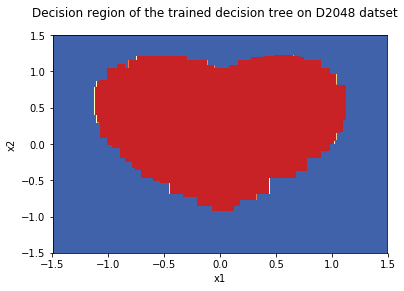

In [50]:
plot_step = 0.002
x_min, x_max = numpy_matrix[0:8192, 0].min() , numpy_matrix[0:8192, 0].max() 
y_min, y_max = numpy_matrix[0:8192, 1].min() , numpy_matrix[0:8192, 1].max() 
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
positions = np.vstack([xx.ravel(), yy.ravel()])
Z = test_accuracy(tree8192, xx.ravel(), yy.ravel())
Z = np.asarray(Z)
Z = Z.reshape(xx.shape)

plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)


cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

plt.xlabel('x1')
plt.ylabel('x2')

plt.suptitle("Decision region of the trained decision tree on D2048 datset")
#plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")

#labels = ['blue = label 1', 'red = label 0']

#plt.legend(loc='upper right', labels)
#plt.legend(labels)
plt.savefig('f3_d8192.png')
plt.show()

In [51]:
test_accuracy1(tree8192 ,dtest)

prediction error
31


Text(0.5,1,'Question 2.7: Learning curve')

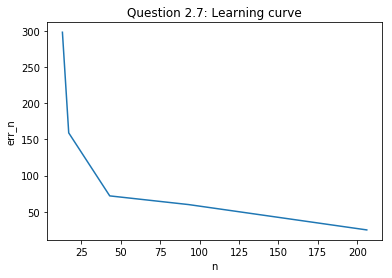

In [64]:
#p2.7 learning curve plot
plt.plot([13, 17, 43, 93, 206],[298,159,72,60,25])
plt.xlabel("n")
plt.ylabel("err_n")
plt.title("Question 2.7: Learning curve")


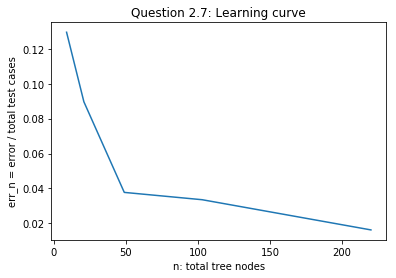

In [58]:
#p2.7 learning curve plot
plt.plot([9, 21, 49, 103, 220],[247/1908,171/1908,72/1908,64/1908,31/1908])
plt.xlabel("n: total tree nodes")
plt.ylabel("err_n = error / total test cases")
plt.title("Question 2.7: Learning curve")
plt.savefig('f3_self_n_err.png')


Text(0.5,1,'Question 3: Learning curve')

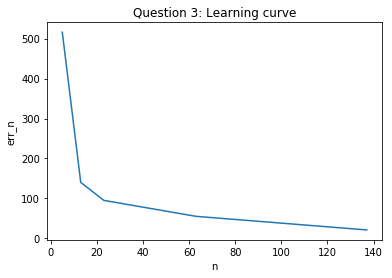

In [65]:
#p2 WEKA learning curve plot
plt.plot([5, 13, 23, 63, 137],[516,140,95,55,21])
plt.xlabel("n: total tree nodes")
plt.ylabel("err_n")
plt.title("Question 3: Learning curve")

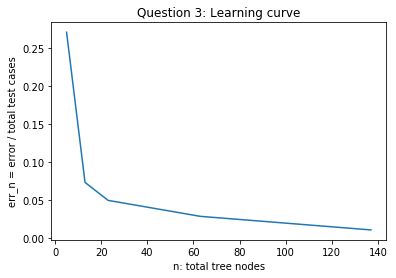

In [59]:
#p2 WEKA learning curve plot
plt.plot([5, 13, 23, 63, 137],[516/1908,140/1908,95/1908,55/1908,21/1908])
plt.xlabel("n: total tree nodes")
plt.ylabel("err_n = error / total test cases")
plt.title("Question 3: Learning curve")
plt.savefig('f3_weka_n_err.png')

In [64]:
516/1908,140/1908,95/1908,55/1908,21/1908


(0.27044025157232704,
 0.07337526205450734,
 0.04979035639412998,
 0.028825995807127882,
 0.0110062893081761)

In [65]:
247/1908,171/1908,72/1908,64/1908,31/1908

(0.12945492662473795,
 0.08962264150943396,
 0.03773584905660377,
 0.033542976939203356,
 0.016247379454926623)